# <p><center style="font-family:newtimeroman;font-size:180%;">Cycle GAN For American Sign Language Datasets </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Discriminator Model](#4)
* [Generator Model](#5)
* [GAN Model](#6)
* [Training Model](#7)

**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm as tqdm
import cv2
from numpy.random import randint
from numpy import ones
from numpy.random import randn
from numpy import zeros
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array,load_img
import keras
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Read Data </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/asl-dataset/asl_dataset')):
    subfolder_path = os.path.join('/kaggle/input/asl-dataset/asl_dataset', subfolder)
    if not os.path.isdir(subfolder_path) or subfolder=='asl_dataset':
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 37/37 [00:00<00:00, 96.00it/s] 


,image,label
0,/kaggle/input/asl-dataset/asl_dataset/n/hand2_...,n
1,/kaggle/input/asl-dataset/asl_dataset/n/hand1_...,n
2,/kaggle/input/asl-dataset/asl_dataset/n/hand2_...,n
3,/kaggle/input/asl-dataset/asl_dataset/n/hand1_...,n
4,/kaggle/input/asl-dataset/asl_dataset/n/hand2_...,n
...,...,...
2510,/kaggle/input/asl-dataset/asl_dataset/j/hand4_...,j
2511,/kaggle/input/asl-dataset/asl_dataset/j/hand1_...,j
2512,/kaggle/input/asl-dataset/asl_dataset/j/hand1_...,j
2513,/kaggle/input/asl-dataset/asl_dataset/j/hand1_...,j


In [3]:
def load_data(paths):
    Images=[]
    for i in paths:
        image=load_img(i,target_size=(32,32),color_mode='rgb')
        image=img_to_array(image)
        image=(image-127.5)/127.5
        Images.append(image)
    return np.array(Images)

In [4]:
Images=load_data(df['image'])
print('Images Shape Is :',Images.shape)

Images Shape Is : (2515, 32, 32, 3)


In [5]:
label=LabelEncoder().fit(df['label'])
Labels=label.transform(df['label'])

**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Visualization of Dataset </p>
<a class="btn" href="#home">Tabel of Contents</a>

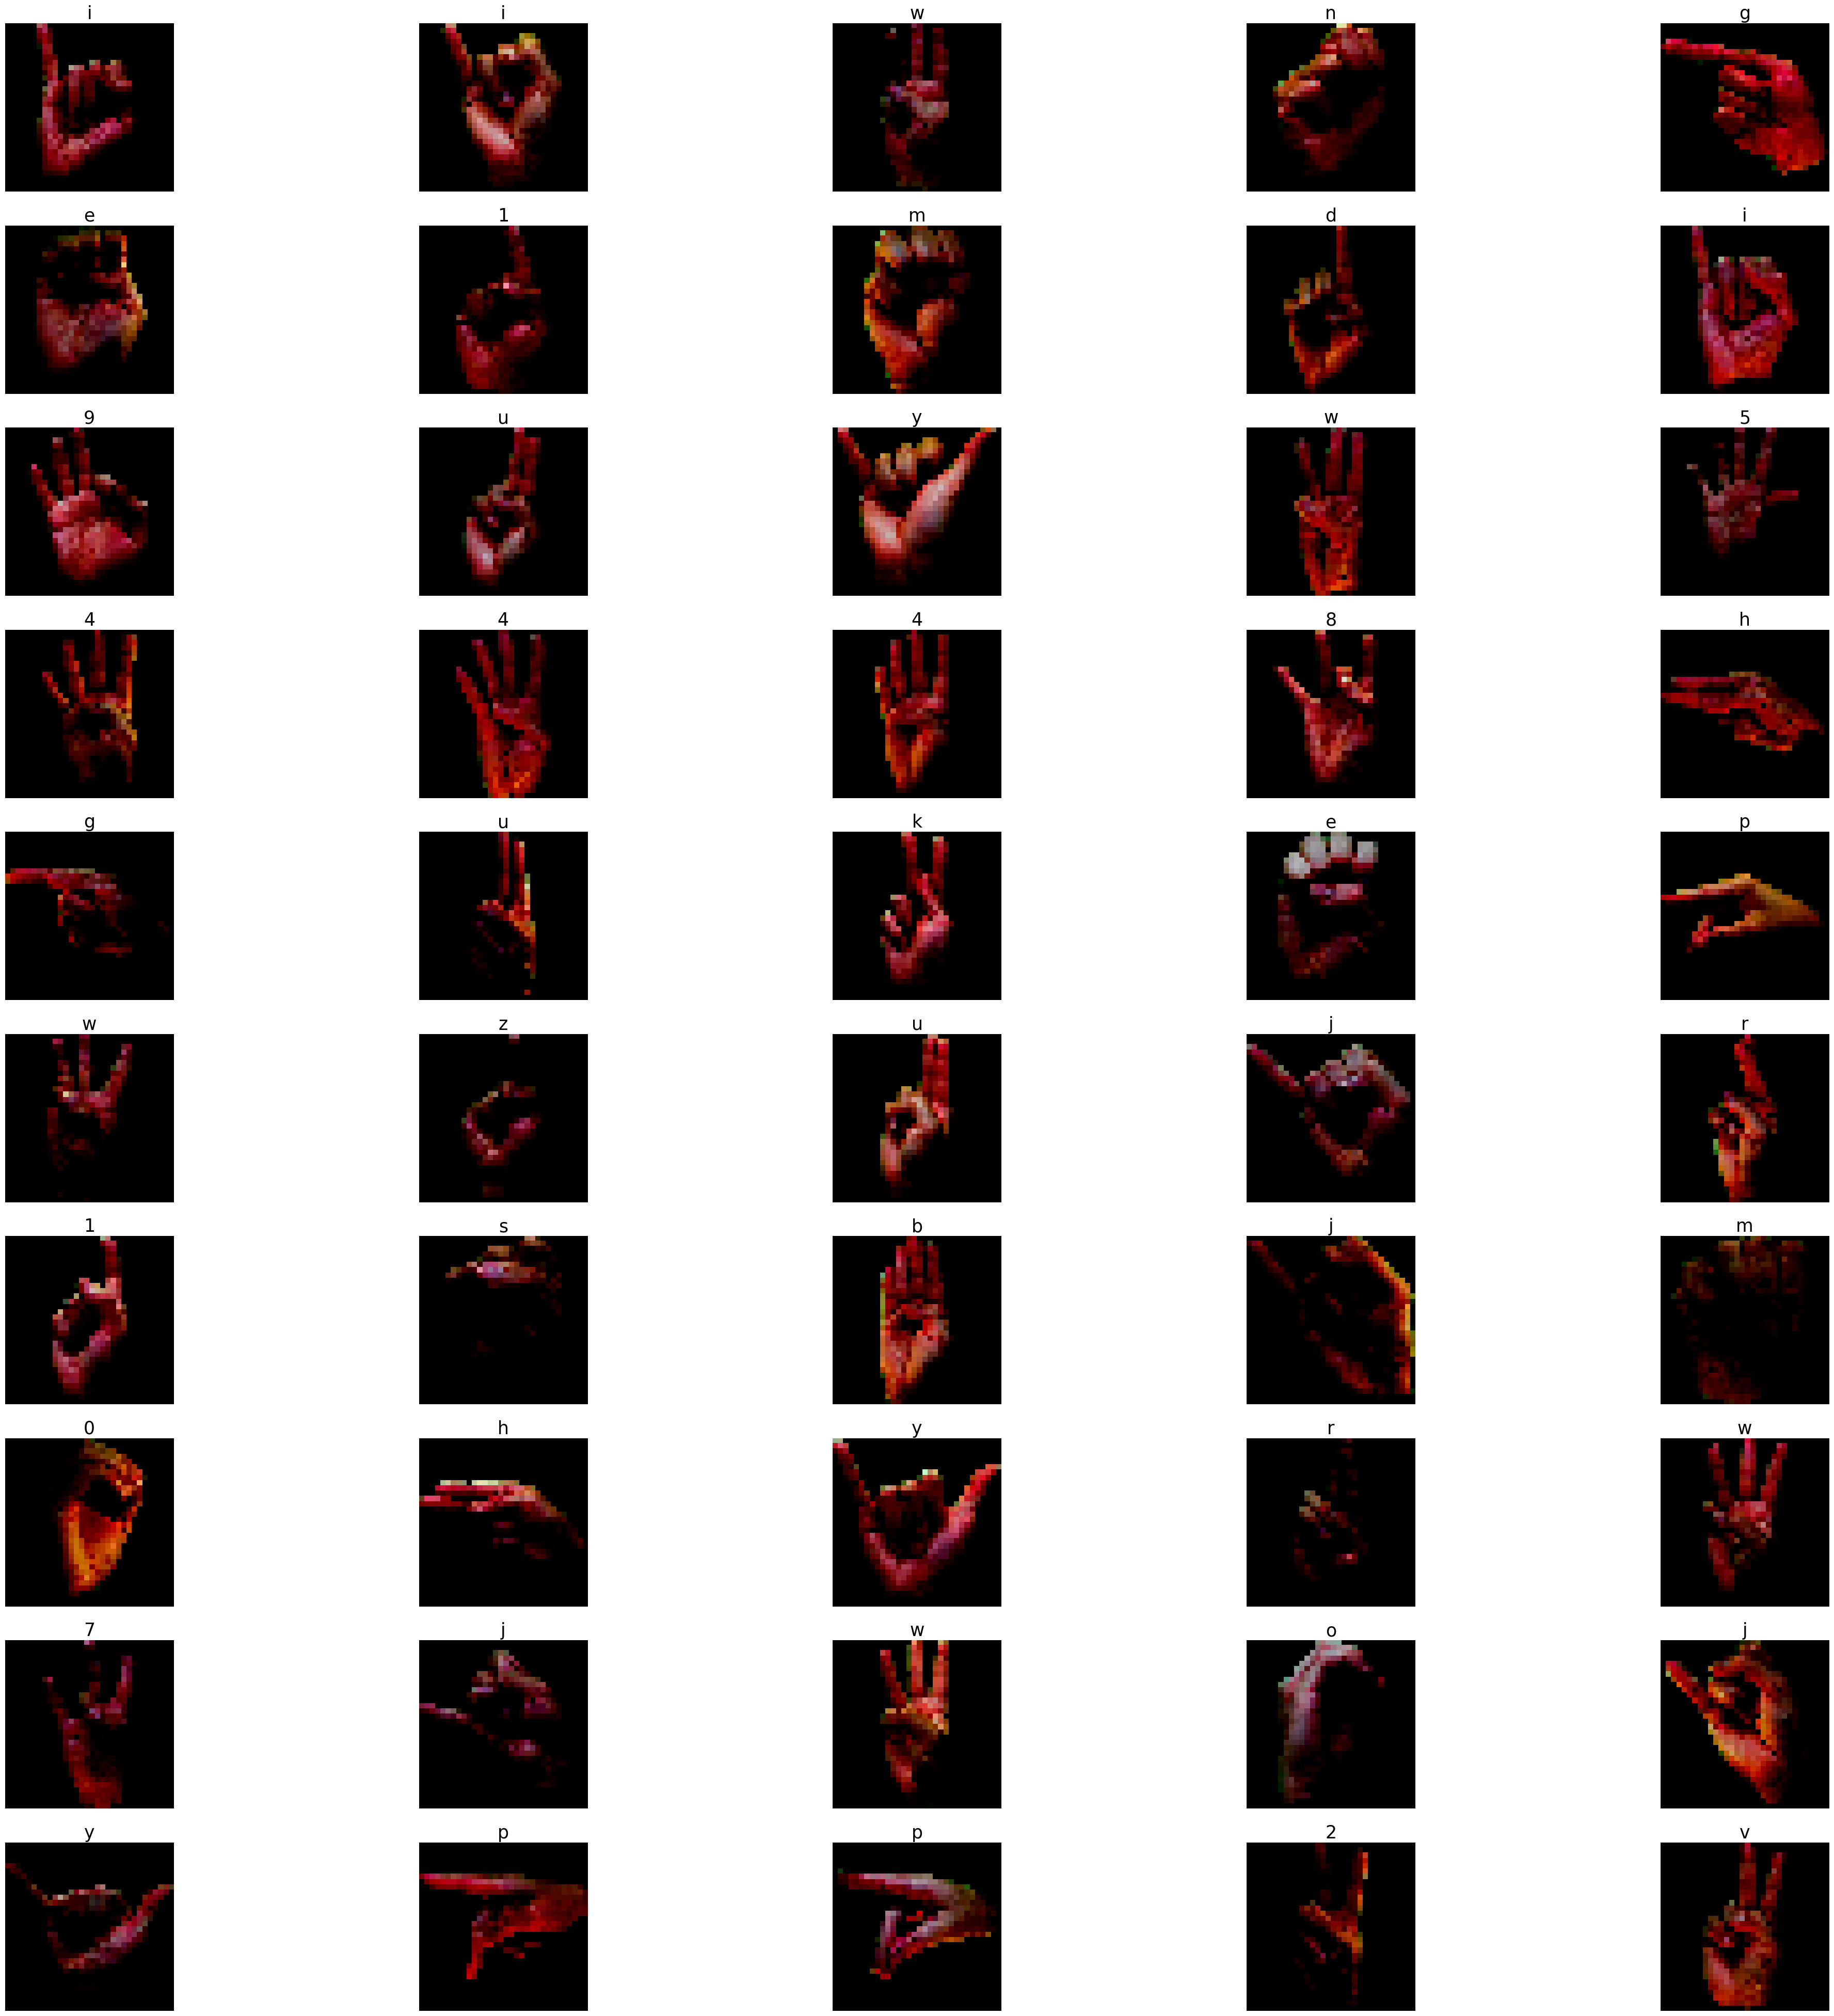

In [6]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(Images),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(Images[i])
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

**<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Discriminator Model</p>
<a class="btn" href="#home">Tabel of Contents</a>

In [7]:
def discriminator_model():
    in_label = keras.layers.Input(shape=(1,))
    li = keras.layers.Embedding(36, 50)(in_label) 
    li = keras.layers.Dense(32*32)(li) 
    li = keras.layers.Reshape((32,32, 1))(li) 
    in_image = keras.layers.Input((32,32,3))
    merge = keras.layers.Concatenate()([in_image, li])
    fe = keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) 
    fe = keras.layers.LeakyReLU(alpha=0.2)(fe)
    fe = keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) 
    fe = keras.layers.LeakyReLU(alpha=0.2)(fe)
    fe = keras.layers.Flatten()(fe)
    fe = keras.layers.Dropout(0.4)(fe)
    out_layer = keras.layers.Dense(1, activation='sigmoid')(fe)
    model = keras.models.Model([in_image, in_label], out_layer)
    opt=keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [8]:
discriminator=discriminator_model()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                1800      ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 1, 1024)              52224     ['embedding[0][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                              

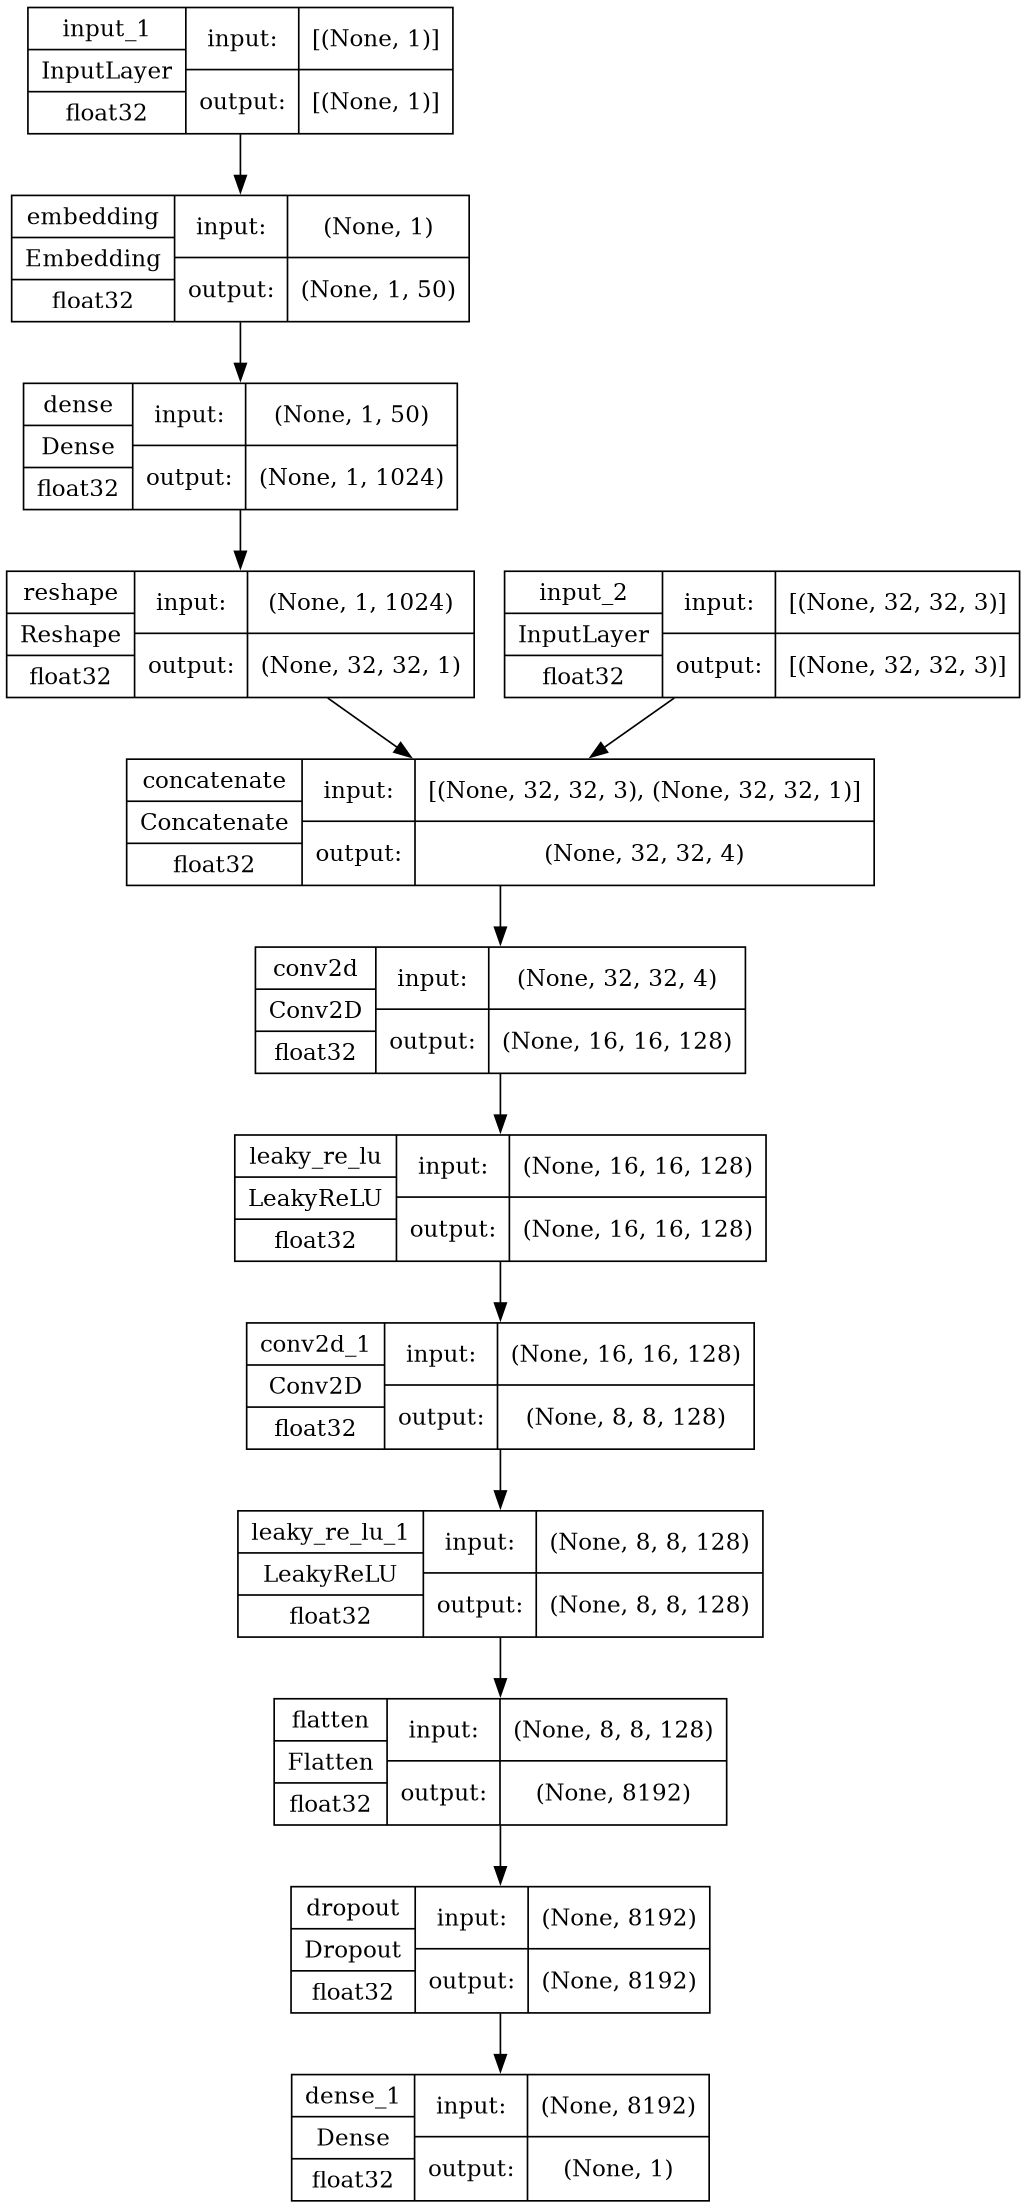

In [9]:
tf.keras.utils.plot_model(discriminator, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

**<a id="5"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Generator Model</p>
<a class="btn" href="#home">Tabel of Contents</a>

In [10]:
def generator_model():
    in_label = keras.layers.Input(shape=(1,)) 
    li = keras.layers.Embedding(36, 50)(in_label)
    n_nodes = 8 * 8   
    li = keras.layers.Dense(n_nodes)(li) 
    li = keras.layers.Reshape((8,8, 1))(li)
    in_lat = keras.layers.Input(shape=(100,))
    gen = keras.layers.Dense(n_nodes*128)(in_lat)  
    gen = keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = keras.layers.Reshape((8,8,128))(gen)
    merge = keras.layers.Concatenate()([gen, li])
    gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) 
    gen = keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) 
    gen = keras.layers.LeakyReLU(alpha=0.2)(gen)
    out_layer = keras.layers.Conv2D(3, (8,8), activation='tanh', padding='same')(gen) 
    model = keras.models.Model([in_lat, in_label], out_layer)
    return model

In [11]:
generator=generator_model()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 8192)                 827392    ['input_4[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                1800      ['input_3[0][0]']             
                                                                                            

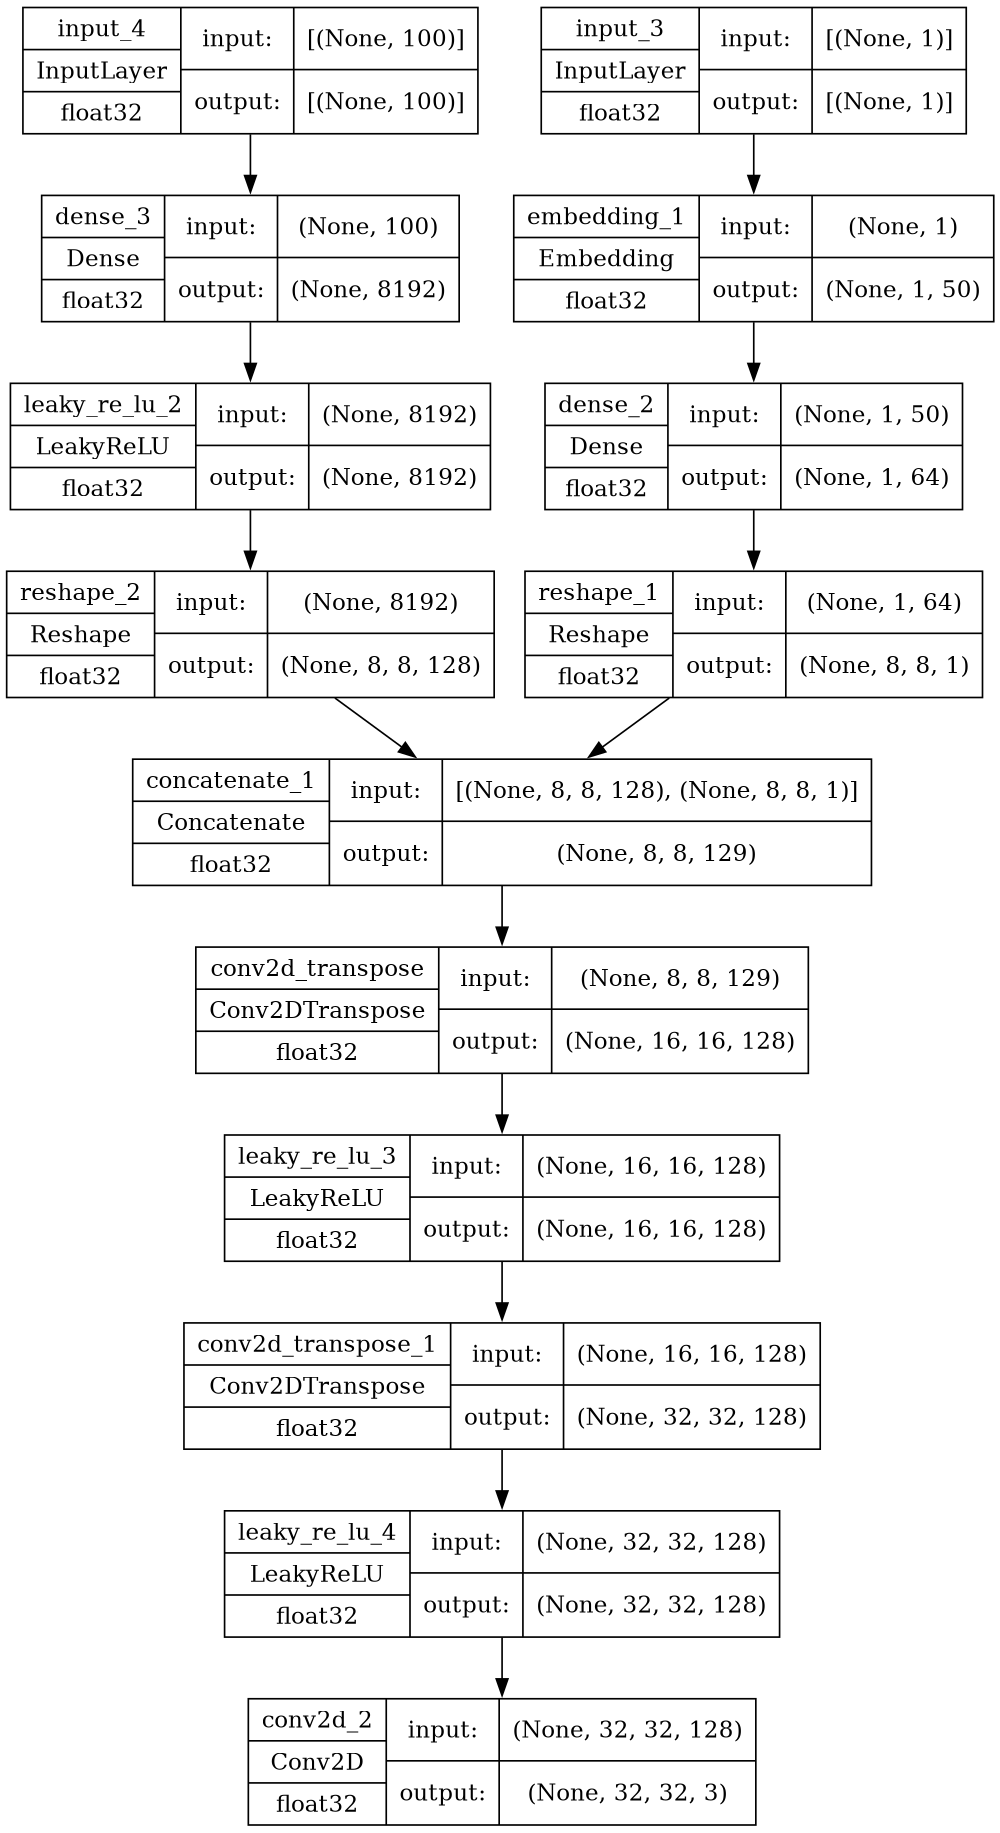

In [12]:
tf.keras.utils.plot_model(generator, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

**<a id="6"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">GAN Model</p>
<a class="btn" href="#home">Tabel of Contents</a>

In [13]:
def GAN_model():
    discriminator.trainable = False  
    gen_noise, gen_label = generator.input  
    gen_output = generator.output 
    gan_output = discriminator([gen_output, gen_label])
    model = keras.models.Model([gen_noise, gen_label], gan_output)
    opt=keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [14]:
GAN=GAN_model()
GAN.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 8192)                 827392    ['input_4[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                1800      ['input_3[0][0]']             
                                                                                            

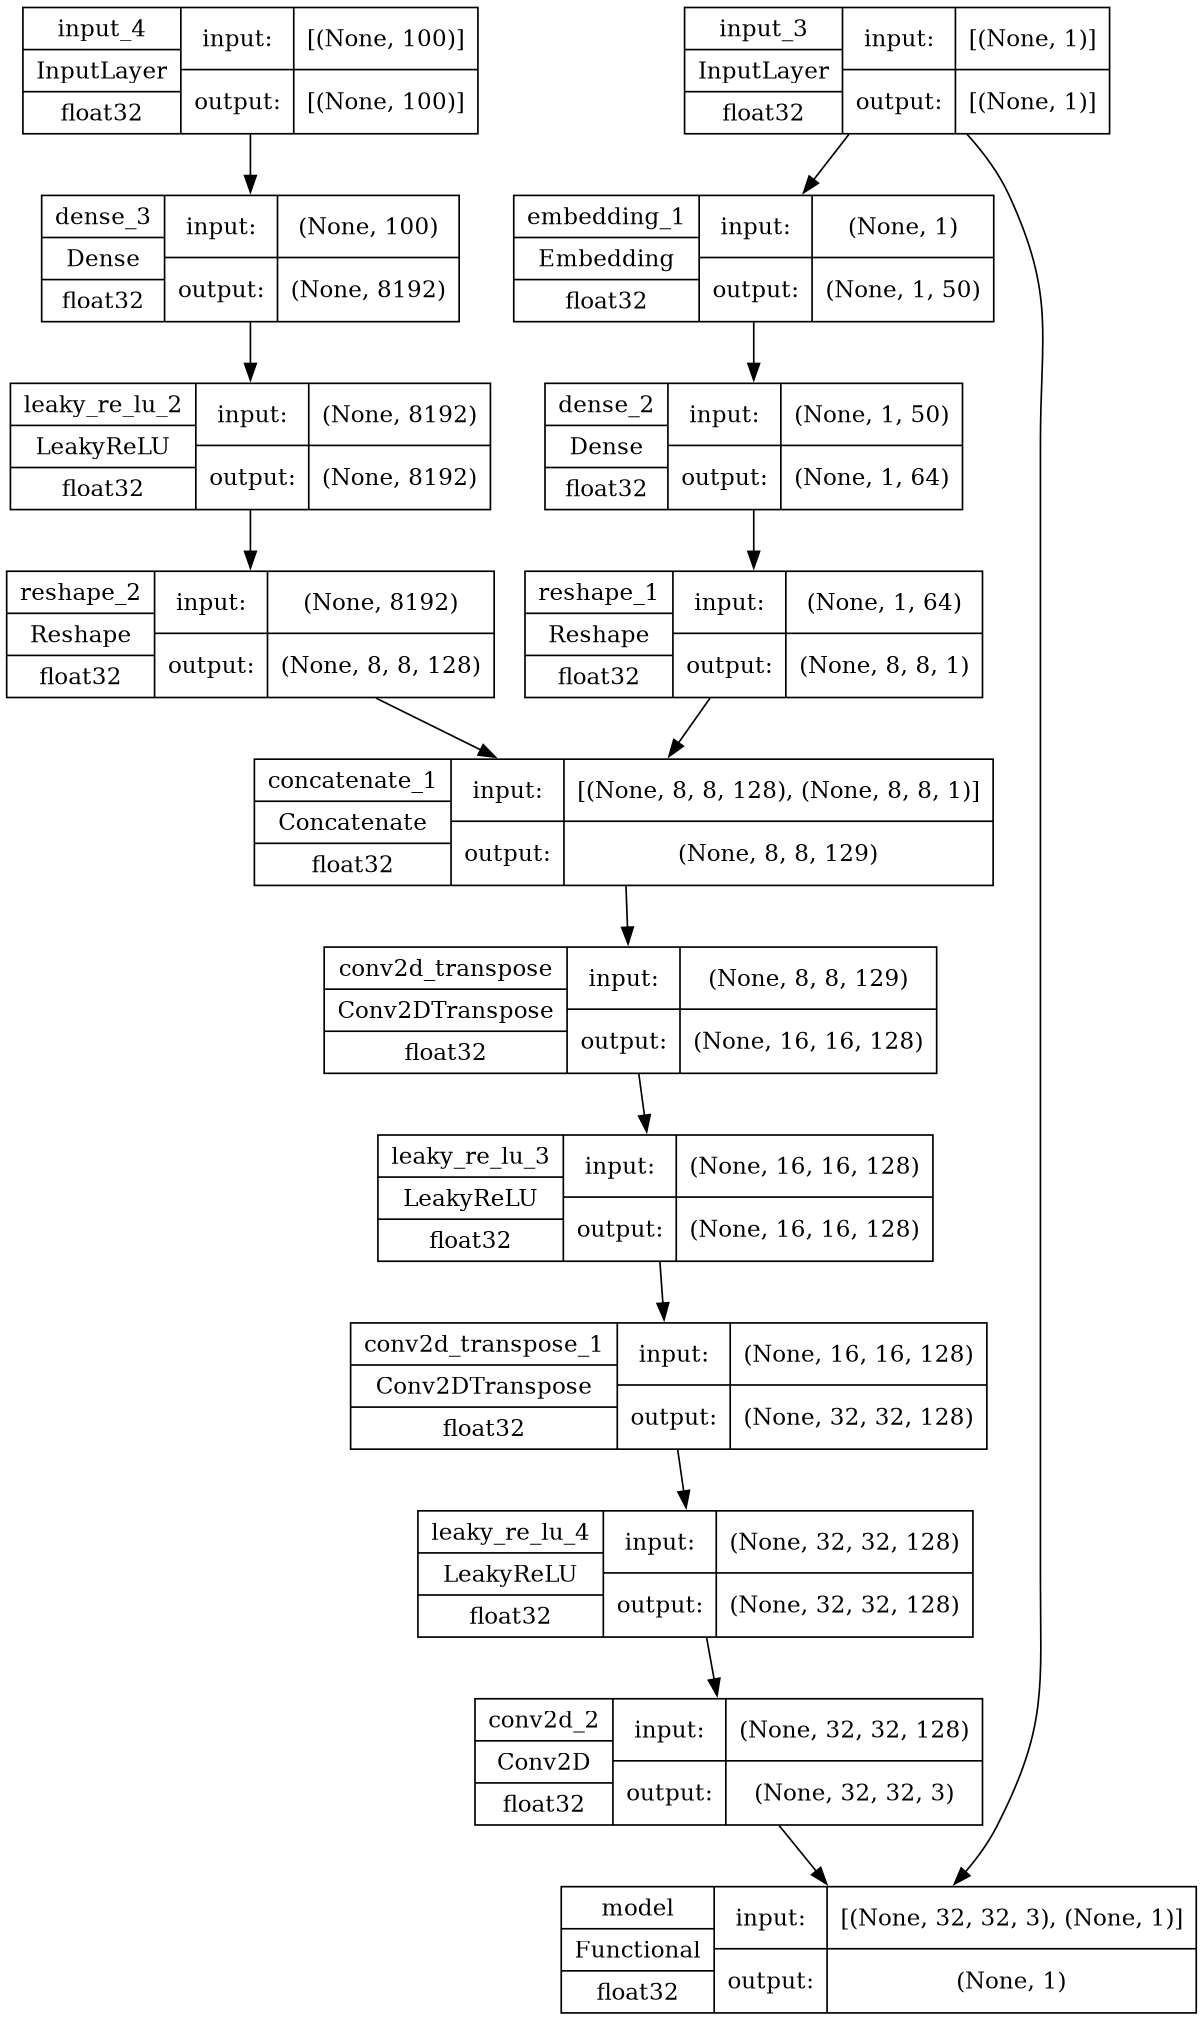

In [15]:
tf.keras.utils.plot_model(GAN, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

**<a id="7"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Training Model</p>
<a class="btn" href="#home">Tabel of Contents</a>

In [16]:
def generate_real_samples():
    ix = randint(0,Images.shape[0],64)
    X, labels = Images[ix], Labels[ix]
    y = ones((64, 1)) 
    return [X, labels], y

In [17]:
def generate_latent_points(number=64):
    x_input = randn(100 * number) 
    z_input = x_input.reshape(number, 100)
    labels = randint(0, 64, number)
    return [z_input, labels]

In [18]:
def generate_fake_samples():
    z_input, labels_input = generate_latent_points()
    images = generator.predict([z_input, labels_input])
    y = zeros((64, 1))  
    return [images, labels_input], y

In [19]:
bat_per_epo = int(Images.shape[0] / 128)
bat_per_epo

19

In [20]:
def train():
    bat_per_epo = int(Images.shape[0] / 128)
    half_batch = 64 
    for i in tqdm(range(500)):
        for j in range(bat_per_epo):
            [X_real, labels_real], y_real = generate_real_samples()
            d_loss_real, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels], y_fake = generate_fake_samples()
            d_loss_fake, _ = discriminator.train_on_batch([X_fake, labels], y_fake)            
            [z_input, labels_input] = generate_latent_points(128)
            y_gan = ones((128, 1))
            g_loss = GAN.train_on_batch([z_input, labels_input], y_gan)
            print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
    generator.save('Sign Language_generator.h5')

In [21]:
train()

  0%|          | 0/500 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch1/19, d1=0.691, d2=0.705 g=0.688
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch2/19, d1=0.192, d2=0.898 g=0.564
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch3/19, d1=0.065, d2=1.487 g=0.533
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch4/19, d1=0.168, d2=1.075 g=1.014
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch5/19, d1=0.359, d2=0.416 g=1.913
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch6/19, d1=0.457, d2=0.259 g=1.999
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch7/19, d1=0.332, d2=0.815 g=1.245
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch8/19, d1=0.203, d2=0.840 g=0.985
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch9/19, d1=0.107, d2=0.689 g=0.968
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch10/19, d1=0.023, d2=0.736 g=0.687
2/2 [==============

  0%|          | 1/500 [00:18<2:34:12, 18.54s/it]

Epoch>1, Batch19/19, d1=0.355, d2=1.283 g=1.054
2/2 [==============================] - 0s 3ms/step
Epoch>2, Batch1/19, d1=0.429, d2=0.981 g=1.072
2/2 [==============================] - 0s 3ms/step
Epoch>2, Batch2/19, d1=0.566, d2=1.066 g=0.673
2/2 [==============================] - 0s 3ms/step
Epoch>2, Batch3/19, d1=0.470, d2=1.009 g=0.972
2/2 [==============================] - 0s 3ms/step
Epoch>2, Batch4/19, d1=0.588, d2=0.809 g=0.980
2/2 [==============================] - 0s 3ms/step
Epoch>2, Batch5/19, d1=0.664, d2=0.917 g=0.765
2/2 [==============================] - 0s 3ms/step
Epoch>2, Batch6/19, d1=0.603, d2=0.719 g=0.949
2/2 [==============================] - 0s 3ms/step
Epoch>2, Batch7/19, d1=0.593, d2=0.590 g=1.193
2/2 [==============================] - 0s 3ms/step
Epoch>2, Batch8/19, d1=0.582, d2=0.729 g=1.106
2/2 [==============================] - 0s 3ms/step
Epoch>2, Batch9/19, d1=0.612, d2=0.900 g=1.342
2/2 [==============================] - 0s 3ms/step
Epoch>2, Batch10/19

  0%|          | 2/500 [00:21<1:17:52,  9.38s/it]

Epoch>2, Batch19/19, d1=0.385, d2=0.873 g=1.006
2/2 [==============================] - 0s 3ms/step
Epoch>3, Batch1/19, d1=0.383, d2=0.705 g=1.308
2/2 [==============================] - 0s 3ms/step
Epoch>3, Batch2/19, d1=0.351, d2=0.460 g=1.720
2/2 [==============================] - 0s 3ms/step
Epoch>3, Batch3/19, d1=0.174, d2=0.875 g=1.342
2/2 [==============================] - 0s 3ms/step
Epoch>3, Batch4/19, d1=0.328, d2=1.562 g=1.555
2/2 [==============================] - 0s 3ms/step
Epoch>3, Batch5/19, d1=0.538, d2=0.437 g=3.084
2/2 [==============================] - 0s 3ms/step
Epoch>3, Batch6/19, d1=0.576, d2=0.720 g=0.998
2/2 [==============================] - 0s 3ms/step
Epoch>3, Batch7/19, d1=0.460, d2=1.044 g=0.901
2/2 [==============================] - 0s 3ms/step
Epoch>3, Batch8/19, d1=0.488, d2=0.915 g=0.915
2/2 [==============================] - 0s 3ms/step
Epoch>3, Batch9/19, d1=0.551, d2=0.712 g=1.047
2/2 [==============================] - 0s 3ms/step
Epoch>3, Batch10/19

  1%|          | 3/500 [00:23<50:33,  6.10s/it]  

Epoch>3, Batch19/19, d1=0.600, d2=0.561 g=1.178
2/2 [==============================] - 0s 3ms/step
Epoch>4, Batch1/19, d1=0.538, d2=0.528 g=1.267
2/2 [==============================] - 0s 3ms/step
Epoch>4, Batch2/19, d1=0.516, d2=0.570 g=1.363
2/2 [==============================] - 0s 3ms/step
Epoch>4, Batch3/19, d1=0.531, d2=0.612 g=1.439
2/2 [==============================] - 0s 3ms/step
Epoch>4, Batch4/19, d1=0.524, d2=0.672 g=1.633
2/2 [==============================] - 0s 3ms/step
Epoch>4, Batch5/19, d1=0.505, d2=0.633 g=1.488
2/2 [==============================] - 0s 3ms/step
Epoch>4, Batch6/19, d1=0.442, d2=0.726 g=1.265
2/2 [==============================] - 0s 3ms/step
Epoch>4, Batch7/19, d1=0.399, d2=1.155 g=1.121
2/2 [==============================] - 0s 3ms/step
Epoch>4, Batch8/19, d1=0.541, d2=1.081 g=0.983
2/2 [==============================] - 0s 3ms/step
Epoch>4, Batch9/19, d1=0.692, d2=0.889 g=0.898
2/2 [==============================] - 0s 3ms/step
Epoch>4, Batch10/19

  1%|          | 4/500 [00:26<38:51,  4.70s/it]

Epoch>4, Batch19/19, d1=0.719, d2=0.766 g=1.061
2/2 [==============================] - 0s 3ms/step
Epoch>5, Batch1/19, d1=0.706, d2=0.605 g=1.237
2/2 [==============================] - 0s 3ms/step
Epoch>5, Batch2/19, d1=0.709, d2=0.540 g=1.346
2/2 [==============================] - 0s 3ms/step
Epoch>5, Batch3/19, d1=0.643, d2=0.496 g=1.611
2/2 [==============================] - 0s 3ms/step
Epoch>5, Batch4/19, d1=0.601, d2=0.544 g=1.448
2/2 [==============================] - 0s 3ms/step
Epoch>5, Batch5/19, d1=0.642, d2=0.971 g=0.937
2/2 [==============================] - 0s 3ms/step
Epoch>5, Batch6/19, d1=0.638, d2=0.828 g=1.250
2/2 [==============================] - 0s 3ms/step
Epoch>5, Batch7/19, d1=0.627, d2=0.647 g=1.303
2/2 [==============================] - 0s 3ms/step
Epoch>5, Batch8/19, d1=0.641, d2=0.728 g=1.133
2/2 [==============================] - 0s 3ms/step
Epoch>5, Batch9/19, d1=0.660, d2=0.741 g=0.942
2/2 [==============================] - 0s 3ms/step
Epoch>5, Batch10/19

  1%|          | 5/500 [00:28<31:52,  3.86s/it]

Epoch>5, Batch19/19, d1=0.632, d2=0.943 g=0.794
2/2 [==============================] - 0s 3ms/step
Epoch>6, Batch1/19, d1=0.659, d2=0.900 g=0.916
2/2 [==============================] - 0s 3ms/step
Epoch>6, Batch2/19, d1=0.692, d2=0.697 g=1.098
2/2 [==============================] - 0s 3ms/step
Epoch>6, Batch3/19, d1=0.648, d2=0.735 g=1.018
2/2 [==============================] - 0s 3ms/step
Epoch>6, Batch4/19, d1=0.733, d2=0.745 g=0.900
2/2 [==============================] - 0s 3ms/step
Epoch>6, Batch5/19, d1=0.633, d2=0.665 g=1.006
2/2 [==============================] - 0s 3ms/step
Epoch>6, Batch6/19, d1=0.578, d2=0.565 g=1.092
2/2 [==============================] - 0s 3ms/step
Epoch>6, Batch7/19, d1=0.573, d2=0.608 g=1.050
2/2 [==============================] - 0s 3ms/step
Epoch>6, Batch8/19, d1=0.584, d2=0.755 g=0.927
2/2 [==============================] - 0s 3ms/step
Epoch>6, Batch9/19, d1=0.544, d2=0.817 g=0.957
2/2 [==============================] - 0s 3ms/step
Epoch>6, Batch10/19

  1%|          | 6/500 [00:31<28:13,  3.43s/it]

Epoch>6, Batch19/19, d1=0.568, d2=0.669 g=1.353
2/2 [==============================] - 0s 3ms/step
Epoch>7, Batch1/19, d1=0.512, d2=0.530 g=1.459
2/2 [==============================] - 0s 3ms/step
Epoch>7, Batch2/19, d1=0.591, d2=0.660 g=1.107
2/2 [==============================] - 0s 3ms/step
Epoch>7, Batch3/19, d1=0.541, d2=0.649 g=0.999
2/2 [==============================] - 0s 3ms/step
Epoch>7, Batch4/19, d1=0.548, d2=0.728 g=0.957
2/2 [==============================] - 0s 3ms/step
Epoch>7, Batch5/19, d1=0.521, d2=0.681 g=0.934
2/2 [==============================] - 0s 3ms/step
Epoch>7, Batch6/19, d1=0.510, d2=0.719 g=1.095
2/2 [==============================] - 0s 3ms/step
Epoch>7, Batch7/19, d1=0.518, d2=0.726 g=1.149
2/2 [==============================] - 0s 3ms/step
Epoch>7, Batch8/19, d1=0.512, d2=0.662 g=1.246
2/2 [==============================] - 0s 3ms/step
Epoch>7, Batch9/19, d1=0.499, d2=0.593 g=1.231
2/2 [==============================] - 0s 3ms/step
Epoch>7, Batch10/19

  1%|▏         | 7/500 [00:33<25:45,  3.13s/it]

Epoch>7, Batch19/19, d1=0.617, d2=0.460 g=1.660
2/2 [==============================] - 0s 3ms/step
Epoch>8, Batch1/19, d1=0.456, d2=0.490 g=1.684
2/2 [==============================] - 0s 3ms/step
Epoch>8, Batch2/19, d1=0.427, d2=0.439 g=1.807
2/2 [==============================] - 0s 3ms/step
Epoch>8, Batch3/19, d1=0.432, d2=0.627 g=1.335
2/2 [==============================] - 0s 3ms/step
Epoch>8, Batch4/19, d1=0.389, d2=0.716 g=1.415
2/2 [==============================] - 0s 3ms/step
Epoch>8, Batch5/19, d1=0.527, d2=0.810 g=1.200
2/2 [==============================] - 0s 3ms/step
Epoch>8, Batch6/19, d1=0.523, d2=0.775 g=1.250
2/2 [==============================] - 0s 3ms/step
Epoch>8, Batch7/19, d1=0.521, d2=0.726 g=1.337
2/2 [==============================] - 0s 3ms/step
Epoch>8, Batch8/19, d1=0.529, d2=0.685 g=1.439
2/2 [==============================] - 0s 3ms/step
Epoch>8, Batch9/19, d1=0.589, d2=0.587 g=1.520
2/2 [==============================] - 0s 3ms/step
Epoch>8, Batch10/19

  2%|▏         | 8/500 [00:35<23:18,  2.84s/it]

Epoch>8, Batch19/19, d1=0.423, d2=0.581 g=1.446
2/2 [==============================] - 0s 3ms/step
Epoch>9, Batch1/19, d1=0.410, d2=0.708 g=1.452
2/2 [==============================] - 0s 3ms/step
Epoch>9, Batch2/19, d1=0.509, d2=0.624 g=1.577
2/2 [==============================] - 0s 3ms/step
Epoch>9, Batch3/19, d1=0.481, d2=0.466 g=1.452
2/2 [==============================] - 0s 3ms/step
Epoch>9, Batch4/19, d1=0.404, d2=0.619 g=1.393
2/2 [==============================] - 0s 3ms/step
Epoch>9, Batch5/19, d1=0.402, d2=0.542 g=1.601
2/2 [==============================] - 0s 5ms/step
Epoch>9, Batch6/19, d1=0.417, d2=0.565 g=1.552
2/2 [==============================] - 0s 4ms/step
Epoch>9, Batch7/19, d1=0.376, d2=0.560 g=1.572
2/2 [==============================] - 0s 3ms/step
Epoch>9, Batch8/19, d1=0.448, d2=0.589 g=1.564
2/2 [==============================] - 0s 3ms/step
Epoch>9, Batch9/19, d1=0.400, d2=0.559 g=1.906
2/2 [==============================] - 0s 3ms/step
Epoch>9, Batch10/19

  2%|▏         | 9/500 [00:38<22:22,  2.73s/it]

Epoch>9, Batch19/19, d1=0.473, d2=0.754 g=2.689
2/2 [==============================] - 0s 3ms/step
Epoch>10, Batch1/19, d1=0.529, d2=0.368 g=2.114
2/2 [==============================] - 0s 3ms/step
Epoch>10, Batch2/19, d1=0.447, d2=0.529 g=2.263
2/2 [==============================] - 0s 3ms/step
Epoch>10, Batch3/19, d1=0.343, d2=0.514 g=1.691
2/2 [==============================] - 0s 3ms/step
Epoch>10, Batch4/19, d1=0.368, d2=0.608 g=1.714
2/2 [==============================] - 0s 3ms/step
Epoch>10, Batch5/19, d1=0.439, d2=0.720 g=1.885
2/2 [==============================] - 0s 4ms/step
Epoch>10, Batch6/19, d1=0.462, d2=0.598 g=2.003
2/2 [==============================] - 0s 3ms/step
Epoch>10, Batch7/19, d1=0.537, d2=0.611 g=1.740
2/2 [==============================] - 0s 3ms/step
Epoch>10, Batch8/19, d1=0.493, d2=0.646 g=1.722
2/2 [==============================] - 0s 3ms/step
Epoch>10, Batch9/19, d1=0.408, d2=0.724 g=2.037
2/2 [==============================] - 0s 3ms/step
Epoch>10, 

  2%|▏         | 10/500 [00:40<21:10,  2.59s/it]

Epoch>10, Batch19/19, d1=0.359, d2=0.736 g=1.976
2/2 [==============================] - 0s 3ms/step
Epoch>11, Batch1/19, d1=0.358, d2=0.547 g=2.262
2/2 [==============================] - 0s 3ms/step
Epoch>11, Batch2/19, d1=0.451, d2=0.506 g=2.203
2/2 [==============================] - 0s 3ms/step
Epoch>11, Batch3/19, d1=0.394, d2=0.461 g=2.076
2/2 [==============================] - 0s 3ms/step
Epoch>11, Batch4/19, d1=0.374, d2=0.727 g=1.935
2/2 [==============================] - 0s 3ms/step
Epoch>11, Batch5/19, d1=0.426, d2=0.716 g=2.291
2/2 [==============================] - 0s 3ms/step
Epoch>11, Batch6/19, d1=0.431, d2=0.643 g=2.109
2/2 [==============================] - 0s 3ms/step
Epoch>11, Batch7/19, d1=0.486, d2=0.550 g=2.096
2/2 [==============================] - 0s 3ms/step
Epoch>11, Batch8/19, d1=0.452, d2=0.427 g=1.911
2/2 [==============================] - 0s 3ms/step
Epoch>11, Batch9/19, d1=0.332, d2=0.704 g=2.001
2/2 [==============================] - 0s 3ms/step
Epoch>11,

  2%|▏         | 11/500 [00:42<20:06,  2.47s/it]

Epoch>11, Batch19/19, d1=0.417, d2=0.740 g=1.920
2/2 [==============================] - 0s 3ms/step
Epoch>12, Batch1/19, d1=0.403, d2=0.550 g=2.026
2/2 [==============================] - 0s 3ms/step
Epoch>12, Batch2/19, d1=0.496, d2=0.606 g=1.848
2/2 [==============================] - 0s 3ms/step
Epoch>12, Batch3/19, d1=0.499, d2=0.569 g=1.954
2/2 [==============================] - 0s 3ms/step
Epoch>12, Batch4/19, d1=0.409, d2=0.580 g=2.085
2/2 [==============================] - 0s 3ms/step
Epoch>12, Batch5/19, d1=0.420, d2=0.801 g=1.864
2/2 [==============================] - 0s 3ms/step
Epoch>12, Batch6/19, d1=0.489, d2=0.513 g=1.991
2/2 [==============================] - 0s 3ms/step
Epoch>12, Batch7/19, d1=0.509, d2=0.629 g=1.854
2/2 [==============================] - 0s 3ms/step
Epoch>12, Batch8/19, d1=0.480, d2=0.513 g=1.915
2/2 [==============================] - 0s 3ms/step
Epoch>12, Batch9/19, d1=0.409, d2=0.583 g=1.997
2/2 [==============================] - 0s 3ms/step
Epoch>12,

  2%|▏         | 12/500 [00:45<19:22,  2.38s/it]

Epoch>12, Batch19/19, d1=0.454, d2=0.501 g=1.933
2/2 [==============================] - 0s 3ms/step
Epoch>13, Batch1/19, d1=0.486, d2=0.563 g=1.670
2/2 [==============================] - 0s 3ms/step
Epoch>13, Batch2/19, d1=0.393, d2=0.676 g=1.789
2/2 [==============================] - 0s 3ms/step
Epoch>13, Batch3/19, d1=0.466, d2=0.607 g=1.795
2/2 [==============================] - 0s 3ms/step
Epoch>13, Batch4/19, d1=0.469, d2=0.636 g=1.825
2/2 [==============================] - 0s 3ms/step
Epoch>13, Batch5/19, d1=0.412, d2=0.586 g=2.134
2/2 [==============================] - 0s 3ms/step
Epoch>13, Batch6/19, d1=0.454, d2=0.511 g=2.134
2/2 [==============================] - 0s 3ms/step
Epoch>13, Batch7/19, d1=0.411, d2=0.549 g=1.889
2/2 [==============================] - 0s 3ms/step
Epoch>13, Batch8/19, d1=0.427, d2=0.489 g=2.137
2/2 [==============================] - 0s 3ms/step
Epoch>13, Batch9/19, d1=0.387, d2=0.767 g=2.157
2/2 [==============================] - 0s 3ms/step
Epoch>13,

  3%|▎         | 13/500 [00:47<18:52,  2.33s/it]

Epoch>13, Batch19/19, d1=0.403, d2=0.484 g=1.887
2/2 [==============================] - 0s 3ms/step
Epoch>14, Batch1/19, d1=0.313, d2=0.641 g=2.042
2/2 [==============================] - 0s 3ms/step
Epoch>14, Batch2/19, d1=0.451, d2=0.528 g=2.174
2/2 [==============================] - 0s 3ms/step
Epoch>14, Batch3/19, d1=0.496, d2=0.561 g=1.823
2/2 [==============================] - 0s 3ms/step
Epoch>14, Batch4/19, d1=0.420, d2=0.690 g=1.795
2/2 [==============================] - 0s 3ms/step
Epoch>14, Batch5/19, d1=0.499, d2=0.594 g=1.643
2/2 [==============================] - 0s 3ms/step
Epoch>14, Batch6/19, d1=0.415, d2=0.553 g=1.888
2/2 [==============================] - 0s 3ms/step
Epoch>14, Batch7/19, d1=0.410, d2=0.616 g=1.905
2/2 [==============================] - 0s 3ms/step
Epoch>14, Batch8/19, d1=0.447, d2=0.559 g=2.018
2/2 [==============================] - 0s 3ms/step
Epoch>14, Batch9/19, d1=0.434, d2=0.604 g=1.883
2/2 [==============================] - 0s 3ms/step
Epoch>14,

  3%|▎         | 14/500 [00:49<18:33,  2.29s/it]

Epoch>14, Batch19/19, d1=0.409, d2=0.563 g=1.754
2/2 [==============================] - 0s 3ms/step
Epoch>15, Batch1/19, d1=0.432, d2=0.556 g=1.997
2/2 [==============================] - 0s 3ms/step
Epoch>15, Batch2/19, d1=0.406, d2=0.577 g=2.198
2/2 [==============================] - 0s 3ms/step
Epoch>15, Batch3/19, d1=0.503, d2=0.562 g=2.163
2/2 [==============================] - 0s 3ms/step
Epoch>15, Batch4/19, d1=0.377, d2=0.514 g=2.084
2/2 [==============================] - 0s 3ms/step
Epoch>15, Batch5/19, d1=0.431, d2=0.585 g=2.072
2/2 [==============================] - 0s 3ms/step
Epoch>15, Batch6/19, d1=0.371, d2=0.630 g=1.810
2/2 [==============================] - 0s 3ms/step
Epoch>15, Batch7/19, d1=0.451, d2=0.768 g=1.861
2/2 [==============================] - 0s 3ms/step
Epoch>15, Batch8/19, d1=0.558, d2=0.696 g=1.676
2/2 [==============================] - 0s 3ms/step
Epoch>15, Batch9/19, d1=0.455, d2=0.617 g=2.229
2/2 [==============================] - 0s 3ms/step
Epoch>15,

  3%|▎         | 15/500 [00:51<18:15,  2.26s/it]

Epoch>15, Batch19/19, d1=0.380, d2=0.552 g=1.851
2/2 [==============================] - 0s 3ms/step
Epoch>16, Batch1/19, d1=0.441, d2=0.435 g=1.772
2/2 [==============================] - 0s 3ms/step
Epoch>16, Batch2/19, d1=0.420, d2=0.521 g=2.285
2/2 [==============================] - 0s 3ms/step
Epoch>16, Batch3/19, d1=0.393, d2=0.533 g=1.923
2/2 [==============================] - 0s 3ms/step
Epoch>16, Batch4/19, d1=0.398, d2=0.563 g=2.022
2/2 [==============================] - 0s 3ms/step
Epoch>16, Batch5/19, d1=0.464, d2=0.480 g=1.806
2/2 [==============================] - 0s 3ms/step
Epoch>16, Batch6/19, d1=0.437, d2=0.728 g=1.804
2/2 [==============================] - 0s 3ms/step
Epoch>16, Batch7/19, d1=0.445, d2=0.616 g=1.981
2/2 [==============================] - 0s 3ms/step
Epoch>16, Batch8/19, d1=0.612, d2=0.528 g=2.009
2/2 [==============================] - 0s 3ms/step
Epoch>16, Batch9/19, d1=0.469, d2=0.609 g=1.952
2/2 [==============================] - 0s 3ms/step
Epoch>16,

  3%|▎         | 16/500 [00:53<18:04,  2.24s/it]

Epoch>16, Batch19/19, d1=0.423, d2=0.602 g=1.951
2/2 [==============================] - 0s 3ms/step
Epoch>17, Batch1/19, d1=0.397, d2=0.474 g=2.125
2/2 [==============================] - 0s 3ms/step
Epoch>17, Batch2/19, d1=0.423, d2=0.483 g=2.016
2/2 [==============================] - 0s 3ms/step
Epoch>17, Batch3/19, d1=0.348, d2=0.560 g=2.265
2/2 [==============================] - 0s 3ms/step
Epoch>17, Batch4/19, d1=0.419, d2=0.496 g=2.136
2/2 [==============================] - 0s 3ms/step
Epoch>17, Batch5/19, d1=0.366, d2=0.734 g=2.121
2/2 [==============================] - 0s 3ms/step
Epoch>17, Batch6/19, d1=0.478, d2=0.462 g=1.972
2/2 [==============================] - 0s 3ms/step
Epoch>17, Batch7/19, d1=0.436, d2=0.578 g=2.183
2/2 [==============================] - 0s 3ms/step
Epoch>17, Batch8/19, d1=0.476, d2=0.585 g=2.111
2/2 [==============================] - 0s 3ms/step
Epoch>17, Batch9/19, d1=0.404, d2=0.569 g=2.000
2/2 [==============================] - 0s 3ms/step
Epoch>17,

  3%|▎         | 17/500 [00:56<17:53,  2.22s/it]

Epoch>17, Batch19/19, d1=0.369, d2=0.685 g=2.386
2/2 [==============================] - 0s 3ms/step
Epoch>18, Batch1/19, d1=0.358, d2=0.556 g=2.473
2/2 [==============================] - 0s 3ms/step
Epoch>18, Batch2/19, d1=0.472, d2=0.475 g=2.327
2/2 [==============================] - 0s 3ms/step
Epoch>18, Batch3/19, d1=0.437, d2=0.402 g=2.523
2/2 [==============================] - 0s 3ms/step
Epoch>18, Batch4/19, d1=0.381, d2=0.546 g=2.325
2/2 [==============================] - 0s 3ms/step
Epoch>18, Batch5/19, d1=0.354, d2=0.747 g=1.861
2/2 [==============================] - 0s 3ms/step
Epoch>18, Batch6/19, d1=0.455, d2=0.684 g=2.344
2/2 [==============================] - 0s 3ms/step
Epoch>18, Batch7/19, d1=0.564, d2=0.538 g=2.510
2/2 [==============================] - 0s 3ms/step
Epoch>18, Batch8/19, d1=0.534, d2=0.538 g=2.096
2/2 [==============================] - 0s 3ms/step
Epoch>18, Batch9/19, d1=0.424, d2=0.640 g=2.427
2/2 [==============================] - 0s 3ms/step
Epoch>18,

  4%|▎         | 18/500 [00:58<17:45,  2.21s/it]

Epoch>18, Batch19/19, d1=0.426, d2=0.674 g=2.385
2/2 [==============================] - 0s 3ms/step
Epoch>19, Batch1/19, d1=0.542, d2=0.505 g=2.063
2/2 [==============================] - 0s 3ms/step
Epoch>19, Batch2/19, d1=0.428, d2=0.406 g=1.923
2/2 [==============================] - 0s 3ms/step
Epoch>19, Batch3/19, d1=0.369, d2=0.579 g=2.134
2/2 [==============================] - 0s 3ms/step
Epoch>19, Batch4/19, d1=0.388, d2=0.522 g=2.616
2/2 [==============================] - 0s 3ms/step
Epoch>19, Batch5/19, d1=0.337, d2=0.446 g=2.290
2/2 [==============================] - 0s 3ms/step
Epoch>19, Batch6/19, d1=0.350, d2=0.533 g=2.721
2/2 [==============================] - 0s 3ms/step
Epoch>19, Batch7/19, d1=0.353, d2=0.551 g=2.403
2/2 [==============================] - 0s 3ms/step
Epoch>19, Batch8/19, d1=0.414, d2=0.493 g=2.368
2/2 [==============================] - 0s 3ms/step
Epoch>19, Batch9/19, d1=0.402, d2=0.555 g=2.195
2/2 [==============================] - 0s 3ms/step
Epoch>19,

  4%|▍         | 19/500 [01:00<17:47,  2.22s/it]

Epoch>19, Batch19/19, d1=0.382, d2=0.437 g=2.404
2/2 [==============================] - 0s 3ms/step
Epoch>20, Batch1/19, d1=0.392, d2=0.544 g=2.168
2/2 [==============================] - 0s 3ms/step
Epoch>20, Batch2/19, d1=0.384, d2=0.487 g=2.163
2/2 [==============================] - 0s 3ms/step
Epoch>20, Batch3/19, d1=0.404, d2=0.462 g=2.109
2/2 [==============================] - 0s 3ms/step
Epoch>20, Batch4/19, d1=0.349, d2=0.452 g=1.877
2/2 [==============================] - 0s 3ms/step
Epoch>20, Batch5/19, d1=0.372, d2=0.519 g=2.157
2/2 [==============================] - 0s 3ms/step
Epoch>20, Batch6/19, d1=0.392, d2=0.632 g=2.327
2/2 [==============================] - 0s 3ms/step
Epoch>20, Batch7/19, d1=0.406, d2=0.414 g=2.270
2/2 [==============================] - 0s 3ms/step
Epoch>20, Batch8/19, d1=0.426, d2=0.501 g=2.168
2/2 [==============================] - 0s 3ms/step
Epoch>20, Batch9/19, d1=0.413, d2=0.455 g=2.508
2/2 [==============================] - 0s 3ms/step
Epoch>20,

  4%|▍         | 20/500 [01:02<17:42,  2.21s/it]

Epoch>20, Batch19/19, d1=0.374, d2=0.468 g=2.695
2/2 [==============================] - 0s 3ms/step
Epoch>21, Batch1/19, d1=0.400, d2=0.456 g=2.354
2/2 [==============================] - 0s 3ms/step
Epoch>21, Batch2/19, d1=0.388, d2=0.557 g=2.290
2/2 [==============================] - 0s 3ms/step
Epoch>21, Batch3/19, d1=0.441, d2=0.580 g=1.822
2/2 [==============================] - 0s 3ms/step
Epoch>21, Batch4/19, d1=0.449, d2=0.591 g=2.481
2/2 [==============================] - 0s 3ms/step
Epoch>21, Batch5/19, d1=0.412, d2=0.710 g=2.429
2/2 [==============================] - 0s 3ms/step
Epoch>21, Batch6/19, d1=0.407, d2=0.640 g=2.661
2/2 [==============================] - 0s 3ms/step
Epoch>21, Batch7/19, d1=0.429, d2=0.463 g=2.298
2/2 [==============================] - 0s 3ms/step
Epoch>21, Batch8/19, d1=0.521, d2=0.380 g=2.218
2/2 [==============================] - 0s 3ms/step
Epoch>21, Batch9/19, d1=0.333, d2=0.500 g=2.617
2/2 [==============================] - 0s 3ms/step
Epoch>21,

  4%|▍         | 21/500 [01:04<17:35,  2.20s/it]

Epoch>21, Batch19/19, d1=0.430, d2=0.479 g=2.546
2/2 [==============================] - 0s 3ms/step
Epoch>22, Batch1/19, d1=0.360, d2=0.308 g=2.723
2/2 [==============================] - 0s 3ms/step
Epoch>22, Batch2/19, d1=0.311, d2=0.771 g=2.904
2/2 [==============================] - 0s 3ms/step
Epoch>22, Batch3/19, d1=0.466, d2=0.559 g=2.260
2/2 [==============================] - 0s 3ms/step
Epoch>22, Batch4/19, d1=0.451, d2=0.439 g=2.101
2/2 [==============================] - 0s 3ms/step
Epoch>22, Batch5/19, d1=0.442, d2=0.450 g=2.512
2/2 [==============================] - 0s 3ms/step
Epoch>22, Batch6/19, d1=0.373, d2=0.524 g=2.646
2/2 [==============================] - 0s 3ms/step
Epoch>22, Batch7/19, d1=0.343, d2=0.574 g=3.315
2/2 [==============================] - 0s 3ms/step
Epoch>22, Batch8/19, d1=0.443, d2=0.479 g=2.577
2/2 [==============================] - 0s 3ms/step
Epoch>22, Batch9/19, d1=0.494, d2=0.542 g=2.467
2/2 [==============================] - 0s 3ms/step
Epoch>22,

  4%|▍         | 22/500 [01:07<17:32,  2.20s/it]

Epoch>22, Batch19/19, d1=0.398, d2=0.515 g=2.709
2/2 [==============================] - 0s 3ms/step
Epoch>23, Batch1/19, d1=0.385, d2=0.459 g=2.506
2/2 [==============================] - 0s 3ms/step
Epoch>23, Batch2/19, d1=0.382, d2=0.439 g=2.461
2/2 [==============================] - 0s 3ms/step
Epoch>23, Batch3/19, d1=0.352, d2=0.602 g=2.368
2/2 [==============================] - 0s 3ms/step
Epoch>23, Batch4/19, d1=0.409, d2=0.504 g=2.642
2/2 [==============================] - 0s 3ms/step
Epoch>23, Batch5/19, d1=0.399, d2=0.500 g=2.272
2/2 [==============================] - 0s 3ms/step
Epoch>23, Batch6/19, d1=0.443, d2=0.427 g=2.719
2/2 [==============================] - 0s 7ms/step
Epoch>23, Batch7/19, d1=0.372, d2=0.488 g=2.781
2/2 [==============================] - 0s 3ms/step
Epoch>23, Batch8/19, d1=0.350, d2=0.488 g=3.082
2/2 [==============================] - 0s 4ms/step
Epoch>23, Batch9/19, d1=0.376, d2=0.502 g=2.865
2/2 [==============================] - 0s 3ms/step
Epoch>23,

  5%|▍         | 23/500 [01:09<17:51,  2.25s/it]

Epoch>23, Batch19/19, d1=0.426, d2=0.455 g=2.629
2/2 [==============================] - 0s 3ms/step
Epoch>24, Batch1/19, d1=0.419, d2=0.555 g=2.628
2/2 [==============================] - 0s 3ms/step
Epoch>24, Batch2/19, d1=0.381, d2=0.497 g=2.488
2/2 [==============================] - 0s 4ms/step
Epoch>24, Batch3/19, d1=0.419, d2=0.463 g=2.629
2/2 [==============================] - 0s 3ms/step
Epoch>24, Batch4/19, d1=0.445, d2=0.506 g=3.066
2/2 [==============================] - 0s 3ms/step
Epoch>24, Batch5/19, d1=0.507, d2=0.535 g=2.655
2/2 [==============================] - 0s 3ms/step
Epoch>24, Batch6/19, d1=0.395, d2=0.461 g=2.019
2/2 [==============================] - 0s 3ms/step
Epoch>24, Batch7/19, d1=0.427, d2=0.582 g=2.585
2/2 [==============================] - 0s 3ms/step
Epoch>24, Batch8/19, d1=0.438, d2=0.500 g=3.292
2/2 [==============================] - 0s 3ms/step
Epoch>24, Batch9/19, d1=0.360, d2=0.543 g=2.869
2/2 [==============================] - 0s 3ms/step
Epoch>24,

  5%|▍         | 24/500 [01:12<18:39,  2.35s/it]

Epoch>24, Batch19/19, d1=0.352, d2=0.530 g=2.393
2/2 [==============================] - 0s 3ms/step
Epoch>25, Batch1/19, d1=0.360, d2=0.341 g=2.436
2/2 [==============================] - 0s 3ms/step
Epoch>25, Batch2/19, d1=0.364, d2=0.399 g=2.604
2/2 [==============================] - 0s 3ms/step
Epoch>25, Batch3/19, d1=0.305, d2=0.788 g=2.786
2/2 [==============================] - 0s 5ms/step
Epoch>25, Batch4/19, d1=0.421, d2=0.413 g=3.029
2/2 [==============================] - 0s 3ms/step
Epoch>25, Batch5/19, d1=0.469, d2=0.572 g=2.629
2/2 [==============================] - 0s 3ms/step
Epoch>25, Batch6/19, d1=0.417, d2=0.382 g=2.884
2/2 [==============================] - 0s 3ms/step
Epoch>25, Batch7/19, d1=0.379, d2=0.300 g=2.640
2/2 [==============================] - 0s 3ms/step
Epoch>25, Batch8/19, d1=0.280, d2=0.417 g=2.831
2/2 [==============================] - 0s 3ms/step
Epoch>25, Batch9/19, d1=0.302, d2=0.371 g=2.762
2/2 [==============================] - 0s 3ms/step
Epoch>25,

  5%|▌         | 25/500 [01:14<18:47,  2.37s/it]

Epoch>25, Batch19/19, d1=0.356, d2=0.567 g=2.321
2/2 [==============================] - 0s 3ms/step
Epoch>26, Batch1/19, d1=0.449, d2=0.425 g=3.313
2/2 [==============================] - 0s 3ms/step
Epoch>26, Batch2/19, d1=0.353, d2=0.588 g=2.960
2/2 [==============================] - 0s 3ms/step
Epoch>26, Batch3/19, d1=0.420, d2=0.536 g=2.321
2/2 [==============================] - 0s 3ms/step
Epoch>26, Batch4/19, d1=0.418, d2=0.550 g=2.717
2/2 [==============================] - 0s 4ms/step
Epoch>26, Batch5/19, d1=0.427, d2=0.351 g=3.004
2/2 [==============================] - 0s 3ms/step
Epoch>26, Batch6/19, d1=0.342, d2=0.392 g=3.304
2/2 [==============================] - 0s 3ms/step
Epoch>26, Batch7/19, d1=0.364, d2=0.533 g=2.671
2/2 [==============================] - 0s 3ms/step
Epoch>26, Batch8/19, d1=0.340, d2=0.483 g=3.060
2/2 [==============================] - 0s 3ms/step
Epoch>26, Batch9/19, d1=0.401, d2=0.315 g=2.784
2/2 [==============================] - 0s 3ms/step
Epoch>26,

  5%|▌         | 26/500 [01:16<18:20,  2.32s/it]

Epoch>26, Batch19/19, d1=0.455, d2=0.536 g=2.670
2/2 [==============================] - 0s 3ms/step
Epoch>27, Batch1/19, d1=0.390, d2=0.498 g=2.785
2/2 [==============================] - 0s 3ms/step
Epoch>27, Batch2/19, d1=0.374, d2=0.400 g=2.662
2/2 [==============================] - 0s 3ms/step
Epoch>27, Batch3/19, d1=0.352, d2=0.499 g=2.864
2/2 [==============================] - 0s 3ms/step
Epoch>27, Batch4/19, d1=0.363, d2=0.491 g=2.957
2/2 [==============================] - 0s 3ms/step
Epoch>27, Batch5/19, d1=0.396, d2=0.600 g=2.567
2/2 [==============================] - 0s 3ms/step
Epoch>27, Batch6/19, d1=0.449, d2=0.384 g=2.833
2/2 [==============================] - 0s 3ms/step
Epoch>27, Batch7/19, d1=0.416, d2=0.539 g=2.715
2/2 [==============================] - 0s 3ms/step
Epoch>27, Batch8/19, d1=0.346, d2=0.415 g=2.872
2/2 [==============================] - 0s 3ms/step
Epoch>27, Batch9/19, d1=0.344, d2=0.586 g=2.918
2/2 [==============================] - 0s 3ms/step
Epoch>27,

  5%|▌         | 27/500 [01:18<18:00,  2.28s/it]

Epoch>27, Batch19/19, d1=0.589, d2=0.423 g=2.809
2/2 [==============================] - 0s 3ms/step
Epoch>28, Batch1/19, d1=0.355, d2=0.553 g=2.789
2/2 [==============================] - 0s 3ms/step
Epoch>28, Batch2/19, d1=0.341, d2=0.470 g=2.871
2/2 [==============================] - 0s 3ms/step
Epoch>28, Batch3/19, d1=0.466, d2=0.445 g=2.828
2/2 [==============================] - 0s 3ms/step
Epoch>28, Batch4/19, d1=0.382, d2=0.461 g=2.669
2/2 [==============================] - 0s 3ms/step
Epoch>28, Batch5/19, d1=0.407, d2=0.618 g=2.922
2/2 [==============================] - 0s 3ms/step
Epoch>28, Batch6/19, d1=0.446, d2=0.576 g=2.614
2/2 [==============================] - 0s 3ms/step
Epoch>28, Batch7/19, d1=0.463, d2=0.418 g=2.583
2/2 [==============================] - 0s 3ms/step
Epoch>28, Batch8/19, d1=0.480, d2=0.418 g=3.084
2/2 [==============================] - 0s 3ms/step
Epoch>28, Batch9/19, d1=0.348, d2=0.502 g=2.421
2/2 [==============================] - 0s 3ms/step
Epoch>28,

  6%|▌         | 28/500 [01:21<17:45,  2.26s/it]

Epoch>28, Batch19/19, d1=0.620, d2=0.436 g=3.032
2/2 [==============================] - 0s 3ms/step
Epoch>29, Batch1/19, d1=0.378, d2=0.533 g=2.865
2/2 [==============================] - 0s 3ms/step
Epoch>29, Batch2/19, d1=0.379, d2=0.419 g=2.593
2/2 [==============================] - 0s 3ms/step
Epoch>29, Batch3/19, d1=0.386, d2=0.449 g=2.365
2/2 [==============================] - 0s 3ms/step
Epoch>29, Batch4/19, d1=0.354, d2=0.508 g=2.614
2/2 [==============================] - 0s 3ms/step
Epoch>29, Batch5/19, d1=0.372, d2=0.495 g=2.766
2/2 [==============================] - 0s 3ms/step
Epoch>29, Batch6/19, d1=0.428, d2=0.362 g=2.845
2/2 [==============================] - 0s 3ms/step
Epoch>29, Batch7/19, d1=0.343, d2=0.612 g=2.380
2/2 [==============================] - 0s 3ms/step
Epoch>29, Batch8/19, d1=0.333, d2=0.604 g=3.069
2/2 [==============================] - 0s 3ms/step
Epoch>29, Batch9/19, d1=0.526, d2=0.442 g=2.947
2/2 [==============================] - 0s 3ms/step
Epoch>29,

  6%|▌         | 29/500 [01:23<17:32,  2.24s/it]

Epoch>29, Batch19/19, d1=0.382, d2=0.630 g=2.510
2/2 [==============================] - 0s 3ms/step
Epoch>30, Batch1/19, d1=0.393, d2=0.366 g=2.622
2/2 [==============================] - 0s 3ms/step
Epoch>30, Batch2/19, d1=0.360, d2=0.447 g=2.669
2/2 [==============================] - 0s 3ms/step
Epoch>30, Batch3/19, d1=0.347, d2=0.535 g=3.388
2/2 [==============================] - 0s 3ms/step
Epoch>30, Batch4/19, d1=0.454, d2=0.398 g=2.996
2/2 [==============================] - 0s 3ms/step
Epoch>30, Batch5/19, d1=0.415, d2=0.474 g=2.185
2/2 [==============================] - 0s 3ms/step
Epoch>30, Batch6/19, d1=0.348, d2=0.435 g=2.893
2/2 [==============================] - 0s 3ms/step
Epoch>30, Batch7/19, d1=0.404, d2=0.390 g=2.846
2/2 [==============================] - 0s 3ms/step
Epoch>30, Batch8/19, d1=0.355, d2=0.521 g=2.664
2/2 [==============================] - 0s 3ms/step
Epoch>30, Batch9/19, d1=0.415, d2=0.462 g=2.837
2/2 [==============================] - 0s 3ms/step
Epoch>30,

  6%|▌         | 30/500 [01:25<17:22,  2.22s/it]

Epoch>30, Batch19/19, d1=0.334, d2=0.464 g=3.177
2/2 [==============================] - 0s 3ms/step
Epoch>31, Batch1/19, d1=0.419, d2=0.426 g=2.949
2/2 [==============================] - 0s 3ms/step
Epoch>31, Batch2/19, d1=0.411, d2=0.397 g=2.746
2/2 [==============================] - 0s 3ms/step
Epoch>31, Batch3/19, d1=0.294, d2=0.337 g=2.664
2/2 [==============================] - 0s 3ms/step
Epoch>31, Batch4/19, d1=0.358, d2=0.610 g=2.535
2/2 [==============================] - 0s 3ms/step
Epoch>31, Batch5/19, d1=0.309, d2=0.370 g=3.193
2/2 [==============================] - 0s 3ms/step
Epoch>31, Batch6/19, d1=0.417, d2=0.310 g=3.509
2/2 [==============================] - 0s 3ms/step
Epoch>31, Batch7/19, d1=0.270, d2=0.532 g=2.899
2/2 [==============================] - 0s 3ms/step
Epoch>31, Batch8/19, d1=0.320, d2=0.528 g=3.362
2/2 [==============================] - 0s 3ms/step
Epoch>31, Batch9/19, d1=0.583, d2=0.302 g=3.500
2/2 [==============================] - 0s 3ms/step
Epoch>31,

  6%|▌         | 31/500 [01:27<17:17,  2.21s/it]

Epoch>31, Batch19/19, d1=0.421, d2=0.442 g=2.850
2/2 [==============================] - 0s 3ms/step
Epoch>32, Batch1/19, d1=0.312, d2=0.536 g=3.024
2/2 [==============================] - 0s 3ms/step
Epoch>32, Batch2/19, d1=0.346, d2=0.398 g=2.838
2/2 [==============================] - 0s 3ms/step
Epoch>32, Batch3/19, d1=0.475, d2=0.511 g=3.064
2/2 [==============================] - 0s 3ms/step
Epoch>32, Batch4/19, d1=0.359, d2=0.390 g=3.535
2/2 [==============================] - 0s 3ms/step
Epoch>32, Batch5/19, d1=0.353, d2=0.373 g=2.809
2/2 [==============================] - 0s 3ms/step
Epoch>32, Batch6/19, d1=0.217, d2=0.511 g=3.096
2/2 [==============================] - 0s 3ms/step
Epoch>32, Batch7/19, d1=0.298, d2=0.383 g=3.136
2/2 [==============================] - 0s 3ms/step
Epoch>32, Batch8/19, d1=0.482, d2=0.352 g=3.906
2/2 [==============================] - 0s 3ms/step
Epoch>32, Batch9/19, d1=0.394, d2=0.595 g=3.637
2/2 [==============================] - 0s 3ms/step
Epoch>32,

  6%|▋         | 32/500 [01:29<17:14,  2.21s/it]

Epoch>32, Batch19/19, d1=0.385, d2=0.597 g=2.693
2/2 [==============================] - 0s 3ms/step
Epoch>33, Batch1/19, d1=0.439, d2=0.427 g=3.048
2/2 [==============================] - 0s 3ms/step
Epoch>33, Batch2/19, d1=0.395, d2=0.406 g=3.320
2/2 [==============================] - 0s 3ms/step
Epoch>33, Batch3/19, d1=0.403, d2=0.415 g=3.160
2/2 [==============================] - 0s 3ms/step
Epoch>33, Batch4/19, d1=0.286, d2=0.430 g=3.242
2/2 [==============================] - 0s 3ms/step
Epoch>33, Batch5/19, d1=0.417, d2=0.336 g=2.589
2/2 [==============================] - 0s 4ms/step
Epoch>33, Batch6/19, d1=0.249, d2=0.575 g=3.194
2/2 [==============================] - 0s 3ms/step
Epoch>33, Batch7/19, d1=0.406, d2=0.519 g=2.819
2/2 [==============================] - 0s 3ms/step
Epoch>33, Batch8/19, d1=0.407, d2=0.425 g=2.853
2/2 [==============================] - 0s 4ms/step
Epoch>33, Batch9/19, d1=0.424, d2=0.345 g=3.011
2/2 [==============================] - 0s 3ms/step
Epoch>33,

  7%|▋         | 33/500 [01:32<17:14,  2.21s/it]

Epoch>33, Batch19/19, d1=0.284, d2=0.213 g=4.298
2/2 [==============================] - 0s 3ms/step
Epoch>34, Batch1/19, d1=0.255, d2=0.194 g=5.149
2/2 [==============================] - 0s 3ms/step
Epoch>34, Batch2/19, d1=0.223, d2=0.197 g=5.557
2/2 [==============================] - 0s 3ms/step
Epoch>34, Batch3/19, d1=0.107, d2=0.228 g=4.841
2/2 [==============================] - 0s 3ms/step
Epoch>34, Batch4/19, d1=0.214, d2=0.653 g=6.049
2/2 [==============================] - 0s 3ms/step
Epoch>34, Batch5/19, d1=0.343, d2=0.542 g=5.121
2/2 [==============================] - 0s 3ms/step
Epoch>34, Batch6/19, d1=0.536, d2=0.065 g=5.112
2/2 [==============================] - 0s 3ms/step
Epoch>34, Batch7/19, d1=0.162, d2=0.269 g=5.000
2/2 [==============================] - 0s 3ms/step
Epoch>34, Batch8/19, d1=0.084, d2=0.432 g=5.441
2/2 [==============================] - 0s 3ms/step
Epoch>34, Batch9/19, d1=0.457, d2=0.393 g=7.136
2/2 [==============================] - 0s 3ms/step
Epoch>34,

  7%|▋         | 34/500 [01:34<17:07,  2.20s/it]

Epoch>34, Batch19/19, d1=0.372, d2=0.331 g=4.512
2/2 [==============================] - 0s 3ms/step
Epoch>35, Batch1/19, d1=0.330, d2=0.194 g=4.454
2/2 [==============================] - 0s 3ms/step
Epoch>35, Batch2/19, d1=0.295, d2=0.296 g=4.531
2/2 [==============================] - 0s 3ms/step
Epoch>35, Batch3/19, d1=0.143, d2=0.375 g=5.046
2/2 [==============================] - 0s 3ms/step
Epoch>35, Batch4/19, d1=0.531, d2=0.729 g=4.018
2/2 [==============================] - 0s 4ms/step
Epoch>35, Batch5/19, d1=0.432, d2=0.371 g=3.405
2/2 [==============================] - 0s 3ms/step
Epoch>35, Batch6/19, d1=0.395, d2=0.422 g=3.054
2/2 [==============================] - 0s 3ms/step
Epoch>35, Batch7/19, d1=0.299, d2=0.433 g=4.060
2/2 [==============================] - 0s 3ms/step
Epoch>35, Batch8/19, d1=0.355, d2=0.732 g=3.665
2/2 [==============================] - 0s 3ms/step
Epoch>35, Batch9/19, d1=0.379, d2=0.323 g=3.660
2/2 [==============================] - 0s 4ms/step
Epoch>35,

  7%|▋         | 35/500 [01:36<17:28,  2.26s/it]

Epoch>35, Batch19/19, d1=0.466, d2=0.487 g=2.503
2/2 [==============================] - 0s 3ms/step
Epoch>36, Batch1/19, d1=0.275, d2=0.443 g=3.051
2/2 [==============================] - 0s 3ms/step
Epoch>36, Batch2/19, d1=0.425, d2=0.383 g=2.889
2/2 [==============================] - 0s 3ms/step
Epoch>36, Batch3/19, d1=0.322, d2=0.610 g=3.102
2/2 [==============================] - 0s 3ms/step
Epoch>36, Batch4/19, d1=0.416, d2=0.382 g=2.562
2/2 [==============================] - 0s 3ms/step
Epoch>36, Batch5/19, d1=0.388, d2=0.407 g=3.627
2/2 [==============================] - 0s 3ms/step
Epoch>36, Batch6/19, d1=0.380, d2=0.451 g=2.750
2/2 [==============================] - 0s 3ms/step
Epoch>36, Batch7/19, d1=0.416, d2=0.453 g=3.138
2/2 [==============================] - 0s 3ms/step
Epoch>36, Batch8/19, d1=0.322, d2=0.474 g=2.892
2/2 [==============================] - 0s 3ms/step
Epoch>36, Batch9/19, d1=0.345, d2=0.435 g=3.024
2/2 [==============================] - 0s 3ms/step
Epoch>36,

  7%|▋         | 36/500 [01:38<17:15,  2.23s/it]

Epoch>36, Batch19/19, d1=0.333, d2=0.388 g=3.142
2/2 [==============================] - 0s 7ms/step
Epoch>37, Batch1/19, d1=0.459, d2=0.436 g=3.276
2/2 [==============================] - 0s 4ms/step
Epoch>37, Batch2/19, d1=0.361, d2=0.303 g=2.636
2/2 [==============================] - 0s 4ms/step
Epoch>37, Batch3/19, d1=0.222, d2=0.521 g=3.011
2/2 [==============================] - 0s 4ms/step
Epoch>37, Batch4/19, d1=0.302, d2=0.414 g=2.918
2/2 [==============================] - 0s 4ms/step
Epoch>37, Batch5/19, d1=0.428, d2=0.429 g=3.167
2/2 [==============================] - 0s 4ms/step
Epoch>37, Batch6/19, d1=0.318, d2=0.513 g=3.663
2/2 [==============================] - 0s 3ms/step
Epoch>37, Batch7/19, d1=0.443, d2=0.405 g=2.854
2/2 [==============================] - 0s 4ms/step
Epoch>37, Batch8/19, d1=0.283, d2=0.405 g=3.082
2/2 [==============================] - 0s 3ms/step
Epoch>37, Batch9/19, d1=0.275, d2=0.434 g=3.594
2/2 [==============================] - 0s 3ms/step
Epoch>37,

  7%|▋         | 37/500 [01:41<17:55,  2.32s/it]

Epoch>37, Batch19/19, d1=0.216, d2=0.433 g=3.383
2/2 [==============================] - 0s 3ms/step
Epoch>38, Batch1/19, d1=0.414, d2=0.410 g=2.978
2/2 [==============================] - 0s 3ms/step
Epoch>38, Batch2/19, d1=0.380, d2=0.481 g=3.099
2/2 [==============================] - 0s 3ms/step
Epoch>38, Batch3/19, d1=0.317, d2=0.390 g=4.288
2/2 [==============================] - 0s 3ms/step
Epoch>38, Batch4/19, d1=0.459, d2=0.469 g=3.705
2/2 [==============================] - 0s 3ms/step
Epoch>38, Batch5/19, d1=0.300, d2=0.443 g=3.809
2/2 [==============================] - 0s 3ms/step
Epoch>38, Batch6/19, d1=0.501, d2=0.426 g=2.926
2/2 [==============================] - 0s 3ms/step
Epoch>38, Batch7/19, d1=0.343, d2=0.460 g=3.295
2/2 [==============================] - 0s 3ms/step
Epoch>38, Batch8/19, d1=0.309, d2=0.406 g=3.176
2/2 [==============================] - 0s 3ms/step
Epoch>38, Batch9/19, d1=0.327, d2=0.375 g=3.466
2/2 [==============================] - 0s 3ms/step
Epoch>38,

  8%|▊         | 38/500 [01:43<17:33,  2.28s/it]

Epoch>38, Batch19/19, d1=0.346, d2=0.379 g=2.842
2/2 [==============================] - 0s 3ms/step
Epoch>39, Batch1/19, d1=0.261, d2=0.379 g=3.472
2/2 [==============================] - 0s 3ms/step
Epoch>39, Batch2/19, d1=0.380, d2=0.325 g=3.368
2/2 [==============================] - 0s 3ms/step
Epoch>39, Batch3/19, d1=0.293, d2=0.514 g=3.146
2/2 [==============================] - 0s 3ms/step
Epoch>39, Batch4/19, d1=0.355, d2=0.343 g=3.464
2/2 [==============================] - 0s 3ms/step
Epoch>39, Batch5/19, d1=0.340, d2=0.316 g=3.489
2/2 [==============================] - 0s 3ms/step
Epoch>39, Batch6/19, d1=0.326, d2=0.463 g=3.041
2/2 [==============================] - 0s 3ms/step
Epoch>39, Batch7/19, d1=0.315, d2=0.430 g=3.410
2/2 [==============================] - 0s 3ms/step
Epoch>39, Batch8/19, d1=0.455, d2=0.251 g=3.759
2/2 [==============================] - 0s 3ms/step
Epoch>39, Batch9/19, d1=0.309, d2=0.491 g=2.637
2/2 [==============================] - 0s 3ms/step
Epoch>39,

  8%|▊         | 39/500 [01:45<17:16,  2.25s/it]

Epoch>39, Batch19/19, d1=0.309, d2=0.475 g=3.367
2/2 [==============================] - 0s 3ms/step
Epoch>40, Batch1/19, d1=0.330, d2=0.502 g=3.181
2/2 [==============================] - 0s 3ms/step
Epoch>40, Batch2/19, d1=0.381, d2=0.295 g=2.795
2/2 [==============================] - 0s 3ms/step
Epoch>40, Batch3/19, d1=0.281, d2=0.421 g=3.309
2/2 [==============================] - 0s 3ms/step
Epoch>40, Batch4/19, d1=0.326, d2=0.298 g=3.140
2/2 [==============================] - 0s 4ms/step
Epoch>40, Batch5/19, d1=0.266, d2=0.649 g=3.367
2/2 [==============================] - 0s 3ms/step
Epoch>40, Batch6/19, d1=0.392, d2=0.220 g=3.343
2/2 [==============================] - 0s 3ms/step
Epoch>40, Batch7/19, d1=0.317, d2=0.366 g=3.003
2/2 [==============================] - 0s 3ms/step
Epoch>40, Batch8/19, d1=0.262, d2=0.497 g=3.348
2/2 [==============================] - 0s 3ms/step
Epoch>40, Batch9/19, d1=0.366, d2=0.441 g=3.355
2/2 [==============================] - 0s 3ms/step
Epoch>40,

  8%|▊         | 40/500 [01:47<17:06,  2.23s/it]

Epoch>40, Batch19/19, d1=0.422, d2=0.570 g=3.450
2/2 [==============================] - 0s 3ms/step
Epoch>41, Batch1/19, d1=0.432, d2=0.353 g=2.772
2/2 [==============================] - 0s 3ms/step
Epoch>41, Batch2/19, d1=0.341, d2=0.448 g=3.064
2/2 [==============================] - 0s 3ms/step
Epoch>41, Batch3/19, d1=0.253, d2=0.412 g=3.956
2/2 [==============================] - 0s 4ms/step
Epoch>41, Batch4/19, d1=0.419, d2=0.391 g=3.871
2/2 [==============================] - 0s 3ms/step
Epoch>41, Batch5/19, d1=0.309, d2=0.400 g=3.413
2/2 [==============================] - 0s 3ms/step
Epoch>41, Batch6/19, d1=0.363, d2=0.345 g=3.371
2/2 [==============================] - 0s 3ms/step
Epoch>41, Batch7/19, d1=0.303, d2=0.465 g=3.471
2/2 [==============================] - 0s 3ms/step
Epoch>41, Batch8/19, d1=0.424, d2=0.233 g=2.966
2/2 [==============================] - 0s 3ms/step
Epoch>41, Batch9/19, d1=0.200, d2=0.536 g=3.144
2/2 [==============================] - 0s 3ms/step
Epoch>41,

  8%|▊         | 41/500 [01:50<17:02,  2.23s/it]

Epoch>41, Batch19/19, d1=0.297, d2=0.623 g=4.211
2/2 [==============================] - 0s 3ms/step
Epoch>42, Batch1/19, d1=0.518, d2=0.286 g=3.127
2/2 [==============================] - 0s 4ms/step
Epoch>42, Batch2/19, d1=0.258, d2=0.410 g=3.523
2/2 [==============================] - 0s 3ms/step
Epoch>42, Batch3/19, d1=0.368, d2=0.374 g=4.264
2/2 [==============================] - 0s 3ms/step
Epoch>42, Batch4/19, d1=0.424, d2=0.531 g=2.905
2/2 [==============================] - 0s 3ms/step
Epoch>42, Batch5/19, d1=0.312, d2=0.442 g=3.303
2/2 [==============================] - 0s 3ms/step
Epoch>42, Batch6/19, d1=0.433, d2=0.267 g=3.812
2/2 [==============================] - 0s 3ms/step
Epoch>42, Batch7/19, d1=0.237, d2=0.417 g=4.064
2/2 [==============================] - 0s 3ms/step
Epoch>42, Batch8/19, d1=0.292, d2=0.425 g=3.911
2/2 [==============================] - 0s 3ms/step
Epoch>42, Batch9/19, d1=0.407, d2=0.342 g=3.289
2/2 [==============================] - 0s 3ms/step
Epoch>42,

  8%|▊         | 42/500 [01:52<16:51,  2.21s/it]

Epoch>42, Batch19/19, d1=0.364, d2=0.279 g=2.968
2/2 [==============================] - 0s 3ms/step
Epoch>43, Batch1/19, d1=0.249, d2=0.364 g=3.561
2/2 [==============================] - 0s 3ms/step
Epoch>43, Batch2/19, d1=0.257, d2=0.411 g=4.003
2/2 [==============================] - 0s 3ms/step
Epoch>43, Batch3/19, d1=0.396, d2=0.206 g=4.300
2/2 [==============================] - 0s 3ms/step
Epoch>43, Batch4/19, d1=0.238, d2=0.415 g=2.981
2/2 [==============================] - 0s 3ms/step
Epoch>43, Batch5/19, d1=0.311, d2=0.218 g=3.475
2/2 [==============================] - 0s 3ms/step
Epoch>43, Batch6/19, d1=0.245, d2=0.477 g=3.617
2/2 [==============================] - 0s 3ms/step
Epoch>43, Batch7/19, d1=0.287, d2=0.200 g=3.589
2/2 [==============================] - 0s 3ms/step
Epoch>43, Batch8/19, d1=0.171, d2=0.344 g=4.161
2/2 [==============================] - 0s 3ms/step
Epoch>43, Batch9/19, d1=0.229, d2=0.396 g=4.531
2/2 [==============================] - 0s 3ms/step
Epoch>43,

  9%|▊         | 43/500 [01:54<16:46,  2.20s/it]

Epoch>43, Batch19/19, d1=0.073, d2=0.072 g=5.950
2/2 [==============================] - 0s 3ms/step
Epoch>44, Batch1/19, d1=0.049, d2=0.210 g=6.189
2/2 [==============================] - 0s 3ms/step
Epoch>44, Batch2/19, d1=0.148, d2=0.022 g=6.995
2/2 [==============================] - 0s 3ms/step
Epoch>44, Batch3/19, d1=0.085, d2=0.010 g=6.340
2/2 [==============================] - 0s 3ms/step
Epoch>44, Batch4/19, d1=0.044, d2=0.144 g=6.159
2/2 [==============================] - 0s 3ms/step
Epoch>44, Batch5/19, d1=0.068, d2=0.087 g=6.413
2/2 [==============================] - 0s 3ms/step
Epoch>44, Batch6/19, d1=0.099, d2=0.080 g=5.850
2/2 [==============================] - 0s 3ms/step
Epoch>44, Batch7/19, d1=0.052, d2=0.254 g=6.289
2/2 [==============================] - 0s 3ms/step
Epoch>44, Batch8/19, d1=0.189, d2=0.226 g=5.839
2/2 [==============================] - 0s 3ms/step
Epoch>44, Batch9/19, d1=0.213, d2=0.186 g=4.942
2/2 [==============================] - 0s 3ms/step
Epoch>44,

  9%|▉         | 44/500 [01:56<17:01,  2.24s/it]

Epoch>44, Batch19/19, d1=0.320, d2=0.328 g=4.370
2/2 [==============================] - 0s 3ms/step
Epoch>45, Batch1/19, d1=0.269, d2=0.280 g=4.079
2/2 [==============================] - 0s 3ms/step
Epoch>45, Batch2/19, d1=0.289, d2=0.421 g=4.259
2/2 [==============================] - 0s 3ms/step
Epoch>45, Batch3/19, d1=0.293, d2=0.462 g=3.979
2/2 [==============================] - 0s 3ms/step
Epoch>45, Batch4/19, d1=0.569, d2=0.329 g=4.559
2/2 [==============================] - 0s 3ms/step
Epoch>45, Batch5/19, d1=0.207, d2=0.685 g=4.176
2/2 [==============================] - 0s 3ms/step
Epoch>45, Batch6/19, d1=0.295, d2=0.370 g=4.027
2/2 [==============================] - 0s 3ms/step
Epoch>45, Batch7/19, d1=0.363, d2=0.379 g=3.509
2/2 [==============================] - 0s 4ms/step
Epoch>45, Batch8/19, d1=0.290, d2=0.493 g=4.145
2/2 [==============================] - 0s 4ms/step
Epoch>45, Batch9/19, d1=0.378, d2=0.362 g=3.937
2/2 [==============================] - 0s 3ms/step
Epoch>45,

  9%|▉         | 45/500 [01:58<16:51,  2.22s/it]

Epoch>45, Batch19/19, d1=0.294, d2=0.393 g=3.418
2/2 [==============================] - 0s 3ms/step
Epoch>46, Batch1/19, d1=0.337, d2=0.403 g=3.517
2/2 [==============================] - 0s 3ms/step
Epoch>46, Batch2/19, d1=0.296, d2=0.389 g=3.505
2/2 [==============================] - 0s 3ms/step
Epoch>46, Batch3/19, d1=0.355, d2=0.326 g=3.515
2/2 [==============================] - 0s 3ms/step
Epoch>46, Batch4/19, d1=0.308, d2=0.620 g=3.175
2/2 [==============================] - 0s 3ms/step
Epoch>46, Batch5/19, d1=0.474, d2=0.516 g=3.652
2/2 [==============================] - 0s 3ms/step
Epoch>46, Batch6/19, d1=0.356, d2=0.418 g=3.215
2/2 [==============================] - 0s 3ms/step
Epoch>46, Batch7/19, d1=0.363, d2=0.343 g=3.379
2/2 [==============================] - 0s 3ms/step
Epoch>46, Batch8/19, d1=0.333, d2=0.471 g=3.751
2/2 [==============================] - 0s 3ms/step
Epoch>46, Batch9/19, d1=0.236, d2=0.314 g=4.369
2/2 [==============================] - 0s 3ms/step
Epoch>46,

  9%|▉         | 46/500 [02:01<16:52,  2.23s/it]

Epoch>46, Batch19/19, d1=0.294, d2=0.356 g=3.864
2/2 [==============================] - 0s 3ms/step
Epoch>47, Batch1/19, d1=0.439, d2=0.335 g=2.658
2/2 [==============================] - 0s 3ms/step
Epoch>47, Batch2/19, d1=0.237, d2=0.437 g=3.211
2/2 [==============================] - 0s 3ms/step
Epoch>47, Batch3/19, d1=0.326, d2=0.317 g=3.064
2/2 [==============================] - 0s 3ms/step
Epoch>47, Batch4/19, d1=0.304, d2=0.474 g=3.414
2/2 [==============================] - 0s 3ms/step
Epoch>47, Batch5/19, d1=0.345, d2=0.414 g=4.168
2/2 [==============================] - 0s 3ms/step
Epoch>47, Batch6/19, d1=0.462, d2=0.501 g=3.091
2/2 [==============================] - 0s 3ms/step
Epoch>47, Batch7/19, d1=0.329, d2=0.445 g=3.254
2/2 [==============================] - 0s 3ms/step
Epoch>47, Batch8/19, d1=0.423, d2=0.413 g=3.952
2/2 [==============================] - 0s 3ms/step
Epoch>47, Batch9/19, d1=0.404, d2=0.441 g=3.331
2/2 [==============================] - 0s 3ms/step
Epoch>47,

  9%|▉         | 47/500 [02:03<16:45,  2.22s/it]

Epoch>47, Batch19/19, d1=0.446, d2=0.485 g=4.347
2/2 [==============================] - 0s 3ms/step
Epoch>48, Batch1/19, d1=0.481, d2=0.513 g=2.787
2/2 [==============================] - 0s 3ms/step
Epoch>48, Batch2/19, d1=0.286, d2=0.408 g=3.535
2/2 [==============================] - 0s 3ms/step
Epoch>48, Batch3/19, d1=0.439, d2=0.424 g=3.790
2/2 [==============================] - 0s 3ms/step
Epoch>48, Batch4/19, d1=0.281, d2=0.599 g=3.259
2/2 [==============================] - 0s 3ms/step
Epoch>48, Batch5/19, d1=0.346, d2=0.411 g=3.491
2/2 [==============================] - 0s 3ms/step
Epoch>48, Batch6/19, d1=0.425, d2=0.339 g=3.326
2/2 [==============================] - 0s 3ms/step
Epoch>48, Batch7/19, d1=0.309, d2=0.454 g=3.409
2/2 [==============================] - 0s 3ms/step
Epoch>48, Batch8/19, d1=0.319, d2=0.454 g=2.997
2/2 [==============================] - 0s 3ms/step
Epoch>48, Batch9/19, d1=0.362, d2=0.459 g=4.208
2/2 [==============================] - 0s 3ms/step
Epoch>48,

 10%|▉         | 48/500 [02:05<16:42,  2.22s/it]

Epoch>48, Batch19/19, d1=0.379, d2=0.479 g=3.827
2/2 [==============================] - 0s 3ms/step
Epoch>49, Batch1/19, d1=0.453, d2=0.374 g=3.781
2/2 [==============================] - 0s 3ms/step
Epoch>49, Batch2/19, d1=0.376, d2=0.345 g=3.069
2/2 [==============================] - 0s 3ms/step
Epoch>49, Batch3/19, d1=0.212, d2=0.540 g=3.581
2/2 [==============================] - 0s 3ms/step
Epoch>49, Batch4/19, d1=0.333, d2=0.279 g=3.244
2/2 [==============================] - 0s 3ms/step
Epoch>49, Batch5/19, d1=0.358, d2=0.566 g=3.480
2/2 [==============================] - 0s 3ms/step
Epoch>49, Batch6/19, d1=0.345, d2=0.249 g=3.734
2/2 [==============================] - 0s 3ms/step
Epoch>49, Batch7/19, d1=0.298, d2=0.479 g=3.578
2/2 [==============================] - 0s 3ms/step
Epoch>49, Batch8/19, d1=0.338, d2=0.470 g=3.534
2/2 [==============================] - 0s 3ms/step
Epoch>49, Batch9/19, d1=0.508, d2=0.390 g=2.842
2/2 [==============================] - 0s 3ms/step
Epoch>49,

 10%|▉         | 49/500 [02:07<16:35,  2.21s/it]

Epoch>49, Batch19/19, d1=0.437, d2=0.583 g=3.064
2/2 [==============================] - 0s 3ms/step
Epoch>50, Batch1/19, d1=0.339, d2=0.277 g=3.061
2/2 [==============================] - 0s 3ms/step
Epoch>50, Batch2/19, d1=0.307, d2=0.420 g=3.618
2/2 [==============================] - 0s 3ms/step
Epoch>50, Batch3/19, d1=0.268, d2=0.362 g=3.675
2/2 [==============================] - 0s 3ms/step
Epoch>50, Batch4/19, d1=0.346, d2=0.558 g=3.100
2/2 [==============================] - 0s 3ms/step
Epoch>50, Batch5/19, d1=0.418, d2=0.345 g=3.148
2/2 [==============================] - 0s 3ms/step
Epoch>50, Batch6/19, d1=0.409, d2=0.382 g=3.365
2/2 [==============================] - 0s 3ms/step
Epoch>50, Batch7/19, d1=0.264, d2=0.549 g=3.376
2/2 [==============================] - 0s 3ms/step
Epoch>50, Batch8/19, d1=0.314, d2=0.506 g=4.409
2/2 [==============================] - 0s 3ms/step
Epoch>50, Batch9/19, d1=0.687, d2=0.203 g=2.590
2/2 [==============================] - 0s 3ms/step
Epoch>50,

 10%|█         | 50/500 [02:10<16:58,  2.26s/it]

Epoch>50, Batch19/19, d1=0.422, d2=0.533 g=2.966
2/2 [==============================] - 0s 4ms/step
Epoch>51, Batch1/19, d1=0.385, d2=0.458 g=3.570
2/2 [==============================] - 0s 5ms/step
Epoch>51, Batch2/19, d1=0.452, d2=0.404 g=2.615
2/2 [==============================] - 0s 3ms/step
Epoch>51, Batch3/19, d1=0.199, d2=0.435 g=3.200
2/2 [==============================] - 0s 4ms/step
Epoch>51, Batch4/19, d1=0.353, d2=0.276 g=3.724
2/2 [==============================] - 0s 4ms/step
Epoch>51, Batch5/19, d1=0.441, d2=0.543 g=3.288
2/2 [==============================] - 0s 3ms/step
Epoch>51, Batch6/19, d1=0.262, d2=0.394 g=3.679
2/2 [==============================] - 0s 3ms/step
Epoch>51, Batch7/19, d1=0.278, d2=0.292 g=4.487
2/2 [==============================] - 0s 4ms/step
Epoch>51, Batch8/19, d1=0.360, d2=0.193 g=3.373
2/2 [==============================] - 0s 4ms/step
Epoch>51, Batch9/19, d1=0.173, d2=0.399 g=4.016
2/2 [==============================] - 0s 3ms/step
Epoch>51,

 10%|█         | 51/500 [02:12<17:00,  2.27s/it]

Epoch>51, Batch19/19, d1=0.298, d2=0.551 g=3.736
2/2 [==============================] - 0s 3ms/step
Epoch>52, Batch1/19, d1=0.447, d2=0.383 g=3.105
2/2 [==============================] - 0s 3ms/step
Epoch>52, Batch2/19, d1=0.308, d2=0.399 g=2.962
2/2 [==============================] - 0s 3ms/step
Epoch>52, Batch3/19, d1=0.235, d2=0.418 g=3.362
2/2 [==============================] - 0s 3ms/step
Epoch>52, Batch4/19, d1=0.518, d2=0.474 g=2.975
2/2 [==============================] - 0s 3ms/step
Epoch>52, Batch5/19, d1=0.280, d2=0.457 g=3.525
2/2 [==============================] - 0s 3ms/step
Epoch>52, Batch6/19, d1=0.373, d2=0.313 g=2.955
2/2 [==============================] - 0s 3ms/step
Epoch>52, Batch7/19, d1=0.210, d2=0.336 g=3.473
2/2 [==============================] - 0s 3ms/step
Epoch>52, Batch8/19, d1=0.280, d2=0.326 g=3.592
2/2 [==============================] - 0s 3ms/step
Epoch>52, Batch9/19, d1=0.349, d2=0.410 g=3.645
2/2 [==============================] - 0s 3ms/step
Epoch>52,

 10%|█         | 52/500 [02:14<16:49,  2.25s/it]

Epoch>52, Batch19/19, d1=0.240, d2=0.494 g=3.543
2/2 [==============================] - 0s 3ms/step
Epoch>53, Batch1/19, d1=0.345, d2=0.232 g=3.367
2/2 [==============================] - 0s 3ms/step
Epoch>53, Batch2/19, d1=0.254, d2=0.481 g=3.801
2/2 [==============================] - 0s 3ms/step
Epoch>53, Batch3/19, d1=0.388, d2=0.476 g=3.222
2/2 [==============================] - 0s 3ms/step
Epoch>53, Batch4/19, d1=0.483, d2=0.318 g=3.589
2/2 [==============================] - 0s 3ms/step
Epoch>53, Batch5/19, d1=0.245, d2=0.570 g=3.691
2/2 [==============================] - 0s 3ms/step
Epoch>53, Batch6/19, d1=0.352, d2=0.283 g=3.164
2/2 [==============================] - 0s 3ms/step
Epoch>53, Batch7/19, d1=0.324, d2=0.405 g=3.606
2/2 [==============================] - 0s 3ms/step
Epoch>53, Batch8/19, d1=0.260, d2=0.339 g=4.092
2/2 [==============================] - 0s 3ms/step
Epoch>53, Batch9/19, d1=0.356, d2=0.274 g=3.584
2/2 [==============================] - 0s 3ms/step
Epoch>53,

 11%|█         | 53/500 [02:16<16:37,  2.23s/it]

Epoch>53, Batch19/19, d1=0.283, d2=0.311 g=3.878
2/2 [==============================] - 0s 3ms/step
Epoch>54, Batch1/19, d1=0.404, d2=0.415 g=4.260
2/2 [==============================] - 0s 3ms/step
Epoch>54, Batch2/19, d1=0.374, d2=0.471 g=3.587
2/2 [==============================] - 0s 3ms/step
Epoch>54, Batch3/19, d1=0.326, d2=0.244 g=3.085
2/2 [==============================] - 0s 3ms/step
Epoch>54, Batch4/19, d1=0.192, d2=0.561 g=4.004
2/2 [==============================] - 0s 3ms/step
Epoch>54, Batch5/19, d1=0.394, d2=0.245 g=3.394
2/2 [==============================] - 0s 3ms/step
Epoch>54, Batch6/19, d1=0.314, d2=0.353 g=2.910
2/2 [==============================] - 0s 3ms/step
Epoch>54, Batch7/19, d1=0.230, d2=0.607 g=3.501
2/2 [==============================] - 0s 3ms/step
Epoch>54, Batch8/19, d1=0.451, d2=0.373 g=3.485
2/2 [==============================] - 0s 3ms/step
Epoch>54, Batch9/19, d1=0.351, d2=0.405 g=3.918
2/2 [==============================] - 0s 3ms/step
Epoch>54,

 11%|█         | 54/500 [02:19<16:26,  2.21s/it]

Epoch>54, Batch19/19, d1=0.496, d2=0.208 g=3.081
2/2 [==============================] - 0s 5ms/step
Epoch>55, Batch1/19, d1=0.269, d2=0.388 g=3.601
2/2 [==============================] - 0s 4ms/step
Epoch>55, Batch2/19, d1=0.256, d2=0.230 g=3.537
2/2 [==============================] - 0s 3ms/step
Epoch>55, Batch3/19, d1=0.257, d2=0.465 g=4.065
2/2 [==============================] - 0s 3ms/step
Epoch>55, Batch4/19, d1=0.366, d2=0.274 g=3.196
2/2 [==============================] - 0s 3ms/step
Epoch>55, Batch5/19, d1=0.300, d2=0.431 g=3.160
2/2 [==============================] - 0s 3ms/step
Epoch>55, Batch6/19, d1=0.292, d2=0.415 g=3.590
2/2 [==============================] - 0s 3ms/step
Epoch>55, Batch7/19, d1=0.296, d2=0.333 g=3.626
2/2 [==============================] - 0s 3ms/step
Epoch>55, Batch8/19, d1=0.335, d2=0.536 g=4.042
2/2 [==============================] - 0s 3ms/step
Epoch>55, Batch9/19, d1=0.415, d2=0.293 g=3.312
2/2 [==============================] - 0s 3ms/step
Epoch>55,

 11%|█         | 55/500 [02:21<16:24,  2.21s/it]

Epoch>55, Batch19/19, d1=0.510, d2=0.448 g=3.202
2/2 [==============================] - 0s 3ms/step
Epoch>56, Batch1/19, d1=0.305, d2=0.438 g=4.054
2/2 [==============================] - 0s 3ms/step
Epoch>56, Batch2/19, d1=0.354, d2=0.353 g=4.680
2/2 [==============================] - 0s 3ms/step
Epoch>56, Batch3/19, d1=0.311, d2=0.532 g=3.267
2/2 [==============================] - 0s 3ms/step
Epoch>56, Batch4/19, d1=0.234, d2=0.344 g=3.545
2/2 [==============================] - 0s 3ms/step
Epoch>56, Batch5/19, d1=0.414, d2=0.350 g=2.953
2/2 [==============================] - 0s 3ms/step
Epoch>56, Batch6/19, d1=0.283, d2=0.500 g=3.169
2/2 [==============================] - 0s 3ms/step
Epoch>56, Batch7/19, d1=0.351, d2=0.434 g=3.622
2/2 [==============================] - 0s 3ms/step
Epoch>56, Batch8/19, d1=0.315, d2=0.288 g=3.228
2/2 [==============================] - 0s 3ms/step
Epoch>56, Batch9/19, d1=0.314, d2=0.434 g=3.771
2/2 [==============================] - 0s 3ms/step
Epoch>56,

 11%|█         | 56/500 [02:23<16:16,  2.20s/it]

Epoch>56, Batch19/19, d1=0.381, d2=0.401 g=3.494
2/2 [==============================] - 0s 3ms/step
Epoch>57, Batch1/19, d1=0.260, d2=0.313 g=3.824
2/2 [==============================] - 0s 3ms/step
Epoch>57, Batch2/19, d1=0.373, d2=0.398 g=3.772
2/2 [==============================] - 0s 3ms/step
Epoch>57, Batch3/19, d1=0.218, d2=0.362 g=3.680
2/2 [==============================] - 0s 3ms/step
Epoch>57, Batch4/19, d1=0.278, d2=0.319 g=4.016
2/2 [==============================] - 0s 3ms/step
Epoch>57, Batch5/19, d1=0.318, d2=0.473 g=2.962
2/2 [==============================] - 0s 3ms/step
Epoch>57, Batch6/19, d1=0.340, d2=0.432 g=3.771
2/2 [==============================] - 0s 3ms/step
Epoch>57, Batch7/19, d1=0.391, d2=0.418 g=4.126
2/2 [==============================] - 0s 3ms/step
Epoch>57, Batch8/19, d1=0.318, d2=0.379 g=3.708
2/2 [==============================] - 0s 3ms/step
Epoch>57, Batch9/19, d1=0.325, d2=0.438 g=4.536
2/2 [==============================] - 0s 3ms/step
Epoch>57,

 11%|█▏        | 57/500 [02:25<16:09,  2.19s/it]

Epoch>57, Batch19/19, d1=0.274, d2=0.467 g=4.261
2/2 [==============================] - 0s 3ms/step
Epoch>58, Batch1/19, d1=0.375, d2=0.211 g=4.041
2/2 [==============================] - 0s 3ms/step
Epoch>58, Batch2/19, d1=0.197, d2=0.357 g=4.894
2/2 [==============================] - 0s 3ms/step
Epoch>58, Batch3/19, d1=0.284, d2=0.252 g=3.331
2/2 [==============================] - 0s 3ms/step
Epoch>58, Batch4/19, d1=0.262, d2=0.398 g=3.453
2/2 [==============================] - 0s 3ms/step
Epoch>58, Batch5/19, d1=0.478, d2=0.406 g=3.731
2/2 [==============================] - 0s 3ms/step
Epoch>58, Batch6/19, d1=0.258, d2=0.449 g=3.395
2/2 [==============================] - 0s 3ms/step
Epoch>58, Batch7/19, d1=0.282, d2=0.422 g=3.586
2/2 [==============================] - 0s 3ms/step
Epoch>58, Batch8/19, d1=0.487, d2=0.352 g=3.324
2/2 [==============================] - 0s 3ms/step
Epoch>58, Batch9/19, d1=0.295, d2=0.479 g=3.754
2/2 [==============================] - 0s 3ms/step
Epoch>58,

 12%|█▏        | 58/500 [02:27<16:07,  2.19s/it]

Epoch>58, Batch19/19, d1=0.382, d2=0.350 g=3.986
2/2 [==============================] - 0s 3ms/step
Epoch>59, Batch1/19, d1=0.439, d2=0.310 g=3.232
2/2 [==============================] - 0s 3ms/step
Epoch>59, Batch2/19, d1=0.282, d2=0.521 g=3.396
2/2 [==============================] - 0s 3ms/step
Epoch>59, Batch3/19, d1=0.230, d2=0.334 g=3.482
2/2 [==============================] - 0s 3ms/step
Epoch>59, Batch4/19, d1=0.267, d2=0.284 g=3.001
2/2 [==============================] - 0s 3ms/step
Epoch>59, Batch5/19, d1=0.259, d2=0.453 g=4.279
2/2 [==============================] - 0s 3ms/step
Epoch>59, Batch6/19, d1=0.370, d2=0.332 g=3.590
2/2 [==============================] - 0s 3ms/step
Epoch>59, Batch7/19, d1=0.361, d2=0.300 g=3.977
2/2 [==============================] - 0s 3ms/step
Epoch>59, Batch8/19, d1=0.265, d2=0.226 g=4.103
2/2 [==============================] - 0s 4ms/step
Epoch>59, Batch9/19, d1=0.155, d2=0.351 g=4.114
2/2 [==============================] - 0s 3ms/step
Epoch>59,

 12%|█▏        | 59/500 [02:29<16:10,  2.20s/it]

Epoch>59, Batch19/19, d1=0.334, d2=0.475 g=4.788
2/2 [==============================] - 0s 3ms/step
Epoch>60, Batch1/19, d1=0.450, d2=0.339 g=3.398
2/2 [==============================] - 0s 3ms/step
Epoch>60, Batch2/19, d1=0.310, d2=0.484 g=4.037
2/2 [==============================] - 0s 3ms/step
Epoch>60, Batch3/19, d1=0.317, d2=0.263 g=5.264
2/2 [==============================] - 0s 3ms/step
Epoch>60, Batch4/19, d1=0.359, d2=0.282 g=4.139
2/2 [==============================] - 0s 4ms/step
Epoch>60, Batch5/19, d1=0.140, d2=0.377 g=4.087
2/2 [==============================] - 0s 3ms/step
Epoch>60, Batch6/19, d1=0.294, d2=0.288 g=3.622
2/2 [==============================] - 0s 3ms/step
Epoch>60, Batch7/19, d1=0.339, d2=0.340 g=4.418
2/2 [==============================] - 0s 3ms/step
Epoch>60, Batch8/19, d1=0.175, d2=0.357 g=4.648
2/2 [==============================] - 0s 3ms/step
Epoch>60, Batch9/19, d1=0.319, d2=0.268 g=4.002
2/2 [==============================] - 0s 3ms/step
Epoch>60,

 12%|█▏        | 60/500 [02:32<16:11,  2.21s/it]

Epoch>60, Batch19/19, d1=0.305, d2=0.372 g=4.255
2/2 [==============================] - 0s 3ms/step
Epoch>61, Batch1/19, d1=0.236, d2=0.300 g=4.292
2/2 [==============================] - 0s 3ms/step
Epoch>61, Batch2/19, d1=0.262, d2=0.256 g=3.298
2/2 [==============================] - 0s 3ms/step
Epoch>61, Batch3/19, d1=0.369, d2=0.443 g=3.781
2/2 [==============================] - 0s 3ms/step
Epoch>61, Batch4/19, d1=0.197, d2=0.334 g=4.052
2/2 [==============================] - 0s 3ms/step
Epoch>61, Batch5/19, d1=0.297, d2=0.462 g=4.411
2/2 [==============================] - 0s 3ms/step
Epoch>61, Batch6/19, d1=0.463, d2=0.376 g=3.606
2/2 [==============================] - 0s 3ms/step
Epoch>61, Batch7/19, d1=0.228, d2=0.261 g=3.837
2/2 [==============================] - 0s 3ms/step
Epoch>61, Batch8/19, d1=0.287, d2=0.385 g=4.089
2/2 [==============================] - 0s 3ms/step
Epoch>61, Batch9/19, d1=0.258, d2=0.201 g=3.990
2/2 [==============================] - 0s 3ms/step
Epoch>61,

 12%|█▏        | 61/500 [02:34<16:05,  2.20s/it]

Epoch>61, Batch19/19, d1=0.036, d2=0.004 g=9.834
2/2 [==============================] - 0s 3ms/step
Epoch>62, Batch1/19, d1=0.066, d2=0.002 g=9.484
2/2 [==============================] - 0s 3ms/step
Epoch>62, Batch2/19, d1=0.031, d2=0.005 g=8.675
2/2 [==============================] - 0s 4ms/step
Epoch>62, Batch3/19, d1=0.029, d2=0.026 g=8.226
2/2 [==============================] - 0s 3ms/step
Epoch>62, Batch4/19, d1=0.036, d2=0.038 g=8.021
2/2 [==============================] - 0s 3ms/step
Epoch>62, Batch5/19, d1=0.021, d2=0.026 g=8.280
2/2 [==============================] - 0s 3ms/step
Epoch>62, Batch6/19, d1=0.019, d2=0.025 g=8.019
2/2 [==============================] - 0s 3ms/step
Epoch>62, Batch7/19, d1=0.024, d2=0.052 g=7.286
2/2 [==============================] - 0s 3ms/step
Epoch>62, Batch8/19, d1=0.034, d2=0.068 g=7.138
2/2 [==============================] - 0s 3ms/step
Epoch>62, Batch9/19, d1=0.028, d2=0.038 g=6.955
2/2 [==============================] - 0s 3ms/step
Epoch>62,

 12%|█▏        | 62/500 [02:36<16:05,  2.20s/it]

Epoch>62, Batch19/19, d1=0.106, d2=0.579 g=6.859
2/2 [==============================] - 0s 3ms/step
Epoch>63, Batch1/19, d1=0.534, d2=0.231 g=4.531
2/2 [==============================] - 0s 3ms/step
Epoch>63, Batch2/19, d1=0.162, d2=0.234 g=5.129
2/2 [==============================] - 0s 3ms/step
Epoch>63, Batch3/19, d1=0.202, d2=0.165 g=5.295
2/2 [==============================] - 0s 3ms/step
Epoch>63, Batch4/19, d1=0.156, d2=0.433 g=4.567
2/2 [==============================] - 0s 3ms/step
Epoch>63, Batch5/19, d1=0.219, d2=0.228 g=5.079
2/2 [==============================] - 0s 3ms/step
Epoch>63, Batch6/19, d1=0.388, d2=0.121 g=4.532
2/2 [==============================] - 0s 3ms/step
Epoch>63, Batch7/19, d1=0.084, d2=0.263 g=4.721
2/2 [==============================] - 0s 3ms/step
Epoch>63, Batch8/19, d1=0.150, d2=0.093 g=4.688
2/2 [==============================] - 0s 3ms/step
Epoch>63, Batch9/19, d1=0.131, d2=0.276 g=5.144
2/2 [==============================] - 0s 3ms/step
Epoch>63,

 13%|█▎        | 63/500 [02:38<16:02,  2.20s/it]

Epoch>63, Batch19/19, d1=0.153, d2=0.281 g=4.807
2/2 [==============================] - 0s 3ms/step
Epoch>64, Batch1/19, d1=0.352, d2=0.271 g=4.135
2/2 [==============================] - 0s 3ms/step
Epoch>64, Batch2/19, d1=0.291, d2=0.345 g=3.819
2/2 [==============================] - 0s 3ms/step
Epoch>64, Batch3/19, d1=0.263, d2=0.340 g=3.417
2/2 [==============================] - 0s 5ms/step
Epoch>64, Batch4/19, d1=0.202, d2=0.387 g=4.597
2/2 [==============================] - 0s 3ms/step
Epoch>64, Batch5/19, d1=0.415, d2=0.329 g=4.108
2/2 [==============================] - 0s 3ms/step
Epoch>64, Batch6/19, d1=0.295, d2=0.491 g=4.386
2/2 [==============================] - 0s 3ms/step
Epoch>64, Batch7/19, d1=0.291, d2=0.326 g=4.405
2/2 [==============================] - 0s 3ms/step
Epoch>64, Batch8/19, d1=0.273, d2=0.430 g=3.815
2/2 [==============================] - 0s 3ms/step
Epoch>64, Batch9/19, d1=0.386, d2=0.312 g=3.252
2/2 [==============================] - 0s 3ms/step
Epoch>64,

 13%|█▎        | 64/500 [02:41<16:08,  2.22s/it]

Epoch>64, Batch19/19, d1=0.288, d2=0.294 g=4.103
2/2 [==============================] - 0s 3ms/step
Epoch>65, Batch1/19, d1=0.318, d2=0.252 g=3.536
2/2 [==============================] - 0s 4ms/step
Epoch>65, Batch2/19, d1=0.198, d2=0.392 g=3.628
2/2 [==============================] - 0s 3ms/step
Epoch>65, Batch3/19, d1=0.304, d2=0.350 g=3.970
2/2 [==============================] - 0s 3ms/step
Epoch>65, Batch4/19, d1=0.377, d2=0.385 g=3.444
2/2 [==============================] - 0s 4ms/step
Epoch>65, Batch5/19, d1=0.233, d2=0.323 g=3.854
2/2 [==============================] - 0s 5ms/step
Epoch>65, Batch6/19, d1=0.415, d2=0.391 g=3.612
2/2 [==============================] - 0s 3ms/step
Epoch>65, Batch7/19, d1=0.333, d2=0.317 g=3.364
2/2 [==============================] - 0s 3ms/step
Epoch>65, Batch8/19, d1=0.273, d2=0.413 g=4.818
2/2 [==============================] - 0s 3ms/step
Epoch>65, Batch9/19, d1=0.351, d2=0.492 g=3.812
2/2 [==============================] - 0s 3ms/step
Epoch>65,

 13%|█▎        | 65/500 [02:43<16:23,  2.26s/it]

Epoch>65, Batch19/19, d1=0.189, d2=0.474 g=3.675
2/2 [==============================] - 0s 3ms/step
Epoch>66, Batch1/19, d1=0.270, d2=0.463 g=4.040
2/2 [==============================] - 0s 3ms/step
Epoch>66, Batch2/19, d1=0.490, d2=0.279 g=4.245
2/2 [==============================] - 0s 3ms/step
Epoch>66, Batch3/19, d1=0.194, d2=0.417 g=3.929
2/2 [==============================] - 0s 3ms/step
Epoch>66, Batch4/19, d1=0.283, d2=0.349 g=3.990
2/2 [==============================] - 0s 3ms/step
Epoch>66, Batch5/19, d1=0.250, d2=0.267 g=4.164
2/2 [==============================] - 0s 3ms/step
Epoch>66, Batch6/19, d1=0.354, d2=0.382 g=3.887
2/2 [==============================] - 0s 3ms/step
Epoch>66, Batch7/19, d1=0.200, d2=0.241 g=3.955
2/2 [==============================] - 0s 3ms/step
Epoch>66, Batch8/19, d1=0.337, d2=0.462 g=3.552
2/2 [==============================] - 0s 3ms/step
Epoch>66, Batch9/19, d1=0.263, d2=0.251 g=4.475
2/2 [==============================] - 0s 3ms/step
Epoch>66,

 13%|█▎        | 66/500 [02:45<16:15,  2.25s/it]

Epoch>66, Batch19/19, d1=0.293, d2=0.558 g=3.482
2/2 [==============================] - 0s 3ms/step
Epoch>67, Batch1/19, d1=0.331, d2=0.271 g=4.153
2/2 [==============================] - 0s 3ms/step
Epoch>67, Batch2/19, d1=0.300, d2=0.390 g=3.600
2/2 [==============================] - 0s 3ms/step
Epoch>67, Batch3/19, d1=0.262, d2=0.278 g=3.544
2/2 [==============================] - 0s 3ms/step
Epoch>67, Batch4/19, d1=0.241, d2=0.287 g=3.941
2/2 [==============================] - 0s 3ms/step
Epoch>67, Batch5/19, d1=0.343, d2=0.520 g=3.961
2/2 [==============================] - 0s 3ms/step
Epoch>67, Batch6/19, d1=0.390, d2=0.334 g=4.500
2/2 [==============================] - 0s 3ms/step
Epoch>67, Batch7/19, d1=0.207, d2=0.317 g=4.191
2/2 [==============================] - 0s 3ms/step
Epoch>67, Batch8/19, d1=0.286, d2=0.190 g=3.855
2/2 [==============================] - 0s 3ms/step
Epoch>67, Batch9/19, d1=0.220, d2=0.457 g=4.508
2/2 [==============================] - 0s 3ms/step
Epoch>67,

 13%|█▎        | 67/500 [02:47<16:09,  2.24s/it]

Epoch>67, Batch19/19, d1=0.259, d2=0.374 g=3.987
2/2 [==============================] - 0s 3ms/step
Epoch>68, Batch1/19, d1=0.271, d2=0.209 g=4.062
2/2 [==============================] - 0s 3ms/step
Epoch>68, Batch2/19, d1=0.271, d2=0.185 g=3.865
2/2 [==============================] - 0s 3ms/step
Epoch>68, Batch3/19, d1=0.157, d2=0.342 g=4.624
2/2 [==============================] - 0s 3ms/step
Epoch>68, Batch4/19, d1=0.282, d2=0.229 g=3.926
2/2 [==============================] - 0s 3ms/step
Epoch>68, Batch5/19, d1=0.253, d2=0.278 g=3.972
2/2 [==============================] - 0s 3ms/step
Epoch>68, Batch6/19, d1=0.252, d2=0.363 g=4.468
2/2 [==============================] - 0s 3ms/step
Epoch>68, Batch7/19, d1=0.244, d2=0.230 g=4.892
2/2 [==============================] - 0s 3ms/step
Epoch>68, Batch8/19, d1=0.273, d2=0.298 g=4.590
2/2 [==============================] - 0s 3ms/step
Epoch>68, Batch9/19, d1=0.152, d2=0.371 g=5.189
2/2 [==============================] - 0s 3ms/step
Epoch>68,

 14%|█▎        | 68/500 [02:50<16:05,  2.24s/it]

Epoch>68, Batch19/19, d1=0.234, d2=0.365 g=4.109
2/2 [==============================] - 0s 3ms/step
Epoch>69, Batch1/19, d1=0.305, d2=0.287 g=3.385
2/2 [==============================] - 0s 3ms/step
Epoch>69, Batch2/19, d1=0.286, d2=0.361 g=4.120
2/2 [==============================] - 0s 4ms/step
Epoch>69, Batch3/19, d1=0.215, d2=0.303 g=4.209
2/2 [==============================] - 0s 3ms/step
Epoch>69, Batch4/19, d1=0.287, d2=0.369 g=3.987
2/2 [==============================] - 0s 4ms/step
Epoch>69, Batch5/19, d1=0.284, d2=0.439 g=3.836
2/2 [==============================] - 0s 3ms/step
Epoch>69, Batch6/19, d1=0.334, d2=0.420 g=3.844
2/2 [==============================] - 0s 3ms/step
Epoch>69, Batch7/19, d1=0.448, d2=0.250 g=3.193
2/2 [==============================] - 0s 3ms/step
Epoch>69, Batch8/19, d1=0.232, d2=0.319 g=4.170
2/2 [==============================] - 0s 3ms/step
Epoch>69, Batch9/19, d1=0.158, d2=0.274 g=4.647
2/2 [==============================] - 0s 3ms/step
Epoch>69,

 14%|█▍        | 69/500 [02:52<16:06,  2.24s/it]

Epoch>69, Batch19/19, d1=0.221, d2=0.597 g=3.929
2/2 [==============================] - 0s 3ms/step
Epoch>70, Batch1/19, d1=0.345, d2=0.336 g=6.096
2/2 [==============================] - 0s 3ms/step
Epoch>70, Batch2/19, d1=0.458, d2=0.420 g=3.436
2/2 [==============================] - 0s 3ms/step
Epoch>70, Batch3/19, d1=0.339, d2=1.057 g=5.849
2/2 [==============================] - 0s 3ms/step
Epoch>70, Batch4/19, d1=0.560, d2=0.418 g=5.717
2/2 [==============================] - 0s 4ms/step
Epoch>70, Batch5/19, d1=0.632, d2=0.721 g=4.983
2/2 [==============================] - 0s 3ms/step
Epoch>70, Batch6/19, d1=0.730, d2=1.154 g=4.063
2/2 [==============================] - 0s 3ms/step
Epoch>70, Batch7/19, d1=0.461, d2=0.342 g=3.305
2/2 [==============================] - 0s 3ms/step
Epoch>70, Batch8/19, d1=0.386, d2=0.783 g=3.543
2/2 [==============================] - 0s 3ms/step
Epoch>70, Batch9/19, d1=0.277, d2=0.437 g=4.721
2/2 [==============================] - 0s 3ms/step
Epoch>70,

 14%|█▍        | 70/500 [02:54<16:00,  2.23s/it]

Epoch>70, Batch19/19, d1=0.372, d2=0.304 g=3.390
2/2 [==============================] - 0s 3ms/step
Epoch>71, Batch1/19, d1=0.135, d2=0.557 g=4.454
2/2 [==============================] - 0s 3ms/step
Epoch>71, Batch2/19, d1=0.307, d2=0.153 g=4.253
2/2 [==============================] - 0s 3ms/step
Epoch>71, Batch3/19, d1=0.355, d2=0.416 g=3.540
2/2 [==============================] - 0s 3ms/step
Epoch>71, Batch4/19, d1=0.202, d2=0.204 g=4.393
2/2 [==============================] - 0s 3ms/step
Epoch>71, Batch5/19, d1=0.176, d2=0.193 g=4.366
2/2 [==============================] - 0s 3ms/step
Epoch>71, Batch6/19, d1=0.110, d2=0.477 g=4.786
2/2 [==============================] - 0s 3ms/step
Epoch>71, Batch7/19, d1=0.488, d2=0.318 g=4.031
2/2 [==============================] - 0s 3ms/step
Epoch>71, Batch8/19, d1=0.264, d2=0.496 g=4.453
2/2 [==============================] - 0s 3ms/step
Epoch>71, Batch9/19, d1=0.291, d2=0.256 g=4.068
2/2 [==============================] - 0s 3ms/step
Epoch>71,

 14%|█▍        | 71/500 [02:56<15:59,  2.24s/it]

Epoch>71, Batch19/19, d1=0.199, d2=0.370 g=3.457
2/2 [==============================] - 0s 3ms/step
Epoch>72, Batch1/19, d1=0.219, d2=0.298 g=4.048
2/2 [==============================] - 0s 3ms/step
Epoch>72, Batch2/19, d1=0.294, d2=0.297 g=4.537
2/2 [==============================] - 0s 3ms/step
Epoch>72, Batch3/19, d1=0.361, d2=0.340 g=3.995
2/2 [==============================] - 0s 3ms/step
Epoch>72, Batch4/19, d1=0.171, d2=0.157 g=4.496
2/2 [==============================] - 0s 3ms/step
Epoch>72, Batch5/19, d1=0.187, d2=0.313 g=4.012
2/2 [==============================] - 0s 3ms/step
Epoch>72, Batch6/19, d1=0.292, d2=0.343 g=4.983
2/2 [==============================] - 0s 3ms/step
Epoch>72, Batch7/19, d1=0.320, d2=0.386 g=4.013
2/2 [==============================] - 0s 3ms/step
Epoch>72, Batch8/19, d1=0.326, d2=0.261 g=3.593
2/2 [==============================] - 0s 3ms/step
Epoch>72, Batch9/19, d1=0.261, d2=0.470 g=4.123
2/2 [==============================] - 0s 3ms/step
Epoch>72,

 14%|█▍        | 72/500 [02:59<15:54,  2.23s/it]

Epoch>72, Batch19/19, d1=0.271, d2=0.201 g=4.422
2/2 [==============================] - 0s 3ms/step
Epoch>73, Batch1/19, d1=0.189, d2=0.406 g=4.298
2/2 [==============================] - 0s 4ms/step
Epoch>73, Batch2/19, d1=0.306, d2=0.215 g=4.598
2/2 [==============================] - 0s 4ms/step
Epoch>73, Batch3/19, d1=0.236, d2=0.442 g=4.351
2/2 [==============================] - 0s 3ms/step
Epoch>73, Batch4/19, d1=0.402, d2=0.262 g=4.185
2/2 [==============================] - 0s 3ms/step
Epoch>73, Batch5/19, d1=0.222, d2=0.505 g=4.833
2/2 [==============================] - 0s 3ms/step
Epoch>73, Batch6/19, d1=0.308, d2=0.236 g=3.885
2/2 [==============================] - 0s 3ms/step
Epoch>73, Batch7/19, d1=0.310, d2=0.368 g=3.959
2/2 [==============================] - 0s 4ms/step
Epoch>73, Batch8/19, d1=0.248, d2=0.301 g=4.875
2/2 [==============================] - 0s 3ms/step
Epoch>73, Batch9/19, d1=0.224, d2=0.249 g=4.583
2/2 [==============================] - 0s 3ms/step
Epoch>73,

 15%|█▍        | 73/500 [03:01<16:59,  2.39s/it]

Epoch>73, Batch19/19, d1=0.346, d2=0.419 g=3.595
2/2 [==============================] - 0s 4ms/step
Epoch>74, Batch1/19, d1=0.290, d2=0.322 g=3.481
2/2 [==============================] - 0s 3ms/step
Epoch>74, Batch2/19, d1=0.283, d2=0.306 g=4.114
2/2 [==============================] - 0s 3ms/step
Epoch>74, Batch3/19, d1=0.362, d2=0.348 g=4.144
2/2 [==============================] - 0s 3ms/step
Epoch>74, Batch4/19, d1=0.298, d2=0.183 g=4.033
2/2 [==============================] - 0s 3ms/step
Epoch>74, Batch5/19, d1=0.178, d2=0.363 g=4.583
2/2 [==============================] - 0s 3ms/step
Epoch>74, Batch6/19, d1=0.234, d2=0.295 g=4.416
2/2 [==============================] - 0s 3ms/step
Epoch>74, Batch7/19, d1=0.339, d2=0.433 g=4.232
2/2 [==============================] - 0s 3ms/step
Epoch>74, Batch8/19, d1=0.340, d2=0.305 g=3.669
2/2 [==============================] - 0s 4ms/step
Epoch>74, Batch9/19, d1=0.393, d2=0.428 g=4.697
2/2 [==============================] - 0s 3ms/step
Epoch>74,

 15%|█▍        | 74/500 [03:04<16:56,  2.39s/it]

Epoch>74, Batch19/19, d1=0.318, d2=0.166 g=3.867
2/2 [==============================] - 0s 3ms/step
Epoch>75, Batch1/19, d1=0.137, d2=0.410 g=4.161
2/2 [==============================] - 0s 3ms/step
Epoch>75, Batch2/19, d1=0.290, d2=0.197 g=3.883
2/2 [==============================] - 0s 3ms/step
Epoch>75, Batch3/19, d1=0.275, d2=0.380 g=4.743
2/2 [==============================] - 0s 3ms/step
Epoch>75, Batch4/19, d1=0.139, d2=0.249 g=5.208
2/2 [==============================] - 0s 3ms/step
Epoch>75, Batch5/19, d1=0.250, d2=0.293 g=4.351
2/2 [==============================] - 0s 3ms/step
Epoch>75, Batch6/19, d1=0.330, d2=0.413 g=3.742
2/2 [==============================] - 0s 3ms/step
Epoch>75, Batch7/19, d1=0.298, d2=0.196 g=4.552
2/2 [==============================] - 0s 3ms/step
Epoch>75, Batch8/19, d1=0.160, d2=0.422 g=4.481
2/2 [==============================] - 0s 3ms/step
Epoch>75, Batch9/19, d1=0.319, d2=0.197 g=4.164
2/2 [==============================] - 0s 3ms/step
Epoch>75,

 15%|█▌        | 75/500 [03:06<16:53,  2.38s/it]

Epoch>75, Batch19/19, d1=0.154, d2=0.489 g=4.397
2/2 [==============================] - 0s 3ms/step
Epoch>76, Batch1/19, d1=0.279, d2=0.331 g=4.213
2/2 [==============================] - 0s 3ms/step
Epoch>76, Batch2/19, d1=0.328, d2=0.321 g=3.956
2/2 [==============================] - 0s 3ms/step
Epoch>76, Batch3/19, d1=0.287, d2=0.301 g=3.421
2/2 [==============================] - 0s 3ms/step
Epoch>76, Batch4/19, d1=0.289, d2=0.298 g=3.864
2/2 [==============================] - 0s 3ms/step
Epoch>76, Batch5/19, d1=0.249, d2=0.341 g=3.581
2/2 [==============================] - 0s 3ms/step
Epoch>76, Batch6/19, d1=0.217, d2=0.389 g=4.448
2/2 [==============================] - 0s 3ms/step
Epoch>76, Batch7/19, d1=0.306, d2=0.218 g=4.296
2/2 [==============================] - 0s 3ms/step
Epoch>76, Batch8/19, d1=0.260, d2=0.447 g=4.165
2/2 [==============================] - 0s 3ms/step
Epoch>76, Batch9/19, d1=0.283, d2=0.269 g=3.812
2/2 [==============================] - 0s 3ms/step
Epoch>76,

 15%|█▌        | 76/500 [03:08<16:40,  2.36s/it]

Epoch>76, Batch19/19, d1=0.251, d2=0.143 g=5.420
2/2 [==============================] - 0s 3ms/step
Epoch>77, Batch1/19, d1=0.211, d2=0.355 g=4.112
2/2 [==============================] - 0s 3ms/step
Epoch>77, Batch2/19, d1=0.199, d2=0.393 g=4.553
2/2 [==============================] - 0s 3ms/step
Epoch>77, Batch3/19, d1=0.432, d2=0.159 g=4.152
2/2 [==============================] - 0s 4ms/step
Epoch>77, Batch4/19, d1=0.196, d2=0.550 g=5.347
2/2 [==============================] - 0s 3ms/step
Epoch>77, Batch5/19, d1=0.361, d2=0.275 g=4.396
2/2 [==============================] - 0s 3ms/step
Epoch>77, Batch6/19, d1=0.377, d2=0.363 g=4.331
2/2 [==============================] - 0s 3ms/step
Epoch>77, Batch7/19, d1=0.194, d2=0.536 g=5.565
2/2 [==============================] - 0s 3ms/step
Epoch>77, Batch8/19, d1=0.400, d2=0.169 g=3.582
2/2 [==============================] - 0s 3ms/step
Epoch>77, Batch9/19, d1=0.170, d2=0.323 g=3.950
2/2 [==============================] - 0s 3ms/step
Epoch>77,

 15%|█▌        | 77/500 [03:11<16:27,  2.34s/it]

Epoch>77, Batch19/19, d1=0.270, d2=0.318 g=4.166
2/2 [==============================] - 0s 4ms/step
Epoch>78, Batch1/19, d1=0.246, d2=0.431 g=4.239
2/2 [==============================] - 0s 3ms/step
Epoch>78, Batch2/19, d1=0.390, d2=0.251 g=4.330
2/2 [==============================] - 0s 3ms/step
Epoch>78, Batch3/19, d1=0.181, d2=0.306 g=4.016
2/2 [==============================] - 0s 3ms/step
Epoch>78, Batch4/19, d1=0.293, d2=0.141 g=3.572
2/2 [==============================] - 0s 3ms/step
Epoch>78, Batch5/19, d1=0.168, d2=0.254 g=3.836
2/2 [==============================] - 0s 3ms/step
Epoch>78, Batch6/19, d1=0.173, d2=0.323 g=4.551
2/2 [==============================] - 0s 3ms/step
Epoch>78, Batch7/19, d1=0.271, d2=0.216 g=4.847
2/2 [==============================] - 0s 3ms/step
Epoch>78, Batch8/19, d1=0.213, d2=0.270 g=4.391
2/2 [==============================] - 0s 3ms/step
Epoch>78, Batch9/19, d1=0.179, d2=0.291 g=5.315
2/2 [==============================] - 0s 3ms/step
Epoch>78,

 16%|█▌        | 78/500 [03:13<16:26,  2.34s/it]

Epoch>78, Batch19/19, d1=0.248, d2=0.278 g=4.996
2/2 [==============================] - 0s 4ms/step
Epoch>79, Batch1/19, d1=0.406, d2=0.361 g=5.121
2/2 [==============================] - 0s 4ms/step
Epoch>79, Batch2/19, d1=0.258, d2=0.349 g=3.995
2/2 [==============================] - 0s 3ms/step
Epoch>79, Batch3/19, d1=0.247, d2=0.327 g=4.638
2/2 [==============================] - 0s 3ms/step
Epoch>79, Batch4/19, d1=0.348, d2=0.380 g=5.930
2/2 [==============================] - 0s 3ms/step
Epoch>79, Batch5/19, d1=0.356, d2=0.304 g=4.145
2/2 [==============================] - 0s 3ms/step
Epoch>79, Batch6/19, d1=0.211, d2=0.143 g=3.867
2/2 [==============================] - 0s 3ms/step
Epoch>79, Batch7/19, d1=0.127, d2=0.365 g=4.659
2/2 [==============================] - 0s 3ms/step
Epoch>79, Batch8/19, d1=0.246, d2=0.112 g=4.800
2/2 [==============================] - 0s 3ms/step
Epoch>79, Batch9/19, d1=0.220, d2=0.689 g=5.509
2/2 [==============================] - 0s 3ms/step
Epoch>79,

 16%|█▌        | 79/500 [03:15<16:10,  2.30s/it]

Epoch>79, Batch19/19, d1=0.339, d2=0.432 g=4.227
2/2 [==============================] - 0s 3ms/step
Epoch>80, Batch1/19, d1=0.251, d2=0.200 g=4.352
2/2 [==============================] - 0s 4ms/step
Epoch>80, Batch2/19, d1=0.204, d2=0.245 g=4.765
2/2 [==============================] - 0s 3ms/step
Epoch>80, Batch3/19, d1=0.239, d2=0.285 g=4.437
2/2 [==============================] - 0s 3ms/step
Epoch>80, Batch4/19, d1=0.164, d2=0.272 g=5.114
2/2 [==============================] - 0s 3ms/step
Epoch>80, Batch5/19, d1=0.248, d2=0.294 g=4.445
2/2 [==============================] - 0s 3ms/step
Epoch>80, Batch6/19, d1=0.209, d2=0.194 g=4.365
2/2 [==============================] - 0s 3ms/step
Epoch>80, Batch7/19, d1=0.264, d2=0.468 g=4.670
2/2 [==============================] - 0s 3ms/step
Epoch>80, Batch8/19, d1=0.279, d2=0.345 g=4.857
2/2 [==============================] - 0s 4ms/step
Epoch>80, Batch9/19, d1=0.321, d2=0.277 g=4.695
2/2 [==============================] - 0s 3ms/step
Epoch>80,

 16%|█▌        | 80/500 [03:17<15:57,  2.28s/it]

Epoch>80, Batch19/19, d1=0.245, d2=0.413 g=4.218
2/2 [==============================] - 0s 3ms/step
Epoch>81, Batch1/19, d1=0.201, d2=0.305 g=4.540
2/2 [==============================] - 0s 3ms/step
Epoch>81, Batch2/19, d1=0.274, d2=0.097 g=4.304
2/2 [==============================] - 0s 3ms/step
Epoch>81, Batch3/19, d1=0.158, d2=0.375 g=4.607
2/2 [==============================] - 0s 4ms/step
Epoch>81, Batch4/19, d1=0.241, d2=0.147 g=4.787
2/2 [==============================] - 0s 3ms/step
Epoch>81, Batch5/19, d1=0.271, d2=0.605 g=4.903
2/2 [==============================] - 0s 3ms/step
Epoch>81, Batch6/19, d1=0.266, d2=0.112 g=4.459
2/2 [==============================] - 0s 3ms/step
Epoch>81, Batch7/19, d1=0.278, d2=0.109 g=5.326
2/2 [==============================] - 0s 3ms/step
Epoch>81, Batch8/19, d1=0.065, d2=0.055 g=8.183
2/2 [==============================] - 0s 3ms/step
Epoch>81, Batch9/19, d1=0.069, d2=0.087 g=7.063
2/2 [==============================] - 0s 3ms/step
Epoch>81,

 16%|█▌        | 81/500 [03:20<15:51,  2.27s/it]

Epoch>81, Batch19/19, d1=0.012, d2=0.016 g=9.932
2/2 [==============================] - 0s 3ms/step
Epoch>82, Batch1/19, d1=0.013, d2=0.011 g=9.802
2/2 [==============================] - 0s 3ms/step
Epoch>82, Batch2/19, d1=0.011, d2=0.022 g=9.980
2/2 [==============================] - 0s 3ms/step
Epoch>82, Batch3/19, d1=0.010, d2=0.007 g=9.797
2/2 [==============================] - 0s 3ms/step
Epoch>82, Batch4/19, d1=0.012, d2=0.011 g=10.563
2/2 [==============================] - 0s 3ms/step
Epoch>82, Batch5/19, d1=0.020, d2=0.009 g=9.961
2/2 [==============================] - 0s 3ms/step
Epoch>82, Batch6/19, d1=0.021, d2=0.011 g=9.350
2/2 [==============================] - 0s 3ms/step
Epoch>82, Batch7/19, d1=0.015, d2=0.020 g=9.864
2/2 [==============================] - 0s 3ms/step
Epoch>82, Batch8/19, d1=0.012, d2=0.009 g=10.798
2/2 [==============================] - 0s 3ms/step
Epoch>82, Batch9/19, d1=0.016, d2=0.030 g=10.382
2/2 [==============================] - 0s 3ms/step
Epoch>

 16%|█▋        | 82/500 [03:22<15:38,  2.25s/it]

Epoch>82, Batch19/19, d1=0.014, d2=0.008 g=9.499
2/2 [==============================] - 0s 3ms/step
Epoch>83, Batch1/19, d1=0.009, d2=0.016 g=9.680
2/2 [==============================] - 0s 3ms/step
Epoch>83, Batch2/19, d1=0.014, d2=0.065 g=10.234
2/2 [==============================] - 0s 3ms/step
Epoch>83, Batch3/19, d1=0.045, d2=0.016 g=9.663
2/2 [==============================] - 0s 3ms/step
Epoch>83, Batch4/19, d1=0.044, d2=0.008 g=9.165
2/2 [==============================] - 0s 3ms/step
Epoch>83, Batch5/19, d1=0.009, d2=0.005 g=9.487
2/2 [==============================] - 0s 3ms/step
Epoch>83, Batch6/19, d1=0.012, d2=0.089 g=8.943
2/2 [==============================] - 0s 3ms/step
Epoch>83, Batch7/19, d1=0.032, d2=0.032 g=10.599
2/2 [==============================] - 0s 3ms/step
Epoch>83, Batch8/19, d1=0.071, d2=0.025 g=7.456
2/2 [==============================] - 0s 3ms/step
Epoch>83, Batch9/19, d1=0.019, d2=0.080 g=8.360
2/2 [==============================] - 0s 3ms/step
Epoch>8

 17%|█▋        | 83/500 [03:24<15:30,  2.23s/it]

Epoch>83, Batch19/19, d1=0.080, d2=0.142 g=7.201
2/2 [==============================] - 0s 3ms/step
Epoch>84, Batch1/19, d1=0.165, d2=0.074 g=6.732
2/2 [==============================] - 0s 3ms/step
Epoch>84, Batch2/19, d1=0.064, d2=0.053 g=5.343
2/2 [==============================] - 0s 4ms/step
Epoch>84, Batch3/19, d1=0.063, d2=0.246 g=8.343
2/2 [==============================] - 0s 3ms/step
Epoch>84, Batch4/19, d1=0.210, d2=0.126 g=6.744
2/2 [==============================] - 0s 3ms/step
Epoch>84, Batch5/19, d1=0.140, d2=0.131 g=5.587
2/2 [==============================] - 0s 3ms/step
Epoch>84, Batch6/19, d1=0.122, d2=0.248 g=6.453
2/2 [==============================] - 0s 3ms/step
Epoch>84, Batch7/19, d1=0.226, d2=0.146 g=6.701
2/2 [==============================] - 0s 3ms/step
Epoch>84, Batch8/19, d1=0.140, d2=0.039 g=5.854
2/2 [==============================] - 0s 3ms/step
Epoch>84, Batch9/19, d1=0.043, d2=0.235 g=7.289
2/2 [==============================] - 0s 3ms/step
Epoch>84,

 17%|█▋        | 84/500 [03:26<15:30,  2.24s/it]

Epoch>84, Batch19/19, d1=0.224, d2=0.122 g=5.450
2/2 [==============================] - 0s 3ms/step
Epoch>85, Batch1/19, d1=0.239, d2=0.242 g=5.358
2/2 [==============================] - 0s 3ms/step
Epoch>85, Batch2/19, d1=0.213, d2=0.484 g=6.270
2/2 [==============================] - 0s 4ms/step
Epoch>85, Batch3/19, d1=0.366, d2=0.195 g=4.195
2/2 [==============================] - 0s 3ms/step
Epoch>85, Batch4/19, d1=0.121, d2=0.417 g=4.901
2/2 [==============================] - 0s 4ms/step
Epoch>85, Batch5/19, d1=0.339, d2=0.124 g=4.994
2/2 [==============================] - 0s 3ms/step
Epoch>85, Batch6/19, d1=0.295, d2=0.707 g=5.170
2/2 [==============================] - 0s 3ms/step
Epoch>85, Batch7/19, d1=0.305, d2=0.304 g=4.639
2/2 [==============================] - 0s 3ms/step
Epoch>85, Batch8/19, d1=0.309, d2=0.335 g=5.535
2/2 [==============================] - 0s 3ms/step
Epoch>85, Batch9/19, d1=0.298, d2=0.197 g=4.529
2/2 [==============================] - 0s 3ms/step
Epoch>85,

 17%|█▋        | 85/500 [03:29<15:32,  2.25s/it]

Epoch>85, Batch19/19, d1=0.337, d2=0.376 g=4.163
2/2 [==============================] - 0s 3ms/step
Epoch>86, Batch1/19, d1=0.265, d2=0.203 g=3.942
2/2 [==============================] - 0s 3ms/step
Epoch>86, Batch2/19, d1=0.167, d2=0.284 g=4.113
2/2 [==============================] - 0s 3ms/step
Epoch>86, Batch3/19, d1=0.258, d2=0.288 g=4.613
2/2 [==============================] - 0s 3ms/step
Epoch>86, Batch4/19, d1=0.203, d2=0.250 g=5.279
2/2 [==============================] - 0s 3ms/step
Epoch>86, Batch5/19, d1=0.251, d2=0.103 g=4.706
2/2 [==============================] - 0s 3ms/step
Epoch>86, Batch6/19, d1=0.115, d2=0.480 g=4.829
2/2 [==============================] - 0s 3ms/step
Epoch>86, Batch7/19, d1=0.360, d2=0.339 g=4.708
2/2 [==============================] - 0s 3ms/step
Epoch>86, Batch8/19, d1=0.259, d2=0.366 g=4.741
2/2 [==============================] - 0s 3ms/step
Epoch>86, Batch9/19, d1=0.442, d2=0.317 g=3.649
2/2 [==============================] - 0s 3ms/step
Epoch>86,

 17%|█▋        | 86/500 [03:31<15:28,  2.24s/it]

Epoch>86, Batch19/19, d1=0.334, d2=0.217 g=4.785
2/2 [==============================] - 0s 3ms/step
Epoch>87, Batch1/19, d1=0.287, d2=0.486 g=5.417
2/2 [==============================] - 0s 3ms/step
Epoch>87, Batch2/19, d1=0.426, d2=0.270 g=3.829
2/2 [==============================] - 0s 3ms/step
Epoch>87, Batch3/19, d1=0.164, d2=0.331 g=4.617
2/2 [==============================] - 0s 3ms/step
Epoch>87, Batch4/19, d1=0.274, d2=0.243 g=4.444
2/2 [==============================] - 0s 3ms/step
Epoch>87, Batch5/19, d1=0.291, d2=0.557 g=5.064
2/2 [==============================] - 0s 3ms/step
Epoch>87, Batch6/19, d1=0.298, d2=0.204 g=5.014
2/2 [==============================] - 0s 3ms/step
Epoch>87, Batch7/19, d1=0.289, d2=0.312 g=5.108
2/2 [==============================] - 0s 3ms/step
Epoch>87, Batch8/19, d1=0.196, d2=0.385 g=5.066
2/2 [==============================] - 0s 3ms/step
Epoch>87, Batch9/19, d1=0.344, d2=0.239 g=4.764
2/2 [==============================] - 0s 3ms/step
Epoch>87,

 17%|█▋        | 87/500 [03:33<15:24,  2.24s/it]

Epoch>87, Batch19/19, d1=0.522, d2=0.377 g=4.090
2/2 [==============================] - 0s 3ms/step
Epoch>88, Batch1/19, d1=0.289, d2=0.559 g=4.708
2/2 [==============================] - 0s 3ms/step
Epoch>88, Batch2/19, d1=0.272, d2=0.140 g=5.311
2/2 [==============================] - 0s 3ms/step
Epoch>88, Batch3/19, d1=0.513, d2=0.590 g=3.646
2/2 [==============================] - 0s 4ms/step
Epoch>88, Batch4/19, d1=0.413, d2=0.859 g=7.296
2/2 [==============================] - 0s 3ms/step
Epoch>88, Batch5/19, d1=0.665, d2=0.553 g=5.786
2/2 [==============================] - 0s 3ms/step
Epoch>88, Batch6/19, d1=0.548, d2=0.630 g=5.465
2/2 [==============================] - 0s 3ms/step
Epoch>88, Batch7/19, d1=0.463, d2=0.456 g=4.352
2/2 [==============================] - 0s 3ms/step
Epoch>88, Batch8/19, d1=0.194, d2=0.351 g=4.079
2/2 [==============================] - 0s 3ms/step
Epoch>88, Batch9/19, d1=0.277, d2=0.333 g=3.930
2/2 [==============================] - 0s 3ms/step
Epoch>88,

 18%|█▊        | 88/500 [03:35<15:22,  2.24s/it]

Epoch>88, Batch19/19, d1=0.291, d2=0.360 g=4.559
2/2 [==============================] - 0s 3ms/step
Epoch>89, Batch1/19, d1=0.281, d2=0.175 g=4.038
2/2 [==============================] - 0s 3ms/step
Epoch>89, Batch2/19, d1=0.123, d2=0.248 g=4.920
2/2 [==============================] - 0s 3ms/step
Epoch>89, Batch3/19, d1=0.215, d2=0.340 g=5.558
2/2 [==============================] - 0s 3ms/step
Epoch>89, Batch4/19, d1=0.321, d2=0.206 g=4.674
2/2 [==============================] - 0s 3ms/step
Epoch>89, Batch5/19, d1=0.216, d2=0.339 g=4.390
2/2 [==============================] - 0s 3ms/step
Epoch>89, Batch6/19, d1=0.329, d2=0.415 g=4.653
2/2 [==============================] - 0s 3ms/step
Epoch>89, Batch7/19, d1=0.227, d2=0.425 g=4.810
2/2 [==============================] - 0s 3ms/step
Epoch>89, Batch8/19, d1=0.281, d2=0.251 g=4.583
2/2 [==============================] - 0s 3ms/step
Epoch>89, Batch9/19, d1=0.279, d2=0.399 g=4.401
2/2 [==============================] - 0s 3ms/step
Epoch>89,

 18%|█▊        | 89/500 [03:37<15:16,  2.23s/it]

Epoch>89, Batch19/19, d1=0.186, d2=0.569 g=6.035
2/2 [==============================] - 0s 3ms/step
Epoch>90, Batch1/19, d1=0.270, d2=0.187 g=5.458
2/2 [==============================] - 0s 3ms/step
Epoch>90, Batch2/19, d1=0.369, d2=0.371 g=4.414
2/2 [==============================] - 0s 3ms/step
Epoch>90, Batch3/19, d1=0.188, d2=0.209 g=4.939
2/2 [==============================] - 0s 3ms/step
Epoch>90, Batch4/19, d1=0.322, d2=0.524 g=4.327
2/2 [==============================] - 0s 3ms/step
Epoch>90, Batch5/19, d1=0.325, d2=0.320 g=5.235
2/2 [==============================] - 0s 3ms/step
Epoch>90, Batch6/19, d1=0.320, d2=0.277 g=4.216
2/2 [==============================] - 0s 3ms/step
Epoch>90, Batch7/19, d1=0.268, d2=0.465 g=4.986
2/2 [==============================] - 0s 3ms/step
Epoch>90, Batch8/19, d1=0.364, d2=0.360 g=5.251
2/2 [==============================] - 0s 3ms/step
Epoch>90, Batch9/19, d1=0.277, d2=0.218 g=4.690
2/2 [==============================] - 0s 3ms/step
Epoch>90,

 18%|█▊        | 90/500 [03:40<15:15,  2.23s/it]

Epoch>90, Batch19/19, d1=0.202, d2=0.315 g=4.124
2/2 [==============================] - 0s 3ms/step
Epoch>91, Batch1/19, d1=0.152, d2=0.302 g=4.898
2/2 [==============================] - 0s 3ms/step
Epoch>91, Batch2/19, d1=0.213, d2=0.351 g=5.240
2/2 [==============================] - 0s 3ms/step
Epoch>91, Batch3/19, d1=0.316, d2=0.129 g=4.144
2/2 [==============================] - 0s 3ms/step
Epoch>91, Batch4/19, d1=0.177, d2=0.469 g=5.481
2/2 [==============================] - 0s 3ms/step
Epoch>91, Batch5/19, d1=0.188, d2=0.103 g=4.701
2/2 [==============================] - 0s 3ms/step
Epoch>91, Batch6/19, d1=0.161, d2=0.212 g=4.652
2/2 [==============================] - 0s 3ms/step
Epoch>91, Batch7/19, d1=0.228, d2=0.289 g=4.275
2/2 [==============================] - 0s 3ms/step
Epoch>91, Batch8/19, d1=0.158, d2=0.235 g=4.574
2/2 [==============================] - 0s 3ms/step
Epoch>91, Batch9/19, d1=0.187, d2=0.257 g=4.739
2/2 [==============================] - 0s 3ms/step
Epoch>91,

 18%|█▊        | 91/500 [03:42<15:13,  2.23s/it]

Epoch>91, Batch19/19, d1=0.498, d2=0.443 g=4.006
2/2 [==============================] - 0s 3ms/step
Epoch>92, Batch1/19, d1=0.218, d2=0.257 g=4.314
2/2 [==============================] - 0s 3ms/step
Epoch>92, Batch2/19, d1=0.142, d2=0.236 g=5.899
2/2 [==============================] - 0s 3ms/step
Epoch>92, Batch3/19, d1=0.345, d2=0.287 g=4.023
2/2 [==============================] - 0s 3ms/step
Epoch>92, Batch4/19, d1=0.201, d2=0.403 g=4.945
2/2 [==============================] - 0s 3ms/step
Epoch>92, Batch5/19, d1=0.380, d2=0.131 g=4.740
2/2 [==============================] - 0s 3ms/step
Epoch>92, Batch6/19, d1=0.185, d2=0.309 g=4.382
2/2 [==============================] - 0s 3ms/step
Epoch>92, Batch7/19, d1=0.117, d2=0.308 g=5.033
2/2 [==============================] - 0s 3ms/step
Epoch>92, Batch8/19, d1=0.304, d2=0.436 g=5.271
2/2 [==============================] - 0s 3ms/step
Epoch>92, Batch9/19, d1=0.436, d2=0.190 g=4.087
2/2 [==============================] - 0s 3ms/step
Epoch>92,

 18%|█▊        | 92/500 [03:44<15:20,  2.26s/it]

Epoch>92, Batch19/19, d1=0.239, d2=0.158 g=4.921
2/2 [==============================] - 0s 4ms/step
Epoch>93, Batch1/19, d1=0.392, d2=0.291 g=4.466
2/2 [==============================] - 0s 4ms/step
Epoch>93, Batch2/19, d1=0.168, d2=0.322 g=4.928
2/2 [==============================] - 0s 3ms/step
Epoch>93, Batch3/19, d1=0.235, d2=0.279 g=4.815
2/2 [==============================] - 0s 3ms/step
Epoch>93, Batch4/19, d1=0.293, d2=0.262 g=4.295
2/2 [==============================] - 0s 3ms/step
Epoch>93, Batch5/19, d1=0.356, d2=0.422 g=5.226
2/2 [==============================] - 0s 3ms/step
Epoch>93, Batch6/19, d1=0.232, d2=0.499 g=5.393
2/2 [==============================] - 0s 3ms/step
Epoch>93, Batch7/19, d1=0.366, d2=0.313 g=4.760
2/2 [==============================] - 0s 3ms/step
Epoch>93, Batch8/19, d1=0.327, d2=0.312 g=4.609
2/2 [==============================] - 0s 3ms/step
Epoch>93, Batch9/19, d1=0.225, d2=0.217 g=5.270
2/2 [==============================] - 0s 3ms/step
Epoch>93,

 19%|█▊        | 93/500 [03:46<15:12,  2.24s/it]

Epoch>93, Batch19/19, d1=0.161, d2=0.314 g=4.456
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch1/19, d1=0.182, d2=0.345 g=5.192
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch2/19, d1=0.463, d2=0.328 g=5.020
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch3/19, d1=0.226, d2=0.224 g=5.294
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch4/19, d1=0.140, d2=0.327 g=5.406
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch5/19, d1=0.450, d2=0.221 g=4.318
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch6/19, d1=0.129, d2=0.327 g=5.588
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch7/19, d1=0.261, d2=0.259 g=5.026
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch8/19, d1=0.206, d2=0.372 g=4.909
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch9/19, d1=0.263, d2=0.216 g=4.609
2/2 [==============================] - 0s 3ms/step
Epoch>94,

 19%|█▉        | 94/500 [03:49<15:06,  2.23s/it]

Epoch>94, Batch19/19, d1=0.132, d2=0.224 g=5.622
2/2 [==============================] - 0s 4ms/step
Epoch>95, Batch1/19, d1=0.294, d2=0.346 g=6.190
2/2 [==============================] - 0s 3ms/step
Epoch>95, Batch2/19, d1=0.321, d2=0.266 g=3.992
2/2 [==============================] - 0s 3ms/step
Epoch>95, Batch3/19, d1=0.200, d2=0.504 g=5.899
2/2 [==============================] - 0s 3ms/step
Epoch>95, Batch4/19, d1=0.248, d2=0.159 g=9.074
2/2 [==============================] - 0s 3ms/step
Epoch>95, Batch5/19, d1=1.209, d2=0.724 g=7.001
2/2 [==============================] - 0s 3ms/step
Epoch>95, Batch6/19, d1=1.196, d2=6.632 g=11.244
2/2 [==============================] - 0s 3ms/step
Epoch>95, Batch7/19, d1=1.394, d2=5.412 g=23.302
2/2 [==============================] - 0s 3ms/step
Epoch>95, Batch8/19, d1=8.095, d2=3.563 g=10.550
2/2 [==============================] - 0s 3ms/step
Epoch>95, Batch9/19, d1=0.644, d2=2.373 g=10.187
2/2 [==============================] - 0s 3ms/step
Epoch

 19%|█▉        | 95/500 [03:51<15:02,  2.23s/it]

Epoch>95, Batch19/19, d1=1.410, d2=0.152 g=7.959
2/2 [==============================] - 0s 3ms/step
Epoch>96, Batch1/19, d1=0.046, d2=0.579 g=8.419
2/2 [==============================] - 0s 3ms/step
Epoch>96, Batch2/19, d1=0.173, d2=0.243 g=8.747
2/2 [==============================] - 0s 3ms/step
Epoch>96, Batch3/19, d1=0.248, d2=0.779 g=10.135
2/2 [==============================] - 0s 3ms/step
Epoch>96, Batch4/19, d1=0.368, d2=0.603 g=12.236
2/2 [==============================] - 0s 3ms/step
Epoch>96, Batch5/19, d1=0.540, d2=0.635 g=10.198
2/2 [==============================] - 0s 3ms/step
Epoch>96, Batch6/19, d1=0.387, d2=0.369 g=8.082
2/2 [==============================] - 0s 3ms/step
Epoch>96, Batch7/19, d1=0.260, d2=0.341 g=7.097
2/2 [==============================] - 0s 3ms/step
Epoch>96, Batch8/19, d1=0.094, d2=0.320 g=8.568
2/2 [==============================] - 0s 3ms/step
Epoch>96, Batch9/19, d1=0.360, d2=0.263 g=10.025
2/2 [==============================] - 0s 3ms/step
Epoch

 19%|█▉        | 96/500 [03:53<14:55,  2.22s/it]

Epoch>96, Batch19/19, d1=0.151, d2=0.304 g=7.124
2/2 [==============================] - 0s 4ms/step
Epoch>97, Batch1/19, d1=0.333, d2=0.546 g=7.423
2/2 [==============================] - 0s 3ms/step
Epoch>97, Batch2/19, d1=0.321, d2=0.293 g=7.606
2/2 [==============================] - 0s 3ms/step
Epoch>97, Batch3/19, d1=0.153, d2=0.037 g=7.539
2/2 [==============================] - 0s 3ms/step
Epoch>97, Batch4/19, d1=0.134, d2=0.228 g=5.636
2/2 [==============================] - 0s 3ms/step
Epoch>97, Batch5/19, d1=0.086, d2=0.233 g=5.390
2/2 [==============================] - 0s 3ms/step
Epoch>97, Batch6/19, d1=0.164, d2=0.275 g=6.561
2/2 [==============================] - 0s 3ms/step
Epoch>97, Batch7/19, d1=0.230, d2=0.315 g=6.695
2/2 [==============================] - 0s 3ms/step
Epoch>97, Batch8/19, d1=0.242, d2=0.173 g=5.219
2/2 [==============================] - 0s 3ms/step
Epoch>97, Batch9/19, d1=0.249, d2=0.357 g=4.864
2/2 [==============================] - 0s 3ms/step
Epoch>97,

 19%|█▉        | 97/500 [03:55<14:50,  2.21s/it]

Epoch>97, Batch19/19, d1=0.288, d2=0.459 g=4.366
2/2 [==============================] - 0s 3ms/step
Epoch>98, Batch1/19, d1=0.279, d2=0.240 g=4.085
2/2 [==============================] - 0s 3ms/step
Epoch>98, Batch2/19, d1=0.197, d2=0.426 g=4.804
2/2 [==============================] - 0s 3ms/step
Epoch>98, Batch3/19, d1=0.264, d2=0.265 g=4.768
2/2 [==============================] - 0s 3ms/step
Epoch>98, Batch4/19, d1=0.223, d2=0.187 g=4.360
2/2 [==============================] - 0s 3ms/step
Epoch>98, Batch5/19, d1=0.150, d2=0.250 g=5.043
2/2 [==============================] - 0s 3ms/step
Epoch>98, Batch6/19, d1=0.209, d2=0.187 g=4.558
2/2 [==============================] - 0s 3ms/step
Epoch>98, Batch7/19, d1=0.200, d2=0.404 g=5.139
2/2 [==============================] - 0s 3ms/step
Epoch>98, Batch8/19, d1=0.174, d2=0.280 g=5.633
2/2 [==============================] - 0s 3ms/step
Epoch>98, Batch9/19, d1=0.345, d2=0.409 g=4.702
2/2 [==============================] - 0s 3ms/step
Epoch>98,

 20%|█▉        | 98/500 [03:57<14:47,  2.21s/it]

Epoch>98, Batch19/19, d1=0.204, d2=0.232 g=5.029
2/2 [==============================] - 0s 3ms/step
Epoch>99, Batch1/19, d1=0.265, d2=0.407 g=4.955
2/2 [==============================] - 0s 3ms/step
Epoch>99, Batch2/19, d1=0.246, d2=0.133 g=4.467
2/2 [==============================] - 0s 3ms/step
Epoch>99, Batch3/19, d1=0.200, d2=0.513 g=5.182
2/2 [==============================] - 0s 3ms/step
Epoch>99, Batch4/19, d1=0.250, d2=0.214 g=5.046
2/2 [==============================] - 0s 3ms/step
Epoch>99, Batch5/19, d1=0.306, d2=0.170 g=4.653
2/2 [==============================] - 0s 3ms/step
Epoch>99, Batch6/19, d1=0.104, d2=0.297 g=4.856
2/2 [==============================] - 0s 3ms/step
Epoch>99, Batch7/19, d1=0.227, d2=0.480 g=5.966
2/2 [==============================] - 0s 3ms/step
Epoch>99, Batch8/19, d1=0.336, d2=0.209 g=4.970
2/2 [==============================] - 0s 3ms/step
Epoch>99, Batch9/19, d1=0.320, d2=0.389 g=4.710
2/2 [==============================] - 0s 3ms/step
Epoch>99,

 20%|█▉        | 99/500 [04:00<14:48,  2.22s/it]

Epoch>99, Batch19/19, d1=0.168, d2=0.316 g=4.185
2/2 [==============================] - 0s 3ms/step
Epoch>100, Batch1/19, d1=0.188, d2=0.231 g=4.657
2/2 [==============================] - 0s 3ms/step
Epoch>100, Batch2/19, d1=0.202, d2=0.321 g=5.092
2/2 [==============================] - 0s 3ms/step
Epoch>100, Batch3/19, d1=0.341, d2=0.317 g=4.539
2/2 [==============================] - 0s 3ms/step
Epoch>100, Batch4/19, d1=0.378, d2=0.459 g=4.751
2/2 [==============================] - 0s 3ms/step
Epoch>100, Batch5/19, d1=0.287, d2=0.272 g=4.701
2/2 [==============================] - 0s 3ms/step
Epoch>100, Batch6/19, d1=0.191, d2=0.292 g=4.647
2/2 [==============================] - 0s 3ms/step
Epoch>100, Batch7/19, d1=0.262, d2=0.197 g=5.104
2/2 [==============================] - 0s 3ms/step
Epoch>100, Batch8/19, d1=0.244, d2=0.280 g=5.476
2/2 [==============================] - 0s 3ms/step
Epoch>100, Batch9/19, d1=0.186, d2=0.390 g=4.926
2/2 [==============================] - 0s 3ms/step


 20%|██        | 100/500 [04:02<14:46,  2.22s/it]

Epoch>100, Batch19/19, d1=0.130, d2=0.281 g=5.570
2/2 [==============================] - 0s 3ms/step
Epoch>101, Batch1/19, d1=0.168, d2=0.188 g=4.462
2/2 [==============================] - 0s 3ms/step
Epoch>101, Batch2/19, d1=0.235, d2=0.285 g=3.901
2/2 [==============================] - 0s 4ms/step
Epoch>101, Batch3/19, d1=0.231, d2=0.334 g=4.092
2/2 [==============================] - 0s 4ms/step
Epoch>101, Batch4/19, d1=0.161, d2=0.228 g=5.284
2/2 [==============================] - 0s 3ms/step
Epoch>101, Batch5/19, d1=0.378, d2=0.297 g=4.132
2/2 [==============================] - 0s 3ms/step
Epoch>101, Batch6/19, d1=0.109, d2=0.285 g=4.997
2/2 [==============================] - 0s 3ms/step
Epoch>101, Batch7/19, d1=0.193, d2=0.221 g=5.052
2/2 [==============================] - 0s 3ms/step
Epoch>101, Batch8/19, d1=0.300, d2=0.190 g=4.889
2/2 [==============================] - 0s 3ms/step
Epoch>101, Batch9/19, d1=0.163, d2=0.382 g=5.367
2/2 [==============================] - 0s 3ms/step

 20%|██        | 101/500 [04:04<14:46,  2.22s/it]

Epoch>101, Batch19/19, d1=0.241, d2=0.289 g=4.615
2/2 [==============================] - 0s 3ms/step
Epoch>102, Batch1/19, d1=0.164, d2=0.153 g=5.526
2/2 [==============================] - 0s 3ms/step
Epoch>102, Batch2/19, d1=0.240, d2=0.287 g=4.789
2/2 [==============================] - 0s 3ms/step
Epoch>102, Batch3/19, d1=0.146, d2=0.297 g=5.180
2/2 [==============================] - 0s 3ms/step
Epoch>102, Batch4/19, d1=0.307, d2=0.260 g=4.846
2/2 [==============================] - 0s 3ms/step
Epoch>102, Batch5/19, d1=0.263, d2=0.271 g=4.882
2/2 [==============================] - 0s 3ms/step
Epoch>102, Batch6/19, d1=0.203, d2=0.263 g=4.419
2/2 [==============================] - 0s 3ms/step
Epoch>102, Batch7/19, d1=0.234, d2=0.324 g=5.090
2/2 [==============================] - 0s 3ms/step
Epoch>102, Batch8/19, d1=0.297, d2=0.357 g=5.253
2/2 [==============================] - 0s 3ms/step
Epoch>102, Batch9/19, d1=0.309, d2=0.262 g=4.777
2/2 [==============================] - 0s 3ms/step

 20%|██        | 102/500 [04:06<14:41,  2.22s/it]

Epoch>102, Batch19/19, d1=0.239, d2=0.242 g=5.286
2/2 [==============================] - 0s 3ms/step
Epoch>103, Batch1/19, d1=0.367, d2=0.352 g=4.507
2/2 [==============================] - 0s 3ms/step
Epoch>103, Batch2/19, d1=0.274, d2=0.424 g=4.397
2/2 [==============================] - 0s 3ms/step
Epoch>103, Batch3/19, d1=0.321, d2=0.286 g=4.191
2/2 [==============================] - 0s 3ms/step
Epoch>103, Batch4/19, d1=0.231, d2=0.233 g=4.659
2/2 [==============================] - 0s 3ms/step
Epoch>103, Batch5/19, d1=0.207, d2=0.250 g=4.296
2/2 [==============================] - 0s 3ms/step
Epoch>103, Batch6/19, d1=0.191, d2=0.268 g=5.288
2/2 [==============================] - 0s 3ms/step
Epoch>103, Batch7/19, d1=0.372, d2=0.288 g=4.398
2/2 [==============================] - 0s 3ms/step
Epoch>103, Batch8/19, d1=0.166, d2=0.192 g=4.789
2/2 [==============================] - 0s 3ms/step
Epoch>103, Batch9/19, d1=0.150, d2=0.287 g=4.934
2/2 [==============================] - 0s 3ms/step

 21%|██        | 103/500 [04:09<14:35,  2.21s/it]

Epoch>103, Batch19/19, d1=0.276, d2=0.236 g=4.529
2/2 [==============================] - 0s 3ms/step
Epoch>104, Batch1/19, d1=0.199, d2=0.162 g=4.700
2/2 [==============================] - 0s 6ms/step
Epoch>104, Batch2/19, d1=0.174, d2=0.344 g=5.086
2/2 [==============================] - 0s 3ms/step
Epoch>104, Batch3/19, d1=0.188, d2=0.191 g=5.989
2/2 [==============================] - 0s 3ms/step
Epoch>104, Batch4/19, d1=0.178, d2=0.128 g=5.418
2/2 [==============================] - 0s 3ms/step
Epoch>104, Batch5/19, d1=0.177, d2=0.380 g=4.825
2/2 [==============================] - 0s 3ms/step
Epoch>104, Batch6/19, d1=0.166, d2=0.109 g=5.043
2/2 [==============================] - 0s 4ms/step
Epoch>104, Batch7/19, d1=0.262, d2=0.241 g=4.451
2/2 [==============================] - 0s 3ms/step
Epoch>104, Batch8/19, d1=0.111, d2=0.316 g=5.066
2/2 [==============================] - 0s 3ms/step
Epoch>104, Batch9/19, d1=0.346, d2=0.244 g=4.865
2/2 [==============================] - 0s 3ms/step

 21%|██        | 104/500 [04:11<14:41,  2.23s/it]

Epoch>104, Batch19/19, d1=0.138, d2=0.318 g=4.434
2/2 [==============================] - 0s 3ms/step
Epoch>105, Batch1/19, d1=0.228, d2=0.518 g=5.572
2/2 [==============================] - 0s 3ms/step
Epoch>105, Batch2/19, d1=0.425, d2=0.271 g=5.077
2/2 [==============================] - 0s 3ms/step
Epoch>105, Batch3/19, d1=0.235, d2=0.415 g=4.654
2/2 [==============================] - 0s 3ms/step
Epoch>105, Batch4/19, d1=0.313, d2=0.336 g=5.171
2/2 [==============================] - 0s 3ms/step
Epoch>105, Batch5/19, d1=0.311, d2=0.241 g=4.627
2/2 [==============================] - 0s 3ms/step
Epoch>105, Batch6/19, d1=0.253, d2=0.205 g=4.298
2/2 [==============================] - 0s 3ms/step
Epoch>105, Batch7/19, d1=0.159, d2=0.360 g=5.118
2/2 [==============================] - 0s 3ms/step
Epoch>105, Batch8/19, d1=0.273, d2=0.242 g=5.930
2/2 [==============================] - 0s 3ms/step
Epoch>105, Batch9/19, d1=0.248, d2=0.172 g=4.758
2/2 [==============================] - 0s 3ms/step

 21%|██        | 105/500 [04:13<14:46,  2.24s/it]

Epoch>105, Batch19/19, d1=0.185, d2=0.180 g=4.296
2/2 [==============================] - 0s 3ms/step
Epoch>106, Batch1/19, d1=0.253, d2=0.192 g=3.939
2/2 [==============================] - 0s 3ms/step
Epoch>106, Batch2/19, d1=0.101, d2=0.198 g=5.752
2/2 [==============================] - 0s 3ms/step
Epoch>106, Batch3/19, d1=0.182, d2=0.166 g=4.974
2/2 [==============================] - 0s 3ms/step
Epoch>106, Batch4/19, d1=0.187, d2=0.209 g=4.770
2/2 [==============================] - 0s 3ms/step
Epoch>106, Batch5/19, d1=0.129, d2=0.221 g=5.286
2/2 [==============================] - 0s 3ms/step
Epoch>106, Batch6/19, d1=0.136, d2=0.172 g=4.477
2/2 [==============================] - 0s 3ms/step
Epoch>106, Batch7/19, d1=0.161, d2=0.142 g=4.429
2/2 [==============================] - 0s 4ms/step
Epoch>106, Batch8/19, d1=0.172, d2=0.359 g=5.151
2/2 [==============================] - 0s 3ms/step
Epoch>106, Batch9/19, d1=0.228, d2=0.131 g=5.261
2/2 [==============================] - 0s 3ms/step

 21%|██        | 106/500 [04:15<14:54,  2.27s/it]

Epoch>106, Batch19/19, d1=0.162, d2=0.188 g=5.298
2/2 [==============================] - 0s 3ms/step
Epoch>107, Batch1/19, d1=0.227, d2=0.197 g=4.468
2/2 [==============================] - 0s 3ms/step
Epoch>107, Batch2/19, d1=0.152, d2=0.156 g=4.990
2/2 [==============================] - 0s 4ms/step
Epoch>107, Batch3/19, d1=0.224, d2=0.249 g=4.784
2/2 [==============================] - 0s 3ms/step
Epoch>107, Batch4/19, d1=0.184, d2=0.237 g=4.524
2/2 [==============================] - 0s 3ms/step
Epoch>107, Batch5/19, d1=0.301, d2=0.319 g=5.349
2/2 [==============================] - 0s 3ms/step
Epoch>107, Batch6/19, d1=0.222, d2=0.153 g=5.024
2/2 [==============================] - 0s 3ms/step
Epoch>107, Batch7/19, d1=0.213, d2=0.113 g=4.733
2/2 [==============================] - 0s 3ms/step
Epoch>107, Batch8/19, d1=0.073, d2=0.382 g=5.326
2/2 [==============================] - 0s 3ms/step
Epoch>107, Batch9/19, d1=0.180, d2=0.063 g=4.823
2/2 [==============================] - 0s 3ms/step

 21%|██▏       | 107/500 [04:18<14:47,  2.26s/it]

Epoch>107, Batch19/19, d1=0.313, d2=0.181 g=4.072
2/2 [==============================] - 0s 3ms/step
Epoch>108, Batch1/19, d1=0.148, d2=0.172 g=4.338
2/2 [==============================] - 0s 3ms/step
Epoch>108, Batch2/19, d1=0.180, d2=0.280 g=5.277
2/2 [==============================] - 0s 4ms/step
Epoch>108, Batch3/19, d1=0.166, d2=0.157 g=4.829
2/2 [==============================] - 0s 3ms/step
Epoch>108, Batch4/19, d1=0.158, d2=0.392 g=5.454
2/2 [==============================] - 0s 3ms/step
Epoch>108, Batch5/19, d1=0.551, d2=0.333 g=4.286
2/2 [==============================] - 0s 3ms/step
Epoch>108, Batch6/19, d1=0.177, d2=0.309 g=5.531
2/2 [==============================] - 0s 3ms/step
Epoch>108, Batch7/19, d1=0.244, d2=0.201 g=5.302
2/2 [==============================] - 0s 3ms/step
Epoch>108, Batch8/19, d1=0.194, d2=0.150 g=4.952
2/2 [==============================] - 0s 5ms/step
Epoch>108, Batch9/19, d1=0.199, d2=0.328 g=4.910
2/2 [==============================] - 0s 3ms/step

 22%|██▏       | 108/500 [04:20<14:44,  2.26s/it]

Epoch>108, Batch19/19, d1=0.122, d2=0.323 g=5.872
2/2 [==============================] - 0s 3ms/step
Epoch>109, Batch1/19, d1=0.325, d2=0.294 g=4.569
2/2 [==============================] - 0s 3ms/step
Epoch>109, Batch2/19, d1=0.188, d2=0.203 g=4.836
2/2 [==============================] - 0s 4ms/step
Epoch>109, Batch3/19, d1=0.215, d2=0.209 g=5.572
2/2 [==============================] - 0s 3ms/step
Epoch>109, Batch4/19, d1=0.199, d2=0.315 g=4.437
2/2 [==============================] - 0s 3ms/step
Epoch>109, Batch5/19, d1=0.205, d2=0.311 g=4.847
2/2 [==============================] - 0s 3ms/step
Epoch>109, Batch6/19, d1=0.260, d2=0.141 g=4.589
2/2 [==============================] - 0s 3ms/step
Epoch>109, Batch7/19, d1=0.176, d2=0.214 g=4.318
2/2 [==============================] - 0s 3ms/step
Epoch>109, Batch8/19, d1=0.108, d2=0.224 g=5.321
2/2 [==============================] - 0s 3ms/step
Epoch>109, Batch9/19, d1=0.238, d2=0.321 g=5.660
2/2 [==============================] - 0s 3ms/step

 22%|██▏       | 109/500 [04:22<14:49,  2.28s/it]

Epoch>109, Batch19/19, d1=0.464, d2=0.207 g=5.440
2/2 [==============================] - 0s 3ms/step
Epoch>110, Batch1/19, d1=0.217, d2=0.297 g=5.590
2/2 [==============================] - 0s 3ms/step
Epoch>110, Batch2/19, d1=0.274, d2=0.178 g=4.898
2/2 [==============================] - 0s 3ms/step
Epoch>110, Batch3/19, d1=0.172, d2=0.216 g=5.034
2/2 [==============================] - 0s 4ms/step
Epoch>110, Batch4/19, d1=0.184, d2=0.240 g=4.828
2/2 [==============================] - 0s 4ms/step
Epoch>110, Batch5/19, d1=0.172, d2=0.172 g=4.434
2/2 [==============================] - 0s 3ms/step
Epoch>110, Batch6/19, d1=0.129, d2=0.199 g=4.672
2/2 [==============================] - 0s 3ms/step
Epoch>110, Batch7/19, d1=0.153, d2=0.176 g=4.504
2/2 [==============================] - 0s 3ms/step
Epoch>110, Batch8/19, d1=0.164, d2=0.246 g=4.857
2/2 [==============================] - 0s 3ms/step
Epoch>110, Batch9/19, d1=0.236, d2=0.309 g=5.100
2/2 [==============================] - 0s 3ms/step

 22%|██▏       | 110/500 [04:24<14:38,  2.25s/it]

Epoch>110, Batch19/19, d1=0.194, d2=0.094 g=5.789
2/2 [==============================] - 0s 3ms/step
Epoch>111, Batch1/19, d1=0.257, d2=0.287 g=4.280
2/2 [==============================] - 0s 3ms/step
Epoch>111, Batch2/19, d1=0.151, d2=0.188 g=5.727
2/2 [==============================] - 0s 3ms/step
Epoch>111, Batch3/19, d1=0.190, d2=0.310 g=5.454
2/2 [==============================] - 0s 3ms/step
Epoch>111, Batch4/19, d1=0.165, d2=0.156 g=4.849
2/2 [==============================] - 0s 4ms/step
Epoch>111, Batch5/19, d1=0.240, d2=0.391 g=5.328
2/2 [==============================] - 0s 3ms/step
Epoch>111, Batch6/19, d1=0.231, d2=0.185 g=5.406
2/2 [==============================] - 0s 3ms/step
Epoch>111, Batch7/19, d1=0.227, d2=0.342 g=5.207
2/2 [==============================] - 0s 3ms/step
Epoch>111, Batch8/19, d1=0.193, d2=0.179 g=5.449
2/2 [==============================] - 0s 3ms/step
Epoch>111, Batch9/19, d1=0.245, d2=0.258 g=4.658
2/2 [==============================] - 0s 3ms/step

 22%|██▏       | 111/500 [04:27<14:29,  2.23s/it]

Epoch>111, Batch19/19, d1=0.283, d2=0.261 g=4.359
2/2 [==============================] - 0s 3ms/step
Epoch>112, Batch1/19, d1=0.201, d2=0.360 g=5.473
2/2 [==============================] - 0s 3ms/step
Epoch>112, Batch2/19, d1=0.285, d2=0.198 g=5.684
2/2 [==============================] - 0s 3ms/step
Epoch>112, Batch3/19, d1=0.157, d2=0.414 g=6.284
2/2 [==============================] - 0s 3ms/step
Epoch>112, Batch4/19, d1=0.359, d2=0.140 g=6.123
2/2 [==============================] - 0s 3ms/step
Epoch>112, Batch5/19, d1=0.086, d2=0.274 g=5.145
2/2 [==============================] - 0s 3ms/step
Epoch>112, Batch6/19, d1=0.136, d2=0.360 g=6.213
2/2 [==============================] - 0s 3ms/step
Epoch>112, Batch7/19, d1=0.523, d2=0.148 g=4.371
2/2 [==============================] - 0s 3ms/step
Epoch>112, Batch8/19, d1=0.099, d2=0.517 g=5.705
2/2 [==============================] - 0s 3ms/step
Epoch>112, Batch9/19, d1=0.336, d2=0.193 g=5.513
2/2 [==============================] - 0s 3ms/step

 22%|██▏       | 112/500 [04:29<14:41,  2.27s/it]

Epoch>112, Batch19/19, d1=0.200, d2=0.192 g=4.370
2/2 [==============================] - 0s 3ms/step
Epoch>113, Batch1/19, d1=0.119, d2=0.270 g=4.563
2/2 [==============================] - 0s 3ms/step
Epoch>113, Batch2/19, d1=0.205, d2=0.247 g=4.973
2/2 [==============================] - 0s 3ms/step
Epoch>113, Batch3/19, d1=0.320, d2=0.347 g=5.546
2/2 [==============================] - 0s 3ms/step
Epoch>113, Batch4/19, d1=0.202, d2=0.196 g=5.109
2/2 [==============================] - 0s 3ms/step
Epoch>113, Batch5/19, d1=0.187, d2=0.172 g=4.421
2/2 [==============================] - 0s 3ms/step
Epoch>113, Batch6/19, d1=0.225, d2=0.168 g=4.635
2/2 [==============================] - 0s 3ms/step
Epoch>113, Batch7/19, d1=0.123, d2=0.282 g=5.412
2/2 [==============================] - 0s 3ms/step
Epoch>113, Batch8/19, d1=0.253, d2=0.280 g=4.935
2/2 [==============================] - 0s 3ms/step
Epoch>113, Batch9/19, d1=0.257, d2=0.181 g=4.639
2/2 [==============================] - 0s 3ms/step

 23%|██▎       | 113/500 [04:31<14:34,  2.26s/it]

Epoch>113, Batch19/19, d1=0.316, d2=0.243 g=5.121
2/2 [==============================] - 0s 3ms/step
Epoch>114, Batch1/19, d1=0.136, d2=0.239 g=5.842
2/2 [==============================] - 0s 3ms/step
Epoch>114, Batch2/19, d1=0.456, d2=0.253 g=4.708
2/2 [==============================] - 0s 3ms/step
Epoch>114, Batch3/19, d1=0.086, d2=0.347 g=5.596
2/2 [==============================] - 0s 3ms/step
Epoch>114, Batch4/19, d1=0.303, d2=0.239 g=5.130
2/2 [==============================] - 0s 4ms/step
Epoch>114, Batch5/19, d1=0.223, d2=0.183 g=4.979
2/2 [==============================] - 0s 3ms/step
Epoch>114, Batch6/19, d1=0.114, d2=0.387 g=5.592
2/2 [==============================] - 0s 3ms/step
Epoch>114, Batch7/19, d1=0.243, d2=0.112 g=5.380
2/2 [==============================] - 0s 3ms/step
Epoch>114, Batch8/19, d1=0.171, d2=0.180 g=5.099
2/2 [==============================] - 0s 3ms/step
Epoch>114, Batch9/19, d1=0.140, d2=0.287 g=5.766
2/2 [==============================] - 0s 3ms/step

 23%|██▎       | 114/500 [04:33<14:28,  2.25s/it]

Epoch>114, Batch19/19, d1=0.080, d2=0.323 g=6.462
2/2 [==============================] - 0s 3ms/step
Epoch>115, Batch1/19, d1=0.195, d2=0.143 g=4.948
2/2 [==============================] - 0s 3ms/step
Epoch>115, Batch2/19, d1=0.282, d2=0.242 g=4.198
2/2 [==============================] - 0s 3ms/step
Epoch>115, Batch3/19, d1=0.143, d2=0.298 g=4.338
2/2 [==============================] - 0s 3ms/step
Epoch>115, Batch4/19, d1=0.209, d2=0.279 g=5.207
2/2 [==============================] - 0s 3ms/step
Epoch>115, Batch5/19, d1=0.203, d2=0.129 g=5.995
2/2 [==============================] - 0s 3ms/step
Epoch>115, Batch6/19, d1=0.146, d2=0.162 g=5.346
2/2 [==============================] - 0s 3ms/step
Epoch>115, Batch7/19, d1=0.158, d2=0.069 g=4.532
2/2 [==============================] - 0s 3ms/step
Epoch>115, Batch8/19, d1=0.093, d2=0.365 g=6.135
2/2 [==============================] - 0s 3ms/step
Epoch>115, Batch9/19, d1=0.305, d2=0.253 g=5.822
2/2 [==============================] - 0s 3ms/step

 23%|██▎       | 115/500 [04:36<14:20,  2.23s/it]

Epoch>115, Batch19/19, d1=0.088, d2=0.113 g=5.934
2/2 [==============================] - 0s 3ms/step
Epoch>116, Batch1/19, d1=0.091, d2=0.246 g=5.719
2/2 [==============================] - 0s 3ms/step
Epoch>116, Batch2/19, d1=0.234, d2=0.091 g=5.075
2/2 [==============================] - 0s 3ms/step
Epoch>116, Batch3/19, d1=0.131, d2=0.175 g=4.921
2/2 [==============================] - 0s 3ms/step
Epoch>116, Batch4/19, d1=0.111, d2=0.297 g=6.346
2/2 [==============================] - 0s 3ms/step
Epoch>116, Batch5/19, d1=0.327, d2=0.119 g=5.075
2/2 [==============================] - 0s 3ms/step
Epoch>116, Batch6/19, d1=0.134, d2=0.418 g=6.372
2/2 [==============================] - 0s 3ms/step
Epoch>116, Batch7/19, d1=0.271, d2=0.161 g=4.818
2/2 [==============================] - 0s 3ms/step
Epoch>116, Batch8/19, d1=0.162, d2=0.197 g=5.256
2/2 [==============================] - 0s 3ms/step
Epoch>116, Batch9/19, d1=0.085, d2=0.169 g=6.088
2/2 [==============================] - 0s 3ms/step

 23%|██▎       | 116/500 [04:38<14:12,  2.22s/it]

Epoch>116, Batch19/19, d1=0.154, d2=0.294 g=5.916
2/2 [==============================] - 0s 3ms/step
Epoch>117, Batch1/19, d1=0.238, d2=0.325 g=5.088
2/2 [==============================] - 0s 3ms/step
Epoch>117, Batch2/19, d1=0.269, d2=0.198 g=4.461
2/2 [==============================] - 0s 3ms/step
Epoch>117, Batch3/19, d1=0.322, d2=0.368 g=5.390
2/2 [==============================] - 0s 3ms/step
Epoch>117, Batch4/19, d1=0.274, d2=0.231 g=5.202
2/2 [==============================] - 0s 3ms/step
Epoch>117, Batch5/19, d1=0.110, d2=0.245 g=5.810
2/2 [==============================] - 0s 3ms/step
Epoch>117, Batch6/19, d1=0.279, d2=0.186 g=4.557
2/2 [==============================] - 0s 3ms/step
Epoch>117, Batch7/19, d1=0.208, d2=0.220 g=4.597
2/2 [==============================] - 0s 5ms/step
Epoch>117, Batch8/19, d1=0.195, d2=0.389 g=5.931
2/2 [==============================] - 0s 3ms/step
Epoch>117, Batch9/19, d1=0.324, d2=0.204 g=4.773
2/2 [==============================] - 0s 3ms/step

 23%|██▎       | 117/500 [04:40<14:09,  2.22s/it]

Epoch>117, Batch19/19, d1=0.129, d2=0.345 g=5.902
2/2 [==============================] - 0s 3ms/step
Epoch>118, Batch1/19, d1=0.165, d2=0.173 g=5.624
2/2 [==============================] - 0s 3ms/step
Epoch>118, Batch2/19, d1=0.255, d2=0.201 g=5.378
2/2 [==============================] - 0s 3ms/step
Epoch>118, Batch3/19, d1=0.204, d2=0.311 g=5.265
2/2 [==============================] - 0s 3ms/step
Epoch>118, Batch4/19, d1=0.126, d2=0.235 g=6.341
2/2 [==============================] - 0s 3ms/step
Epoch>118, Batch5/19, d1=0.269, d2=0.111 g=5.386
2/2 [==============================] - 0s 3ms/step
Epoch>118, Batch6/19, d1=0.148, d2=0.349 g=5.626
2/2 [==============================] - 0s 3ms/step
Epoch>118, Batch7/19, d1=0.198, d2=0.242 g=5.464
2/2 [==============================] - 0s 3ms/step
Epoch>118, Batch8/19, d1=0.213, d2=0.301 g=5.421
2/2 [==============================] - 0s 3ms/step
Epoch>118, Batch9/19, d1=0.220, d2=0.331 g=5.460
2/2 [==============================] - 0s 3ms/step

 24%|██▎       | 118/500 [04:42<14:14,  2.24s/it]

Epoch>118, Batch19/19, d1=0.115, d2=0.207 g=5.048
2/2 [==============================] - 0s 3ms/step
Epoch>119, Batch1/19, d1=0.171, d2=0.136 g=5.534
2/2 [==============================] - 0s 3ms/step
Epoch>119, Batch2/19, d1=0.265, d2=0.281 g=4.934
2/2 [==============================] - 0s 3ms/step
Epoch>119, Batch3/19, d1=0.107, d2=0.202 g=5.837
2/2 [==============================] - 0s 3ms/step
Epoch>119, Batch4/19, d1=0.159, d2=0.115 g=5.676
2/2 [==============================] - 0s 3ms/step
Epoch>119, Batch5/19, d1=0.268, d2=0.254 g=4.406
2/2 [==============================] - 0s 3ms/step
Epoch>119, Batch6/19, d1=0.092, d2=0.228 g=5.729
2/2 [==============================] - 0s 3ms/step
Epoch>119, Batch7/19, d1=0.353, d2=0.177 g=4.644
2/2 [==============================] - 0s 3ms/step
Epoch>119, Batch8/19, d1=0.084, d2=0.362 g=6.379
2/2 [==============================] - 0s 3ms/step
Epoch>119, Batch9/19, d1=0.417, d2=0.157 g=4.237
2/2 [==============================] - 0s 3ms/step

 24%|██▍       | 119/500 [04:45<14:58,  2.36s/it]

Epoch>119, Batch19/19, d1=0.095, d2=0.454 g=6.946
2/2 [==============================] - 0s 3ms/step
Epoch>120, Batch1/19, d1=0.475, d2=0.165 g=5.113
2/2 [==============================] - 0s 3ms/step
Epoch>120, Batch2/19, d1=0.201, d2=0.102 g=4.898
2/2 [==============================] - 0s 3ms/step
Epoch>120, Batch3/19, d1=0.034, d2=0.484 g=6.809
2/2 [==============================] - 0s 3ms/step
Epoch>120, Batch4/19, d1=0.270, d2=0.207 g=6.106
2/2 [==============================] - 0s 3ms/step
Epoch>120, Batch5/19, d1=0.226, d2=0.373 g=5.705
2/2 [==============================] - 0s 3ms/step
Epoch>120, Batch6/19, d1=0.241, d2=0.153 g=6.336
2/2 [==============================] - 0s 4ms/step
Epoch>120, Batch7/19, d1=0.178, d2=0.203 g=5.814
2/2 [==============================] - 0s 5ms/step
Epoch>120, Batch8/19, d1=0.231, d2=0.147 g=4.672
2/2 [==============================] - 0s 3ms/step
Epoch>120, Batch9/19, d1=0.091, d2=0.391 g=5.877
2/2 [==============================] - 0s 4ms/step

 24%|██▍       | 120/500 [04:47<15:15,  2.41s/it]

Epoch>120, Batch19/19, d1=0.241, d2=0.138 g=5.343
2/2 [==============================] - 0s 3ms/step
Epoch>121, Batch1/19, d1=0.072, d2=0.216 g=5.797
2/2 [==============================] - 0s 3ms/step
Epoch>121, Batch2/19, d1=0.199, d2=0.109 g=4.483
2/2 [==============================] - 0s 3ms/step
Epoch>121, Batch3/19, d1=0.089, d2=0.387 g=6.528
2/2 [==============================] - 0s 3ms/step
Epoch>121, Batch4/19, d1=0.369, d2=0.100 g=4.850
2/2 [==============================] - 0s 3ms/step
Epoch>121, Batch5/19, d1=0.168, d2=0.223 g=5.002
2/2 [==============================] - 0s 3ms/step
Epoch>121, Batch6/19, d1=0.055, d2=0.221 g=7.085
2/2 [==============================] - 0s 3ms/step
Epoch>121, Batch7/19, d1=0.371, d2=0.237 g=5.079
2/2 [==============================] - 0s 3ms/step
Epoch>121, Batch8/19, d1=0.157, d2=0.394 g=6.480
2/2 [==============================] - 0s 3ms/step
Epoch>121, Batch9/19, d1=0.322, d2=0.247 g=6.038
2/2 [==============================] - 0s 4ms/step

 24%|██▍       | 121/500 [04:50<15:02,  2.38s/it]

Epoch>121, Batch19/19, d1=0.152, d2=0.187 g=5.714
2/2 [==============================] - 0s 4ms/step
Epoch>122, Batch1/19, d1=0.172, d2=0.160 g=4.390
2/2 [==============================] - 0s 3ms/step
Epoch>122, Batch2/19, d1=0.116, d2=0.200 g=5.106
2/2 [==============================] - 0s 3ms/step
Epoch>122, Batch3/19, d1=0.207, d2=0.203 g=4.947
2/2 [==============================] - 0s 3ms/step
Epoch>122, Batch4/19, d1=0.211, d2=0.266 g=5.445
2/2 [==============================] - 0s 3ms/step
Epoch>122, Batch5/19, d1=0.154, d2=0.258 g=6.272
2/2 [==============================] - 0s 3ms/step
Epoch>122, Batch6/19, d1=0.293, d2=0.139 g=4.955
2/2 [==============================] - 0s 3ms/step
Epoch>122, Batch7/19, d1=0.134, d2=0.251 g=5.511
2/2 [==============================] - 0s 3ms/step
Epoch>122, Batch8/19, d1=0.116, d2=0.129 g=5.975
2/2 [==============================] - 0s 3ms/step
Epoch>122, Batch9/19, d1=0.167, d2=0.169 g=5.236
2/2 [==============================] - 0s 3ms/step

 24%|██▍       | 122/500 [04:52<14:41,  2.33s/it]

Epoch>122, Batch19/19, d1=0.237, d2=0.198 g=5.779
2/2 [==============================] - 0s 3ms/step
Epoch>123, Batch1/19, d1=0.208, d2=0.492 g=5.941
2/2 [==============================] - 0s 3ms/step
Epoch>123, Batch2/19, d1=0.270, d2=0.196 g=5.079
2/2 [==============================] - 0s 3ms/step
Epoch>123, Batch3/19, d1=0.287, d2=0.196 g=4.582
2/2 [==============================] - 0s 3ms/step
Epoch>123, Batch4/19, d1=0.102, d2=0.263 g=5.485
2/2 [==============================] - 0s 3ms/step
Epoch>123, Batch5/19, d1=0.191, d2=0.097 g=5.466
2/2 [==============================] - 0s 3ms/step
Epoch>123, Batch6/19, d1=0.177, d2=0.224 g=5.290
2/2 [==============================] - 0s 3ms/step
Epoch>123, Batch7/19, d1=0.183, d2=0.211 g=5.368
2/2 [==============================] - 0s 3ms/step
Epoch>123, Batch8/19, d1=0.181, d2=0.070 g=4.513
2/2 [==============================] - 0s 3ms/step
Epoch>123, Batch9/19, d1=0.141, d2=0.383 g=5.587
2/2 [==============================] - 0s 3ms/step

 25%|██▍       | 123/500 [04:54<14:24,  2.29s/it]

Epoch>123, Batch19/19, d1=0.018, d2=0.000 g=24.218
2/2 [==============================] - 0s 3ms/step
Epoch>124, Batch1/19, d1=0.016, d2=0.007 g=16.204
2/2 [==============================] - 0s 3ms/step
Epoch>124, Batch2/19, d1=0.009, d2=0.008 g=9.879
2/2 [==============================] - 0s 3ms/step
Epoch>124, Batch3/19, d1=0.006, d2=0.009 g=8.208
2/2 [==============================] - 0s 3ms/step
Epoch>124, Batch4/19, d1=0.025, d2=0.008 g=7.104
2/2 [==============================] - 0s 3ms/step
Epoch>124, Batch5/19, d1=0.015, d2=0.012 g=6.153
2/2 [==============================] - 0s 3ms/step
Epoch>124, Batch6/19, d1=0.006, d2=0.020 g=6.012
2/2 [==============================] - 0s 3ms/step
Epoch>124, Batch7/19, d1=0.020, d2=0.017 g=6.944
2/2 [==============================] - 0s 3ms/step
Epoch>124, Batch8/19, d1=0.005, d2=0.007 g=6.620
2/2 [==============================] - 0s 3ms/step
Epoch>124, Batch9/19, d1=0.010, d2=0.063 g=7.450
2/2 [==============================] - 0s 3ms/st

 25%|██▍       | 124/500 [04:56<14:12,  2.27s/it]

Epoch>124, Batch19/19, d1=0.016, d2=0.022 g=9.098
2/2 [==============================] - 0s 3ms/step
Epoch>125, Batch1/19, d1=0.018, d2=0.001 g=16.798
2/2 [==============================] - 0s 3ms/step
Epoch>125, Batch2/19, d1=0.028, d2=0.029 g=8.003
2/2 [==============================] - 0s 3ms/step
Epoch>125, Batch3/19, d1=0.018, d2=0.004 g=9.374
2/2 [==============================] - 0s 3ms/step
Epoch>125, Batch4/19, d1=0.017, d2=0.001 g=14.799
2/2 [==============================] - 0s 3ms/step
Epoch>125, Batch5/19, d1=0.020, d2=0.062 g=6.643
2/2 [==============================] - 0s 3ms/step
Epoch>125, Batch6/19, d1=0.007, d2=0.103 g=9.015
2/2 [==============================] - 0s 3ms/step
Epoch>125, Batch7/19, d1=0.031, d2=0.022 g=8.311
2/2 [==============================] - 0s 3ms/step
Epoch>125, Batch8/19, d1=0.067, d2=0.034 g=6.997
2/2 [==============================] - 0s 3ms/step
Epoch>125, Batch9/19, d1=0.030, d2=0.056 g=6.911
2/2 [==============================] - 0s 3ms/st

 25%|██▌       | 125/500 [04:59<14:03,  2.25s/it]

Epoch>125, Batch19/19, d1=0.044, d2=0.257 g=8.002
2/2 [==============================] - 0s 4ms/step
Epoch>126, Batch1/19, d1=0.196, d2=0.130 g=6.890
2/2 [==============================] - 0s 3ms/step
Epoch>126, Batch2/19, d1=0.082, d2=0.140 g=7.294
2/2 [==============================] - 0s 3ms/step
Epoch>126, Batch3/19, d1=0.139, d2=0.146 g=6.567
2/2 [==============================] - 0s 3ms/step
Epoch>126, Batch4/19, d1=0.079, d2=0.073 g=6.557
2/2 [==============================] - 0s 3ms/step
Epoch>126, Batch5/19, d1=0.121, d2=0.229 g=6.242
2/2 [==============================] - 0s 3ms/step
Epoch>126, Batch6/19, d1=0.241, d2=0.144 g=5.548
2/2 [==============================] - 0s 3ms/step
Epoch>126, Batch7/19, d1=0.105, d2=0.233 g=5.834
2/2 [==============================] - 0s 3ms/step
Epoch>126, Batch8/19, d1=0.128, d2=0.114 g=6.612
2/2 [==============================] - 0s 3ms/step
Epoch>126, Batch9/19, d1=0.106, d2=0.205 g=6.152
2/2 [==============================] - 0s 4ms/step

 25%|██▌       | 126/500 [05:01<14:00,  2.25s/it]

Epoch>126, Batch19/19, d1=0.165, d2=0.203 g=6.721
2/2 [==============================] - 0s 3ms/step
Epoch>127, Batch1/19, d1=0.224, d2=0.207 g=6.041
2/2 [==============================] - 0s 3ms/step
Epoch>127, Batch2/19, d1=0.205, d2=0.253 g=6.592
2/2 [==============================] - 0s 3ms/step
Epoch>127, Batch3/19, d1=0.195, d2=0.162 g=5.379
2/2 [==============================] - 0s 3ms/step
Epoch>127, Batch4/19, d1=0.139, d2=0.256 g=6.077
2/2 [==============================] - 0s 3ms/step
Epoch>127, Batch5/19, d1=0.351, d2=0.227 g=5.223
2/2 [==============================] - 0s 3ms/step
Epoch>127, Batch6/19, d1=0.087, d2=0.112 g=5.917
2/2 [==============================] - 0s 3ms/step
Epoch>127, Batch7/19, d1=0.144, d2=0.162 g=6.601
2/2 [==============================] - 0s 3ms/step
Epoch>127, Batch8/19, d1=0.231, d2=0.283 g=6.532
2/2 [==============================] - 0s 3ms/step
Epoch>127, Batch9/19, d1=0.255, d2=0.158 g=5.891
2/2 [==============================] - 0s 3ms/step

 25%|██▌       | 127/500 [05:03<13:52,  2.23s/it]

Epoch>127, Batch19/19, d1=0.169, d2=0.182 g=5.487
2/2 [==============================] - 0s 3ms/step
Epoch>128, Batch1/19, d1=0.164, d2=0.150 g=5.994
2/2 [==============================] - 0s 3ms/step
Epoch>128, Batch2/19, d1=0.181, d2=0.216 g=5.711
2/2 [==============================] - 0s 3ms/step
Epoch>128, Batch3/19, d1=0.137, d2=0.187 g=7.801
2/2 [==============================] - 0s 3ms/step
Epoch>128, Batch4/19, d1=0.251, d2=0.161 g=6.088
2/2 [==============================] - 0s 3ms/step
Epoch>128, Batch5/19, d1=0.163, d2=0.294 g=5.731
2/2 [==============================] - 0s 3ms/step
Epoch>128, Batch6/19, d1=0.258, d2=0.302 g=6.246
2/2 [==============================] - 0s 3ms/step
Epoch>128, Batch7/19, d1=0.340, d2=0.216 g=5.221
2/2 [==============================] - 0s 3ms/step
Epoch>128, Batch8/19, d1=0.158, d2=0.210 g=5.626
2/2 [==============================] - 0s 3ms/step
Epoch>128, Batch9/19, d1=0.104, d2=0.232 g=6.194
2/2 [==============================] - 0s 3ms/step

 26%|██▌       | 128/500 [05:05<13:56,  2.25s/it]

Epoch>128, Batch19/19, d1=0.550, d2=1.082 g=10.561
2/2 [==============================] - 0s 3ms/step
Epoch>129, Batch1/19, d1=0.560, d2=4.181 g=16.811
2/2 [==============================] - 0s 3ms/step
Epoch>129, Batch2/19, d1=3.507, d2=0.790 g=11.025
2/2 [==============================] - 0s 3ms/step
Epoch>129, Batch3/19, d1=0.959, d2=1.284 g=12.679
2/2 [==============================] - 0s 3ms/step
Epoch>129, Batch4/19, d1=0.141, d2=0.266 g=16.482
2/2 [==============================] - 0s 3ms/step
Epoch>129, Batch5/19, d1=1.054, d2=3.666 g=12.457
2/2 [==============================] - 0s 3ms/step
Epoch>129, Batch6/19, d1=0.567, d2=0.989 g=13.770
2/2 [==============================] - 0s 3ms/step
Epoch>129, Batch7/19, d1=1.562, d2=0.405 g=8.639
2/2 [==============================] - 0s 4ms/step
Epoch>129, Batch8/19, d1=0.141, d2=0.792 g=9.827
2/2 [==============================] - 0s 3ms/step
Epoch>129, Batch9/19, d1=0.429, d2=0.224 g=7.534
2/2 [==============================] - 0s 3

 26%|██▌       | 129/500 [05:08<13:54,  2.25s/it]

Epoch>129, Batch19/19, d1=0.235, d2=0.262 g=6.933
2/2 [==============================] - 0s 3ms/step
Epoch>130, Batch1/19, d1=0.191, d2=0.248 g=7.454
2/2 [==============================] - 0s 3ms/step
Epoch>130, Batch2/19, d1=0.372, d2=0.126 g=5.624
2/2 [==============================] - 0s 3ms/step
Epoch>130, Batch3/19, d1=0.111, d2=0.273 g=5.897
2/2 [==============================] - 0s 3ms/step
Epoch>130, Batch4/19, d1=0.130, d2=0.087 g=6.788
2/2 [==============================] - 0s 3ms/step
Epoch>130, Batch5/19, d1=0.175, d2=0.151 g=6.827
2/2 [==============================] - 0s 3ms/step
Epoch>130, Batch6/19, d1=0.114, d2=0.295 g=5.745
2/2 [==============================] - 0s 3ms/step
Epoch>130, Batch7/19, d1=0.160, d2=0.302 g=6.145
2/2 [==============================] - 0s 3ms/step
Epoch>130, Batch8/19, d1=0.266, d2=0.137 g=5.209
2/2 [==============================] - 0s 3ms/step
Epoch>130, Batch9/19, d1=0.117, d2=0.286 g=6.513
2/2 [==============================] - 0s 3ms/step

 26%|██▌       | 130/500 [05:10<13:53,  2.25s/it]

Epoch>130, Batch19/19, d1=0.163, d2=0.198 g=5.926
2/2 [==============================] - 0s 3ms/step
Epoch>131, Batch1/19, d1=0.142, d2=0.362 g=7.087
2/2 [==============================] - 0s 3ms/step
Epoch>131, Batch2/19, d1=0.387, d2=0.209 g=6.425
2/2 [==============================] - 0s 3ms/step
Epoch>131, Batch3/19, d1=0.161, d2=0.355 g=6.774
2/2 [==============================] - 0s 3ms/step
Epoch>131, Batch4/19, d1=0.247, d2=0.184 g=7.437
2/2 [==============================] - 0s 4ms/step
Epoch>131, Batch5/19, d1=0.090, d2=0.230 g=7.583
2/2 [==============================] - 0s 3ms/step
Epoch>131, Batch6/19, d1=0.318, d2=0.260 g=6.949
2/2 [==============================] - 0s 3ms/step
Epoch>131, Batch7/19, d1=0.227, d2=0.261 g=6.386
2/2 [==============================] - 0s 3ms/step
Epoch>131, Batch8/19, d1=0.243, d2=0.304 g=6.010
2/2 [==============================] - 0s 3ms/step
Epoch>131, Batch9/19, d1=0.144, d2=0.177 g=5.978
2/2 [==============================] - 0s 3ms/step

 26%|██▌       | 131/500 [05:12<13:49,  2.25s/it]

Epoch>131, Batch19/19, d1=0.218, d2=0.067 g=6.227
2/2 [==============================] - 0s 3ms/step
Epoch>132, Batch1/19, d1=0.114, d2=0.276 g=5.689
2/2 [==============================] - 0s 5ms/step
Epoch>132, Batch2/19, d1=0.239, d2=0.230 g=5.516
2/2 [==============================] - 0s 4ms/step
Epoch>132, Batch3/19, d1=0.200, d2=0.211 g=5.523
2/2 [==============================] - 0s 3ms/step
Epoch>132, Batch4/19, d1=0.161, d2=0.143 g=4.747
2/2 [==============================] - 0s 3ms/step
Epoch>132, Batch5/19, d1=0.249, d2=0.347 g=6.106
2/2 [==============================] - 0s 3ms/step
Epoch>132, Batch6/19, d1=0.255, d2=0.228 g=6.550
2/2 [==============================] - 0s 3ms/step
Epoch>132, Batch7/19, d1=0.218, d2=0.244 g=6.294
2/2 [==============================] - 0s 3ms/step
Epoch>132, Batch8/19, d1=0.345, d2=0.365 g=6.795
2/2 [==============================] - 0s 3ms/step
Epoch>132, Batch9/19, d1=0.202, d2=0.322 g=6.027
2/2 [==============================] - 0s 3ms/step

 26%|██▋       | 132/500 [05:14<13:48,  2.25s/it]

Epoch>132, Batch19/19, d1=0.124, d2=0.140 g=4.744
2/2 [==============================] - 0s 3ms/step
Epoch>133, Batch1/19, d1=0.166, d2=0.360 g=7.425
2/2 [==============================] - 0s 3ms/step
Epoch>133, Batch2/19, d1=0.284, d2=0.308 g=6.400
2/2 [==============================] - 0s 3ms/step
Epoch>133, Batch3/19, d1=0.253, d2=0.391 g=6.863
2/2 [==============================] - 0s 3ms/step
Epoch>133, Batch4/19, d1=0.409, d2=0.286 g=5.397
2/2 [==============================] - 0s 3ms/step
Epoch>133, Batch5/19, d1=0.168, d2=0.357 g=4.743
2/2 [==============================] - 0s 3ms/step
Epoch>133, Batch6/19, d1=0.149, d2=0.262 g=5.906
2/2 [==============================] - 0s 3ms/step
Epoch>133, Batch7/19, d1=0.404, d2=0.140 g=5.565
2/2 [==============================] - 0s 3ms/step
Epoch>133, Batch8/19, d1=0.188, d2=0.356 g=5.623
2/2 [==============================] - 0s 3ms/step
Epoch>133, Batch9/19, d1=0.181, d2=0.164 g=6.336
2/2 [==============================] - 0s 3ms/step

 27%|██▋       | 133/500 [05:17<13:41,  2.24s/it]

Epoch>133, Batch19/19, d1=0.194, d2=0.318 g=5.915
2/2 [==============================] - 0s 3ms/step
Epoch>134, Batch1/19, d1=0.204, d2=0.186 g=5.488
2/2 [==============================] - 0s 3ms/step
Epoch>134, Batch2/19, d1=0.231, d2=0.279 g=5.669
2/2 [==============================] - 0s 3ms/step
Epoch>134, Batch3/19, d1=0.267, d2=0.235 g=6.135
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch4/19, d1=0.178, d2=0.233 g=4.975
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch5/19, d1=0.202, d2=0.138 g=5.463
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch6/19, d1=0.201, d2=0.316 g=6.273
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch7/19, d1=0.184, d2=0.100 g=6.297
2/2 [==============================] - 0s 4ms/step
Epoch>134, Batch8/19, d1=0.305, d2=0.553 g=5.431
2/2 [==============================] - 0s 3ms/step
Epoch>134, Batch9/19, d1=0.158, d2=0.194 g=5.886
2/2 [==============================] - 0s 3ms/step

 27%|██▋       | 134/500 [05:19<13:52,  2.27s/it]

Epoch>134, Batch19/19, d1=0.103, d2=0.243 g=5.540
2/2 [==============================] - 0s 3ms/step
Epoch>135, Batch1/19, d1=0.129, d2=0.155 g=6.246
2/2 [==============================] - 0s 3ms/step
Epoch>135, Batch2/19, d1=0.226, d2=0.316 g=6.617
2/2 [==============================] - 0s 3ms/step
Epoch>135, Batch3/19, d1=0.231, d2=0.105 g=6.008
2/2 [==============================] - 0s 3ms/step
Epoch>135, Batch4/19, d1=0.147, d2=0.247 g=5.596
2/2 [==============================] - 0s 3ms/step
Epoch>135, Batch5/19, d1=0.159, d2=0.110 g=5.942
2/2 [==============================] - 0s 3ms/step
Epoch>135, Batch6/19, d1=0.052, d2=0.129 g=6.091
2/2 [==============================] - 0s 3ms/step
Epoch>135, Batch7/19, d1=0.204, d2=0.202 g=5.603
2/2 [==============================] - 0s 3ms/step
Epoch>135, Batch8/19, d1=0.162, d2=0.203 g=5.986
2/2 [==============================] - 0s 3ms/step
Epoch>135, Batch9/19, d1=0.240, d2=0.164 g=5.211
2/2 [==============================] - 0s 3ms/step

 27%|██▋       | 135/500 [05:21<13:43,  2.26s/it]

Epoch>135, Batch19/19, d1=0.174, d2=0.191 g=6.928
2/2 [==============================] - 0s 3ms/step
Epoch>136, Batch1/19, d1=0.143, d2=0.190 g=6.653
2/2 [==============================] - 0s 3ms/step
Epoch>136, Batch2/19, d1=0.178, d2=0.202 g=6.450
2/2 [==============================] - 0s 3ms/step
Epoch>136, Batch3/19, d1=0.122, d2=0.089 g=6.781
2/2 [==============================] - 0s 4ms/step
Epoch>136, Batch4/19, d1=0.256, d2=0.285 g=5.370
2/2 [==============================] - 0s 3ms/step
Epoch>136, Batch5/19, d1=0.092, d2=0.310 g=6.729
2/2 [==============================] - 0s 3ms/step
Epoch>136, Batch6/19, d1=0.309, d2=0.165 g=5.888
2/2 [==============================] - 0s 4ms/step
Epoch>136, Batch7/19, d1=0.143, d2=0.280 g=5.868
2/2 [==============================] - 0s 4ms/step
Epoch>136, Batch8/19, d1=0.343, d2=0.281 g=5.265
2/2 [==============================] - 0s 3ms/step
Epoch>136, Batch9/19, d1=0.114, d2=0.159 g=6.720
2/2 [==============================] - 0s 3ms/step

 27%|██▋       | 136/500 [05:23<13:41,  2.26s/it]

Epoch>136, Batch19/19, d1=0.467, d2=0.158 g=5.540
2/2 [==============================] - 0s 3ms/step
Epoch>137, Batch1/19, d1=0.045, d2=0.108 g=5.697
2/2 [==============================] - 0s 3ms/step
Epoch>137, Batch2/19, d1=0.099, d2=0.242 g=7.325
2/2 [==============================] - 0s 3ms/step
Epoch>137, Batch3/19, d1=0.242, d2=0.155 g=5.875
2/2 [==============================] - 0s 3ms/step
Epoch>137, Batch4/19, d1=0.170, d2=0.145 g=5.183
2/2 [==============================] - 0s 3ms/step
Epoch>137, Batch5/19, d1=0.118, d2=0.388 g=6.582
2/2 [==============================] - 0s 3ms/step
Epoch>137, Batch6/19, d1=0.276, d2=0.135 g=5.404
2/2 [==============================] - 0s 3ms/step
Epoch>137, Batch7/19, d1=0.138, d2=0.207 g=5.505
2/2 [==============================] - 0s 3ms/step
Epoch>137, Batch8/19, d1=0.116, d2=0.164 g=6.796
2/2 [==============================] - 0s 3ms/step
Epoch>137, Batch9/19, d1=0.248, d2=0.042 g=5.317
2/2 [==============================] - 0s 3ms/step

 27%|██▋       | 137/500 [05:26<13:38,  2.25s/it]

Epoch>137, Batch19/19, d1=0.198, d2=0.109 g=5.528
2/2 [==============================] - 0s 3ms/step
Epoch>138, Batch1/19, d1=0.136, d2=0.185 g=5.848
2/2 [==============================] - 0s 3ms/step
Epoch>138, Batch2/19, d1=0.168, d2=0.156 g=6.958
2/2 [==============================] - 0s 3ms/step
Epoch>138, Batch3/19, d1=0.142, d2=0.161 g=6.194
2/2 [==============================] - 0s 3ms/step
Epoch>138, Batch4/19, d1=0.133, d2=0.115 g=6.028
2/2 [==============================] - 0s 3ms/step
Epoch>138, Batch5/19, d1=0.112, d2=0.104 g=5.660
2/2 [==============================] - 0s 4ms/step
Epoch>138, Batch6/19, d1=0.154, d2=0.119 g=5.395
2/2 [==============================] - 0s 3ms/step
Epoch>138, Batch7/19, d1=0.092, d2=0.198 g=6.464
2/2 [==============================] - 0s 4ms/step
Epoch>138, Batch8/19, d1=0.099, d2=0.172 g=6.184
2/2 [==============================] - 0s 3ms/step
Epoch>138, Batch9/19, d1=0.302, d2=0.352 g=5.872
2/2 [==============================] - 0s 3ms/step

 28%|██▊       | 138/500 [05:28<13:35,  2.25s/it]

Epoch>138, Batch19/19, d1=0.198, d2=0.181 g=6.142
2/2 [==============================] - 0s 5ms/step
Epoch>139, Batch1/19, d1=0.076, d2=0.165 g=6.171
2/2 [==============================] - 0s 3ms/step
Epoch>139, Batch2/19, d1=0.096, d2=0.082 g=6.579
2/2 [==============================] - 0s 3ms/step
Epoch>139, Batch3/19, d1=0.218, d2=0.301 g=5.852
2/2 [==============================] - 0s 3ms/step
Epoch>139, Batch4/19, d1=0.242, d2=0.278 g=5.526
2/2 [==============================] - 0s 3ms/step
Epoch>139, Batch5/19, d1=0.115, d2=0.115 g=6.250
2/2 [==============================] - 0s 3ms/step
Epoch>139, Batch6/19, d1=0.129, d2=0.160 g=6.516
2/2 [==============================] - 0s 4ms/step
Epoch>139, Batch7/19, d1=0.116, d2=0.048 g=6.541
2/2 [==============================] - 0s 3ms/step
Epoch>139, Batch8/19, d1=0.109, d2=0.176 g=6.974
2/2 [==============================] - 0s 3ms/step
Epoch>139, Batch9/19, d1=0.144, d2=0.291 g=6.140
2/2 [==============================] - 0s 3ms/step

 28%|██▊       | 139/500 [05:30<13:33,  2.25s/it]

Epoch>139, Batch19/19, d1=0.141, d2=0.104 g=6.071
2/2 [==============================] - 0s 3ms/step
Epoch>140, Batch1/19, d1=0.138, d2=0.200 g=5.568
2/2 [==============================] - 0s 4ms/step
Epoch>140, Batch2/19, d1=0.210, d2=0.296 g=5.464
2/2 [==============================] - 0s 3ms/step
Epoch>140, Batch3/19, d1=0.203, d2=0.113 g=6.193
2/2 [==============================] - 0s 3ms/step
Epoch>140, Batch4/19, d1=0.223, d2=0.116 g=5.563
2/2 [==============================] - 0s 3ms/step
Epoch>140, Batch5/19, d1=0.075, d2=0.326 g=6.950
2/2 [==============================] - 0s 3ms/step
Epoch>140, Batch6/19, d1=0.295, d2=0.146 g=5.018
2/2 [==============================] - 0s 3ms/step
Epoch>140, Batch7/19, d1=0.183, d2=0.133 g=5.086
2/2 [==============================] - 0s 3ms/step
Epoch>140, Batch8/19, d1=0.074, d2=0.337 g=6.360
2/2 [==============================] - 0s 4ms/step
Epoch>140, Batch9/19, d1=0.222, d2=0.113 g=6.575
2/2 [==============================] - 0s 3ms/step

 28%|██▊       | 140/500 [05:32<13:32,  2.26s/it]

Epoch>140, Batch19/19, d1=0.163, d2=0.074 g=6.012
2/2 [==============================] - 0s 3ms/step
Epoch>141, Batch1/19, d1=0.123, d2=0.481 g=6.930
2/2 [==============================] - 0s 3ms/step
Epoch>141, Batch2/19, d1=0.446, d2=0.158 g=6.786
2/2 [==============================] - 0s 3ms/step
Epoch>141, Batch3/19, d1=0.209, d2=0.359 g=7.477
2/2 [==============================] - 0s 3ms/step
Epoch>141, Batch4/19, d1=0.273, d2=0.235 g=6.068
2/2 [==============================] - 0s 3ms/step
Epoch>141, Batch5/19, d1=0.106, d2=0.168 g=6.055
2/2 [==============================] - 0s 3ms/step
Epoch>141, Batch6/19, d1=0.173, d2=0.082 g=6.183
2/2 [==============================] - 0s 3ms/step
Epoch>141, Batch7/19, d1=0.091, d2=0.273 g=6.087
2/2 [==============================] - 0s 3ms/step
Epoch>141, Batch8/19, d1=0.244, d2=0.187 g=6.543
2/2 [==============================] - 0s 3ms/step
Epoch>141, Batch9/19, d1=0.261, d2=0.315 g=6.563
2/2 [==============================] - 0s 3ms/step

 28%|██▊       | 141/500 [05:35<13:29,  2.26s/it]

Epoch>141, Batch19/19, d1=0.056, d2=0.162 g=5.494
2/2 [==============================] - 0s 3ms/step
Epoch>142, Batch1/19, d1=0.143, d2=0.124 g=5.766
2/2 [==============================] - 0s 3ms/step
Epoch>142, Batch2/19, d1=0.086, d2=0.248 g=7.228
2/2 [==============================] - 0s 3ms/step
Epoch>142, Batch3/19, d1=0.197, d2=0.192 g=6.387
2/2 [==============================] - 0s 3ms/step
Epoch>142, Batch4/19, d1=0.166, d2=0.192 g=6.439
2/2 [==============================] - 0s 3ms/step
Epoch>142, Batch5/19, d1=0.163, d2=0.193 g=5.970
2/2 [==============================] - 0s 3ms/step
Epoch>142, Batch6/19, d1=0.125, d2=0.144 g=6.547
2/2 [==============================] - 0s 3ms/step
Epoch>142, Batch7/19, d1=0.148, d2=0.207 g=5.628
2/2 [==============================] - 0s 3ms/step
Epoch>142, Batch8/19, d1=0.164, d2=0.122 g=6.042
2/2 [==============================] - 0s 3ms/step
Epoch>142, Batch9/19, d1=0.090, d2=0.206 g=6.532
2/2 [==============================] - 0s 3ms/step

 28%|██▊       | 142/500 [05:37<13:23,  2.24s/it]

Epoch>142, Batch19/19, d1=0.284, d2=0.120 g=6.129
2/2 [==============================] - 0s 3ms/step
Epoch>143, Batch1/19, d1=0.191, d2=0.376 g=7.122
2/2 [==============================] - 0s 3ms/step
Epoch>143, Batch2/19, d1=0.268, d2=0.109 g=5.457
2/2 [==============================] - 0s 3ms/step
Epoch>143, Batch3/19, d1=0.176, d2=0.235 g=5.994
2/2 [==============================] - 0s 4ms/step
Epoch>143, Batch4/19, d1=0.139, d2=0.313 g=5.911
2/2 [==============================] - 0s 3ms/step
Epoch>143, Batch5/19, d1=0.251, d2=0.122 g=5.230
2/2 [==============================] - 0s 3ms/step
Epoch>143, Batch6/19, d1=0.100, d2=0.299 g=6.902
2/2 [==============================] - 0s 3ms/step
Epoch>143, Batch7/19, d1=0.383, d2=0.193 g=5.842
2/2 [==============================] - 0s 3ms/step
Epoch>143, Batch8/19, d1=0.117, d2=0.151 g=6.386
2/2 [==============================] - 0s 3ms/step
Epoch>143, Batch9/19, d1=0.105, d2=0.284 g=6.342
2/2 [==============================] - 0s 3ms/step

 29%|██▊       | 143/500 [05:39<13:18,  2.24s/it]

Epoch>143, Batch19/19, d1=0.323, d2=0.322 g=6.393
2/2 [==============================] - 0s 3ms/step
Epoch>144, Batch1/19, d1=0.159, d2=0.088 g=6.421
2/2 [==============================] - 0s 3ms/step
Epoch>144, Batch2/19, d1=0.135, d2=0.257 g=7.326
2/2 [==============================] - 0s 3ms/step
Epoch>144, Batch3/19, d1=0.155, d2=0.182 g=8.492
2/2 [==============================] - 0s 3ms/step
Epoch>144, Batch4/19, d1=0.175, d2=0.172 g=6.899
2/2 [==============================] - 0s 3ms/step
Epoch>144, Batch5/19, d1=0.125, d2=0.220 g=7.199
2/2 [==============================] - 0s 3ms/step
Epoch>144, Batch6/19, d1=0.274, d2=0.249 g=6.956
2/2 [==============================] - 0s 3ms/step
Epoch>144, Batch7/19, d1=0.150, d2=0.176 g=6.515
2/2 [==============================] - 0s 3ms/step
Epoch>144, Batch8/19, d1=0.174, d2=0.191 g=5.566
2/2 [==============================] - 0s 3ms/step
Epoch>144, Batch9/19, d1=0.151, d2=0.166 g=6.618
2/2 [==============================] - 0s 3ms/step

 29%|██▉       | 144/500 [05:41<13:13,  2.23s/it]

Epoch>144, Batch19/19, d1=0.098, d2=0.204 g=6.342
2/2 [==============================] - 0s 3ms/step
Epoch>145, Batch1/19, d1=0.120, d2=0.114 g=6.603
2/2 [==============================] - 0s 3ms/step
Epoch>145, Batch2/19, d1=0.159, d2=0.052 g=6.066
2/2 [==============================] - 0s 4ms/step
Epoch>145, Batch3/19, d1=0.097, d2=0.029 g=5.650
2/2 [==============================] - 0s 3ms/step
Epoch>145, Batch4/19, d1=0.041, d2=0.373 g=6.677
2/2 [==============================] - 0s 3ms/step
Epoch>145, Batch5/19, d1=0.126, d2=0.133 g=7.320
2/2 [==============================] - 0s 3ms/step
Epoch>145, Batch6/19, d1=0.258, d2=0.218 g=6.823
2/2 [==============================] - 0s 3ms/step
Epoch>145, Batch7/19, d1=0.124, d2=0.264 g=6.913
2/2 [==============================] - 0s 3ms/step
Epoch>145, Batch8/19, d1=0.262, d2=0.092 g=5.350
2/2 [==============================] - 0s 3ms/step
Epoch>145, Batch9/19, d1=0.134, d2=0.131 g=5.643
2/2 [==============================] - 0s 3ms/step

 29%|██▉       | 145/500 [05:44<13:16,  2.24s/it]

Epoch>145, Batch19/19, d1=0.246, d2=0.067 g=5.396
2/2 [==============================] - 0s 3ms/step
Epoch>146, Batch1/19, d1=0.120, d2=0.181 g=5.889
2/2 [==============================] - 0s 3ms/step
Epoch>146, Batch2/19, d1=0.094, d2=0.256 g=6.043
2/2 [==============================] - 0s 3ms/step
Epoch>146, Batch3/19, d1=0.211, d2=0.085 g=5.751
2/2 [==============================] - 0s 3ms/step
Epoch>146, Batch4/19, d1=0.230, d2=0.308 g=6.515
2/2 [==============================] - 0s 3ms/step
Epoch>146, Batch5/19, d1=0.240, d2=0.259 g=6.143
2/2 [==============================] - 0s 3ms/step
Epoch>146, Batch6/19, d1=0.100, d2=0.177 g=6.871
2/2 [==============================] - 0s 3ms/step
Epoch>146, Batch7/19, d1=0.219, d2=0.194 g=6.093
2/2 [==============================] - 0s 3ms/step
Epoch>146, Batch8/19, d1=0.123, d2=0.137 g=5.863
2/2 [==============================] - 0s 3ms/step
Epoch>146, Batch9/19, d1=0.073, d2=0.119 g=6.863
2/2 [==============================] - 0s 4ms/step

 29%|██▉       | 146/500 [05:46<13:10,  2.23s/it]

Epoch>146, Batch19/19, d1=0.067, d2=0.240 g=8.621
2/2 [==============================] - 0s 3ms/step
Epoch>147, Batch1/19, d1=0.202, d2=0.164 g=6.643
2/2 [==============================] - 0s 4ms/step
Epoch>147, Batch2/19, d1=0.167, d2=0.145 g=7.545
2/2 [==============================] - 0s 4ms/step
Epoch>147, Batch3/19, d1=0.068, d2=0.212 g=7.576
2/2 [==============================] - 0s 3ms/step
Epoch>147, Batch4/19, d1=0.342, d2=0.066 g=6.426
2/2 [==============================] - 0s 3ms/step
Epoch>147, Batch5/19, d1=0.103, d2=0.437 g=7.806
2/2 [==============================] - 0s 3ms/step
Epoch>147, Batch6/19, d1=0.257, d2=0.113 g=6.268
2/2 [==============================] - 0s 3ms/step
Epoch>147, Batch7/19, d1=0.217, d2=0.150 g=6.506
2/2 [==============================] - 0s 3ms/step
Epoch>147, Batch8/19, d1=0.122, d2=0.268 g=7.305
2/2 [==============================] - 0s 3ms/step
Epoch>147, Batch9/19, d1=0.136, d2=0.098 g=8.030
2/2 [==============================] - 0s 3ms/step

 29%|██▉       | 147/500 [05:48<13:08,  2.23s/it]

Epoch>147, Batch19/19, d1=0.112, d2=0.187 g=6.850
2/2 [==============================] - 0s 3ms/step
Epoch>148, Batch1/19, d1=0.268, d2=0.171 g=5.719
2/2 [==============================] - 0s 5ms/step
Epoch>148, Batch2/19, d1=0.102, d2=0.289 g=7.636
2/2 [==============================] - 0s 4ms/step
Epoch>148, Batch3/19, d1=0.241, d2=0.056 g=7.366
2/2 [==============================] - 0s 4ms/step
Epoch>148, Batch4/19, d1=0.075, d2=0.308 g=7.761
2/2 [==============================] - 0s 3ms/step
Epoch>148, Batch5/19, d1=0.241, d2=0.128 g=5.970
2/2 [==============================] - 0s 4ms/step
Epoch>148, Batch6/19, d1=0.127, d2=0.205 g=5.397
2/2 [==============================] - 0s 3ms/step
Epoch>148, Batch7/19, d1=0.192, d2=0.252 g=6.608
2/2 [==============================] - 0s 4ms/step
Epoch>148, Batch8/19, d1=0.137, d2=0.061 g=7.220
2/2 [==============================] - 0s 3ms/step
Epoch>148, Batch9/19, d1=0.106, d2=0.298 g=8.060
2/2 [==============================] - 0s 3ms/step

 30%|██▉       | 148/500 [05:50<13:19,  2.27s/it]

Epoch>148, Batch19/19, d1=0.177, d2=0.346 g=8.418
2/2 [==============================] - 0s 3ms/step
Epoch>149, Batch1/19, d1=0.196, d2=0.121 g=7.759
2/2 [==============================] - 0s 3ms/step
Epoch>149, Batch2/19, d1=0.189, d2=0.108 g=7.421
2/2 [==============================] - 0s 3ms/step
Epoch>149, Batch3/19, d1=0.147, d2=0.110 g=6.510
2/2 [==============================] - 0s 3ms/step
Epoch>149, Batch4/19, d1=0.146, d2=0.280 g=7.566
2/2 [==============================] - 0s 3ms/step
Epoch>149, Batch5/19, d1=0.103, d2=0.062 g=7.287
2/2 [==============================] - 0s 3ms/step
Epoch>149, Batch6/19, d1=0.140, d2=0.336 g=6.974
2/2 [==============================] - 0s 3ms/step
Epoch>149, Batch7/19, d1=0.155, d2=0.150 g=6.398
2/2 [==============================] - 0s 3ms/step
Epoch>149, Batch8/19, d1=0.268, d2=0.192 g=5.543
2/2 [==============================] - 0s 3ms/step
Epoch>149, Batch9/19, d1=0.063, d2=0.174 g=6.937
2/2 [==============================] - 0s 3ms/step

 30%|██▉       | 149/500 [05:53<13:22,  2.29s/it]

Epoch>149, Batch19/19, d1=0.103, d2=0.163 g=6.650
2/2 [==============================] - 0s 3ms/step
Epoch>150, Batch1/19, d1=0.084, d2=0.105 g=6.688
2/2 [==============================] - 0s 3ms/step
Epoch>150, Batch2/19, d1=0.249, d2=0.277 g=7.254
2/2 [==============================] - 0s 3ms/step
Epoch>150, Batch3/19, d1=0.192, d2=0.155 g=6.405
2/2 [==============================] - 0s 3ms/step
Epoch>150, Batch4/19, d1=0.204, d2=0.114 g=5.206
2/2 [==============================] - 0s 3ms/step
Epoch>150, Batch5/19, d1=0.069, d2=0.472 g=7.175
2/2 [==============================] - 0s 3ms/step
Epoch>150, Batch6/19, d1=0.443, d2=0.141 g=5.737
2/2 [==============================] - 0s 3ms/step
Epoch>150, Batch7/19, d1=0.105, d2=0.224 g=6.435
2/2 [==============================] - 0s 3ms/step
Epoch>150, Batch8/19, d1=0.145, d2=0.089 g=6.451
2/2 [==============================] - 0s 3ms/step
Epoch>150, Batch9/19, d1=0.232, d2=0.229 g=6.643
2/2 [==============================] - 0s 3ms/step

 30%|███       | 150/500 [05:55<13:09,  2.25s/it]

Epoch>150, Batch19/19, d1=0.090, d2=0.083 g=8.568
2/2 [==============================] - 0s 3ms/step
Epoch>151, Batch1/19, d1=0.126, d2=0.071 g=8.448
2/2 [==============================] - 0s 3ms/step
Epoch>151, Batch2/19, d1=0.048, d2=0.320 g=8.564
2/2 [==============================] - 0s 3ms/step
Epoch>151, Batch3/19, d1=0.255, d2=0.157 g=7.415
2/2 [==============================] - 0s 3ms/step
Epoch>151, Batch4/19, d1=0.106, d2=0.024 g=7.409
2/2 [==============================] - 0s 3ms/step
Epoch>151, Batch5/19, d1=0.054, d2=0.153 g=6.615
2/2 [==============================] - 0s 3ms/step
Epoch>151, Batch6/19, d1=0.103, d2=0.091 g=6.949
2/2 [==============================] - 0s 3ms/step
Epoch>151, Batch7/19, d1=0.200, d2=0.306 g=7.720
2/2 [==============================] - 0s 3ms/step
Epoch>151, Batch8/19, d1=0.080, d2=0.203 g=8.730
2/2 [==============================] - 0s 3ms/step
Epoch>151, Batch9/19, d1=0.257, d2=0.147 g=6.352
2/2 [==============================] - 0s 3ms/step

 30%|███       | 151/500 [05:57<13:00,  2.24s/it]

Epoch>151, Batch19/19, d1=0.289, d2=0.134 g=5.174
2/2 [==============================] - 0s 3ms/step
Epoch>152, Batch1/19, d1=0.175, d2=0.247 g=6.537
2/2 [==============================] - 0s 3ms/step
Epoch>152, Batch2/19, d1=0.145, d2=0.142 g=5.999
2/2 [==============================] - 0s 3ms/step
Epoch>152, Batch3/19, d1=0.177, d2=0.104 g=5.494
2/2 [==============================] - 0s 3ms/step
Epoch>152, Batch4/19, d1=0.138, d2=0.248 g=6.569
2/2 [==============================] - 0s 3ms/step
Epoch>152, Batch5/19, d1=0.093, d2=0.067 g=6.232
2/2 [==============================] - 0s 3ms/step
Epoch>152, Batch6/19, d1=0.115, d2=0.229 g=7.246
2/2 [==============================] - 0s 3ms/step
Epoch>152, Batch7/19, d1=0.278, d2=0.173 g=7.137
2/2 [==============================] - 0s 3ms/step
Epoch>152, Batch8/19, d1=0.216, d2=0.371 g=7.458
2/2 [==============================] - 0s 3ms/step
Epoch>152, Batch9/19, d1=0.193, d2=0.117 g=7.200
2/2 [==============================] - 0s 3ms/step

 30%|███       | 152/500 [05:59<12:57,  2.23s/it]

Epoch>152, Batch19/19, d1=0.261, d2=0.292 g=7.484
2/2 [==============================] - 0s 3ms/step
Epoch>153, Batch1/19, d1=0.229, d2=0.154 g=7.445
2/2 [==============================] - 0s 3ms/step
Epoch>153, Batch2/19, d1=0.043, d2=0.118 g=6.917
2/2 [==============================] - 0s 4ms/step
Epoch>153, Batch3/19, d1=0.317, d2=0.384 g=6.853
2/2 [==============================] - 0s 4ms/step
Epoch>153, Batch4/19, d1=0.102, d2=0.174 g=7.715
2/2 [==============================] - 0s 3ms/step
Epoch>153, Batch5/19, d1=0.242, d2=0.168 g=7.369
2/2 [==============================] - 0s 3ms/step
Epoch>153, Batch6/19, d1=0.208, d2=0.208 g=6.912
2/2 [==============================] - 0s 4ms/step
Epoch>153, Batch7/19, d1=0.139, d2=0.161 g=6.864
2/2 [==============================] - 0s 3ms/step
Epoch>153, Batch8/19, d1=0.174, d2=0.255 g=7.928
2/2 [==============================] - 0s 3ms/step
Epoch>153, Batch9/19, d1=0.309, d2=0.173 g=6.974
2/2 [==============================] - 0s 3ms/step

 31%|███       | 153/500 [06:02<13:02,  2.25s/it]

Epoch>153, Batch19/19, d1=0.150, d2=0.089 g=6.192
2/2 [==============================] - 0s 4ms/step
Epoch>154, Batch1/19, d1=0.095, d2=0.092 g=6.618
2/2 [==============================] - 0s 3ms/step
Epoch>154, Batch2/19, d1=0.052, d2=0.062 g=7.655
2/2 [==============================] - 0s 3ms/step
Epoch>154, Batch3/19, d1=0.127, d2=0.079 g=5.864
2/2 [==============================] - 0s 3ms/step
Epoch>154, Batch4/19, d1=0.067, d2=0.537 g=8.387
2/2 [==============================] - 0s 3ms/step
Epoch>154, Batch5/19, d1=0.412, d2=0.147 g=6.762
2/2 [==============================] - 0s 3ms/step
Epoch>154, Batch6/19, d1=0.071, d2=0.208 g=7.346
2/2 [==============================] - 0s 3ms/step
Epoch>154, Batch7/19, d1=0.151, d2=0.176 g=7.625
2/2 [==============================] - 0s 4ms/step
Epoch>154, Batch8/19, d1=0.169, d2=0.122 g=7.201
2/2 [==============================] - 0s 3ms/step
Epoch>154, Batch9/19, d1=0.060, d2=0.129 g=6.993
2/2 [==============================] - 0s 4ms/step

 31%|███       | 154/500 [06:04<13:02,  2.26s/it]

Epoch>154, Batch19/19, d1=0.148, d2=0.384 g=7.914
2/2 [==============================] - 0s 3ms/step
Epoch>155, Batch1/19, d1=0.144, d2=0.059 g=7.991
2/2 [==============================] - 0s 3ms/step
Epoch>155, Batch2/19, d1=0.153, d2=0.125 g=6.678
2/2 [==============================] - 0s 3ms/step
Epoch>155, Batch3/19, d1=0.138, d2=0.217 g=6.691
2/2 [==============================] - 0s 3ms/step
Epoch>155, Batch4/19, d1=0.128, d2=0.213 g=6.443
2/2 [==============================] - 0s 4ms/step
Epoch>155, Batch5/19, d1=0.287, d2=0.106 g=5.986
2/2 [==============================] - 0s 3ms/step
Epoch>155, Batch6/19, d1=0.066, d2=0.224 g=7.407
2/2 [==============================] - 0s 3ms/step
Epoch>155, Batch7/19, d1=0.170, d2=0.096 g=8.231
2/2 [==============================] - 0s 3ms/step
Epoch>155, Batch8/19, d1=0.174, d2=0.104 g=6.477
2/2 [==============================] - 0s 4ms/step
Epoch>155, Batch9/19, d1=0.114, d2=0.203 g=6.979
2/2 [==============================] - 0s 3ms/step

 31%|███       | 155/500 [06:06<13:06,  2.28s/it]

Epoch>155, Batch19/19, d1=0.124, d2=0.199 g=6.282
2/2 [==============================] - 0s 3ms/step
Epoch>156, Batch1/19, d1=0.085, d2=0.020 g=7.817
2/2 [==============================] - 0s 3ms/step
Epoch>156, Batch2/19, d1=0.111, d2=0.203 g=7.404
2/2 [==============================] - 0s 4ms/step
Epoch>156, Batch3/19, d1=0.095, d2=0.119 g=7.763
2/2 [==============================] - 0s 4ms/step
Epoch>156, Batch4/19, d1=0.106, d2=0.202 g=7.452
2/2 [==============================] - 0s 3ms/step
Epoch>156, Batch5/19, d1=0.185, d2=0.033 g=7.434
2/2 [==============================] - 0s 3ms/step
Epoch>156, Batch6/19, d1=0.155, d2=0.342 g=6.697
2/2 [==============================] - 0s 3ms/step
Epoch>156, Batch7/19, d1=0.211, d2=0.086 g=6.847
2/2 [==============================] - 0s 3ms/step
Epoch>156, Batch8/19, d1=0.183, d2=0.310 g=7.903
2/2 [==============================] - 0s 3ms/step
Epoch>156, Batch9/19, d1=0.212, d2=0.103 g=7.980
2/2 [==============================] - 0s 3ms/step

 31%|███       | 156/500 [06:08<12:58,  2.26s/it]

Epoch>156, Batch19/19, d1=1.400, d2=1.927 g=9.971
2/2 [==============================] - 0s 3ms/step
Epoch>157, Batch1/19, d1=0.086, d2=0.671 g=14.102
2/2 [==============================] - 0s 3ms/step
Epoch>157, Batch2/19, d1=2.660, d2=0.784 g=7.839
2/2 [==============================] - 0s 3ms/step
Epoch>157, Batch3/19, d1=0.092, d2=0.802 g=18.839
2/2 [==============================] - 0s 3ms/step
Epoch>157, Batch4/19, d1=4.570, d2=5.500 g=22.146
2/2 [==============================] - 0s 3ms/step
Epoch>157, Batch5/19, d1=0.312, d2=0.640 g=18.525
2/2 [==============================] - 0s 3ms/step
Epoch>157, Batch6/19, d1=3.133, d2=2.617 g=14.604
2/2 [==============================] - 0s 3ms/step
Epoch>157, Batch7/19, d1=0.060, d2=0.047 g=13.135
2/2 [==============================] - 0s 3ms/step
Epoch>157, Batch8/19, d1=0.139, d2=1.025 g=11.351
2/2 [==============================] - 0s 3ms/step
Epoch>157, Batch9/19, d1=0.839, d2=0.374 g=12.142
2/2 [==============================] - 0s 

 31%|███▏      | 157/500 [06:11<12:53,  2.25s/it]

Epoch>157, Batch19/19, d1=0.067, d2=0.087 g=6.562
2/2 [==============================] - 0s 4ms/step
Epoch>158, Batch1/19, d1=0.002, d2=0.294 g=12.690
2/2 [==============================] - 0s 3ms/step
Epoch>158, Batch2/19, d1=0.041, d2=0.009 g=13.227
2/2 [==============================] - 0s 3ms/step
Epoch>158, Batch3/19, d1=0.093, d2=0.074 g=12.751
2/2 [==============================] - 0s 3ms/step
Epoch>158, Batch4/19, d1=0.026, d2=0.372 g=18.052
2/2 [==============================] - 0s 3ms/step
Epoch>158, Batch5/19, d1=0.587, d2=0.014 g=12.258
2/2 [==============================] - 0s 3ms/step
Epoch>158, Batch6/19, d1=0.189, d2=0.417 g=11.386
2/2 [==============================] - 0s 3ms/step
Epoch>158, Batch7/19, d1=0.010, d2=0.005 g=9.998
2/2 [==============================] - 0s 3ms/step
Epoch>158, Batch8/19, d1=0.148, d2=0.405 g=8.913
2/2 [==============================] - 0s 3ms/step
Epoch>158, Batch9/19, d1=0.169, d2=0.093 g=8.974
2/2 [==============================] - 0s 3m

 32%|███▏      | 158/500 [06:13<12:46,  2.24s/it]

Epoch>158, Batch19/19, d1=0.078, d2=0.044 g=11.217
2/2 [==============================] - 0s 3ms/step
Epoch>159, Batch1/19, d1=0.254, d2=0.000 g=11.877
2/2 [==============================] - 0s 4ms/step
Epoch>159, Batch2/19, d1=0.014, d2=0.242 g=8.503
2/2 [==============================] - 0s 3ms/step
Epoch>159, Batch3/19, d1=0.039, d2=0.000 g=17.968
2/2 [==============================] - 0s 3ms/step
Epoch>159, Batch4/19, d1=0.017, d2=0.074 g=8.881
2/2 [==============================] - 0s 3ms/step
Epoch>159, Batch5/19, d1=0.074, d2=0.068 g=9.725
2/2 [==============================] - 0s 3ms/step
Epoch>159, Batch6/19, d1=0.057, d2=0.148 g=11.071
2/2 [==============================] - 0s 3ms/step
Epoch>159, Batch7/19, d1=0.111, d2=0.120 g=11.913
2/2 [==============================] - 0s 3ms/step
Epoch>159, Batch8/19, d1=0.072, d2=0.030 g=9.973
2/2 [==============================] - 0s 3ms/step
Epoch>159, Batch9/19, d1=0.124, d2=0.242 g=9.636
2/2 [==============================] - 0s 4ms

 32%|███▏      | 159/500 [06:15<12:46,  2.25s/it]

Epoch>159, Batch19/19, d1=0.070, d2=0.076 g=8.969
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch1/19, d1=0.083, d2=0.204 g=11.445
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch2/19, d1=0.206, d2=0.209 g=10.325
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch3/19, d1=0.268, d2=0.212 g=7.481
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch4/19, d1=0.144, d2=0.249 g=8.093
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch5/19, d1=0.209, d2=0.151 g=7.752
2/2 [==============================] - 0s 3ms/step
Epoch>160, Batch6/19, d1=0.078, d2=0.205 g=8.644
2/2 [==============================] - 0s 4ms/step
Epoch>160, Batch7/19, d1=0.211, d2=0.187 g=7.505
2/2 [==============================] - 0s 3ms/step
Epoch>160, Batch8/19, d1=0.233, d2=0.265 g=8.095
2/2 [==============================] - 0s 3ms/step
Epoch>160, Batch9/19, d1=0.183, d2=0.286 g=8.614
2/2 [==============================] - 0s 3ms/st

 32%|███▏      | 160/500 [06:18<12:55,  2.28s/it]

Epoch>160, Batch19/19, d1=0.109, d2=0.083 g=6.134
2/2 [==============================] - 0s 3ms/step
Epoch>161, Batch1/19, d1=0.077, d2=0.326 g=8.213
2/2 [==============================] - 0s 3ms/step
Epoch>161, Batch2/19, d1=0.272, d2=0.195 g=6.851
2/2 [==============================] - 0s 4ms/step
Epoch>161, Batch3/19, d1=0.136, d2=0.106 g=6.248
2/2 [==============================] - 0s 3ms/step
Epoch>161, Batch4/19, d1=0.098, d2=0.142 g=6.329
2/2 [==============================] - 0s 6ms/step
Epoch>161, Batch5/19, d1=0.173, d2=0.170 g=7.425
2/2 [==============================] - 0s 8ms/step
Epoch>161, Batch6/19, d1=0.388, d2=0.142 g=5.256
2/2 [==============================] - 0s 7ms/step
Epoch>161, Batch7/19, d1=0.068, d2=0.299 g=6.619
2/2 [==============================] - 0s 5ms/step
Epoch>161, Batch8/19, d1=0.233, d2=0.056 g=6.546
2/2 [==============================] - 0s 3ms/step
Epoch>161, Batch9/19, d1=0.087, d2=0.122 g=6.638
2/2 [==============================] - 0s 3ms/step

 32%|███▏      | 161/500 [06:20<13:33,  2.40s/it]

Epoch>161, Batch19/19, d1=0.034, d2=0.405 g=8.204
2/2 [==============================] - 0s 4ms/step
Epoch>162, Batch1/19, d1=0.400, d2=0.069 g=7.639
2/2 [==============================] - 0s 3ms/step
Epoch>162, Batch2/19, d1=0.126, d2=0.379 g=7.708
2/2 [==============================] - 0s 3ms/step
Epoch>162, Batch3/19, d1=0.136, d2=0.116 g=7.596
2/2 [==============================] - 0s 4ms/step
Epoch>162, Batch4/19, d1=0.221, d2=0.166 g=6.694
2/2 [==============================] - 0s 3ms/step
Epoch>162, Batch5/19, d1=0.068, d2=0.216 g=7.113
2/2 [==============================] - 0s 4ms/step
Epoch>162, Batch6/19, d1=0.407, d2=0.219 g=5.663
2/2 [==============================] - 0s 4ms/step
Epoch>162, Batch7/19, d1=0.104, d2=0.295 g=7.285
2/2 [==============================] - 0s 3ms/step
Epoch>162, Batch8/19, d1=0.189, d2=0.113 g=6.779
2/2 [==============================] - 0s 4ms/step
Epoch>162, Batch9/19, d1=0.232, d2=0.141 g=5.508
2/2 [==============================] - 0s 3ms/step

 32%|███▏      | 162/500 [06:23<13:24,  2.38s/it]

Epoch>162, Batch19/19, d1=0.137, d2=0.210 g=5.741
2/2 [==============================] - 0s 3ms/step
Epoch>163, Batch1/19, d1=0.142, d2=0.136 g=6.656
2/2 [==============================] - 0s 3ms/step
Epoch>163, Batch2/19, d1=0.172, d2=0.100 g=6.266
2/2 [==============================] - 0s 3ms/step
Epoch>163, Batch3/19, d1=0.135, d2=0.300 g=7.380
2/2 [==============================] - 0s 3ms/step
Epoch>163, Batch4/19, d1=0.166, d2=0.097 g=7.484
2/2 [==============================] - 0s 3ms/step
Epoch>163, Batch5/19, d1=0.163, d2=0.231 g=8.152
2/2 [==============================] - 0s 3ms/step
Epoch>163, Batch6/19, d1=0.140, d2=0.053 g=7.042
2/2 [==============================] - 0s 3ms/step
Epoch>163, Batch7/19, d1=0.089, d2=0.105 g=7.385
2/2 [==============================] - 0s 3ms/step
Epoch>163, Batch8/19, d1=0.109, d2=0.251 g=7.576
2/2 [==============================] - 0s 3ms/step
Epoch>163, Batch9/19, d1=0.193, d2=0.035 g=6.669
2/2 [==============================] - 0s 3ms/step

 33%|███▎      | 163/500 [06:25<13:02,  2.32s/it]

Epoch>163, Batch19/19, d1=0.088, d2=0.303 g=7.912
2/2 [==============================] - 0s 3ms/step
Epoch>164, Batch1/19, d1=0.159, d2=0.149 g=7.827
2/2 [==============================] - 0s 3ms/step
Epoch>164, Batch2/19, d1=0.150, d2=0.140 g=6.376
2/2 [==============================] - 0s 3ms/step
Epoch>164, Batch3/19, d1=0.170, d2=0.094 g=5.731
2/2 [==============================] - 0s 3ms/step
Epoch>164, Batch4/19, d1=0.142, d2=0.197 g=6.661
2/2 [==============================] - 0s 3ms/step
Epoch>164, Batch5/19, d1=0.081, d2=0.261 g=9.707
2/2 [==============================] - 0s 3ms/step
Epoch>164, Batch6/19, d1=0.283, d2=0.200 g=6.783
2/2 [==============================] - 0s 3ms/step
Epoch>164, Batch7/19, d1=0.155, d2=0.117 g=6.347
2/2 [==============================] - 0s 3ms/step
Epoch>164, Batch8/19, d1=0.068, d2=0.171 g=6.820
2/2 [==============================] - 0s 3ms/step
Epoch>164, Batch9/19, d1=0.255, d2=0.198 g=6.644
2/2 [==============================] - 0s 3ms/step

 33%|███▎      | 164/500 [06:27<12:54,  2.30s/it]

Epoch>164, Batch19/19, d1=0.118, d2=0.088 g=6.998
2/2 [==============================] - 0s 4ms/step
Epoch>165, Batch1/19, d1=0.128, d2=0.370 g=8.699
2/2 [==============================] - 0s 3ms/step
Epoch>165, Batch2/19, d1=0.238, d2=0.199 g=8.182
2/2 [==============================] - 0s 3ms/step
Epoch>165, Batch3/19, d1=0.211, d2=0.077 g=6.795
2/2 [==============================] - 0s 3ms/step
Epoch>165, Batch4/19, d1=0.176, d2=0.403 g=8.204
2/2 [==============================] - 0s 3ms/step
Epoch>165, Batch5/19, d1=0.142, d2=0.053 g=8.132
2/2 [==============================] - 0s 3ms/step
Epoch>165, Batch6/19, d1=0.209, d2=0.216 g=6.598
2/2 [==============================] - 0s 3ms/step
Epoch>165, Batch7/19, d1=0.274, d2=0.211 g=6.407
2/2 [==============================] - 0s 3ms/step
Epoch>165, Batch8/19, d1=0.033, d2=0.165 g=7.187
2/2 [==============================] - 0s 3ms/step
Epoch>165, Batch9/19, d1=0.214, d2=0.162 g=6.637
2/2 [==============================] - 0s 3ms/step

 33%|███▎      | 165/500 [06:29<12:48,  2.29s/it]

Epoch>165, Batch19/19, d1=0.323, d2=0.257 g=5.318
2/2 [==============================] - 0s 3ms/step
Epoch>166, Batch1/19, d1=0.025, d2=0.069 g=6.405
2/2 [==============================] - 0s 3ms/step
Epoch>166, Batch2/19, d1=0.200, d2=0.246 g=6.037
2/2 [==============================] - 0s 3ms/step
Epoch>166, Batch3/19, d1=0.078, d2=0.041 g=6.596
2/2 [==============================] - 0s 3ms/step
Epoch>166, Batch4/19, d1=0.223, d2=0.277 g=5.691
2/2 [==============================] - 0s 4ms/step
Epoch>166, Batch5/19, d1=0.121, d2=0.152 g=6.993
2/2 [==============================] - 0s 3ms/step
Epoch>166, Batch6/19, d1=0.194, d2=0.166 g=7.239
2/2 [==============================] - 0s 3ms/step
Epoch>166, Batch7/19, d1=0.132, d2=0.138 g=6.735
2/2 [==============================] - 0s 3ms/step
Epoch>166, Batch8/19, d1=0.147, d2=0.348 g=7.305
2/2 [==============================] - 0s 3ms/step
Epoch>166, Batch9/19, d1=0.220, d2=0.175 g=5.901
2/2 [==============================] - 0s 4ms/step

 33%|███▎      | 166/500 [06:32<12:45,  2.29s/it]

Epoch>166, Batch19/19, d1=0.104, d2=0.299 g=7.407
2/2 [==============================] - 0s 3ms/step
Epoch>167, Batch1/19, d1=0.183, d2=0.051 g=7.231
2/2 [==============================] - 0s 3ms/step
Epoch>167, Batch2/19, d1=0.181, d2=0.179 g=7.012
2/2 [==============================] - 0s 3ms/step
Epoch>167, Batch3/19, d1=0.141, d2=0.246 g=9.336
2/2 [==============================] - 0s 3ms/step
Epoch>167, Batch4/19, d1=0.275, d2=0.043 g=6.971
2/2 [==============================] - 0s 3ms/step
Epoch>167, Batch5/19, d1=0.043, d2=0.226 g=7.183
2/2 [==============================] - 0s 3ms/step
Epoch>167, Batch6/19, d1=0.158, d2=0.148 g=6.795
2/2 [==============================] - 0s 3ms/step
Epoch>167, Batch7/19, d1=0.087, d2=0.193 g=7.623
2/2 [==============================] - 0s 3ms/step
Epoch>167, Batch8/19, d1=0.341, d2=0.232 g=6.954
2/2 [==============================] - 0s 3ms/step
Epoch>167, Batch9/19, d1=0.085, d2=0.085 g=7.231
2/2 [==============================] - 0s 3ms/step

 33%|███▎      | 167/500 [06:34<12:35,  2.27s/it]

Epoch>167, Batch19/19, d1=0.135, d2=0.103 g=8.370
2/2 [==============================] - 0s 3ms/step
Epoch>168, Batch1/19, d1=0.062, d2=0.065 g=8.498
2/2 [==============================] - 0s 4ms/step
Epoch>168, Batch2/19, d1=0.149, d2=0.128 g=7.466
2/2 [==============================] - 0s 3ms/step
Epoch>168, Batch3/19, d1=0.121, d2=0.213 g=8.110
2/2 [==============================] - 0s 3ms/step
Epoch>168, Batch4/19, d1=0.191, d2=0.237 g=7.310
2/2 [==============================] - 0s 3ms/step
Epoch>168, Batch5/19, d1=0.264, d2=0.278 g=7.587
2/2 [==============================] - 0s 3ms/step
Epoch>168, Batch6/19, d1=0.093, d2=0.181 g=9.119
2/2 [==============================] - 0s 3ms/step
Epoch>168, Batch7/19, d1=0.181, d2=0.080 g=6.751
2/2 [==============================] - 0s 3ms/step
Epoch>168, Batch8/19, d1=0.087, d2=0.100 g=7.034
2/2 [==============================] - 0s 4ms/step
Epoch>168, Batch9/19, d1=0.055, d2=0.149 g=7.330
2/2 [==============================] - 0s 3ms/step

 34%|███▎      | 168/500 [06:36<12:31,  2.26s/it]

Epoch>168, Batch19/19, d1=0.181, d2=0.098 g=6.494
2/2 [==============================] - 0s 3ms/step
Epoch>169, Batch1/19, d1=0.061, d2=0.117 g=6.621
2/2 [==============================] - 0s 3ms/step
Epoch>169, Batch2/19, d1=0.052, d2=0.234 g=8.770
2/2 [==============================] - 0s 3ms/step
Epoch>169, Batch3/19, d1=0.536, d2=0.357 g=5.640
2/2 [==============================] - 0s 3ms/step
Epoch>169, Batch4/19, d1=0.125, d2=0.288 g=7.893
2/2 [==============================] - 0s 3ms/step
Epoch>169, Batch5/19, d1=0.315, d2=0.118 g=6.612
2/2 [==============================] - 0s 3ms/step
Epoch>169, Batch6/19, d1=0.107, d2=0.332 g=7.614
2/2 [==============================] - 0s 3ms/step
Epoch>169, Batch7/19, d1=0.220, d2=0.125 g=6.196
2/2 [==============================] - 0s 3ms/step
Epoch>169, Batch8/19, d1=0.090, d2=0.181 g=6.272
2/2 [==============================] - 0s 3ms/step
Epoch>169, Batch9/19, d1=0.163, d2=0.141 g=6.838
2/2 [==============================] - 0s 3ms/step

 34%|███▍      | 169/500 [06:39<13:19,  2.41s/it]

Epoch>169, Batch19/19, d1=0.131, d2=0.437 g=9.077
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch1/19, d1=0.223, d2=0.054 g=7.258
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch2/19, d1=0.105, d2=0.130 g=7.219
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch3/19, d1=0.195, d2=0.321 g=6.862
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch4/19, d1=0.142, d2=0.192 g=7.594
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch5/19, d1=0.261, d2=0.079 g=5.960
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch6/19, d1=0.083, d2=0.258 g=6.666
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch7/19, d1=0.227, d2=0.067 g=5.866
2/2 [==============================] - 0s 4ms/step
Epoch>170, Batch8/19, d1=0.067, d2=0.137 g=7.065
2/2 [==============================] - 0s 3ms/step
Epoch>170, Batch9/19, d1=0.129, d2=0.145 g=7.303
2/2 [==============================] - 0s 3ms/step

 34%|███▍      | 170/500 [06:41<13:35,  2.47s/it]

Epoch>170, Batch19/19, d1=0.057, d2=0.332 g=8.086
2/2 [==============================] - 0s 4ms/step
Epoch>171, Batch1/19, d1=0.148, d2=0.117 g=8.536
2/2 [==============================] - 0s 4ms/step
Epoch>171, Batch2/19, d1=0.276, d2=0.149 g=6.500
2/2 [==============================] - 0s 3ms/step
Epoch>171, Batch3/19, d1=0.158, d2=0.205 g=6.868
2/2 [==============================] - 0s 3ms/step
Epoch>171, Batch4/19, d1=0.110, d2=0.150 g=7.819
2/2 [==============================] - 0s 3ms/step
Epoch>171, Batch5/19, d1=0.106, d2=0.054 g=8.133
2/2 [==============================] - 0s 3ms/step
Epoch>171, Batch6/19, d1=0.066, d2=0.125 g=8.033
2/2 [==============================] - 0s 3ms/step
Epoch>171, Batch7/19, d1=0.161, d2=0.164 g=7.215
2/2 [==============================] - 0s 3ms/step
Epoch>171, Batch8/19, d1=0.182, d2=0.144 g=7.833
2/2 [==============================] - 0s 3ms/step
Epoch>171, Batch9/19, d1=0.097, d2=0.168 g=7.831
2/2 [==============================] - 0s 3ms/step

 34%|███▍      | 171/500 [06:44<13:30,  2.46s/it]

Epoch>171, Batch19/19, d1=0.099, d2=0.263 g=9.033
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch1/19, d1=0.226, d2=0.112 g=6.829
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch2/19, d1=0.089, d2=0.143 g=7.990
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch3/19, d1=0.138, d2=0.177 g=8.223
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch4/19, d1=0.153, d2=0.111 g=7.611
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch5/19, d1=0.175, d2=0.188 g=7.817
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch6/19, d1=0.175, d2=0.080 g=7.219
2/2 [==============================] - 0s 3ms/step
Epoch>172, Batch7/19, d1=0.109, d2=0.251 g=7.947
2/2 [==============================] - 0s 4ms/step
Epoch>172, Batch8/19, d1=0.105, d2=0.107 g=7.732
2/2 [==============================] - 0s 3ms/step
Epoch>172, Batch9/19, d1=0.213, d2=0.168 g=7.735
2/2 [==============================] - 0s 4ms/step

 34%|███▍      | 172/500 [06:46<13:36,  2.49s/it]

Epoch>172, Batch19/19, d1=0.172, d2=0.541 g=9.852
2/2 [==============================] - 0s 3ms/step
Epoch>173, Batch1/19, d1=0.346, d2=0.280 g=7.877
2/2 [==============================] - 0s 3ms/step
Epoch>173, Batch2/19, d1=0.196, d2=0.134 g=7.544
2/2 [==============================] - 0s 3ms/step
Epoch>173, Batch3/19, d1=0.188, d2=0.170 g=8.084
2/2 [==============================] - 0s 4ms/step
Epoch>173, Batch4/19, d1=0.063, d2=0.041 g=8.564
2/2 [==============================] - 0s 3ms/step
Epoch>173, Batch5/19, d1=0.196, d2=0.178 g=6.632
2/2 [==============================] - 0s 3ms/step
Epoch>173, Batch6/19, d1=0.036, d2=0.263 g=10.147
2/2 [==============================] - 0s 4ms/step
Epoch>173, Batch7/19, d1=0.302, d2=0.047 g=7.618
2/2 [==============================] - 0s 3ms/step
Epoch>173, Batch8/19, d1=0.217, d2=0.316 g=7.561
2/2 [==============================] - 0s 4ms/step
Epoch>173, Batch9/19, d1=0.214, d2=0.427 g=9.917
2/2 [==============================] - 0s 3ms/ste

 35%|███▍      | 173/500 [06:49<13:29,  2.47s/it]

Epoch>173, Batch19/19, d1=0.135, d2=0.108 g=7.305
2/2 [==============================] - 0s 3ms/step
Epoch>174, Batch1/19, d1=0.079, d2=0.352 g=9.618
2/2 [==============================] - 0s 3ms/step
Epoch>174, Batch2/19, d1=0.474, d2=0.130 g=6.960
2/2 [==============================] - 0s 3ms/step
Epoch>174, Batch3/19, d1=0.164, d2=0.304 g=7.844
2/2 [==============================] - 0s 3ms/step
Epoch>174, Batch4/19, d1=0.209, d2=0.099 g=8.188
2/2 [==============================] - 0s 3ms/step
Epoch>174, Batch5/19, d1=0.080, d2=0.247 g=10.158
2/2 [==============================] - 0s 3ms/step
Epoch>174, Batch6/19, d1=0.215, d2=0.114 g=8.105
2/2 [==============================] - 0s 3ms/step
Epoch>174, Batch7/19, d1=0.119, d2=0.103 g=7.350
2/2 [==============================] - 0s 3ms/step
Epoch>174, Batch8/19, d1=0.172, d2=0.284 g=9.558
2/2 [==============================] - 0s 3ms/step
Epoch>174, Batch9/19, d1=0.135, d2=0.055 g=7.588
2/2 [==============================] - 0s 3ms/ste

 35%|███▍      | 174/500 [06:51<13:08,  2.42s/it]

Epoch>174, Batch19/19, d1=0.193, d2=0.102 g=8.133
2/2 [==============================] - 0s 4ms/step
Epoch>175, Batch1/19, d1=0.085, d2=0.179 g=8.502
2/2 [==============================] - 0s 4ms/step
Epoch>175, Batch2/19, d1=0.126, d2=0.101 g=8.343
2/2 [==============================] - 0s 3ms/step
Epoch>175, Batch3/19, d1=0.175, d2=0.196 g=8.418
2/2 [==============================] - 0s 3ms/step
Epoch>175, Batch4/19, d1=0.117, d2=0.171 g=8.145
2/2 [==============================] - 0s 3ms/step
Epoch>175, Batch5/19, d1=0.234, d2=0.128 g=6.147
2/2 [==============================] - 0s 3ms/step
Epoch>175, Batch6/19, d1=0.079, d2=0.114 g=6.913
2/2 [==============================] - 0s 3ms/step
Epoch>175, Batch7/19, d1=0.095, d2=0.132 g=8.650
2/2 [==============================] - 0s 3ms/step
Epoch>175, Batch8/19, d1=0.190, d2=0.096 g=8.472
2/2 [==============================] - 0s 3ms/step
Epoch>175, Batch9/19, d1=0.081, d2=0.176 g=8.584
2/2 [==============================] - 0s 3ms/step

 35%|███▌      | 175/500 [06:53<12:52,  2.38s/it]

Epoch>175, Batch19/19, d1=0.118, d2=0.200 g=8.104
2/2 [==============================] - 0s 3ms/step
Epoch>176, Batch1/19, d1=0.262, d2=0.118 g=7.434
2/2 [==============================] - 0s 3ms/step
Epoch>176, Batch2/19, d1=0.127, d2=0.198 g=8.041
2/2 [==============================] - 0s 3ms/step
Epoch>176, Batch3/19, d1=0.254, d2=0.184 g=6.288
2/2 [==============================] - 0s 3ms/step
Epoch>176, Batch4/19, d1=0.088, d2=0.360 g=9.217
2/2 [==============================] - 0s 3ms/step
Epoch>176, Batch5/19, d1=0.526, d2=0.081 g=6.591
2/2 [==============================] - 0s 3ms/step
Epoch>176, Batch6/19, d1=0.054, d2=0.190 g=7.862
2/2 [==============================] - 0s 3ms/step
Epoch>176, Batch7/19, d1=0.113, d2=0.113 g=6.550
2/2 [==============================] - 0s 3ms/step
Epoch>176, Batch8/19, d1=0.180, d2=0.367 g=9.115
2/2 [==============================] - 0s 3ms/step
Epoch>176, Batch9/19, d1=0.179, d2=0.027 g=7.422
2/2 [==============================] - 0s 3ms/step

 35%|███▌      | 176/500 [06:56<12:32,  2.32s/it]

Epoch>176, Batch19/19, d1=0.103, d2=0.068 g=7.951
2/2 [==============================] - 0s 3ms/step
Epoch>177, Batch1/19, d1=0.281, d2=0.318 g=7.675
2/2 [==============================] - 0s 3ms/step
Epoch>177, Batch2/19, d1=0.074, d2=0.083 g=8.027
2/2 [==============================] - 0s 3ms/step
Epoch>177, Batch3/19, d1=0.226, d2=0.393 g=8.755
2/2 [==============================] - 0s 3ms/step
Epoch>177, Batch4/19, d1=0.298, d2=0.083 g=5.714
2/2 [==============================] - 0s 3ms/step
Epoch>177, Batch5/19, d1=0.081, d2=0.356 g=8.960
2/2 [==============================] - 0s 3ms/step
Epoch>177, Batch6/19, d1=0.484, d2=0.198 g=8.452
2/2 [==============================] - 0s 3ms/step
Epoch>177, Batch7/19, d1=0.092, d2=0.312 g=9.997
2/2 [==============================] - 0s 3ms/step
Epoch>177, Batch8/19, d1=0.257, d2=0.083 g=8.887
2/2 [==============================] - 0s 3ms/step
Epoch>177, Batch9/19, d1=0.198, d2=0.203 g=8.123
2/2 [==============================] - 0s 3ms/step

 35%|███▌      | 177/500 [06:58<12:18,  2.28s/it]

Epoch>177, Batch19/19, d1=0.140, d2=0.128 g=7.833
2/2 [==============================] - 0s 3ms/step
Epoch>178, Batch1/19, d1=0.129, d2=0.070 g=7.066
2/2 [==============================] - 0s 3ms/step
Epoch>178, Batch2/19, d1=0.221, d2=0.252 g=8.321
2/2 [==============================] - 0s 3ms/step
Epoch>178, Batch3/19, d1=0.130, d2=0.189 g=8.051
2/2 [==============================] - 0s 3ms/step
Epoch>178, Batch4/19, d1=0.113, d2=0.098 g=8.223
2/2 [==============================] - 0s 3ms/step
Epoch>178, Batch5/19, d1=0.127, d2=0.229 g=8.007
2/2 [==============================] - 0s 3ms/step
Epoch>178, Batch6/19, d1=0.186, d2=0.132 g=8.631
2/2 [==============================] - 0s 3ms/step
Epoch>178, Batch7/19, d1=0.126, d2=0.191 g=8.326
2/2 [==============================] - 0s 3ms/step
Epoch>178, Batch8/19, d1=0.281, d2=0.154 g=7.542
2/2 [==============================] - 0s 4ms/step
Epoch>178, Batch9/19, d1=0.066, d2=0.139 g=8.196
2/2 [==============================] - 0s 4ms/step

 36%|███▌      | 178/500 [07:00<12:18,  2.29s/it]

Epoch>178, Batch19/19, d1=0.326, d2=0.249 g=8.532
2/2 [==============================] - 0s 4ms/step
Epoch>179, Batch1/19, d1=0.082, d2=0.183 g=7.541
2/2 [==============================] - 0s 3ms/step
Epoch>179, Batch2/19, d1=0.353, d2=0.202 g=6.961
2/2 [==============================] - 0s 4ms/step
Epoch>179, Batch3/19, d1=0.083, d2=0.363 g=9.105
2/2 [==============================] - 0s 4ms/step
Epoch>179, Batch4/19, d1=0.307, d2=0.186 g=7.620
2/2 [==============================] - 0s 4ms/step
Epoch>179, Batch5/19, d1=0.099, d2=0.089 g=7.407
2/2 [==============================] - 0s 3ms/step
Epoch>179, Batch6/19, d1=0.131, d2=0.187 g=7.576
2/2 [==============================] - 0s 3ms/step
Epoch>179, Batch7/19, d1=0.219, d2=0.174 g=6.989
2/2 [==============================] - 0s 3ms/step
Epoch>179, Batch8/19, d1=0.151, d2=0.113 g=7.483
2/2 [==============================] - 0s 4ms/step
Epoch>179, Batch9/19, d1=0.149, d2=0.118 g=6.593
2/2 [==============================] - 0s 3ms/step

 36%|███▌      | 179/500 [07:02<12:19,  2.30s/it]

Epoch>179, Batch19/19, d1=0.095, d2=0.267 g=9.054
2/2 [==============================] - 0s 3ms/step
Epoch>180, Batch1/19, d1=0.176, d2=0.135 g=8.148
2/2 [==============================] - 0s 3ms/step
Epoch>180, Batch2/19, d1=0.186, d2=0.239 g=7.911
2/2 [==============================] - 0s 3ms/step
Epoch>180, Batch3/19, d1=0.158, d2=0.041 g=7.355
2/2 [==============================] - 0s 4ms/step
Epoch>180, Batch4/19, d1=0.068, d2=0.274 g=9.805
2/2 [==============================] - 0s 3ms/step
Epoch>180, Batch5/19, d1=0.165, d2=0.116 g=10.053
2/2 [==============================] - 0s 3ms/step
Epoch>180, Batch6/19, d1=0.147, d2=0.270 g=9.404
2/2 [==============================] - 0s 3ms/step
Epoch>180, Batch7/19, d1=0.238, d2=0.084 g=8.504
2/2 [==============================] - 0s 3ms/step
Epoch>180, Batch8/19, d1=0.136, d2=0.196 g=7.247
2/2 [==============================] - 0s 3ms/step
Epoch>180, Batch9/19, d1=0.070, d2=0.129 g=8.820
2/2 [==============================] - 0s 3ms/ste

 36%|███▌      | 180/500 [07:05<12:11,  2.29s/it]

Epoch>180, Batch19/19, d1=0.209, d2=0.120 g=6.910
2/2 [==============================] - 0s 3ms/step
Epoch>181, Batch1/19, d1=0.085, d2=0.205 g=8.279
2/2 [==============================] - 0s 3ms/step
Epoch>181, Batch2/19, d1=0.284, d2=0.315 g=7.487
2/2 [==============================] - 0s 3ms/step
Epoch>181, Batch3/19, d1=0.251, d2=0.223 g=9.836
2/2 [==============================] - 0s 3ms/step
Epoch>181, Batch4/19, d1=0.171, d2=0.211 g=8.507
2/2 [==============================] - 0s 3ms/step
Epoch>181, Batch5/19, d1=0.151, d2=0.151 g=8.529
2/2 [==============================] - 0s 3ms/step
Epoch>181, Batch6/19, d1=0.307, d2=0.159 g=6.549
2/2 [==============================] - 0s 3ms/step
Epoch>181, Batch7/19, d1=0.160, d2=0.239 g=7.834
2/2 [==============================] - 0s 3ms/step
Epoch>181, Batch8/19, d1=0.113, d2=0.051 g=7.867
2/2 [==============================] - 0s 3ms/step
Epoch>181, Batch9/19, d1=0.134, d2=0.046 g=7.135
2/2 [==============================] - 0s 3ms/step

 36%|███▌      | 181/500 [07:07<12:11,  2.29s/it]

Epoch>181, Batch19/19, d1=0.159, d2=0.069 g=7.230
2/2 [==============================] - 0s 3ms/step
Epoch>182, Batch1/19, d1=0.130, d2=0.446 g=7.651
2/2 [==============================] - 0s 3ms/step
Epoch>182, Batch2/19, d1=0.127, d2=0.033 g=7.356
2/2 [==============================] - 0s 3ms/step
Epoch>182, Batch3/19, d1=0.263, d2=0.233 g=5.869
2/2 [==============================] - 0s 4ms/step
Epoch>182, Batch4/19, d1=0.074, d2=0.238 g=8.407
2/2 [==============================] - 0s 3ms/step
Epoch>182, Batch5/19, d1=0.223, d2=0.120 g=6.737
2/2 [==============================] - 0s 3ms/step
Epoch>182, Batch6/19, d1=0.125, d2=0.163 g=6.745
2/2 [==============================] - 0s 4ms/step
Epoch>182, Batch7/19, d1=0.109, d2=0.109 g=6.641
2/2 [==============================] - 0s 3ms/step
Epoch>182, Batch8/19, d1=0.076, d2=0.139 g=7.755
2/2 [==============================] - 0s 3ms/step
Epoch>182, Batch9/19, d1=0.151, d2=0.144 g=7.534
2/2 [==============================] - 0s 3ms/step

 36%|███▋      | 182/500 [07:09<12:13,  2.31s/it]

Epoch>182, Batch19/19, d1=0.030, d2=0.060 g=8.210
2/2 [==============================] - 0s 3ms/step
Epoch>183, Batch1/19, d1=0.189, d2=0.093 g=7.004
2/2 [==============================] - 0s 3ms/step
Epoch>183, Batch2/19, d1=0.125, d2=0.171 g=6.616
2/2 [==============================] - 0s 3ms/step
Epoch>183, Batch3/19, d1=0.071, d2=0.069 g=8.028
2/2 [==============================] - 0s 3ms/step
Epoch>183, Batch4/19, d1=0.097, d2=0.061 g=8.148
2/2 [==============================] - 0s 3ms/step
Epoch>183, Batch5/19, d1=0.048, d2=0.151 g=7.837
2/2 [==============================] - 0s 3ms/step
Epoch>183, Batch6/19, d1=0.062, d2=0.085 g=9.293
2/2 [==============================] - 0s 3ms/step
Epoch>183, Batch7/19, d1=0.181, d2=0.120 g=7.668
2/2 [==============================] - 0s 3ms/step
Epoch>183, Batch8/19, d1=0.198, d2=0.677 g=10.092
2/2 [==============================] - 0s 4ms/step
Epoch>183, Batch9/19, d1=0.638, d2=0.260 g=6.232
2/2 [==============================] - 0s 3ms/ste

 37%|███▋      | 183/500 [07:12<12:06,  2.29s/it]

Epoch>183, Batch19/19, d1=0.295, d2=0.124 g=7.964
2/2 [==============================] - 0s 3ms/step
Epoch>184, Batch1/19, d1=0.072, d2=0.180 g=7.558
2/2 [==============================] - 0s 3ms/step
Epoch>184, Batch2/19, d1=0.183, d2=0.165 g=8.069
2/2 [==============================] - 0s 3ms/step
Epoch>184, Batch3/19, d1=0.200, d2=0.214 g=9.314
2/2 [==============================] - 0s 3ms/step
Epoch>184, Batch4/19, d1=0.186, d2=0.145 g=7.759
2/2 [==============================] - 0s 3ms/step
Epoch>184, Batch5/19, d1=0.141, d2=0.156 g=7.506
2/2 [==============================] - 0s 3ms/step
Epoch>184, Batch6/19, d1=0.137, d2=0.204 g=7.626
2/2 [==============================] - 0s 3ms/step
Epoch>184, Batch7/19, d1=0.078, d2=0.033 g=7.398
2/2 [==============================] - 0s 3ms/step
Epoch>184, Batch8/19, d1=0.102, d2=0.070 g=6.503
2/2 [==============================] - 0s 3ms/step
Epoch>184, Batch9/19, d1=0.134, d2=0.182 g=8.585
2/2 [==============================] - 0s 3ms/step

 37%|███▋      | 184/500 [07:14<12:03,  2.29s/it]

Epoch>184, Batch19/19, d1=0.382, d2=0.139 g=7.112
2/2 [==============================] - 0s 4ms/step
Epoch>185, Batch1/19, d1=0.051, d2=0.188 g=8.976
2/2 [==============================] - 0s 3ms/step
Epoch>185, Batch2/19, d1=0.118, d2=0.149 g=8.900
2/2 [==============================] - 0s 4ms/step
Epoch>185, Batch3/19, d1=0.140, d2=0.214 g=8.103
2/2 [==============================] - 0s 3ms/step
Epoch>185, Batch4/19, d1=0.198, d2=0.064 g=6.329
2/2 [==============================] - 0s 3ms/step
Epoch>185, Batch5/19, d1=0.092, d2=0.062 g=6.024
2/2 [==============================] - 0s 3ms/step
Epoch>185, Batch6/19, d1=0.060, d2=0.077 g=7.272
2/2 [==============================] - 0s 3ms/step
Epoch>185, Batch7/19, d1=0.068, d2=0.097 g=7.376
2/2 [==============================] - 0s 3ms/step
Epoch>185, Batch8/19, d1=0.106, d2=0.112 g=9.747
2/2 [==============================] - 0s 3ms/step
Epoch>185, Batch9/19, d1=0.128, d2=0.063 g=8.313
2/2 [==============================] - 0s 3ms/step

 37%|███▋      | 185/500 [07:16<12:04,  2.30s/it]

Epoch>185, Batch19/19, d1=0.058, d2=0.248 g=9.130
2/2 [==============================] - 0s 3ms/step
Epoch>186, Batch1/19, d1=0.240, d2=0.082 g=8.844
2/2 [==============================] - 0s 3ms/step
Epoch>186, Batch2/19, d1=0.098, d2=0.205 g=8.912
2/2 [==============================] - 0s 3ms/step
Epoch>186, Batch3/19, d1=0.141, d2=0.054 g=8.688
2/2 [==============================] - 0s 3ms/step
Epoch>186, Batch4/19, d1=0.048, d2=0.034 g=7.508
2/2 [==============================] - 0s 3ms/step
Epoch>186, Batch5/19, d1=0.080, d2=0.099 g=6.290
2/2 [==============================] - 0s 4ms/step
Epoch>186, Batch6/19, d1=0.088, d2=0.257 g=8.066
2/2 [==============================] - 0s 3ms/step
Epoch>186, Batch7/19, d1=0.210, d2=0.063 g=7.133
2/2 [==============================] - 0s 4ms/step
Epoch>186, Batch8/19, d1=0.178, d2=0.102 g=6.335
2/2 [==============================] - 0s 3ms/step
Epoch>186, Batch9/19, d1=0.093, d2=0.154 g=6.246
2/2 [==============================] - 0s 3ms/step

 37%|███▋      | 186/500 [07:18<12:01,  2.30s/it]

Epoch>186, Batch19/19, d1=0.103, d2=0.268 g=9.404
2/2 [==============================] - 0s 3ms/step
Epoch>187, Batch1/19, d1=0.342, d2=0.110 g=8.680
2/2 [==============================] - 0s 3ms/step
Epoch>187, Batch2/19, d1=0.267, d2=0.262 g=7.506
2/2 [==============================] - 0s 3ms/step
Epoch>187, Batch3/19, d1=0.042, d2=0.126 g=8.430
2/2 [==============================] - 0s 3ms/step
Epoch>187, Batch4/19, d1=0.169, d2=0.088 g=7.571
2/2 [==============================] - 0s 3ms/step
Epoch>187, Batch5/19, d1=0.091, d2=0.105 g=8.241
2/2 [==============================] - 0s 3ms/step
Epoch>187, Batch6/19, d1=0.068, d2=0.047 g=9.260
2/2 [==============================] - 0s 3ms/step
Epoch>187, Batch7/19, d1=0.068, d2=0.090 g=8.929
2/2 [==============================] - 0s 3ms/step
Epoch>187, Batch8/19, d1=0.050, d2=0.061 g=10.336
2/2 [==============================] - 0s 3ms/step
Epoch>187, Batch9/19, d1=0.104, d2=0.184 g=8.960
2/2 [==============================] - 0s 3ms/ste

 37%|███▋      | 187/500 [07:21<11:59,  2.30s/it]

Epoch>187, Batch19/19, d1=0.068, d2=0.127 g=7.780
2/2 [==============================] - 0s 3ms/step
Epoch>188, Batch1/19, d1=0.213, d2=0.027 g=6.835
2/2 [==============================] - 0s 4ms/step
Epoch>188, Batch2/19, d1=0.048, d2=0.171 g=9.807
2/2 [==============================] - 0s 3ms/step
Epoch>188, Batch3/19, d1=0.129, d2=0.122 g=12.989
2/2 [==============================] - 0s 3ms/step
Epoch>188, Batch4/19, d1=0.089, d2=0.124 g=12.747
2/2 [==============================] - 0s 3ms/step
Epoch>188, Batch5/19, d1=0.120, d2=0.083 g=11.150
2/2 [==============================] - 0s 3ms/step
Epoch>188, Batch6/19, d1=0.165, d2=0.209 g=10.439
2/2 [==============================] - 0s 3ms/step
Epoch>188, Batch7/19, d1=0.151, d2=0.197 g=12.180
2/2 [==============================] - 0s 3ms/step
Epoch>188, Batch8/19, d1=0.198, d2=0.065 g=8.157
2/2 [==============================] - 0s 3ms/step
Epoch>188, Batch9/19, d1=0.064, d2=0.129 g=8.984
2/2 [==============================] - 0s 3ms

 38%|███▊      | 188/500 [07:23<12:02,  2.32s/it]

Epoch>188, Batch19/19, d1=0.210, d2=0.160 g=8.252
2/2 [==============================] - 0s 3ms/step
Epoch>189, Batch1/19, d1=0.132, d2=0.192 g=9.620
2/2 [==============================] - 0s 4ms/step
Epoch>189, Batch2/19, d1=0.193, d2=0.180 g=7.834
2/2 [==============================] - 0s 3ms/step
Epoch>189, Batch3/19, d1=0.185, d2=0.103 g=7.321
2/2 [==============================] - 0s 3ms/step
Epoch>189, Batch4/19, d1=0.102, d2=0.168 g=8.043
2/2 [==============================] - 0s 3ms/step
Epoch>189, Batch5/19, d1=0.303, d2=0.287 g=9.213
2/2 [==============================] - 0s 3ms/step
Epoch>189, Batch6/19, d1=0.171, d2=0.070 g=8.457
2/2 [==============================] - 0s 3ms/step
Epoch>189, Batch7/19, d1=0.040, d2=0.115 g=8.989
2/2 [==============================] - 0s 3ms/step
Epoch>189, Batch8/19, d1=0.083, d2=0.177 g=10.933
2/2 [==============================] - 0s 3ms/step
Epoch>189, Batch9/19, d1=0.321, d2=0.215 g=9.620
2/2 [==============================] - 0s 4ms/ste

 38%|███▊      | 189/500 [07:25<11:56,  2.30s/it]

Epoch>189, Batch19/19, d1=0.154, d2=0.077 g=8.744
2/2 [==============================] - 0s 3ms/step
Epoch>190, Batch1/19, d1=0.295, d2=0.244 g=7.657
2/2 [==============================] - 0s 3ms/step
Epoch>190, Batch2/19, d1=0.135, d2=0.262 g=9.917
2/2 [==============================] - 0s 3ms/step
Epoch>190, Batch3/19, d1=0.298, d2=0.227 g=9.419
2/2 [==============================] - 0s 3ms/step
Epoch>190, Batch4/19, d1=0.266, d2=0.129 g=8.127
2/2 [==============================] - 0s 3ms/step
Epoch>190, Batch5/19, d1=0.137, d2=0.355 g=11.018
2/2 [==============================] - 0s 3ms/step
Epoch>190, Batch6/19, d1=0.212, d2=0.083 g=10.565
2/2 [==============================] - 0s 3ms/step
Epoch>190, Batch7/19, d1=0.166, d2=0.080 g=11.420
2/2 [==============================] - 0s 3ms/step
Epoch>190, Batch8/19, d1=0.169, d2=0.158 g=8.813
2/2 [==============================] - 0s 3ms/step
Epoch>190, Batch9/19, d1=0.061, d2=0.122 g=9.554
2/2 [==============================] - 0s 3ms/s

 38%|███▊      | 190/500 [07:28<11:49,  2.29s/it]

Epoch>190, Batch19/19, d1=0.179, d2=0.292 g=9.217
2/2 [==============================] - 0s 3ms/step
Epoch>191, Batch1/19, d1=0.140, d2=0.075 g=9.522
2/2 [==============================] - 0s 3ms/step
Epoch>191, Batch2/19, d1=0.201, d2=0.138 g=7.820
2/2 [==============================] - 0s 3ms/step
Epoch>191, Batch3/19, d1=0.156, d2=0.241 g=7.615
2/2 [==============================] - 0s 3ms/step
Epoch>191, Batch4/19, d1=0.175, d2=0.216 g=8.415
2/2 [==============================] - 0s 3ms/step
Epoch>191, Batch5/19, d1=0.185, d2=0.098 g=6.024
2/2 [==============================] - 0s 3ms/step
Epoch>191, Batch6/19, d1=0.139, d2=0.201 g=7.264
2/2 [==============================] - 0s 3ms/step
Epoch>191, Batch7/19, d1=0.062, d2=0.076 g=8.527
2/2 [==============================] - 0s 3ms/step
Epoch>191, Batch8/19, d1=0.083, d2=0.054 g=9.061
2/2 [==============================] - 0s 3ms/step
Epoch>191, Batch9/19, d1=0.084, d2=0.119 g=8.870
2/2 [==============================] - 0s 4ms/step

 38%|███▊      | 191/500 [07:30<11:45,  2.28s/it]

Epoch>191, Batch19/19, d1=0.118, d2=0.145 g=10.898
2/2 [==============================] - 0s 3ms/step
Epoch>192, Batch1/19, d1=0.168, d2=0.134 g=8.479
2/2 [==============================] - 0s 4ms/step
Epoch>192, Batch2/19, d1=0.099, d2=0.242 g=11.629
2/2 [==============================] - 0s 3ms/step
Epoch>192, Batch3/19, d1=0.231, d2=0.048 g=8.645
2/2 [==============================] - 0s 3ms/step
Epoch>192, Batch4/19, d1=0.113, d2=0.315 g=10.112
2/2 [==============================] - 0s 3ms/step
Epoch>192, Batch5/19, d1=0.302, d2=0.127 g=8.475
2/2 [==============================] - 0s 4ms/step
Epoch>192, Batch6/19, d1=0.162, d2=0.203 g=9.152
2/2 [==============================] - 0s 3ms/step
Epoch>192, Batch7/19, d1=0.178, d2=0.160 g=7.747
2/2 [==============================] - 0s 4ms/step
Epoch>192, Batch8/19, d1=0.211, d2=0.124 g=7.724
2/2 [==============================] - 0s 3ms/step
Epoch>192, Batch9/19, d1=0.129, d2=0.136 g=8.317
2/2 [==============================] - 0s 3ms/s

 38%|███▊      | 192/500 [07:32<11:43,  2.28s/it]

Epoch>192, Batch19/19, d1=0.166, d2=0.160 g=7.310
2/2 [==============================] - 0s 3ms/step
Epoch>193, Batch1/19, d1=0.136, d2=0.029 g=6.625
2/2 [==============================] - 0s 3ms/step
Epoch>193, Batch2/19, d1=0.081, d2=0.264 g=9.102
2/2 [==============================] - 0s 3ms/step
Epoch>193, Batch3/19, d1=0.257, d2=0.064 g=8.549
2/2 [==============================] - 0s 4ms/step
Epoch>193, Batch4/19, d1=0.072, d2=0.129 g=8.496
2/2 [==============================] - 0s 3ms/step
Epoch>193, Batch5/19, d1=0.215, d2=0.225 g=8.103
2/2 [==============================] - 0s 3ms/step
Epoch>193, Batch6/19, d1=0.129, d2=0.189 g=10.304
2/2 [==============================] - 0s 3ms/step
Epoch>193, Batch7/19, d1=0.150, d2=0.044 g=7.690
2/2 [==============================] - 0s 3ms/step
Epoch>193, Batch8/19, d1=0.117, d2=0.338 g=10.087
2/2 [==============================] - 0s 3ms/step
Epoch>193, Batch9/19, d1=0.245, d2=0.069 g=8.757
2/2 [==============================] - 0s 3ms/st

 39%|███▊      | 193/500 [07:34<11:39,  2.28s/it]

Epoch>193, Batch19/19, d1=0.225, d2=0.189 g=8.183
2/2 [==============================] - 0s 3ms/step
Epoch>194, Batch1/19, d1=0.187, d2=0.165 g=6.651
2/2 [==============================] - 0s 3ms/step
Epoch>194, Batch2/19, d1=0.034, d2=0.131 g=8.660
2/2 [==============================] - 0s 3ms/step
Epoch>194, Batch3/19, d1=0.322, d2=0.109 g=8.145
2/2 [==============================] - 0s 3ms/step
Epoch>194, Batch4/19, d1=0.061, d2=0.099 g=8.197
2/2 [==============================] - 0s 3ms/step
Epoch>194, Batch5/19, d1=0.066, d2=0.087 g=7.716
2/2 [==============================] - 0s 3ms/step
Epoch>194, Batch6/19, d1=0.121, d2=0.184 g=9.465
2/2 [==============================] - 0s 3ms/step
Epoch>194, Batch7/19, d1=0.077, d2=0.083 g=10.525
2/2 [==============================] - 0s 3ms/step
Epoch>194, Batch8/19, d1=0.280, d2=0.268 g=9.337
2/2 [==============================] - 0s 3ms/step
Epoch>194, Batch9/19, d1=0.091, d2=0.143 g=10.273
2/2 [==============================] - 0s 3ms/st

 39%|███▉      | 194/500 [07:37<11:37,  2.28s/it]

Epoch>194, Batch19/19, d1=0.066, d2=0.017 g=9.499
2/2 [==============================] - 0s 3ms/step
Epoch>195, Batch1/19, d1=0.104, d2=0.264 g=8.722
2/2 [==============================] - 0s 4ms/step
Epoch>195, Batch2/19, d1=0.112, d2=0.068 g=7.940
2/2 [==============================] - 0s 3ms/step
Epoch>195, Batch3/19, d1=0.192, d2=0.136 g=8.952
2/2 [==============================] - 0s 3ms/step
Epoch>195, Batch4/19, d1=0.120, d2=0.254 g=12.409
2/2 [==============================] - 0s 3ms/step
Epoch>195, Batch5/19, d1=0.379, d2=0.085 g=10.673
2/2 [==============================] - 0s 3ms/step
Epoch>195, Batch6/19, d1=0.088, d2=0.335 g=10.100
2/2 [==============================] - 0s 3ms/step
Epoch>195, Batch7/19, d1=0.199, d2=0.092 g=11.391
2/2 [==============================] - 0s 3ms/step
Epoch>195, Batch8/19, d1=0.133, d2=0.104 g=8.678
2/2 [==============================] - 0s 3ms/step
Epoch>195, Batch9/19, d1=0.152, d2=0.368 g=10.253
2/2 [==============================] - 0s 3ms

 39%|███▉      | 195/500 [07:39<11:43,  2.31s/it]

Epoch>195, Batch19/19, d1=0.043, d2=0.073 g=9.025
2/2 [==============================] - 0s 3ms/step
Epoch>196, Batch1/19, d1=0.317, d2=0.411 g=9.196
2/2 [==============================] - 0s 3ms/step
Epoch>196, Batch2/19, d1=0.290, d2=0.115 g=8.967
2/2 [==============================] - 0s 3ms/step
Epoch>196, Batch3/19, d1=0.083, d2=0.117 g=8.545
2/2 [==============================] - 0s 3ms/step
Epoch>196, Batch4/19, d1=0.292, d2=0.298 g=12.005
2/2 [==============================] - 0s 3ms/step
Epoch>196, Batch5/19, d1=0.175, d2=0.050 g=11.716
2/2 [==============================] - 0s 3ms/step
Epoch>196, Batch6/19, d1=0.135, d2=0.104 g=11.248
2/2 [==============================] - 0s 4ms/step
Epoch>196, Batch7/19, d1=0.137, d2=0.219 g=11.529
2/2 [==============================] - 0s 3ms/step
Epoch>196, Batch8/19, d1=0.157, d2=0.066 g=9.580
2/2 [==============================] - 0s 3ms/step
Epoch>196, Batch9/19, d1=0.100, d2=0.206 g=11.560
2/2 [==============================] - 0s 3ms

 39%|███▉      | 196/500 [07:41<11:36,  2.29s/it]

Epoch>196, Batch19/19, d1=0.110, d2=0.097 g=7.874
2/2 [==============================] - 0s 3ms/step
Epoch>197, Batch1/19, d1=0.099, d2=0.173 g=8.985
2/2 [==============================] - 0s 3ms/step
Epoch>197, Batch2/19, d1=0.150, d2=0.104 g=7.878
2/2 [==============================] - 0s 3ms/step
Epoch>197, Batch3/19, d1=0.067, d2=0.186 g=8.933
2/2 [==============================] - 0s 3ms/step
Epoch>197, Batch4/19, d1=0.227, d2=0.096 g=8.649
2/2 [==============================] - 0s 3ms/step
Epoch>197, Batch5/19, d1=0.044, d2=0.121 g=8.006
2/2 [==============================] - 0s 3ms/step
Epoch>197, Batch6/19, d1=0.204, d2=0.053 g=7.586
2/2 [==============================] - 0s 3ms/step
Epoch>197, Batch7/19, d1=0.038, d2=0.092 g=8.229
2/2 [==============================] - 0s 4ms/step
Epoch>197, Batch8/19, d1=0.075, d2=0.059 g=10.169
2/2 [==============================] - 0s 4ms/step
Epoch>197, Batch9/19, d1=0.101, d2=0.098 g=9.708
2/2 [==============================] - 0s 3ms/ste

 39%|███▉      | 197/500 [07:44<11:36,  2.30s/it]

Epoch>197, Batch19/19, d1=0.046, d2=0.061 g=9.200
2/2 [==============================] - 0s 3ms/step
Epoch>198, Batch1/19, d1=0.095, d2=0.219 g=10.709
2/2 [==============================] - 0s 3ms/step
Epoch>198, Batch2/19, d1=0.153, d2=0.133 g=9.700
2/2 [==============================] - 0s 4ms/step
Epoch>198, Batch3/19, d1=0.137, d2=0.070 g=9.815
2/2 [==============================] - 0s 4ms/step
Epoch>198, Batch4/19, d1=0.139, d2=0.087 g=8.186
2/2 [==============================] - 0s 3ms/step
Epoch>198, Batch5/19, d1=0.053, d2=0.139 g=9.482
2/2 [==============================] - 0s 4ms/step
Epoch>198, Batch6/19, d1=0.166, d2=0.110 g=8.889
2/2 [==============================] - 0s 3ms/step
Epoch>198, Batch7/19, d1=0.086, d2=0.135 g=9.746
2/2 [==============================] - 0s 3ms/step
Epoch>198, Batch8/19, d1=0.214, d2=0.108 g=8.549
2/2 [==============================] - 0s 3ms/step
Epoch>198, Batch9/19, d1=0.084, d2=0.164 g=9.061
2/2 [==============================] - 0s 4ms/ste

 40%|███▉      | 198/500 [07:46<11:35,  2.30s/it]

Epoch>198, Batch19/19, d1=0.043, d2=0.040 g=8.105
2/2 [==============================] - 0s 3ms/step
Epoch>199, Batch1/19, d1=0.169, d2=0.170 g=8.881
2/2 [==============================] - 0s 3ms/step
Epoch>199, Batch2/19, d1=0.169, d2=0.103 g=8.944
2/2 [==============================] - 0s 3ms/step
Epoch>199, Batch3/19, d1=0.109, d2=0.109 g=11.121
2/2 [==============================] - 0s 3ms/step
Epoch>199, Batch4/19, d1=0.110, d2=0.164 g=9.634
2/2 [==============================] - 0s 3ms/step
Epoch>199, Batch5/19, d1=0.176, d2=0.090 g=8.454
2/2 [==============================] - 0s 3ms/step
Epoch>199, Batch6/19, d1=0.232, d2=0.271 g=9.930
2/2 [==============================] - 0s 3ms/step
Epoch>199, Batch7/19, d1=0.191, d2=0.032 g=8.284
2/2 [==============================] - 0s 3ms/step
Epoch>199, Batch8/19, d1=0.043, d2=0.062 g=8.600
2/2 [==============================] - 0s 3ms/step
Epoch>199, Batch9/19, d1=0.075, d2=0.069 g=8.546
2/2 [==============================] - 0s 3ms/ste

 40%|███▉      | 199/500 [07:48<11:29,  2.29s/it]

Epoch>199, Batch19/19, d1=0.099, d2=0.037 g=8.888
2/2 [==============================] - 0s 3ms/step
Epoch>200, Batch1/19, d1=0.042, d2=0.038 g=9.660
2/2 [==============================] - 0s 3ms/step
Epoch>200, Batch2/19, d1=0.058, d2=0.087 g=10.523
2/2 [==============================] - 0s 3ms/step
Epoch>200, Batch3/19, d1=0.062, d2=0.095 g=9.774
2/2 [==============================] - 0s 4ms/step
Epoch>200, Batch4/19, d1=0.084, d2=0.079 g=9.357
2/2 [==============================] - 0s 3ms/step
Epoch>200, Batch5/19, d1=0.152, d2=0.197 g=9.546
2/2 [==============================] - 0s 4ms/step
Epoch>200, Batch6/19, d1=0.162, d2=0.077 g=7.820
2/2 [==============================] - 0s 3ms/step
Epoch>200, Batch7/19, d1=0.045, d2=0.067 g=8.803
2/2 [==============================] - 0s 3ms/step
Epoch>200, Batch8/19, d1=0.157, d2=0.066 g=7.469
2/2 [==============================] - 0s 3ms/step
Epoch>200, Batch9/19, d1=0.034, d2=0.099 g=9.142
2/2 [==============================] - 0s 3ms/ste

 40%|████      | 200/500 [07:51<11:30,  2.30s/it]

Epoch>200, Batch19/19, d1=0.197, d2=0.120 g=10.386
2/2 [==============================] - 0s 4ms/step
Epoch>201, Batch1/19, d1=0.168, d2=0.128 g=9.562
2/2 [==============================] - 0s 3ms/step
Epoch>201, Batch2/19, d1=0.075, d2=0.127 g=11.053
2/2 [==============================] - 0s 3ms/step
Epoch>201, Batch3/19, d1=0.209, d2=0.155 g=9.614
2/2 [==============================] - 0s 3ms/step
Epoch>201, Batch4/19, d1=0.233, d2=0.143 g=10.998
2/2 [==============================] - 0s 3ms/step
Epoch>201, Batch5/19, d1=0.146, d2=0.036 g=9.316
2/2 [==============================] - 0s 3ms/step
Epoch>201, Batch6/19, d1=0.041, d2=0.207 g=11.657
2/2 [==============================] - 0s 4ms/step
Epoch>201, Batch7/19, d1=0.290, d2=0.134 g=9.803
2/2 [==============================] - 0s 3ms/step
Epoch>201, Batch8/19, d1=0.056, d2=0.070 g=8.460
2/2 [==============================] - 0s 3ms/step
Epoch>201, Batch9/19, d1=0.056, d2=0.050 g=8.800
2/2 [==============================] - 0s 4ms/

 40%|████      | 201/500 [07:53<11:28,  2.30s/it]

Epoch>201, Batch19/19, d1=0.096, d2=0.106 g=9.959
2/2 [==============================] - 0s 4ms/step
Epoch>202, Batch1/19, d1=0.053, d2=0.039 g=8.634
2/2 [==============================] - 0s 4ms/step
Epoch>202, Batch2/19, d1=0.112, d2=0.050 g=7.934
2/2 [==============================] - 0s 5ms/step
Epoch>202, Batch3/19, d1=0.024, d2=0.071 g=10.575
2/2 [==============================] - 0s 4ms/step
Epoch>202, Batch4/19, d1=0.098, d2=0.101 g=11.630
2/2 [==============================] - 0s 4ms/step
Epoch>202, Batch5/19, d1=0.212, d2=0.043 g=9.994
2/2 [==============================] - 0s 4ms/step
Epoch>202, Batch6/19, d1=0.072, d2=0.293 g=12.896
2/2 [==============================] - 0s 4ms/step
Epoch>202, Batch7/19, d1=0.222, d2=0.172 g=11.431
2/2 [==============================] - 0s 4ms/step
Epoch>202, Batch8/19, d1=0.143, d2=0.061 g=10.402
2/2 [==============================] - 0s 5ms/step
Epoch>202, Batch9/19, d1=0.077, d2=0.085 g=9.640
2/2 [==============================] - 0s 4ms

 40%|████      | 202/500 [07:55<11:49,  2.38s/it]

Epoch>202, Batch19/19, d1=0.092, d2=0.338 g=9.796
2/2 [==============================] - 0s 3ms/step
Epoch>203, Batch1/19, d1=0.171, d2=0.187 g=11.112
2/2 [==============================] - 0s 4ms/step
Epoch>203, Batch2/19, d1=0.230, d2=0.267 g=10.117
2/2 [==============================] - 0s 3ms/step
Epoch>203, Batch3/19, d1=0.228, d2=0.054 g=7.041
2/2 [==============================] - 0s 3ms/step
Epoch>203, Batch4/19, d1=0.047, d2=0.127 g=7.892
2/2 [==============================] - 0s 3ms/step
Epoch>203, Batch5/19, d1=0.129, d2=0.341 g=9.866
2/2 [==============================] - 0s 3ms/step
Epoch>203, Batch6/19, d1=0.233, d2=0.092 g=8.096
2/2 [==============================] - 0s 3ms/step
Epoch>203, Batch7/19, d1=0.131, d2=0.224 g=8.592
2/2 [==============================] - 0s 3ms/step
Epoch>203, Batch8/19, d1=0.163, d2=0.121 g=9.266
2/2 [==============================] - 0s 3ms/step
Epoch>203, Batch9/19, d1=0.230, d2=0.094 g=8.766
2/2 [==============================] - 0s 3ms/st

 41%|████      | 203/500 [07:58<11:38,  2.35s/it]

Epoch>203, Batch19/19, d1=0.193, d2=0.056 g=10.999
2/2 [==============================] - 0s 3ms/step
Epoch>204, Batch1/19, d1=0.077, d2=0.393 g=13.075
2/2 [==============================] - 0s 3ms/step
Epoch>204, Batch2/19, d1=0.424, d2=0.104 g=8.295
2/2 [==============================] - 0s 4ms/step
Epoch>204, Batch3/19, d1=0.133, d2=1.783 g=18.271
2/2 [==============================] - 0s 4ms/step
Epoch>204, Batch4/19, d1=3.990, d2=3.788 g=21.368
2/2 [==============================] - 0s 3ms/step
Epoch>204, Batch5/19, d1=3.158, d2=3.467 g=19.264
2/2 [==============================] - 0s 3ms/step
Epoch>204, Batch6/19, d1=2.281, d2=8.138 g=27.196
2/2 [==============================] - 0s 4ms/step
Epoch>204, Batch7/19, d1=3.597, d2=2.562 g=18.640
2/2 [==============================] - 0s 4ms/step
Epoch>204, Batch8/19, d1=0.810, d2=0.663 g=14.522
2/2 [==============================] - 0s 3ms/step
Epoch>204, Batch9/19, d1=0.442, d2=0.011 g=8.467
2/2 [==============================] - 0s 

 41%|████      | 204/500 [08:00<11:40,  2.37s/it]

Epoch>204, Batch19/19, d1=0.093, d2=0.092 g=15.987
2/2 [==============================] - 0s 3ms/step
Epoch>205, Batch1/19, d1=0.060, d2=0.281 g=15.140
2/2 [==============================] - 0s 3ms/step
Epoch>205, Batch2/19, d1=0.375, d2=0.194 g=14.975
2/2 [==============================] - 0s 3ms/step
Epoch>205, Batch3/19, d1=0.215, d2=0.107 g=13.255
2/2 [==============================] - 0s 4ms/step
Epoch>205, Batch4/19, d1=0.060, d2=0.092 g=12.301
2/2 [==============================] - 0s 3ms/step
Epoch>205, Batch5/19, d1=0.042, d2=0.068 g=11.615
2/2 [==============================] - 0s 3ms/step
Epoch>205, Batch6/19, d1=0.101, d2=0.079 g=10.945
2/2 [==============================] - 0s 4ms/step
Epoch>205, Batch7/19, d1=0.039, d2=0.187 g=12.323
2/2 [==============================] - 0s 3ms/step
Epoch>205, Batch8/19, d1=0.126, d2=0.076 g=9.363
2/2 [==============================] - 0s 3ms/step
Epoch>205, Batch9/19, d1=0.116, d2=0.175 g=12.439
2/2 [==============================] - 0s

 41%|████      | 205/500 [08:02<11:34,  2.36s/it]

Epoch>205, Batch19/19, d1=0.138, d2=0.178 g=14.125
2/2 [==============================] - 0s 3ms/step
Epoch>206, Batch1/19, d1=0.145, d2=0.021 g=11.815
2/2 [==============================] - 0s 3ms/step
Epoch>206, Batch2/19, d1=0.057, d2=0.083 g=12.350
2/2 [==============================] - 0s 3ms/step
Epoch>206, Batch3/19, d1=0.087, d2=0.249 g=11.720
2/2 [==============================] - 0s 3ms/step
Epoch>206, Batch4/19, d1=0.103, d2=0.045 g=12.403
2/2 [==============================] - 0s 3ms/step
Epoch>206, Batch5/19, d1=0.179, d2=0.310 g=11.150
2/2 [==============================] - 0s 3ms/step
Epoch>206, Batch6/19, d1=0.088, d2=0.079 g=12.220
2/2 [==============================] - 0s 4ms/step
Epoch>206, Batch7/19, d1=0.279, d2=0.171 g=9.281
2/2 [==============================] - 0s 3ms/step
Epoch>206, Batch8/19, d1=0.021, d2=0.017 g=11.711
2/2 [==============================] - 0s 3ms/step
Epoch>206, Batch9/19, d1=0.045, d2=0.042 g=9.733
2/2 [==============================] - 0s 

 41%|████      | 206/500 [08:05<11:22,  2.32s/it]

Epoch>206, Batch19/19, d1=0.140, d2=0.056 g=10.750
2/2 [==============================] - 0s 3ms/step
Epoch>207, Batch1/19, d1=0.155, d2=0.139 g=9.187
2/2 [==============================] - 0s 3ms/step
Epoch>207, Batch2/19, d1=0.135, d2=0.285 g=9.844
2/2 [==============================] - 0s 3ms/step
Epoch>207, Batch3/19, d1=0.258, d2=0.102 g=8.927
2/2 [==============================] - 0s 3ms/step
Epoch>207, Batch4/19, d1=0.144, d2=0.370 g=10.355
2/2 [==============================] - 0s 4ms/step
Epoch>207, Batch5/19, d1=0.204, d2=0.073 g=10.403
2/2 [==============================] - 0s 3ms/step
Epoch>207, Batch6/19, d1=0.100, d2=0.171 g=10.854
2/2 [==============================] - 0s 3ms/step
Epoch>207, Batch7/19, d1=0.087, d2=0.085 g=9.838
2/2 [==============================] - 0s 3ms/step
Epoch>207, Batch8/19, d1=0.130, d2=0.302 g=10.822
2/2 [==============================] - 0s 4ms/step
Epoch>207, Batch9/19, d1=0.318, d2=0.123 g=10.050
2/2 [==============================] - 0s 3m

 41%|████▏     | 207/500 [08:07<11:12,  2.29s/it]

Epoch>207, Batch19/19, d1=0.077, d2=0.159 g=8.762
2/2 [==============================] - 0s 3ms/step
Epoch>208, Batch1/19, d1=0.098, d2=0.174 g=8.756
2/2 [==============================] - 0s 3ms/step
Epoch>208, Batch2/19, d1=0.074, d2=0.038 g=9.199
2/2 [==============================] - 0s 3ms/step
Epoch>208, Batch3/19, d1=0.069, d2=0.070 g=8.501
2/2 [==============================] - 0s 3ms/step
Epoch>208, Batch4/19, d1=0.109, d2=0.061 g=8.732
2/2 [==============================] - 0s 3ms/step
Epoch>208, Batch5/19, d1=0.131, d2=0.138 g=9.677
2/2 [==============================] - 0s 3ms/step
Epoch>208, Batch6/19, d1=0.063, d2=0.399 g=11.978
2/2 [==============================] - 0s 3ms/step
Epoch>208, Batch7/19, d1=0.285, d2=0.031 g=9.468
2/2 [==============================] - 0s 3ms/step
Epoch>208, Batch8/19, d1=0.135, d2=0.054 g=7.117
2/2 [==============================] - 0s 3ms/step
Epoch>208, Batch9/19, d1=0.039, d2=0.542 g=10.291
2/2 [==============================] - 0s 3ms/st

 42%|████▏     | 208/500 [08:09<11:09,  2.29s/it]

Epoch>208, Batch19/19, d1=0.172, d2=0.520 g=10.422
2/2 [==============================] - 0s 3ms/step
Epoch>209, Batch1/19, d1=0.329, d2=0.057 g=7.961
2/2 [==============================] - 0s 3ms/step
Epoch>209, Batch2/19, d1=0.158, d2=0.243 g=8.896
2/2 [==============================] - 0s 3ms/step
Epoch>209, Batch3/19, d1=0.130, d2=0.205 g=9.694
2/2 [==============================] - 0s 3ms/step
Epoch>209, Batch4/19, d1=0.313, d2=0.089 g=7.633
2/2 [==============================] - 0s 4ms/step
Epoch>209, Batch5/19, d1=0.056, d2=0.400 g=10.624
2/2 [==============================] - 0s 3ms/step
Epoch>209, Batch6/19, d1=0.332, d2=0.026 g=8.326
2/2 [==============================] - 0s 3ms/step
Epoch>209, Batch7/19, d1=0.238, d2=0.519 g=9.794
2/2 [==============================] - 0s 3ms/step
Epoch>209, Batch8/19, d1=0.169, d2=0.069 g=11.124
2/2 [==============================] - 0s 3ms/step
Epoch>209, Batch9/19, d1=0.082, d2=0.102 g=11.436
2/2 [==============================] - 0s 3ms/

 42%|████▏     | 209/500 [08:12<11:04,  2.28s/it]

Epoch>209, Batch19/19, d1=0.089, d2=0.080 g=10.072
2/2 [==============================] - 0s 3ms/step
Epoch>210, Batch1/19, d1=0.126, d2=0.114 g=8.493
2/2 [==============================] - 0s 3ms/step
Epoch>210, Batch2/19, d1=0.078, d2=0.154 g=8.399
2/2 [==============================] - 0s 3ms/step
Epoch>210, Batch3/19, d1=0.143, d2=0.092 g=8.682
2/2 [==============================] - 0s 3ms/step
Epoch>210, Batch4/19, d1=0.147, d2=0.015 g=8.379
2/2 [==============================] - 0s 3ms/step
Epoch>210, Batch5/19, d1=0.055, d2=0.150 g=8.037
2/2 [==============================] - 0s 4ms/step
Epoch>210, Batch6/19, d1=0.068, d2=0.117 g=9.223
2/2 [==============================] - 0s 3ms/step
Epoch>210, Batch7/19, d1=0.216, d2=0.195 g=7.312
2/2 [==============================] - 0s 3ms/step
Epoch>210, Batch8/19, d1=0.090, d2=0.074 g=8.687
2/2 [==============================] - 0s 3ms/step
Epoch>210, Batch9/19, d1=0.148, d2=0.098 g=7.149
2/2 [==============================] - 0s 3ms/ste

 42%|████▏     | 210/500 [08:14<10:55,  2.26s/it]

Epoch>210, Batch19/19, d1=0.046, d2=0.080 g=8.717
2/2 [==============================] - 0s 3ms/step
Epoch>211, Batch1/19, d1=0.118, d2=0.246 g=8.831
2/2 [==============================] - 0s 3ms/step
Epoch>211, Batch2/19, d1=0.240, d2=0.098 g=8.040
2/2 [==============================] - 0s 3ms/step
Epoch>211, Batch3/19, d1=0.152, d2=0.279 g=10.036
2/2 [==============================] - 0s 3ms/step
Epoch>211, Batch4/19, d1=0.269, d2=0.095 g=7.435
2/2 [==============================] - 0s 3ms/step
Epoch>211, Batch5/19, d1=0.100, d2=0.148 g=8.880
2/2 [==============================] - 0s 4ms/step
Epoch>211, Batch6/19, d1=0.113, d2=0.124 g=8.736
2/2 [==============================] - 0s 3ms/step
Epoch>211, Batch7/19, d1=0.263, d2=0.205 g=9.059
2/2 [==============================] - 0s 4ms/step
Epoch>211, Batch8/19, d1=0.196, d2=0.196 g=9.066
2/2 [==============================] - 0s 3ms/step
Epoch>211, Batch9/19, d1=0.122, d2=0.142 g=9.912
2/2 [==============================] - 0s 3ms/ste

 42%|████▏     | 211/500 [08:16<10:52,  2.26s/it]

Epoch>211, Batch19/19, d1=0.072, d2=0.025 g=10.605
2/2 [==============================] - 0s 4ms/step
Epoch>212, Batch1/19, d1=0.050, d2=0.139 g=10.806
2/2 [==============================] - 0s 3ms/step
Epoch>212, Batch2/19, d1=0.249, d2=0.286 g=8.967
2/2 [==============================] - 0s 3ms/step
Epoch>212, Batch3/19, d1=0.141, d2=0.161 g=11.672
2/2 [==============================] - 0s 3ms/step
Epoch>212, Batch4/19, d1=0.221, d2=0.166 g=10.363
2/2 [==============================] - 0s 3ms/step
Epoch>212, Batch5/19, d1=0.083, d2=0.032 g=11.728
2/2 [==============================] - 0s 3ms/step
Epoch>212, Batch6/19, d1=0.076, d2=0.073 g=9.935
2/2 [==============================] - 0s 3ms/step
Epoch>212, Batch7/19, d1=0.156, d2=0.297 g=9.945
2/2 [==============================] - 0s 3ms/step
Epoch>212, Batch8/19, d1=0.211, d2=0.066 g=8.806
2/2 [==============================] - 0s 3ms/step
Epoch>212, Batch9/19, d1=0.098, d2=0.442 g=11.216
2/2 [==============================] - 0s 3m

 42%|████▏     | 212/500 [08:18<10:46,  2.24s/it]

Epoch>212, Batch19/19, d1=0.218, d2=0.153 g=11.512
2/2 [==============================] - 0s 3ms/step
Epoch>213, Batch1/19, d1=0.092, d2=0.252 g=10.209
2/2 [==============================] - 0s 3ms/step
Epoch>213, Batch2/19, d1=0.131, d2=0.064 g=9.905
2/2 [==============================] - 0s 3ms/step
Epoch>213, Batch3/19, d1=0.318, d2=0.208 g=7.690
2/2 [==============================] - 0s 3ms/step
Epoch>213, Batch4/19, d1=0.079, d2=0.157 g=9.247
2/2 [==============================] - 0s 7ms/step
Epoch>213, Batch5/19, d1=0.530, d2=0.555 g=8.753
2/2 [==============================] - 0s 3ms/step
Epoch>213, Batch6/19, d1=0.142, d2=0.174 g=11.660
2/2 [==============================] - 0s 3ms/step
Epoch>213, Batch7/19, d1=0.357, d2=0.173 g=7.584
2/2 [==============================] - 0s 3ms/step
Epoch>213, Batch8/19, d1=0.094, d2=0.179 g=7.939
2/2 [==============================] - 0s 3ms/step
Epoch>213, Batch9/19, d1=0.099, d2=0.115 g=9.313
2/2 [==============================] - 0s 3ms/s

 43%|████▎     | 213/500 [08:20<10:45,  2.25s/it]

Epoch>213, Batch19/19, d1=0.057, d2=0.020 g=8.551
2/2 [==============================] - 0s 3ms/step
Epoch>214, Batch1/19, d1=0.114, d2=0.258 g=9.061
2/2 [==============================] - 0s 3ms/step
Epoch>214, Batch2/19, d1=0.150, d2=0.054 g=8.422
2/2 [==============================] - 0s 3ms/step
Epoch>214, Batch3/19, d1=0.199, d2=0.162 g=8.583
2/2 [==============================] - 0s 3ms/step
Epoch>214, Batch4/19, d1=0.110, d2=0.135 g=8.347
2/2 [==============================] - 0s 3ms/step
Epoch>214, Batch5/19, d1=0.100, d2=0.121 g=9.395
2/2 [==============================] - 0s 3ms/step
Epoch>214, Batch6/19, d1=0.183, d2=0.099 g=9.157
2/2 [==============================] - 0s 3ms/step
Epoch>214, Batch7/19, d1=0.122, d2=0.119 g=9.192
2/2 [==============================] - 0s 3ms/step
Epoch>214, Batch8/19, d1=0.131, d2=0.063 g=8.160
2/2 [==============================] - 0s 3ms/step
Epoch>214, Batch9/19, d1=0.064, d2=0.159 g=9.535
2/2 [==============================] - 0s 3ms/step

 43%|████▎     | 214/500 [08:23<11:06,  2.33s/it]

Epoch>214, Batch19/19, d1=0.166, d2=0.176 g=7.206
2/2 [==============================] - 0s 3ms/step
Epoch>215, Batch1/19, d1=0.129, d2=0.142 g=6.722
2/2 [==============================] - 0s 3ms/step
Epoch>215, Batch2/19, d1=0.112, d2=0.216 g=8.567
2/2 [==============================] - 0s 3ms/step
Epoch>215, Batch3/19, d1=0.252, d2=0.070 g=8.626
2/2 [==============================] - 0s 3ms/step
Epoch>215, Batch4/19, d1=0.132, d2=0.169 g=10.857
2/2 [==============================] - 0s 3ms/step
Epoch>215, Batch5/19, d1=0.193, d2=0.088 g=10.544
2/2 [==============================] - 0s 3ms/step
Epoch>215, Batch6/19, d1=0.144, d2=0.198 g=9.198
2/2 [==============================] - 0s 3ms/step
Epoch>215, Batch7/19, d1=0.106, d2=0.122 g=10.313
2/2 [==============================] - 0s 3ms/step
Epoch>215, Batch8/19, d1=0.207, d2=0.048 g=9.011
2/2 [==============================] - 0s 3ms/step
Epoch>215, Batch9/19, d1=0.067, d2=0.084 g=9.262
2/2 [==============================] - 0s 3ms/s

 43%|████▎     | 215/500 [08:25<11:15,  2.37s/it]

Epoch>215, Batch19/19, d1=0.106, d2=0.134 g=10.792
2/2 [==============================] - 0s 3ms/step
Epoch>216, Batch1/19, d1=0.165, d2=0.039 g=8.498
2/2 [==============================] - 0s 3ms/step
Epoch>216, Batch2/19, d1=0.067, d2=0.099 g=8.477
2/2 [==============================] - 0s 3ms/step
Epoch>216, Batch3/19, d1=0.032, d2=0.040 g=9.672
2/2 [==============================] - 0s 3ms/step
Epoch>216, Batch4/19, d1=0.105, d2=0.156 g=11.547
2/2 [==============================] - 0s 3ms/step
Epoch>216, Batch5/19, d1=0.077, d2=0.115 g=11.201
2/2 [==============================] - 0s 3ms/step
Epoch>216, Batch6/19, d1=0.121, d2=0.098 g=8.684
2/2 [==============================] - 0s 3ms/step
Epoch>216, Batch7/19, d1=0.093, d2=0.140 g=10.505
2/2 [==============================] - 0s 3ms/step
Epoch>216, Batch8/19, d1=0.117, d2=0.035 g=10.040
2/2 [==============================] - 0s 3ms/step
Epoch>216, Batch9/19, d1=0.160, d2=0.080 g=10.396
2/2 [==============================] - 0s 3m

 43%|████▎     | 216/500 [08:28<11:12,  2.37s/it]

Epoch>216, Batch19/19, d1=0.085, d2=0.088 g=10.267
2/2 [==============================] - 0s 3ms/step
Epoch>217, Batch1/19, d1=0.070, d2=0.099 g=11.839
2/2 [==============================] - 0s 3ms/step
Epoch>217, Batch2/19, d1=0.231, d2=0.079 g=9.656
2/2 [==============================] - 0s 3ms/step
Epoch>217, Batch3/19, d1=0.058, d2=0.103 g=8.493
2/2 [==============================] - 0s 3ms/step
Epoch>217, Batch4/19, d1=0.042, d2=0.027 g=10.976
2/2 [==============================] - 0s 3ms/step
Epoch>217, Batch5/19, d1=0.086, d2=0.088 g=10.049
2/2 [==============================] - 0s 3ms/step
Epoch>217, Batch6/19, d1=0.064, d2=0.097 g=9.984
2/2 [==============================] - 0s 3ms/step
Epoch>217, Batch7/19, d1=0.120, d2=0.090 g=9.645
2/2 [==============================] - 0s 4ms/step
Epoch>217, Batch8/19, d1=0.054, d2=0.104 g=9.469
2/2 [==============================] - 0s 3ms/step
Epoch>217, Batch9/19, d1=0.176, d2=0.081 g=9.524
2/2 [==============================] - 0s 3ms/

 43%|████▎     | 217/500 [08:30<11:02,  2.34s/it]

Epoch>217, Batch19/19, d1=0.157, d2=0.098 g=12.076
2/2 [==============================] - 0s 3ms/step
Epoch>218, Batch1/19, d1=0.088, d2=0.050 g=10.708
2/2 [==============================] - 0s 3ms/step
Epoch>218, Batch2/19, d1=0.124, d2=0.149 g=11.828
2/2 [==============================] - 0s 3ms/step
Epoch>218, Batch3/19, d1=0.046, d2=0.034 g=10.596
2/2 [==============================] - 0s 3ms/step
Epoch>218, Batch4/19, d1=0.174, d2=0.192 g=10.540
2/2 [==============================] - 0s 3ms/step
Epoch>218, Batch5/19, d1=0.057, d2=0.106 g=12.428
2/2 [==============================] - 0s 3ms/step
Epoch>218, Batch6/19, d1=0.214, d2=0.186 g=12.767
2/2 [==============================] - 0s 3ms/step
Epoch>218, Batch7/19, d1=0.128, d2=0.041 g=11.084
2/2 [==============================] - 0s 3ms/step
Epoch>218, Batch8/19, d1=0.098, d2=0.108 g=10.232
2/2 [==============================] - 0s 3ms/step
Epoch>218, Batch9/19, d1=0.095, d2=0.125 g=9.086
2/2 [==============================] - 0s

 44%|████▎     | 218/500 [08:32<10:50,  2.30s/it]

Epoch>218, Batch19/19, d1=0.076, d2=0.143 g=10.947
2/2 [==============================] - 0s 3ms/step
Epoch>219, Batch1/19, d1=0.179, d2=0.078 g=9.058
2/2 [==============================] - 0s 3ms/step
Epoch>219, Batch2/19, d1=0.024, d2=0.083 g=10.034
2/2 [==============================] - 0s 3ms/step
Epoch>219, Batch3/19, d1=0.150, d2=0.177 g=11.000
2/2 [==============================] - 0s 3ms/step
Epoch>219, Batch4/19, d1=0.102, d2=0.146 g=10.976
2/2 [==============================] - 0s 3ms/step
Epoch>219, Batch5/19, d1=0.183, d2=0.056 g=9.482
2/2 [==============================] - 0s 3ms/step
Epoch>219, Batch6/19, d1=0.048, d2=0.102 g=9.637
2/2 [==============================] - 0s 3ms/step
Epoch>219, Batch7/19, d1=0.212, d2=0.083 g=8.282
2/2 [==============================] - 0s 3ms/step
Epoch>219, Batch8/19, d1=0.043, d2=0.128 g=8.914
2/2 [==============================] - 0s 3ms/step
Epoch>219, Batch9/19, d1=0.105, d2=0.055 g=9.637
2/2 [==============================] - 0s 3ms/

 44%|████▍     | 219/500 [08:34<10:39,  2.28s/it]

Epoch>219, Batch19/19, d1=0.121, d2=0.138 g=11.164
2/2 [==============================] - 0s 3ms/step
Epoch>220, Batch1/19, d1=0.051, d2=0.059 g=10.979
2/2 [==============================] - 0s 3ms/step
Epoch>220, Batch2/19, d1=0.079, d2=0.094 g=12.366
2/2 [==============================] - 0s 3ms/step
Epoch>220, Batch3/19, d1=0.056, d2=0.082 g=14.954
2/2 [==============================] - 0s 3ms/step
Epoch>220, Batch4/19, d1=0.141, d2=0.163 g=11.536
2/2 [==============================] - 0s 3ms/step
Epoch>220, Batch5/19, d1=0.088, d2=0.081 g=9.907
2/2 [==============================] - 0s 4ms/step
Epoch>220, Batch6/19, d1=0.128, d2=0.100 g=9.439
2/2 [==============================] - 0s 3ms/step
Epoch>220, Batch7/19, d1=0.102, d2=0.273 g=11.387
2/2 [==============================] - 0s 4ms/step
Epoch>220, Batch8/19, d1=0.341, d2=0.030 g=11.325
2/2 [==============================] - 0s 3ms/step
Epoch>220, Batch9/19, d1=0.043, d2=0.078 g=11.005
2/2 [==============================] - 0s 

 44%|████▍     | 220/500 [08:37<10:31,  2.25s/it]

Epoch>220, Batch19/19, d1=0.191, d2=0.348 g=9.928
2/2 [==============================] - 0s 3ms/step
Epoch>221, Batch1/19, d1=0.134, d2=0.094 g=10.017
2/2 [==============================] - 0s 3ms/step
Epoch>221, Batch2/19, d1=0.215, d2=0.161 g=8.725
2/2 [==============================] - 0s 3ms/step
Epoch>221, Batch3/19, d1=0.075, d2=0.191 g=10.713
2/2 [==============================] - 0s 3ms/step
Epoch>221, Batch4/19, d1=0.227, d2=0.123 g=9.979
2/2 [==============================] - 0s 3ms/step
Epoch>221, Batch5/19, d1=0.151, d2=0.099 g=10.509
2/2 [==============================] - 0s 3ms/step
Epoch>221, Batch6/19, d1=0.086, d2=0.061 g=10.818
2/2 [==============================] - 0s 3ms/step
Epoch>221, Batch7/19, d1=0.037, d2=0.037 g=10.766
2/2 [==============================] - 0s 4ms/step
Epoch>221, Batch8/19, d1=0.090, d2=0.248 g=10.187
2/2 [==============================] - 0s 3ms/step
Epoch>221, Batch9/19, d1=0.288, d2=0.241 g=10.648
2/2 [==============================] - 0s 3

 44%|████▍     | 221/500 [08:39<10:25,  2.24s/it]

Epoch>221, Batch19/19, d1=0.213, d2=0.237 g=9.186
2/2 [==============================] - 0s 3ms/step
Epoch>222, Batch1/19, d1=0.081, d2=0.047 g=9.318
2/2 [==============================] - 0s 3ms/step
Epoch>222, Batch2/19, d1=0.095, d2=0.129 g=9.831
2/2 [==============================] - 0s 3ms/step
Epoch>222, Batch3/19, d1=0.101, d2=0.045 g=9.537
2/2 [==============================] - 0s 3ms/step
Epoch>222, Batch4/19, d1=0.114, d2=0.065 g=7.676
2/2 [==============================] - 0s 3ms/step
Epoch>222, Batch5/19, d1=0.065, d2=0.382 g=9.739
2/2 [==============================] - 0s 3ms/step
Epoch>222, Batch6/19, d1=0.135, d2=0.091 g=9.757
2/2 [==============================] - 0s 3ms/step
Epoch>222, Batch7/19, d1=0.368, d2=0.164 g=8.428
2/2 [==============================] - 0s 3ms/step
Epoch>222, Batch8/19, d1=0.033, d2=0.109 g=9.539
2/2 [==============================] - 0s 3ms/step
Epoch>222, Batch9/19, d1=0.053, d2=0.058 g=9.434
2/2 [==============================] - 0s 3ms/step

 44%|████▍     | 222/500 [08:41<10:25,  2.25s/it]

Epoch>222, Batch19/19, d1=0.067, d2=0.296 g=14.073
2/2 [==============================] - 0s 3ms/step
Epoch>223, Batch1/19, d1=0.211, d2=0.036 g=10.678
2/2 [==============================] - 0s 3ms/step
Epoch>223, Batch2/19, d1=0.104, d2=0.194 g=10.070
2/2 [==============================] - 0s 3ms/step
Epoch>223, Batch3/19, d1=0.200, d2=0.039 g=9.324
2/2 [==============================] - 0s 3ms/step
Epoch>223, Batch4/19, d1=0.044, d2=0.101 g=10.700
2/2 [==============================] - 0s 4ms/step
Epoch>223, Batch5/19, d1=0.087, d2=0.022 g=8.720
2/2 [==============================] - 0s 3ms/step
Epoch>223, Batch6/19, d1=0.094, d2=0.126 g=10.092
2/2 [==============================] - 0s 3ms/step
Epoch>223, Batch7/19, d1=0.035, d2=0.241 g=12.087
2/2 [==============================] - 0s 3ms/step
Epoch>223, Batch8/19, d1=0.159, d2=0.083 g=10.437
2/2 [==============================] - 0s 3ms/step
Epoch>223, Batch9/19, d1=0.205, d2=0.198 g=9.484
2/2 [==============================] - 0s 3

 45%|████▍     | 223/500 [08:43<10:18,  2.23s/it]

Epoch>223, Batch19/19, d1=0.015, d2=0.025 g=11.339
2/2 [==============================] - 0s 3ms/step
Epoch>224, Batch1/19, d1=0.143, d2=0.091 g=11.174
2/2 [==============================] - 0s 3ms/step
Epoch>224, Batch2/19, d1=0.185, d2=0.168 g=8.327
2/2 [==============================] - 0s 3ms/step
Epoch>224, Batch3/19, d1=0.220, d2=0.127 g=9.395
2/2 [==============================] - 0s 3ms/step
Epoch>224, Batch4/19, d1=0.106, d2=0.135 g=8.844
2/2 [==============================] - 0s 3ms/step
Epoch>224, Batch5/19, d1=0.101, d2=0.079 g=10.418
2/2 [==============================] - 0s 3ms/step
Epoch>224, Batch6/19, d1=0.052, d2=0.055 g=8.676
2/2 [==============================] - 0s 3ms/step
Epoch>224, Batch7/19, d1=0.118, d2=0.089 g=9.647
2/2 [==============================] - 0s 3ms/step
Epoch>224, Batch8/19, d1=0.057, d2=0.053 g=11.612
2/2 [==============================] - 0s 3ms/step
Epoch>224, Batch9/19, d1=0.021, d2=0.046 g=12.615
2/2 [==============================] - 0s 3ms

 45%|████▍     | 224/500 [08:46<10:15,  2.23s/it]

Epoch>224, Batch19/19, d1=0.187, d2=0.092 g=11.131
2/2 [==============================] - 0s 3ms/step
Epoch>225, Batch1/19, d1=0.087, d2=0.162 g=11.471
2/2 [==============================] - 0s 3ms/step
Epoch>225, Batch2/19, d1=0.127, d2=0.102 g=10.510
2/2 [==============================] - 0s 3ms/step
Epoch>225, Batch3/19, d1=0.078, d2=0.043 g=10.083
2/2 [==============================] - 0s 3ms/step
Epoch>225, Batch4/19, d1=0.140, d2=0.323 g=12.806
2/2 [==============================] - 0s 3ms/step
Epoch>225, Batch5/19, d1=0.240, d2=0.049 g=9.482
2/2 [==============================] - 0s 3ms/step
Epoch>225, Batch6/19, d1=0.052, d2=0.169 g=10.387
2/2 [==============================] - 0s 3ms/step
Epoch>225, Batch7/19, d1=0.090, d2=0.089 g=11.365
2/2 [==============================] - 0s 3ms/step
Epoch>225, Batch8/19, d1=0.162, d2=0.178 g=10.598
2/2 [==============================] - 0s 3ms/step
Epoch>225, Batch9/19, d1=0.333, d2=0.294 g=11.372
2/2 [==============================] - 0s

 45%|████▌     | 225/500 [08:48<10:11,  2.22s/it]

Epoch>225, Batch19/19, d1=0.192, d2=0.153 g=10.223
2/2 [==============================] - 0s 3ms/step
Epoch>226, Batch1/19, d1=0.207, d2=0.116 g=9.301
2/2 [==============================] - 0s 3ms/step
Epoch>226, Batch2/19, d1=0.025, d2=0.056 g=10.724
2/2 [==============================] - 0s 3ms/step
Epoch>226, Batch3/19, d1=0.179, d2=0.108 g=10.792
2/2 [==============================] - 0s 3ms/step
Epoch>226, Batch4/19, d1=0.042, d2=0.081 g=11.061
2/2 [==============================] - 0s 4ms/step
Epoch>226, Batch5/19, d1=0.240, d2=0.147 g=9.574
2/2 [==============================] - 0s 4ms/step
Epoch>226, Batch6/19, d1=0.094, d2=0.220 g=10.088
2/2 [==============================] - 0s 4ms/step
Epoch>226, Batch7/19, d1=0.178, d2=0.110 g=9.832
2/2 [==============================] - 0s 4ms/step
Epoch>226, Batch8/19, d1=0.109, d2=0.197 g=11.061
2/2 [==============================] - 0s 3ms/step
Epoch>226, Batch9/19, d1=0.106, d2=0.109 g=13.034
2/2 [==============================] - 0s 3

 45%|████▌     | 226/500 [08:50<10:10,  2.23s/it]

Epoch>226, Batch19/19, d1=0.197, d2=0.027 g=12.421
2/2 [==============================] - 0s 3ms/step
Epoch>227, Batch1/19, d1=0.028, d2=0.160 g=12.591
2/2 [==============================] - 0s 3ms/step
Epoch>227, Batch2/19, d1=0.176, d2=0.114 g=13.565
2/2 [==============================] - 0s 3ms/step
Epoch>227, Batch3/19, d1=0.071, d2=0.120 g=11.051
2/2 [==============================] - 0s 3ms/step
Epoch>227, Batch4/19, d1=0.171, d2=0.221 g=12.878
2/2 [==============================] - 0s 3ms/step
Epoch>227, Batch5/19, d1=0.332, d2=0.166 g=12.564
2/2 [==============================] - 0s 3ms/step
Epoch>227, Batch6/19, d1=0.224, d2=0.167 g=10.387
2/2 [==============================] - 0s 3ms/step
Epoch>227, Batch7/19, d1=0.111, d2=0.111 g=10.179
2/2 [==============================] - 0s 3ms/step
Epoch>227, Batch8/19, d1=0.074, d2=0.069 g=9.919
2/2 [==============================] - 0s 3ms/step
Epoch>227, Batch9/19, d1=0.067, d2=0.103 g=11.649
2/2 [==============================] - 0s

 45%|████▌     | 227/500 [08:52<10:05,  2.22s/it]

Epoch>227, Batch19/19, d1=0.023, d2=0.081 g=9.707
2/2 [==============================] - 0s 3ms/step
Epoch>228, Batch1/19, d1=0.119, d2=0.200 g=11.356
2/2 [==============================] - 0s 3ms/step
Epoch>228, Batch2/19, d1=0.097, d2=0.050 g=10.948
2/2 [==============================] - 0s 3ms/step
Epoch>228, Batch3/19, d1=0.172, d2=0.089 g=11.025
2/2 [==============================] - 0s 3ms/step
Epoch>228, Batch4/19, d1=0.050, d2=0.241 g=11.226
2/2 [==============================] - 0s 3ms/step
Epoch>228, Batch5/19, d1=0.126, d2=0.033 g=11.083
2/2 [==============================] - 0s 3ms/step
Epoch>228, Batch6/19, d1=0.153, d2=0.099 g=11.525
2/2 [==============================] - 0s 3ms/step
Epoch>228, Batch7/19, d1=0.159, d2=0.092 g=10.547
2/2 [==============================] - 0s 3ms/step
Epoch>228, Batch8/19, d1=0.068, d2=0.118 g=10.383
2/2 [==============================] - 0s 3ms/step
Epoch>228, Batch9/19, d1=0.130, d2=0.113 g=11.444
2/2 [==============================] - 0s

 46%|████▌     | 228/500 [08:54<10:02,  2.21s/it]

Epoch>228, Batch19/19, d1=0.548, d2=0.228 g=13.080
2/2 [==============================] - 0s 3ms/step
Epoch>229, Batch1/19, d1=0.119, d2=0.234 g=12.343
2/2 [==============================] - 0s 3ms/step
Epoch>229, Batch2/19, d1=0.085, d2=0.037 g=14.844
2/2 [==============================] - 0s 3ms/step
Epoch>229, Batch3/19, d1=0.126, d2=0.270 g=13.613
2/2 [==============================] - 0s 3ms/step
Epoch>229, Batch4/19, d1=0.055, d2=0.012 g=13.477
2/2 [==============================] - 0s 3ms/step
Epoch>229, Batch5/19, d1=0.129, d2=0.061 g=9.927
2/2 [==============================] - 0s 3ms/step
Epoch>229, Batch6/19, d1=0.042, d2=0.154 g=11.352
2/2 [==============================] - 0s 3ms/step
Epoch>229, Batch7/19, d1=0.170, d2=0.041 g=9.620
2/2 [==============================] - 0s 3ms/step
Epoch>229, Batch8/19, d1=0.178, d2=0.166 g=9.375
2/2 [==============================] - 0s 3ms/step
Epoch>229, Batch9/19, d1=0.067, d2=0.061 g=10.000
2/2 [==============================] - 0s 3

 46%|████▌     | 229/500 [08:57<10:07,  2.24s/it]

Epoch>229, Batch19/19, d1=0.029, d2=0.086 g=13.421
2/2 [==============================] - 0s 3ms/step
Epoch>230, Batch1/19, d1=0.251, d2=0.076 g=8.978
2/2 [==============================] - 0s 3ms/step
Epoch>230, Batch2/19, d1=0.012, d2=0.173 g=12.062
2/2 [==============================] - 0s 3ms/step
Epoch>230, Batch3/19, d1=0.126, d2=0.028 g=11.086
2/2 [==============================] - 0s 3ms/step
Epoch>230, Batch4/19, d1=0.129, d2=0.080 g=10.518
2/2 [==============================] - 0s 3ms/step
Epoch>230, Batch5/19, d1=0.071, d2=0.187 g=10.475
2/2 [==============================] - 0s 3ms/step
Epoch>230, Batch6/19, d1=0.141, d2=0.061 g=10.389
2/2 [==============================] - 0s 3ms/step
Epoch>230, Batch7/19, d1=0.071, d2=0.120 g=10.878
2/2 [==============================] - 0s 3ms/step
Epoch>230, Batch8/19, d1=0.133, d2=0.088 g=10.781
2/2 [==============================] - 0s 3ms/step
Epoch>230, Batch9/19, d1=0.173, d2=0.117 g=10.817
2/2 [==============================] - 0s

 46%|████▌     | 230/500 [08:59<10:07,  2.25s/it]

Epoch>230, Batch19/19, d1=0.335, d2=0.233 g=8.718
2/2 [==============================] - 0s 3ms/step
Epoch>231, Batch1/19, d1=0.098, d2=0.041 g=11.065
2/2 [==============================] - 0s 3ms/step
Epoch>231, Batch2/19, d1=0.143, d2=0.271 g=14.417
2/2 [==============================] - 0s 3ms/step
Epoch>231, Batch3/19, d1=0.157, d2=0.059 g=13.128
2/2 [==============================] - 0s 3ms/step
Epoch>231, Batch4/19, d1=0.173, d2=0.250 g=13.371
2/2 [==============================] - 0s 3ms/step
Epoch>231, Batch5/19, d1=0.243, d2=0.196 g=15.253
2/2 [==============================] - 0s 3ms/step
Epoch>231, Batch6/19, d1=0.187, d2=0.067 g=10.654
2/2 [==============================] - 0s 3ms/step
Epoch>231, Batch7/19, d1=0.089, d2=0.243 g=13.142
2/2 [==============================] - 0s 3ms/step
Epoch>231, Batch8/19, d1=0.254, d2=0.054 g=10.471
2/2 [==============================] - 0s 3ms/step
Epoch>231, Batch9/19, d1=0.100, d2=0.240 g=12.506
2/2 [==============================] - 0s

 46%|████▌     | 231/500 [09:01<10:00,  2.23s/it]

Epoch>231, Batch19/19, d1=0.151, d2=0.107 g=11.730
2/2 [==============================] - 0s 3ms/step
Epoch>232, Batch1/19, d1=0.118, d2=0.139 g=12.872
2/2 [==============================] - 0s 3ms/step
Epoch>232, Batch2/19, d1=0.185, d2=0.078 g=10.154
2/2 [==============================] - 0s 3ms/step
Epoch>232, Batch3/19, d1=0.192, d2=0.166 g=8.903
2/2 [==============================] - 0s 3ms/step
Epoch>232, Batch4/19, d1=0.031, d2=0.080 g=11.902
2/2 [==============================] - 0s 3ms/step
Epoch>232, Batch5/19, d1=0.052, d2=0.025 g=10.875
2/2 [==============================] - 0s 3ms/step
Epoch>232, Batch6/19, d1=0.094, d2=0.051 g=10.796
2/2 [==============================] - 0s 3ms/step
Epoch>232, Batch7/19, d1=0.049, d2=0.067 g=9.292
2/2 [==============================] - 0s 3ms/step
Epoch>232, Batch8/19, d1=0.063, d2=0.091 g=10.625
2/2 [==============================] - 0s 3ms/step
Epoch>232, Batch9/19, d1=0.053, d2=0.063 g=10.168
2/2 [==============================] - 0s 

 46%|████▋     | 232/500 [09:03<09:56,  2.22s/it]

Epoch>232, Batch19/19, d1=0.085, d2=0.126 g=11.542
2/2 [==============================] - 0s 3ms/step
Epoch>233, Batch1/19, d1=0.070, d2=0.042 g=9.686
2/2 [==============================] - 0s 3ms/step
Epoch>233, Batch2/19, d1=0.051, d2=0.087 g=12.053
2/2 [==============================] - 0s 3ms/step
Epoch>233, Batch3/19, d1=0.116, d2=0.065 g=11.080
2/2 [==============================] - 0s 3ms/step
Epoch>233, Batch4/19, d1=0.026, d2=0.118 g=11.591
2/2 [==============================] - 0s 3ms/step
Epoch>233, Batch5/19, d1=0.202, d2=0.068 g=11.986
2/2 [==============================] - 0s 3ms/step
Epoch>233, Batch6/19, d1=0.090, d2=0.340 g=14.689
2/2 [==============================] - 0s 3ms/step
Epoch>233, Batch7/19, d1=0.402, d2=0.040 g=11.091
2/2 [==============================] - 0s 3ms/step
Epoch>233, Batch8/19, d1=0.040, d2=0.254 g=9.975
2/2 [==============================] - 0s 3ms/step
Epoch>233, Batch9/19, d1=0.084, d2=0.051 g=10.384
2/2 [==============================] - 0s 

 47%|████▋     | 233/500 [09:06<09:53,  2.22s/it]

Epoch>233, Batch19/19, d1=0.051, d2=0.100 g=14.034
2/2 [==============================] - 0s 4ms/step
Epoch>234, Batch1/19, d1=0.145, d2=0.103 g=12.637
2/2 [==============================] - 0s 3ms/step
Epoch>234, Batch2/19, d1=0.148, d2=0.083 g=14.970
2/2 [==============================] - 0s 3ms/step
Epoch>234, Batch3/19, d1=0.125, d2=0.029 g=11.676
2/2 [==============================] - 0s 3ms/step
Epoch>234, Batch4/19, d1=0.011, d2=0.193 g=11.864
2/2 [==============================] - 0s 3ms/step
Epoch>234, Batch5/19, d1=0.082, d2=0.059 g=11.649
2/2 [==============================] - 0s 3ms/step
Epoch>234, Batch6/19, d1=0.219, d2=0.238 g=13.220
2/2 [==============================] - 0s 3ms/step
Epoch>234, Batch7/19, d1=0.075, d2=0.091 g=14.741
2/2 [==============================] - 0s 3ms/step
Epoch>234, Batch8/19, d1=0.091, d2=0.075 g=11.552
2/2 [==============================] - 0s 3ms/step
Epoch>234, Batch9/19, d1=0.249, d2=0.112 g=10.554
2/2 [==============================] - 0

 47%|████▋     | 234/500 [09:08<09:48,  2.21s/it]

Epoch>234, Batch19/19, d1=0.132, d2=0.064 g=11.960
2/2 [==============================] - 0s 3ms/step
Epoch>235, Batch1/19, d1=0.077, d2=0.182 g=15.728
2/2 [==============================] - 0s 3ms/step
Epoch>235, Batch2/19, d1=0.294, d2=0.155 g=11.514
2/2 [==============================] - 0s 3ms/step
Epoch>235, Batch3/19, d1=0.086, d2=0.072 g=12.921
2/2 [==============================] - 0s 3ms/step
Epoch>235, Batch4/19, d1=0.062, d2=0.061 g=13.226
2/2 [==============================] - 0s 3ms/step
Epoch>235, Batch5/19, d1=0.097, d2=0.102 g=12.275
2/2 [==============================] - 0s 3ms/step
Epoch>235, Batch6/19, d1=0.105, d2=0.194 g=14.586
2/2 [==============================] - 0s 3ms/step
Epoch>235, Batch7/19, d1=0.565, d2=0.344 g=10.282
2/2 [==============================] - 0s 5ms/step
Epoch>235, Batch8/19, d1=0.065, d2=0.077 g=10.844
2/2 [==============================] - 0s 3ms/step
Epoch>235, Batch9/19, d1=0.196, d2=0.180 g=8.105
2/2 [==============================] - 0s

 47%|████▋     | 235/500 [09:10<09:48,  2.22s/it]

Epoch>235, Batch19/19, d1=0.101, d2=0.138 g=13.512
2/2 [==============================] - 0s 3ms/step
Epoch>236, Batch1/19, d1=0.165, d2=0.148 g=13.786
2/2 [==============================] - 0s 3ms/step
Epoch>236, Batch2/19, d1=0.157, d2=0.169 g=12.726
2/2 [==============================] - 0s 3ms/step
Epoch>236, Batch3/19, d1=0.305, d2=0.172 g=12.532
2/2 [==============================] - 0s 3ms/step
Epoch>236, Batch4/19, d1=0.047, d2=0.028 g=11.452
2/2 [==============================] - 0s 3ms/step
Epoch>236, Batch5/19, d1=0.150, d2=0.171 g=11.617
2/2 [==============================] - 0s 4ms/step
Epoch>236, Batch6/19, d1=0.051, d2=0.028 g=12.688
2/2 [==============================] - 0s 3ms/step
Epoch>236, Batch7/19, d1=0.108, d2=0.100 g=11.467
2/2 [==============================] - 0s 3ms/step
Epoch>236, Batch8/19, d1=0.045, d2=0.184 g=12.796
2/2 [==============================] - 0s 3ms/step
Epoch>236, Batch9/19, d1=0.103, d2=0.024 g=12.745
2/2 [==============================] - 0

 47%|████▋     | 236/500 [09:12<09:51,  2.24s/it]

Epoch>236, Batch19/19, d1=0.096, d2=0.084 g=10.910
2/2 [==============================] - 0s 3ms/step
Epoch>237, Batch1/19, d1=0.146, d2=0.061 g=10.732
2/2 [==============================] - 0s 3ms/step
Epoch>237, Batch2/19, d1=0.042, d2=0.032 g=10.303
2/2 [==============================] - 0s 3ms/step
Epoch>237, Batch3/19, d1=0.080, d2=0.205 g=12.227
2/2 [==============================] - 0s 3ms/step
Epoch>237, Batch4/19, d1=0.062, d2=0.033 g=11.271
2/2 [==============================] - 0s 3ms/step
Epoch>237, Batch5/19, d1=0.165, d2=0.101 g=10.547
2/2 [==============================] - 0s 3ms/step
Epoch>237, Batch6/19, d1=0.014, d2=0.243 g=13.232
2/2 [==============================] - 0s 3ms/step
Epoch>237, Batch7/19, d1=0.418, d2=0.153 g=11.050
2/2 [==============================] - 0s 3ms/step
Epoch>237, Batch8/19, d1=0.192, d2=0.245 g=12.393
2/2 [==============================] - 0s 3ms/step
Epoch>237, Batch9/19, d1=0.228, d2=0.124 g=13.371
2/2 [==============================] - 0

 47%|████▋     | 237/500 [09:15<09:46,  2.23s/it]

Epoch>237, Batch19/19, d1=0.025, d2=0.069 g=11.265
2/2 [==============================] - 0s 3ms/step
Epoch>238, Batch1/19, d1=0.136, d2=0.149 g=11.840
2/2 [==============================] - 0s 3ms/step
Epoch>238, Batch2/19, d1=0.127, d2=0.177 g=12.380
2/2 [==============================] - 0s 3ms/step
Epoch>238, Batch3/19, d1=0.098, d2=0.011 g=14.213
2/2 [==============================] - 0s 3ms/step
Epoch>238, Batch4/19, d1=0.074, d2=0.120 g=12.704
2/2 [==============================] - 0s 3ms/step
Epoch>238, Batch5/19, d1=0.166, d2=0.025 g=13.961
2/2 [==============================] - 0s 3ms/step
Epoch>238, Batch6/19, d1=0.074, d2=0.220 g=13.483
2/2 [==============================] - 0s 3ms/step
Epoch>238, Batch7/19, d1=0.209, d2=0.026 g=11.933
2/2 [==============================] - 0s 3ms/step
Epoch>238, Batch8/19, d1=0.146, d2=0.123 g=11.002
2/2 [==============================] - 0s 3ms/step
Epoch>238, Batch9/19, d1=0.045, d2=0.161 g=11.354
2/2 [==============================] - 0

 48%|████▊     | 238/500 [09:17<09:42,  2.22s/it]

Epoch>238, Batch19/19, d1=0.232, d2=0.103 g=11.483
2/2 [==============================] - 0s 3ms/step
Epoch>239, Batch1/19, d1=0.035, d2=0.106 g=12.107
2/2 [==============================] - 0s 3ms/step
Epoch>239, Batch2/19, d1=0.110, d2=0.059 g=13.391
2/2 [==============================] - 0s 3ms/step
Epoch>239, Batch3/19, d1=0.159, d2=0.166 g=11.783
2/2 [==============================] - 0s 3ms/step
Epoch>239, Batch4/19, d1=0.141, d2=0.162 g=11.868
2/2 [==============================] - 0s 3ms/step
Epoch>239, Batch5/19, d1=0.105, d2=0.028 g=12.578
2/2 [==============================] - 0s 3ms/step
Epoch>239, Batch6/19, d1=0.290, d2=0.152 g=10.867
2/2 [==============================] - 0s 3ms/step
Epoch>239, Batch7/19, d1=0.012, d2=0.086 g=12.392
2/2 [==============================] - 0s 3ms/step
Epoch>239, Batch8/19, d1=0.131, d2=0.006 g=10.892
2/2 [==============================] - 0s 3ms/step
Epoch>239, Batch9/19, d1=0.020, d2=0.076 g=11.572
2/2 [==============================] - 0

 48%|████▊     | 239/500 [09:19<09:44,  2.24s/it]

Epoch>239, Batch19/19, d1=0.130, d2=0.040 g=9.941
2/2 [==============================] - 0s 3ms/step
Epoch>240, Batch1/19, d1=0.045, d2=0.083 g=11.363
2/2 [==============================] - 0s 3ms/step
Epoch>240, Batch2/19, d1=0.056, d2=0.035 g=11.280
2/2 [==============================] - 0s 3ms/step
Epoch>240, Batch3/19, d1=0.117, d2=0.090 g=8.871
2/2 [==============================] - 0s 4ms/step
Epoch>240, Batch4/19, d1=0.050, d2=0.049 g=8.963
2/2 [==============================] - 0s 3ms/step
Epoch>240, Batch5/19, d1=0.090, d2=0.114 g=10.717
2/2 [==============================] - 0s 3ms/step
Epoch>240, Batch6/19, d1=0.083, d2=0.046 g=12.039
2/2 [==============================] - 0s 3ms/step
Epoch>240, Batch7/19, d1=0.103, d2=0.117 g=10.746
2/2 [==============================] - 0s 3ms/step
Epoch>240, Batch8/19, d1=0.072, d2=0.048 g=11.868
2/2 [==============================] - 0s 3ms/step
Epoch>240, Batch9/19, d1=0.097, d2=0.067 g=10.551
2/2 [==============================] - 0s 3

 48%|████▊     | 240/500 [09:21<09:39,  2.23s/it]

Epoch>240, Batch19/19, d1=0.073, d2=0.083 g=10.463
2/2 [==============================] - 0s 3ms/step
Epoch>241, Batch1/19, d1=0.102, d2=0.113 g=12.617
2/2 [==============================] - 0s 3ms/step
Epoch>241, Batch2/19, d1=0.104, d2=0.179 g=12.939
2/2 [==============================] - 0s 3ms/step
Epoch>241, Batch3/19, d1=0.375, d2=0.140 g=11.116
2/2 [==============================] - 0s 3ms/step
Epoch>241, Batch4/19, d1=0.052, d2=0.152 g=11.941
2/2 [==============================] - 0s 3ms/step
Epoch>241, Batch5/19, d1=0.082, d2=0.207 g=16.544
2/2 [==============================] - 0s 3ms/step
Epoch>241, Batch6/19, d1=0.313, d2=0.161 g=16.431
2/2 [==============================] - 0s 3ms/step
Epoch>241, Batch7/19, d1=0.234, d2=0.700 g=22.678
2/2 [==============================] - 0s 3ms/step
Epoch>241, Batch8/19, d1=0.818, d2=0.184 g=12.684
2/2 [==============================] - 0s 3ms/step
Epoch>241, Batch9/19, d1=0.099, d2=1.306 g=20.452
2/2 [==============================] - 0

 48%|████▊     | 241/500 [09:23<09:34,  2.22s/it]

Epoch>241, Batch19/19, d1=0.068, d2=9.270 g=33.793
2/2 [==============================] - 0s 3ms/step
Epoch>242, Batch1/19, d1=1.490, d2=3.205 g=47.203
2/2 [==============================] - 0s 3ms/step
Epoch>242, Batch2/19, d1=2.504, d2=0.029 g=21.559
2/2 [==============================] - 0s 3ms/step
Epoch>242, Batch3/19, d1=0.132, d2=10.526 g=21.804
2/2 [==============================] - 0s 3ms/step
Epoch>242, Batch4/19, d1=1.077, d2=0.004 g=31.807
2/2 [==============================] - 0s 3ms/step
Epoch>242, Batch5/19, d1=1.361, d2=0.664 g=28.836
2/2 [==============================] - 0s 3ms/step
Epoch>242, Batch6/19, d1=0.237, d2=0.503 g=30.737
2/2 [==============================] - 0s 3ms/step
Epoch>242, Batch7/19, d1=0.195, d2=0.002 g=29.424
2/2 [==============================] - 0s 3ms/step
Epoch>242, Batch8/19, d1=0.177, d2=0.006 g=23.075
2/2 [==============================] - 0s 3ms/step
Epoch>242, Batch9/19, d1=0.005, d2=0.363 g=30.097
2/2 [==============================] - 

 48%|████▊     | 242/500 [09:26<09:30,  2.21s/it]

Epoch>242, Batch19/19, d1=0.153, d2=0.004 g=22.096
2/2 [==============================] - 0s 3ms/step
Epoch>243, Batch1/19, d1=0.292, d2=0.253 g=20.499
2/2 [==============================] - 0s 3ms/step
Epoch>243, Batch2/19, d1=0.035, d2=0.054 g=17.360
2/2 [==============================] - 0s 3ms/step
Epoch>243, Batch3/19, d1=0.069, d2=0.294 g=18.763
2/2 [==============================] - 0s 3ms/step
Epoch>243, Batch4/19, d1=0.308, d2=0.124 g=16.986
2/2 [==============================] - 0s 3ms/step
Epoch>243, Batch5/19, d1=0.131, d2=0.352 g=18.944
2/2 [==============================] - 0s 3ms/step
Epoch>243, Batch6/19, d1=0.319, d2=0.002 g=25.642
2/2 [==============================] - 0s 3ms/step
Epoch>243, Batch7/19, d1=0.018, d2=0.000 g=26.072
2/2 [==============================] - 0s 3ms/step
Epoch>243, Batch8/19, d1=0.004, d2=0.011 g=18.361
2/2 [==============================] - 0s 3ms/step
Epoch>243, Batch9/19, d1=0.005, d2=0.033 g=21.125
2/2 [==============================] - 0

 49%|████▊     | 243/500 [09:28<09:31,  2.23s/it]

Epoch>243, Batch19/19, d1=0.086, d2=0.073 g=24.928
2/2 [==============================] - 0s 3ms/step
Epoch>244, Batch1/19, d1=0.072, d2=0.108 g=23.308
2/2 [==============================] - 0s 3ms/step
Epoch>244, Batch2/19, d1=0.091, d2=0.772 g=28.634
2/2 [==============================] - 0s 3ms/step
Epoch>244, Batch3/19, d1=1.345, d2=1.043 g=21.736
2/2 [==============================] - 0s 3ms/step
Epoch>244, Batch4/19, d1=0.066, d2=0.103 g=15.557
2/2 [==============================] - 0s 3ms/step
Epoch>244, Batch5/19, d1=0.229, d2=0.096 g=15.711
2/2 [==============================] - 0s 3ms/step
Epoch>244, Batch6/19, d1=0.015, d2=0.124 g=18.194
2/2 [==============================] - 0s 5ms/step
Epoch>244, Batch7/19, d1=0.146, d2=0.050 g=14.199
2/2 [==============================] - 0s 3ms/step
Epoch>244, Batch8/19, d1=0.160, d2=1.088 g=19.119
2/2 [==============================] - 0s 3ms/step
Epoch>244, Batch9/19, d1=0.414, d2=0.039 g=19.632
2/2 [==============================] - 0

 49%|████▉     | 244/500 [09:30<09:30,  2.23s/it]

Epoch>244, Batch19/19, d1=0.517, d2=0.157 g=15.390
2/2 [==============================] - 0s 3ms/step
Epoch>245, Batch1/19, d1=0.149, d2=0.178 g=15.475
2/2 [==============================] - 0s 3ms/step
Epoch>245, Batch2/19, d1=0.182, d2=0.133 g=16.289
2/2 [==============================] - 0s 3ms/step
Epoch>245, Batch3/19, d1=0.066, d2=0.354 g=18.129
2/2 [==============================] - 0s 3ms/step
Epoch>245, Batch4/19, d1=0.219, d2=0.177 g=16.136
2/2 [==============================] - 0s 3ms/step
Epoch>245, Batch5/19, d1=0.200, d2=0.065 g=16.462
2/2 [==============================] - 0s 3ms/step
Epoch>245, Batch6/19, d1=0.094, d2=0.284 g=15.300
2/2 [==============================] - 0s 3ms/step
Epoch>245, Batch7/19, d1=0.080, d2=0.181 g=15.286
2/2 [==============================] - 0s 3ms/step
Epoch>245, Batch8/19, d1=0.353, d2=0.359 g=15.367
2/2 [==============================] - 0s 3ms/step
Epoch>245, Batch9/19, d1=0.256, d2=0.327 g=14.664
2/2 [==============================] - 0

 49%|████▉     | 245/500 [09:32<09:26,  2.22s/it]

Epoch>245, Batch19/19, d1=0.461, d2=0.179 g=17.268
2/2 [==============================] - 0s 3ms/step
Epoch>246, Batch1/19, d1=0.195, d2=0.260 g=15.024
2/2 [==============================] - 0s 3ms/step
Epoch>246, Batch2/19, d1=0.198, d2=0.324 g=16.236
2/2 [==============================] - 0s 3ms/step
Epoch>246, Batch3/19, d1=0.185, d2=0.110 g=15.554
2/2 [==============================] - 0s 4ms/step
Epoch>246, Batch4/19, d1=0.236, d2=0.321 g=16.259
2/2 [==============================] - 0s 3ms/step
Epoch>246, Batch5/19, d1=0.069, d2=0.074 g=17.198
2/2 [==============================] - 0s 3ms/step
Epoch>246, Batch6/19, d1=0.157, d2=0.164 g=15.791
2/2 [==============================] - 0s 3ms/step
Epoch>246, Batch7/19, d1=0.290, d2=0.204 g=14.294
2/2 [==============================] - 0s 3ms/step
Epoch>246, Batch8/19, d1=0.077, d2=0.199 g=19.712
2/2 [==============================] - 0s 3ms/step
Epoch>246, Batch9/19, d1=0.215, d2=0.104 g=15.247
2/2 [==============================] - 0

 49%|████▉     | 246/500 [09:35<09:21,  2.21s/it]

Epoch>246, Batch19/19, d1=0.061, d2=0.107 g=18.462
2/2 [==============================] - 0s 3ms/step
Epoch>247, Batch1/19, d1=0.324, d2=0.241 g=13.708
2/2 [==============================] - 0s 3ms/step
Epoch>247, Batch2/19, d1=0.077, d2=0.106 g=13.464
2/2 [==============================] - 0s 3ms/step
Epoch>247, Batch3/19, d1=0.104, d2=0.204 g=16.219
2/2 [==============================] - 0s 3ms/step
Epoch>247, Batch4/19, d1=0.165, d2=0.062 g=12.952
2/2 [==============================] - 0s 3ms/step
Epoch>247, Batch5/19, d1=0.188, d2=0.268 g=14.296
2/2 [==============================] - 0s 3ms/step
Epoch>247, Batch6/19, d1=0.200, d2=0.114 g=14.331
2/2 [==============================] - 0s 3ms/step
Epoch>247, Batch7/19, d1=0.191, d2=0.197 g=14.938
2/2 [==============================] - 0s 3ms/step
Epoch>247, Batch8/19, d1=0.195, d2=0.179 g=16.038
2/2 [==============================] - 0s 3ms/step
Epoch>247, Batch9/19, d1=0.163, d2=0.186 g=13.930
2/2 [==============================] - 0

 49%|████▉     | 247/500 [09:37<09:20,  2.21s/it]

Epoch>247, Batch19/19, d1=0.029, d2=0.664 g=16.487
2/2 [==============================] - 0s 3ms/step
Epoch>248, Batch1/19, d1=0.283, d2=0.087 g=14.865
2/2 [==============================] - 0s 3ms/step
Epoch>248, Batch2/19, d1=0.107, d2=0.147 g=14.896
2/2 [==============================] - 0s 3ms/step
Epoch>248, Batch3/19, d1=0.064, d2=0.124 g=14.747
2/2 [==============================] - 0s 3ms/step
Epoch>248, Batch4/19, d1=0.245, d2=0.147 g=13.997
2/2 [==============================] - 0s 3ms/step
Epoch>248, Batch5/19, d1=0.152, d2=0.425 g=15.988
2/2 [==============================] - 0s 3ms/step
Epoch>248, Batch6/19, d1=0.325, d2=0.146 g=13.307
2/2 [==============================] - 0s 3ms/step
Epoch>248, Batch7/19, d1=0.261, d2=0.335 g=14.771
2/2 [==============================] - 0s 3ms/step
Epoch>248, Batch8/19, d1=0.087, d2=0.047 g=13.364
2/2 [==============================] - 0s 3ms/step
Epoch>248, Batch9/19, d1=0.150, d2=0.193 g=14.201
2/2 [==============================] - 0

 50%|████▉     | 248/500 [09:39<09:17,  2.21s/it]

Epoch>248, Batch19/19, d1=0.190, d2=0.164 g=12.733
2/2 [==============================] - 0s 3ms/step
Epoch>249, Batch1/19, d1=0.154, d2=0.216 g=13.362
2/2 [==============================] - 0s 3ms/step
Epoch>249, Batch2/19, d1=0.124, d2=0.133 g=14.298
2/2 [==============================] - 0s 3ms/step
Epoch>249, Batch3/19, d1=0.224, d2=0.255 g=14.289
2/2 [==============================] - 0s 3ms/step
Epoch>249, Batch4/19, d1=0.305, d2=0.102 g=11.018
2/2 [==============================] - 0s 3ms/step
Epoch>249, Batch5/19, d1=0.076, d2=0.214 g=12.923
2/2 [==============================] - 0s 3ms/step
Epoch>249, Batch6/19, d1=0.139, d2=0.111 g=12.280
2/2 [==============================] - 0s 4ms/step
Epoch>249, Batch7/19, d1=0.142, d2=0.122 g=11.580
2/2 [==============================] - 0s 3ms/step
Epoch>249, Batch8/19, d1=0.345, d2=0.379 g=13.089
2/2 [==============================] - 0s 3ms/step
Epoch>249, Batch9/19, d1=0.306, d2=0.116 g=11.657
2/2 [==============================] - 0

 50%|████▉     | 249/500 [09:41<09:13,  2.20s/it]

Epoch>249, Batch19/19, d1=0.307, d2=0.268 g=11.252
2/2 [==============================] - 0s 3ms/step
Epoch>250, Batch1/19, d1=0.250, d2=0.211 g=10.966
2/2 [==============================] - 0s 3ms/step
Epoch>250, Batch2/19, d1=0.207, d2=0.210 g=10.350
2/2 [==============================] - 0s 3ms/step
Epoch>250, Batch3/19, d1=0.181, d2=0.091 g=11.873
2/2 [==============================] - 0s 3ms/step
Epoch>250, Batch4/19, d1=0.197, d2=0.455 g=12.570
2/2 [==============================] - 0s 3ms/step
Epoch>250, Batch5/19, d1=0.240, d2=0.053 g=10.886
2/2 [==============================] - 0s 3ms/step
Epoch>250, Batch6/19, d1=0.120, d2=0.101 g=9.865
2/2 [==============================] - 0s 3ms/step
Epoch>250, Batch7/19, d1=0.093, d2=0.124 g=10.075
2/2 [==============================] - 0s 3ms/step
Epoch>250, Batch8/19, d1=0.111, d2=0.176 g=12.216
2/2 [==============================] - 0s 3ms/step
Epoch>250, Batch9/19, d1=0.280, d2=0.151 g=9.092
2/2 [==============================] - 0s 

 50%|█████     | 250/500 [09:43<09:12,  2.21s/it]

Epoch>250, Batch19/19, d1=0.187, d2=0.090 g=9.294
2/2 [==============================] - 0s 3ms/step
Epoch>251, Batch1/19, d1=0.040, d2=0.104 g=10.825
2/2 [==============================] - 0s 3ms/step
Epoch>251, Batch2/19, d1=0.120, d2=0.227 g=10.263
2/2 [==============================] - 0s 3ms/step
Epoch>251, Batch3/19, d1=0.212, d2=0.139 g=8.841
2/2 [==============================] - 0s 3ms/step
Epoch>251, Batch4/19, d1=0.181, d2=0.279 g=11.623
2/2 [==============================] - 0s 3ms/step
Epoch>251, Batch5/19, d1=0.300, d2=0.209 g=11.674
2/2 [==============================] - 0s 3ms/step
Epoch>251, Batch6/19, d1=0.098, d2=0.108 g=11.653
2/2 [==============================] - 0s 3ms/step
Epoch>251, Batch7/19, d1=0.278, d2=0.177 g=11.414
2/2 [==============================] - 0s 3ms/step
Epoch>251, Batch8/19, d1=0.157, d2=0.309 g=14.063
2/2 [==============================] - 0s 3ms/step
Epoch>251, Batch9/19, d1=0.318, d2=0.091 g=11.204
2/2 [==============================] - 0s 

 50%|█████     | 251/500 [09:46<09:11,  2.22s/it]

Epoch>251, Batch19/19, d1=0.078, d2=0.059 g=9.927
2/2 [==============================] - 0s 3ms/step
Epoch>252, Batch1/19, d1=0.220, d2=0.242 g=10.492
2/2 [==============================] - 0s 3ms/step
Epoch>252, Batch2/19, d1=0.132, d2=0.106 g=11.618
2/2 [==============================] - 0s 3ms/step
Epoch>252, Batch3/19, d1=0.192, d2=0.119 g=10.763
2/2 [==============================] - 0s 3ms/step
Epoch>252, Batch4/19, d1=0.059, d2=0.200 g=10.797
2/2 [==============================] - 0s 3ms/step
Epoch>252, Batch5/19, d1=0.180, d2=0.110 g=10.902
2/2 [==============================] - 0s 3ms/step
Epoch>252, Batch6/19, d1=0.131, d2=0.126 g=12.154
2/2 [==============================] - 0s 3ms/step
Epoch>252, Batch7/19, d1=0.151, d2=0.134 g=12.454
2/2 [==============================] - 0s 3ms/step
Epoch>252, Batch8/19, d1=0.179, d2=0.233 g=12.471
2/2 [==============================] - 0s 3ms/step
Epoch>252, Batch9/19, d1=0.409, d2=0.329 g=10.819
2/2 [==============================] - 0s

 50%|█████     | 252/500 [09:48<09:07,  2.21s/it]

Epoch>252, Batch19/19, d1=0.119, d2=0.254 g=10.132
2/2 [==============================] - 0s 3ms/step
Epoch>253, Batch1/19, d1=0.171, d2=0.124 g=10.109
2/2 [==============================] - 0s 4ms/step
Epoch>253, Batch2/19, d1=0.190, d2=0.082 g=8.454
2/2 [==============================] - 0s 3ms/step
Epoch>253, Batch3/19, d1=0.045, d2=0.105 g=10.244
2/2 [==============================] - 0s 3ms/step
Epoch>253, Batch4/19, d1=0.196, d2=0.143 g=8.802
2/2 [==============================] - 0s 4ms/step
Epoch>253, Batch5/19, d1=0.173, d2=0.257 g=10.186
2/2 [==============================] - 0s 3ms/step
Epoch>253, Batch6/19, d1=0.242, d2=0.061 g=9.626
2/2 [==============================] - 0s 3ms/step
Epoch>253, Batch7/19, d1=0.140, d2=0.218 g=9.094
2/2 [==============================] - 0s 8ms/step
Epoch>253, Batch8/19, d1=0.097, d2=0.123 g=10.731
2/2 [==============================] - 0s 3ms/step
Epoch>253, Batch9/19, d1=0.095, d2=0.139 g=8.920
2/2 [==============================] - 0s 3ms

 51%|█████     | 253/500 [09:50<09:10,  2.23s/it]

Epoch>253, Batch19/19, d1=0.044, d2=0.129 g=12.753
2/2 [==============================] - 0s 3ms/step
Epoch>254, Batch1/19, d1=0.243, d2=0.094 g=10.430
2/2 [==============================] - 0s 3ms/step
Epoch>254, Batch2/19, d1=0.062, d2=0.233 g=11.229
2/2 [==============================] - 0s 3ms/step
Epoch>254, Batch3/19, d1=0.165, d2=0.042 g=9.300
2/2 [==============================] - 0s 3ms/step
Epoch>254, Batch4/19, d1=0.281, d2=0.434 g=11.336
2/2 [==============================] - 0s 3ms/step
Epoch>254, Batch5/19, d1=0.131, d2=0.121 g=12.380
2/2 [==============================] - 0s 3ms/step
Epoch>254, Batch6/19, d1=0.332, d2=0.178 g=9.228
2/2 [==============================] - 0s 3ms/step
Epoch>254, Batch7/19, d1=0.068, d2=0.155 g=10.535
2/2 [==============================] - 0s 3ms/step
Epoch>254, Batch8/19, d1=0.159, d2=0.301 g=10.620
2/2 [==============================] - 0s 3ms/step
Epoch>254, Batch9/19, d1=0.186, d2=0.058 g=9.634
2/2 [==============================] - 0s 3

 51%|█████     | 254/500 [09:52<09:05,  2.22s/it]

Epoch>254, Batch19/19, d1=0.208, d2=0.306 g=10.636
2/2 [==============================] - 0s 3ms/step
Epoch>255, Batch1/19, d1=0.153, d2=0.096 g=11.854
2/2 [==============================] - 0s 3ms/step
Epoch>255, Batch2/19, d1=0.101, d2=0.086 g=9.681
2/2 [==============================] - 0s 3ms/step
Epoch>255, Batch3/19, d1=0.142, d2=0.222 g=9.672
2/2 [==============================] - 0s 3ms/step
Epoch>255, Batch4/19, d1=0.418, d2=0.342 g=9.737
2/2 [==============================] - 0s 3ms/step
Epoch>255, Batch5/19, d1=0.041, d2=0.126 g=12.154
2/2 [==============================] - 0s 3ms/step
Epoch>255, Batch6/19, d1=0.584, d2=0.408 g=9.607
2/2 [==============================] - 0s 3ms/step
Epoch>255, Batch7/19, d1=0.152, d2=0.147 g=10.083
2/2 [==============================] - 0s 3ms/step
Epoch>255, Batch8/19, d1=0.176, d2=0.077 g=9.011
2/2 [==============================] - 0s 3ms/step
Epoch>255, Batch9/19, d1=0.126, d2=0.204 g=11.795
2/2 [==============================] - 0s 3ms

 51%|█████     | 255/500 [09:54<09:02,  2.21s/it]

Epoch>255, Batch19/19, d1=0.548, d2=0.175 g=11.755
2/2 [==============================] - 0s 3ms/step
Epoch>256, Batch1/19, d1=0.089, d2=0.372 g=12.378
2/2 [==============================] - 0s 3ms/step
Epoch>256, Batch2/19, d1=0.187, d2=0.060 g=11.225
2/2 [==============================] - 0s 3ms/step
Epoch>256, Batch3/19, d1=0.197, d2=0.359 g=11.683
2/2 [==============================] - 0s 3ms/step
Epoch>256, Batch4/19, d1=0.166, d2=0.041 g=12.002
2/2 [==============================] - 0s 4ms/step
Epoch>256, Batch5/19, d1=0.118, d2=0.193 g=11.543
2/2 [==============================] - 0s 3ms/step
Epoch>256, Batch6/19, d1=0.259, d2=0.106 g=10.963
2/2 [==============================] - 0s 3ms/step
Epoch>256, Batch7/19, d1=0.164, d2=0.313 g=12.116
2/2 [==============================] - 0s 3ms/step
Epoch>256, Batch8/19, d1=0.250, d2=0.050 g=11.197
2/2 [==============================] - 0s 3ms/step
Epoch>256, Batch9/19, d1=0.134, d2=0.254 g=12.408
2/2 [==============================] - 0

 51%|█████     | 256/500 [09:57<08:58,  2.21s/it]

Epoch>256, Batch19/19, d1=0.089, d2=0.105 g=11.442
2/2 [==============================] - 0s 3ms/step
Epoch>257, Batch1/19, d1=0.102, d2=0.147 g=11.126
2/2 [==============================] - 0s 3ms/step
Epoch>257, Batch2/19, d1=0.102, d2=0.121 g=10.696
2/2 [==============================] - 0s 3ms/step
Epoch>257, Batch3/19, d1=0.125, d2=0.187 g=10.565
2/2 [==============================] - 0s 3ms/step
Epoch>257, Batch4/19, d1=0.342, d2=0.121 g=8.391
2/2 [==============================] - 0s 3ms/step
Epoch>257, Batch5/19, d1=0.019, d2=0.225 g=11.631
2/2 [==============================] - 0s 3ms/step
Epoch>257, Batch6/19, d1=0.303, d2=0.108 g=9.446
2/2 [==============================] - 0s 3ms/step
Epoch>257, Batch7/19, d1=0.120, d2=0.381 g=10.424
2/2 [==============================] - 0s 3ms/step
Epoch>257, Batch8/19, d1=0.180, d2=0.060 g=9.180
2/2 [==============================] - 0s 3ms/step
Epoch>257, Batch9/19, d1=0.236, d2=0.307 g=9.505
2/2 [==============================] - 0s 3m

 51%|█████▏    | 257/500 [09:59<09:05,  2.25s/it]

Epoch>257, Batch19/19, d1=0.204, d2=0.218 g=11.740
2/2 [==============================] - 0s 4ms/step
Epoch>258, Batch1/19, d1=0.068, d2=0.155 g=12.691
2/2 [==============================] - 0s 4ms/step
Epoch>258, Batch2/19, d1=0.191, d2=0.042 g=11.703
2/2 [==============================] - 0s 3ms/step
Epoch>258, Batch3/19, d1=0.180, d2=0.246 g=10.967
2/2 [==============================] - 0s 3ms/step
Epoch>258, Batch4/19, d1=0.101, d2=0.170 g=11.384
2/2 [==============================] - 0s 3ms/step
Epoch>258, Batch5/19, d1=0.198, d2=0.094 g=10.022
2/2 [==============================] - 0s 3ms/step
Epoch>258, Batch6/19, d1=0.066, d2=0.143 g=11.982
2/2 [==============================] - 0s 3ms/step
Epoch>258, Batch7/19, d1=0.110, d2=0.077 g=12.225
2/2 [==============================] - 0s 3ms/step
Epoch>258, Batch8/19, d1=0.139, d2=0.082 g=11.694
2/2 [==============================] - 0s 3ms/step
Epoch>258, Batch9/19, d1=0.061, d2=0.051 g=9.965
2/2 [==============================] - 0s

 52%|█████▏    | 258/500 [10:01<09:02,  2.24s/it]

Epoch>258, Batch19/19, d1=0.123, d2=0.074 g=11.895
2/2 [==============================] - 0s 3ms/step
Epoch>259, Batch1/19, d1=0.151, d2=0.085 g=9.535
2/2 [==============================] - 0s 3ms/step
Epoch>259, Batch2/19, d1=0.077, d2=0.206 g=10.230
2/2 [==============================] - 0s 3ms/step
Epoch>259, Batch3/19, d1=0.212, d2=0.163 g=9.346
2/2 [==============================] - 0s 3ms/step
Epoch>259, Batch4/19, d1=0.142, d2=0.126 g=10.437
2/2 [==============================] - 0s 3ms/step
Epoch>259, Batch5/19, d1=0.113, d2=0.043 g=9.736
2/2 [==============================] - 0s 3ms/step
Epoch>259, Batch6/19, d1=0.077, d2=0.072 g=8.131
2/2 [==============================] - 0s 3ms/step
Epoch>259, Batch7/19, d1=0.116, d2=0.269 g=10.191
2/2 [==============================] - 0s 3ms/step
Epoch>259, Batch8/19, d1=0.251, d2=0.056 g=10.698
2/2 [==============================] - 0s 3ms/step
Epoch>259, Batch9/19, d1=0.141, d2=0.055 g=11.067
2/2 [==============================] - 0s 3m

 52%|█████▏    | 259/500 [10:03<08:57,  2.23s/it]

Epoch>259, Batch19/19, d1=0.198, d2=0.123 g=12.911
2/2 [==============================] - 0s 3ms/step
Epoch>260, Batch1/19, d1=0.144, d2=0.157 g=13.593
2/2 [==============================] - 0s 3ms/step
Epoch>260, Batch2/19, d1=0.177, d2=0.030 g=12.526
2/2 [==============================] - 0s 3ms/step
Epoch>260, Batch3/19, d1=0.063, d2=0.194 g=12.632
2/2 [==============================] - 0s 3ms/step
Epoch>260, Batch4/19, d1=0.088, d2=0.053 g=11.402
2/2 [==============================] - 0s 3ms/step
Epoch>260, Batch5/19, d1=0.255, d2=0.270 g=11.818
2/2 [==============================] - 0s 3ms/step
Epoch>260, Batch6/19, d1=0.094, d2=0.039 g=13.087
2/2 [==============================] - 0s 3ms/step
Epoch>260, Batch7/19, d1=0.153, d2=0.324 g=12.379
2/2 [==============================] - 0s 3ms/step
Epoch>260, Batch8/19, d1=0.196, d2=0.229 g=12.725
2/2 [==============================] - 0s 3ms/step
Epoch>260, Batch9/19, d1=0.343, d2=0.081 g=10.134
2/2 [==============================] - 0

 52%|█████▏    | 260/500 [10:06<08:53,  2.22s/it]

Epoch>260, Batch19/19, d1=0.155, d2=0.085 g=13.317
2/2 [==============================] - 0s 3ms/step
Epoch>261, Batch1/19, d1=0.177, d2=0.051 g=11.418
2/2 [==============================] - 0s 4ms/step
Epoch>261, Batch2/19, d1=0.154, d2=0.189 g=11.688
2/2 [==============================] - 0s 3ms/step
Epoch>261, Batch3/19, d1=0.060, d2=0.096 g=11.536
2/2 [==============================] - 0s 3ms/step
Epoch>261, Batch4/19, d1=0.116, d2=0.074 g=12.131
2/2 [==============================] - 0s 3ms/step
Epoch>261, Batch5/19, d1=0.139, d2=0.103 g=10.487
2/2 [==============================] - 0s 3ms/step
Epoch>261, Batch6/19, d1=0.067, d2=0.051 g=10.019
2/2 [==============================] - 0s 3ms/step
Epoch>261, Batch7/19, d1=0.097, d2=0.210 g=10.934
2/2 [==============================] - 0s 3ms/step
Epoch>261, Batch8/19, d1=0.198, d2=0.071 g=9.864
2/2 [==============================] - 0s 3ms/step
Epoch>261, Batch9/19, d1=0.150, d2=0.104 g=10.903
2/2 [==============================] - 0s

 52%|█████▏    | 261/500 [10:08<08:50,  2.22s/it]

Epoch>261, Batch19/19, d1=0.143, d2=0.082 g=10.835
2/2 [==============================] - 0s 3ms/step
Epoch>262, Batch1/19, d1=0.137, d2=0.155 g=9.444
2/2 [==============================] - 0s 3ms/step
Epoch>262, Batch2/19, d1=0.048, d2=0.224 g=13.315
2/2 [==============================] - 0s 3ms/step
Epoch>262, Batch3/19, d1=0.224, d2=0.057 g=13.463
2/2 [==============================] - 0s 3ms/step
Epoch>262, Batch4/19, d1=0.117, d2=0.151 g=13.680
2/2 [==============================] - 0s 3ms/step
Epoch>262, Batch5/19, d1=0.165, d2=0.232 g=12.826
2/2 [==============================] - 0s 3ms/step
Epoch>262, Batch6/19, d1=0.120, d2=0.050 g=11.617
2/2 [==============================] - 0s 3ms/step
Epoch>262, Batch7/19, d1=0.131, d2=0.078 g=12.228
2/2 [==============================] - 0s 5ms/step
Epoch>262, Batch8/19, d1=0.072, d2=0.126 g=11.508
2/2 [==============================] - 0s 3ms/step
Epoch>262, Batch9/19, d1=0.141, d2=0.104 g=10.984
2/2 [==============================] - 0s

 52%|█████▏    | 262/500 [10:10<08:48,  2.22s/it]

Epoch>262, Batch19/19, d1=0.193, d2=0.046 g=10.220
2/2 [==============================] - 0s 3ms/step
Epoch>263, Batch1/19, d1=0.106, d2=0.057 g=9.233
2/2 [==============================] - 0s 4ms/step
Epoch>263, Batch2/19, d1=0.070, d2=0.199 g=11.114
2/2 [==============================] - 0s 3ms/step
Epoch>263, Batch3/19, d1=0.086, d2=0.061 g=12.715
2/2 [==============================] - 0s 3ms/step
Epoch>263, Batch4/19, d1=0.101, d2=0.064 g=15.279
2/2 [==============================] - 0s 3ms/step
Epoch>263, Batch5/19, d1=0.181, d2=0.189 g=11.341
2/2 [==============================] - 0s 3ms/step
Epoch>263, Batch6/19, d1=0.060, d2=0.230 g=12.877
2/2 [==============================] - 0s 3ms/step
Epoch>263, Batch7/19, d1=0.201, d2=0.021 g=14.851
2/2 [==============================] - 0s 3ms/step
Epoch>263, Batch8/19, d1=0.144, d2=0.119 g=13.492
2/2 [==============================] - 0s 3ms/step
Epoch>263, Batch9/19, d1=0.068, d2=0.048 g=10.916
2/2 [==============================] - 0s

 53%|█████▎    | 263/500 [10:12<08:45,  2.22s/it]

Epoch>263, Batch19/19, d1=0.124, d2=0.141 g=10.923
2/2 [==============================] - 0s 3ms/step
Epoch>264, Batch1/19, d1=0.183, d2=0.123 g=11.454
2/2 [==============================] - 0s 3ms/step
Epoch>264, Batch2/19, d1=0.126, d2=0.111 g=10.349
2/2 [==============================] - 0s 3ms/step
Epoch>264, Batch3/19, d1=0.076, d2=0.075 g=11.759
2/2 [==============================] - 0s 3ms/step
Epoch>264, Batch4/19, d1=0.068, d2=0.029 g=9.532
2/2 [==============================] - 0s 3ms/step
Epoch>264, Batch5/19, d1=0.049, d2=0.040 g=10.803
2/2 [==============================] - 0s 3ms/step
Epoch>264, Batch6/19, d1=0.113, d2=0.106 g=10.817
2/2 [==============================] - 0s 3ms/step
Epoch>264, Batch7/19, d1=0.081, d2=0.221 g=11.928
2/2 [==============================] - 0s 3ms/step
Epoch>264, Batch8/19, d1=0.120, d2=0.053 g=10.860
2/2 [==============================] - 0s 3ms/step
Epoch>264, Batch9/19, d1=0.108, d2=0.246 g=11.052
2/2 [==============================] - 0s

 53%|█████▎    | 264/500 [10:15<09:13,  2.35s/it]

Epoch>264, Batch19/19, d1=0.100, d2=0.138 g=10.911
2/2 [==============================] - 0s 4ms/step
Epoch>265, Batch1/19, d1=0.191, d2=0.013 g=9.926
2/2 [==============================] - 0s 3ms/step
Epoch>265, Batch2/19, d1=0.018, d2=0.166 g=13.163
2/2 [==============================] - 0s 3ms/step
Epoch>265, Batch3/19, d1=0.153, d2=0.040 g=12.992
2/2 [==============================] - 0s 3ms/step
Epoch>265, Batch4/19, d1=0.042, d2=0.084 g=13.363
2/2 [==============================] - 0s 3ms/step
Epoch>265, Batch5/19, d1=0.111, d2=0.359 g=10.778
2/2 [==============================] - 0s 3ms/step
Epoch>265, Batch6/19, d1=0.084, d2=0.051 g=11.744
2/2 [==============================] - 0s 3ms/step
Epoch>265, Batch7/19, d1=0.387, d2=0.203 g=9.006
2/2 [==============================] - 0s 3ms/step
Epoch>265, Batch8/19, d1=0.050, d2=0.308 g=10.537
2/2 [==============================] - 0s 3ms/step
Epoch>265, Batch9/19, d1=0.307, d2=0.252 g=12.556
2/2 [==============================] - 0s 

 53%|█████▎    | 265/500 [10:17<09:17,  2.37s/it]

Epoch>265, Batch19/19, d1=0.203, d2=0.217 g=9.787
2/2 [==============================] - 0s 3ms/step
Epoch>266, Batch1/19, d1=0.076, d2=0.136 g=10.334
2/2 [==============================] - 0s 3ms/step
Epoch>266, Batch2/19, d1=0.238, d2=0.222 g=11.514
2/2 [==============================] - 0s 3ms/step
Epoch>266, Batch3/19, d1=0.120, d2=0.049 g=8.964
2/2 [==============================] - 0s 3ms/step
Epoch>266, Batch4/19, d1=0.134, d2=0.175 g=10.158
2/2 [==============================] - 0s 3ms/step
Epoch>266, Batch5/19, d1=0.143, d2=0.165 g=10.424
2/2 [==============================] - 0s 3ms/step
Epoch>266, Batch6/19, d1=0.064, d2=0.111 g=11.120
2/2 [==============================] - 0s 3ms/step
Epoch>266, Batch7/19, d1=0.167, d2=0.016 g=11.334
2/2 [==============================] - 0s 3ms/step
Epoch>266, Batch8/19, d1=0.143, d2=0.082 g=9.365
2/2 [==============================] - 0s 3ms/step
Epoch>266, Batch9/19, d1=0.063, d2=0.143 g=14.144
2/2 [==============================] - 0s 4

 53%|█████▎    | 266/500 [10:20<09:18,  2.39s/it]

Epoch>266, Batch19/19, d1=0.042, d2=0.283 g=13.345
2/2 [==============================] - 0s 3ms/step
Epoch>267, Batch1/19, d1=0.258, d2=0.126 g=13.192
2/2 [==============================] - 0s 4ms/step
Epoch>267, Batch2/19, d1=0.143, d2=0.089 g=13.258
2/2 [==============================] - 0s 3ms/step
Epoch>267, Batch3/19, d1=0.080, d2=0.176 g=11.342
2/2 [==============================] - 0s 3ms/step
Epoch>267, Batch4/19, d1=0.105, d2=0.084 g=14.347
2/2 [==============================] - 0s 3ms/step
Epoch>267, Batch5/19, d1=0.066, d2=0.035 g=11.621
2/2 [==============================] - 0s 4ms/step
Epoch>267, Batch6/19, d1=0.105, d2=0.119 g=11.605
2/2 [==============================] - 0s 3ms/step
Epoch>267, Batch7/19, d1=0.058, d2=0.037 g=12.798
2/2 [==============================] - 0s 3ms/step
Epoch>267, Batch8/19, d1=0.082, d2=0.140 g=12.981
2/2 [==============================] - 0s 3ms/step
Epoch>267, Batch9/19, d1=0.127, d2=0.093 g=12.256
2/2 [==============================] - 0

 53%|█████▎    | 267/500 [10:22<09:08,  2.35s/it]

Epoch>267, Batch19/19, d1=0.265, d2=0.143 g=11.050
2/2 [==============================] - 0s 3ms/step
Epoch>268, Batch1/19, d1=0.125, d2=0.088 g=12.780
2/2 [==============================] - 0s 3ms/step
Epoch>268, Batch2/19, d1=0.201, d2=0.141 g=9.988
2/2 [==============================] - 0s 3ms/step
Epoch>268, Batch3/19, d1=0.090, d2=0.057 g=12.098
2/2 [==============================] - 0s 3ms/step
Epoch>268, Batch4/19, d1=0.150, d2=0.320 g=12.621
2/2 [==============================] - 0s 3ms/step
Epoch>268, Batch5/19, d1=0.137, d2=0.038 g=10.846
2/2 [==============================] - 0s 3ms/step
Epoch>268, Batch6/19, d1=0.215, d2=0.094 g=9.927
2/2 [==============================] - 0s 3ms/step
Epoch>268, Batch7/19, d1=0.027, d2=0.183 g=12.702
2/2 [==============================] - 0s 3ms/step
Epoch>268, Batch8/19, d1=0.091, d2=0.040 g=12.554
2/2 [==============================] - 0s 3ms/step
Epoch>268, Batch9/19, d1=0.168, d2=0.122 g=12.222
2/2 [==============================] - 0s 

 54%|█████▎    | 268/500 [10:24<08:57,  2.32s/it]

Epoch>268, Batch19/19, d1=0.055, d2=0.088 g=11.704
2/2 [==============================] - 0s 3ms/step
Epoch>269, Batch1/19, d1=0.094, d2=0.045 g=11.688
2/2 [==============================] - 0s 3ms/step
Epoch>269, Batch2/19, d1=0.113, d2=0.236 g=13.936
2/2 [==============================] - 0s 3ms/step
Epoch>269, Batch3/19, d1=0.332, d2=0.164 g=11.446
2/2 [==============================] - 0s 3ms/step
Epoch>269, Batch4/19, d1=0.117, d2=0.139 g=12.249
2/2 [==============================] - 0s 3ms/step
Epoch>269, Batch5/19, d1=0.160, d2=0.109 g=14.099
2/2 [==============================] - 0s 4ms/step
Epoch>269, Batch6/19, d1=0.107, d2=0.102 g=13.001
2/2 [==============================] - 0s 3ms/step
Epoch>269, Batch7/19, d1=0.068, d2=0.114 g=12.638
2/2 [==============================] - 0s 3ms/step
Epoch>269, Batch8/19, d1=0.119, d2=0.088 g=11.966
2/2 [==============================] - 0s 3ms/step
Epoch>269, Batch9/19, d1=0.143, d2=0.077 g=9.658
2/2 [==============================] - 0s

 54%|█████▍    | 269/500 [10:26<08:47,  2.29s/it]

Epoch>269, Batch19/19, d1=0.067, d2=0.070 g=12.483
2/2 [==============================] - 0s 3ms/step
Epoch>270, Batch1/19, d1=0.078, d2=0.056 g=12.636
2/2 [==============================] - 0s 3ms/step
Epoch>270, Batch2/19, d1=0.117, d2=0.081 g=11.795
2/2 [==============================] - 0s 3ms/step
Epoch>270, Batch3/19, d1=0.115, d2=0.029 g=13.139
2/2 [==============================] - 0s 3ms/step
Epoch>270, Batch4/19, d1=0.071, d2=0.421 g=13.617
2/2 [==============================] - 0s 3ms/step
Epoch>270, Batch5/19, d1=0.225, d2=0.054 g=13.916
2/2 [==============================] - 0s 3ms/step
Epoch>270, Batch6/19, d1=0.173, d2=0.015 g=10.021
2/2 [==============================] - 0s 3ms/step
Epoch>270, Batch7/19, d1=0.038, d2=0.168 g=11.566
2/2 [==============================] - 0s 3ms/step
Epoch>270, Batch8/19, d1=0.045, d2=0.096 g=13.163
2/2 [==============================] - 0s 3ms/step
Epoch>270, Batch9/19, d1=0.307, d2=0.085 g=11.407
2/2 [==============================] - 0

 54%|█████▍    | 270/500 [10:29<08:38,  2.26s/it]

Epoch>270, Batch19/19, d1=0.066, d2=0.194 g=12.365
2/2 [==============================] - 0s 3ms/step
Epoch>271, Batch1/19, d1=0.175, d2=0.039 g=12.139
2/2 [==============================] - 0s 3ms/step
Epoch>271, Batch2/19, d1=0.013, d2=0.084 g=12.097
2/2 [==============================] - 0s 3ms/step
Epoch>271, Batch3/19, d1=0.057, d2=0.029 g=11.547
2/2 [==============================] - 0s 3ms/step
Epoch>271, Batch4/19, d1=0.018, d2=0.120 g=12.023
2/2 [==============================] - 0s 3ms/step
Epoch>271, Batch5/19, d1=0.070, d2=0.059 g=11.844
2/2 [==============================] - 0s 3ms/step
Epoch>271, Batch6/19, d1=0.205, d2=0.174 g=16.588
2/2 [==============================] - 0s 5ms/step
Epoch>271, Batch7/19, d1=0.050, d2=0.045 g=17.336
2/2 [==============================] - 0s 4ms/step
Epoch>271, Batch8/19, d1=0.110, d2=0.171 g=19.163
2/2 [==============================] - 0s 3ms/step
Epoch>271, Batch9/19, d1=0.087, d2=0.036 g=16.154
2/2 [==============================] - 0

 54%|█████▍    | 271/500 [10:31<08:42,  2.28s/it]

Epoch>271, Batch19/19, d1=0.035, d2=0.110 g=14.584
2/2 [==============================] - 0s 3ms/step
Epoch>272, Batch1/19, d1=0.086, d2=0.063 g=14.232
2/2 [==============================] - 0s 3ms/step
Epoch>272, Batch2/19, d1=0.156, d2=0.153 g=14.080
2/2 [==============================] - 0s 3ms/step
Epoch>272, Batch3/19, d1=0.188, d2=0.102 g=12.280
2/2 [==============================] - 0s 3ms/step
Epoch>272, Batch4/19, d1=0.084, d2=0.196 g=15.288
2/2 [==============================] - 0s 3ms/step
Epoch>272, Batch5/19, d1=0.169, d2=0.028 g=13.703
2/2 [==============================] - 0s 3ms/step
Epoch>272, Batch6/19, d1=0.118, d2=0.038 g=11.725
2/2 [==============================] - 0s 3ms/step
Epoch>272, Batch7/19, d1=0.021, d2=0.080 g=13.382
2/2 [==============================] - 0s 3ms/step
Epoch>272, Batch8/19, d1=0.035, d2=0.127 g=13.502
2/2 [==============================] - 0s 3ms/step
Epoch>272, Batch9/19, d1=0.085, d2=0.062 g=13.602
2/2 [==============================] - 0

 54%|█████▍    | 272/500 [10:33<08:33,  2.25s/it]

Epoch>272, Batch19/19, d1=0.064, d2=0.020 g=12.172
2/2 [==============================] - 0s 3ms/step
Epoch>273, Batch1/19, d1=0.025, d2=0.123 g=13.568
2/2 [==============================] - 0s 3ms/step
Epoch>273, Batch2/19, d1=0.176, d2=0.025 g=12.687
2/2 [==============================] - 0s 3ms/step
Epoch>273, Batch3/19, d1=0.107, d2=0.203 g=11.038
2/2 [==============================] - 0s 3ms/step
Epoch>273, Batch4/19, d1=0.083, d2=0.104 g=13.405
2/2 [==============================] - 0s 3ms/step
Epoch>273, Batch5/19, d1=0.110, d2=0.058 g=12.966
2/2 [==============================] - 0s 3ms/step
Epoch>273, Batch6/19, d1=0.091, d2=0.211 g=12.783
2/2 [==============================] - 0s 3ms/step
Epoch>273, Batch7/19, d1=0.156, d2=0.031 g=9.719
2/2 [==============================] - 0s 3ms/step
Epoch>273, Batch8/19, d1=0.115, d2=0.154 g=11.051
2/2 [==============================] - 0s 3ms/step
Epoch>273, Batch9/19, d1=0.089, d2=0.086 g=11.912
2/2 [==============================] - 0s

 55%|█████▍    | 273/500 [10:35<08:26,  2.23s/it]

Epoch>273, Batch19/19, d1=0.143, d2=0.059 g=11.747
2/2 [==============================] - 0s 3ms/step
Epoch>274, Batch1/19, d1=0.046, d2=0.175 g=10.789
2/2 [==============================] - 0s 3ms/step
Epoch>274, Batch2/19, d1=0.113, d2=0.081 g=10.767
2/2 [==============================] - 0s 3ms/step
Epoch>274, Batch3/19, d1=0.161, d2=0.172 g=11.520
2/2 [==============================] - 0s 3ms/step
Epoch>274, Batch4/19, d1=0.116, d2=0.140 g=11.620
2/2 [==============================] - 0s 3ms/step
Epoch>274, Batch5/19, d1=0.046, d2=0.020 g=12.388
2/2 [==============================] - 0s 3ms/step
Epoch>274, Batch6/19, d1=0.121, d2=0.053 g=12.633
2/2 [==============================] - 0s 3ms/step
Epoch>274, Batch7/19, d1=0.024, d2=0.082 g=13.410
2/2 [==============================] - 0s 3ms/step
Epoch>274, Batch8/19, d1=0.167, d2=0.082 g=10.745
2/2 [==============================] - 0s 4ms/step
Epoch>274, Batch9/19, d1=0.100, d2=0.189 g=11.981
2/2 [==============================] - 0

 55%|█████▍    | 274/500 [10:38<08:19,  2.21s/it]

Epoch>274, Batch19/19, d1=0.125, d2=0.105 g=11.655
2/2 [==============================] - 0s 3ms/step
Epoch>275, Batch1/19, d1=0.093, d2=0.016 g=11.831
2/2 [==============================] - 0s 3ms/step
Epoch>275, Batch2/19, d1=0.095, d2=0.149 g=10.906
2/2 [==============================] - 0s 3ms/step
Epoch>275, Batch3/19, d1=0.097, d2=0.065 g=11.707
2/2 [==============================] - 0s 3ms/step
Epoch>275, Batch4/19, d1=0.035, d2=0.037 g=12.578
2/2 [==============================] - 0s 3ms/step
Epoch>275, Batch5/19, d1=0.043, d2=0.032 g=13.696
2/2 [==============================] - 0s 3ms/step
Epoch>275, Batch6/19, d1=0.048, d2=0.027 g=14.991
2/2 [==============================] - 0s 3ms/step
Epoch>275, Batch7/19, d1=0.137, d2=0.132 g=11.724
2/2 [==============================] - 0s 3ms/step
Epoch>275, Batch8/19, d1=0.031, d2=0.068 g=10.801
2/2 [==============================] - 0s 3ms/step
Epoch>275, Batch9/19, d1=0.065, d2=0.073 g=12.908
2/2 [==============================] - 0

 55%|█████▌    | 275/500 [10:40<08:16,  2.21s/it]

Epoch>275, Batch19/19, d1=0.129, d2=0.112 g=13.023
2/2 [==============================] - 0s 3ms/step
Epoch>276, Batch1/19, d1=0.119, d2=0.088 g=12.813
2/2 [==============================] - 0s 3ms/step
Epoch>276, Batch2/19, d1=0.072, d2=0.020 g=13.129
2/2 [==============================] - 0s 3ms/step
Epoch>276, Batch3/19, d1=0.165, d2=0.096 g=12.955
2/2 [==============================] - 0s 3ms/step
Epoch>276, Batch4/19, d1=0.064, d2=0.062 g=12.437
2/2 [==============================] - 0s 3ms/step
Epoch>276, Batch5/19, d1=0.052, d2=0.111 g=12.368
2/2 [==============================] - 0s 3ms/step
Epoch>276, Batch6/19, d1=0.168, d2=0.015 g=10.181
2/2 [==============================] - 0s 3ms/step
Epoch>276, Batch7/19, d1=0.032, d2=0.126 g=10.426
2/2 [==============================] - 0s 3ms/step
Epoch>276, Batch8/19, d1=0.085, d2=0.113 g=11.438
2/2 [==============================] - 0s 3ms/step
Epoch>276, Batch9/19, d1=0.126, d2=0.082 g=11.728
2/2 [==============================] - 0

 55%|█████▌    | 276/500 [10:42<08:12,  2.20s/it]

Epoch>276, Batch19/19, d1=0.215, d2=0.094 g=12.656
2/2 [==============================] - 0s 3ms/step
Epoch>277, Batch1/19, d1=0.087, d2=0.097 g=11.299
2/2 [==============================] - 0s 3ms/step
Epoch>277, Batch2/19, d1=0.142, d2=0.204 g=11.430
2/2 [==============================] - 0s 3ms/step
Epoch>277, Batch3/19, d1=0.182, d2=0.043 g=12.324
2/2 [==============================] - 0s 3ms/step
Epoch>277, Batch4/19, d1=0.104, d2=0.289 g=12.522
2/2 [==============================] - 0s 3ms/step
Epoch>277, Batch5/19, d1=0.052, d2=0.007 g=15.665
2/2 [==============================] - 0s 3ms/step
Epoch>277, Batch6/19, d1=0.200, d2=0.054 g=9.607
2/2 [==============================] - 0s 3ms/step
Epoch>277, Batch7/19, d1=0.011, d2=0.058 g=10.944
2/2 [==============================] - 0s 3ms/step
Epoch>277, Batch8/19, d1=0.023, d2=0.276 g=14.320
2/2 [==============================] - 0s 3ms/step
Epoch>277, Batch9/19, d1=0.287, d2=0.080 g=11.600
2/2 [==============================] - 0s

 55%|█████▌    | 277/500 [10:44<08:08,  2.19s/it]

Epoch>277, Batch19/19, d1=0.064, d2=0.082 g=12.708
2/2 [==============================] - 0s 3ms/step
Epoch>278, Batch1/19, d1=0.257, d2=0.179 g=10.183
2/2 [==============================] - 0s 3ms/step
Epoch>278, Batch2/19, d1=0.089, d2=0.134 g=13.529
2/2 [==============================] - 0s 3ms/step
Epoch>278, Batch3/19, d1=0.287, d2=0.118 g=11.476
2/2 [==============================] - 0s 3ms/step
Epoch>278, Batch4/19, d1=0.054, d2=0.174 g=12.533
2/2 [==============================] - 0s 3ms/step
Epoch>278, Batch5/19, d1=0.177, d2=0.190 g=14.206
2/2 [==============================] - 0s 3ms/step
Epoch>278, Batch6/19, d1=0.121, d2=0.109 g=13.089
2/2 [==============================] - 0s 3ms/step
Epoch>278, Batch7/19, d1=0.147, d2=0.131 g=12.076
2/2 [==============================] - 0s 3ms/step
Epoch>278, Batch8/19, d1=0.121, d2=0.038 g=11.597
2/2 [==============================] - 0s 3ms/step
Epoch>278, Batch9/19, d1=0.066, d2=0.047 g=10.461
2/2 [==============================] - 0

 56%|█████▌    | 278/500 [10:46<08:09,  2.21s/it]

Epoch>278, Batch19/19, d1=0.218, d2=0.048 g=13.281
2/2 [==============================] - 0s 3ms/step
Epoch>279, Batch1/19, d1=0.368, d2=0.127 g=8.587
2/2 [==============================] - 0s 3ms/step
Epoch>279, Batch2/19, d1=0.141, d2=0.370 g=11.354
2/2 [==============================] - 0s 3ms/step
Epoch>279, Batch3/19, d1=0.127, d2=0.071 g=13.552
2/2 [==============================] - 0s 3ms/step
Epoch>279, Batch4/19, d1=0.189, d2=0.058 g=10.989
2/2 [==============================] - 0s 3ms/step
Epoch>279, Batch5/19, d1=0.076, d2=0.171 g=11.601
2/2 [==============================] - 0s 3ms/step
Epoch>279, Batch6/19, d1=0.061, d2=0.080 g=11.582
2/2 [==============================] - 0s 3ms/step
Epoch>279, Batch7/19, d1=0.258, d2=0.107 g=10.897
2/2 [==============================] - 0s 3ms/step
Epoch>279, Batch8/19, d1=0.027, d2=0.059 g=11.613
2/2 [==============================] - 0s 3ms/step
Epoch>279, Batch9/19, d1=0.035, d2=0.145 g=11.484
2/2 [==============================] - 0s

 56%|█████▌    | 279/500 [10:49<08:08,  2.21s/it]

Epoch>279, Batch19/19, d1=0.192, d2=0.169 g=8.549
2/2 [==============================] - 0s 3ms/step
Epoch>280, Batch1/19, d1=0.041, d2=0.084 g=11.211
2/2 [==============================] - 0s 4ms/step
Epoch>280, Batch2/19, d1=0.044, d2=0.191 g=16.354
2/2 [==============================] - 0s 4ms/step
Epoch>280, Batch3/19, d1=0.425, d2=0.242 g=15.010
2/2 [==============================] - 0s 3ms/step
Epoch>280, Batch4/19, d1=0.095, d2=0.149 g=16.146
2/2 [==============================] - 0s 3ms/step
Epoch>280, Batch5/19, d1=0.115, d2=0.141 g=15.752
2/2 [==============================] - 0s 3ms/step
Epoch>280, Batch6/19, d1=0.062, d2=0.089 g=16.272
2/2 [==============================] - 0s 3ms/step
Epoch>280, Batch7/19, d1=0.109, d2=0.023 g=15.886
2/2 [==============================] - 0s 3ms/step
Epoch>280, Batch8/19, d1=0.122, d2=0.294 g=16.831
2/2 [==============================] - 0s 3ms/step
Epoch>280, Batch9/19, d1=0.088, d2=0.026 g=14.912
2/2 [==============================] - 0s

 56%|█████▌    | 280/500 [10:51<08:07,  2.22s/it]

Epoch>280, Batch19/19, d1=0.122, d2=0.068 g=12.546
2/2 [==============================] - 0s 3ms/step
Epoch>281, Batch1/19, d1=0.084, d2=0.189 g=13.630
2/2 [==============================] - 0s 3ms/step
Epoch>281, Batch2/19, d1=0.101, d2=0.089 g=12.993
2/2 [==============================] - 0s 3ms/step
Epoch>281, Batch3/19, d1=0.202, d2=0.177 g=13.863
2/2 [==============================] - 0s 3ms/step
Epoch>281, Batch4/19, d1=0.278, d2=0.192 g=12.283
2/2 [==============================] - 0s 3ms/step
Epoch>281, Batch5/19, d1=0.053, d2=0.094 g=13.230
2/2 [==============================] - 0s 3ms/step
Epoch>281, Batch6/19, d1=0.338, d2=0.116 g=10.358
2/2 [==============================] - 0s 3ms/step
Epoch>281, Batch7/19, d1=0.034, d2=0.387 g=15.819
2/2 [==============================] - 0s 3ms/step
Epoch>281, Batch8/19, d1=0.512, d2=0.051 g=13.583
2/2 [==============================] - 0s 3ms/step
Epoch>281, Batch9/19, d1=0.050, d2=0.272 g=14.969
2/2 [==============================] - 0

 56%|█████▌    | 281/500 [10:53<08:03,  2.21s/it]

Epoch>281, Batch19/19, d1=0.035, d2=0.029 g=14.009
2/2 [==============================] - 0s 3ms/step
Epoch>282, Batch1/19, d1=0.226, d2=0.165 g=12.666
2/2 [==============================] - 0s 3ms/step
Epoch>282, Batch2/19, d1=0.069, d2=0.064 g=16.016
2/2 [==============================] - 0s 3ms/step
Epoch>282, Batch3/19, d1=0.090, d2=0.204 g=16.429
2/2 [==============================] - 0s 3ms/step
Epoch>282, Batch4/19, d1=0.275, d2=0.136 g=15.120
2/2 [==============================] - 0s 3ms/step
Epoch>282, Batch5/19, d1=0.049, d2=0.111 g=15.756
2/2 [==============================] - 0s 3ms/step
Epoch>282, Batch6/19, d1=0.255, d2=0.180 g=12.330
2/2 [==============================] - 0s 3ms/step
Epoch>282, Batch7/19, d1=0.142, d2=0.072 g=10.270
2/2 [==============================] - 0s 3ms/step
Epoch>282, Batch8/19, d1=0.069, d2=0.071 g=13.983
2/2 [==============================] - 0s 3ms/step
Epoch>282, Batch9/19, d1=0.067, d2=0.110 g=11.395
2/2 [==============================] - 0

 56%|█████▋    | 282/500 [10:55<07:58,  2.20s/it]

Epoch>282, Batch19/19, d1=0.190, d2=0.091 g=12.472
2/2 [==============================] - 0s 3ms/step
Epoch>283, Batch1/19, d1=0.028, d2=0.135 g=12.826
2/2 [==============================] - 0s 3ms/step
Epoch>283, Batch2/19, d1=0.075, d2=0.029 g=11.233
2/2 [==============================] - 0s 3ms/step
Epoch>283, Batch3/19, d1=0.202, d2=0.141 g=11.851
2/2 [==============================] - 0s 3ms/step
Epoch>283, Batch4/19, d1=0.070, d2=0.204 g=13.015
2/2 [==============================] - 0s 3ms/step
Epoch>283, Batch5/19, d1=0.216, d2=0.028 g=11.181
2/2 [==============================] - 0s 3ms/step
Epoch>283, Batch6/19, d1=0.081, d2=0.071 g=10.563
2/2 [==============================] - 0s 4ms/step
Epoch>283, Batch7/19, d1=0.040, d2=0.123 g=12.936
2/2 [==============================] - 0s 3ms/step
Epoch>283, Batch8/19, d1=0.102, d2=0.128 g=12.606
2/2 [==============================] - 0s 3ms/step
Epoch>283, Batch9/19, d1=0.072, d2=0.059 g=12.085
2/2 [==============================] - 0

 57%|█████▋    | 283/500 [10:57<07:56,  2.19s/it]

Epoch>283, Batch19/19, d1=0.161, d2=0.235 g=14.218
2/2 [==============================] - 0s 3ms/step
Epoch>284, Batch1/19, d1=0.145, d2=0.080 g=11.626
2/2 [==============================] - 0s 3ms/step
Epoch>284, Batch2/19, d1=0.423, d2=0.213 g=13.855
2/2 [==============================] - 0s 3ms/step
Epoch>284, Batch3/19, d1=0.028, d2=0.083 g=15.433
2/2 [==============================] - 0s 3ms/step
Epoch>284, Batch4/19, d1=0.216, d2=0.061 g=12.658
2/2 [==============================] - 0s 3ms/step
Epoch>284, Batch5/19, d1=0.137, d2=0.183 g=16.084
2/2 [==============================] - 0s 3ms/step
Epoch>284, Batch6/19, d1=0.043, d2=0.043 g=16.213
2/2 [==============================] - 0s 4ms/step
Epoch>284, Batch7/19, d1=0.056, d2=0.028 g=14.356
2/2 [==============================] - 0s 3ms/step
Epoch>284, Batch8/19, d1=0.241, d2=0.148 g=13.787
2/2 [==============================] - 0s 3ms/step
Epoch>284, Batch9/19, d1=0.022, d2=0.026 g=12.481
2/2 [==============================] - 0

 57%|█████▋    | 284/500 [11:00<07:55,  2.20s/it]

Epoch>284, Batch19/19, d1=0.039, d2=0.114 g=14.224
2/2 [==============================] - 0s 3ms/step
Epoch>285, Batch1/19, d1=0.038, d2=0.030 g=16.446
2/2 [==============================] - 0s 3ms/step
Epoch>285, Batch2/19, d1=0.175, d2=0.158 g=13.053
2/2 [==============================] - 0s 4ms/step
Epoch>285, Batch3/19, d1=0.153, d2=0.159 g=12.439
2/2 [==============================] - 0s 3ms/step
Epoch>285, Batch4/19, d1=0.136, d2=0.052 g=10.796
2/2 [==============================] - 0s 3ms/step
Epoch>285, Batch5/19, d1=0.127, d2=0.161 g=12.241
2/2 [==============================] - 0s 4ms/step
Epoch>285, Batch6/19, d1=0.092, d2=0.091 g=12.170
2/2 [==============================] - 0s 3ms/step
Epoch>285, Batch7/19, d1=0.083, d2=0.014 g=12.571
2/2 [==============================] - 0s 3ms/step
Epoch>285, Batch8/19, d1=0.076, d2=0.113 g=11.365
2/2 [==============================] - 0s 3ms/step
Epoch>285, Batch9/19, d1=0.057, d2=0.031 g=13.308
2/2 [==============================] - 0

 57%|█████▋    | 285/500 [11:02<08:02,  2.25s/it]

Epoch>285, Batch19/19, d1=0.127, d2=0.042 g=16.311
2/2 [==============================] - 0s 3ms/step
Epoch>286, Batch1/19, d1=0.078, d2=0.187 g=15.364
2/2 [==============================] - 0s 3ms/step
Epoch>286, Batch2/19, d1=0.036, d2=0.049 g=17.159
2/2 [==============================] - 0s 3ms/step
Epoch>286, Batch3/19, d1=0.204, d2=0.053 g=15.116
2/2 [==============================] - 0s 3ms/step
Epoch>286, Batch4/19, d1=0.028, d2=0.175 g=16.379
2/2 [==============================] - 0s 3ms/step
Epoch>286, Batch5/19, d1=0.132, d2=0.063 g=13.933
2/2 [==============================] - 0s 3ms/step
Epoch>286, Batch6/19, d1=0.111, d2=0.047 g=14.476
2/2 [==============================] - 0s 3ms/step
Epoch>286, Batch7/19, d1=0.065, d2=0.089 g=13.711
2/2 [==============================] - 0s 3ms/step
Epoch>286, Batch8/19, d1=0.025, d2=0.034 g=14.213
2/2 [==============================] - 0s 3ms/step
Epoch>286, Batch9/19, d1=0.138, d2=0.094 g=13.743
2/2 [==============================] - 0

 57%|█████▋    | 286/500 [11:04<07:56,  2.23s/it]

Epoch>286, Batch19/19, d1=0.242, d2=0.031 g=11.385
2/2 [==============================] - 0s 3ms/step
Epoch>287, Batch1/19, d1=0.029, d2=0.144 g=14.410
2/2 [==============================] - 0s 3ms/step
Epoch>287, Batch2/19, d1=0.112, d2=0.036 g=12.908
2/2 [==============================] - 0s 3ms/step
Epoch>287, Batch3/19, d1=0.049, d2=0.110 g=12.494
2/2 [==============================] - 0s 3ms/step
Epoch>287, Batch4/19, d1=0.062, d2=0.053 g=12.627
2/2 [==============================] - 0s 3ms/step
Epoch>287, Batch5/19, d1=0.245, d2=0.110 g=11.012
2/2 [==============================] - 0s 3ms/step
Epoch>287, Batch6/19, d1=0.028, d2=0.137 g=12.603
2/2 [==============================] - 0s 3ms/step
Epoch>287, Batch7/19, d1=0.149, d2=0.025 g=13.681
2/2 [==============================] - 0s 3ms/step
Epoch>287, Batch8/19, d1=0.092, d2=0.127 g=11.876
2/2 [==============================] - 0s 3ms/step
Epoch>287, Batch9/19, d1=0.142, d2=0.173 g=11.920
2/2 [==============================] - 0

 57%|█████▋    | 287/500 [11:06<07:51,  2.21s/it]

Epoch>287, Batch19/19, d1=0.180, d2=0.029 g=14.486
2/2 [==============================] - 0s 3ms/step
Epoch>288, Batch1/19, d1=0.206, d2=0.121 g=13.770
2/2 [==============================] - 0s 3ms/step
Epoch>288, Batch2/19, d1=0.063, d2=0.130 g=16.563
2/2 [==============================] - 0s 3ms/step
Epoch>288, Batch3/19, d1=0.107, d2=0.046 g=16.306
2/2 [==============================] - 0s 3ms/step
Epoch>288, Batch4/19, d1=0.042, d2=0.039 g=15.680
2/2 [==============================] - 0s 3ms/step
Epoch>288, Batch5/19, d1=0.115, d2=0.044 g=14.252
2/2 [==============================] - 0s 3ms/step
Epoch>288, Batch6/19, d1=0.022, d2=0.035 g=13.412
2/2 [==============================] - 0s 3ms/step
Epoch>288, Batch7/19, d1=0.030, d2=0.186 g=15.723
2/2 [==============================] - 0s 3ms/step
Epoch>288, Batch8/19, d1=0.076, d2=0.040 g=15.875
2/2 [==============================] - 0s 3ms/step
Epoch>288, Batch9/19, d1=0.080, d2=0.082 g=12.456
2/2 [==============================] - 0

 58%|█████▊    | 288/500 [11:08<07:48,  2.21s/it]

Epoch>288, Batch19/19, d1=0.107, d2=0.159 g=13.503
2/2 [==============================] - 0s 3ms/step
Epoch>289, Batch1/19, d1=0.081, d2=0.072 g=13.328
2/2 [==============================] - 0s 3ms/step
Epoch>289, Batch2/19, d1=0.274, d2=0.193 g=11.901
2/2 [==============================] - 0s 3ms/step
Epoch>289, Batch3/19, d1=0.086, d2=0.081 g=11.904
2/2 [==============================] - 0s 3ms/step
Epoch>289, Batch4/19, d1=0.087, d2=0.024 g=10.251
2/2 [==============================] - 0s 3ms/step
Epoch>289, Batch5/19, d1=0.040, d2=0.220 g=14.288
2/2 [==============================] - 0s 3ms/step
Epoch>289, Batch6/19, d1=0.218, d2=0.171 g=12.672
2/2 [==============================] - 0s 3ms/step
Epoch>289, Batch7/19, d1=0.087, d2=0.145 g=13.169
2/2 [==============================] - 0s 3ms/step
Epoch>289, Batch8/19, d1=0.188, d2=0.073 g=11.175
2/2 [==============================] - 0s 3ms/step
Epoch>289, Batch9/19, d1=0.140, d2=0.122 g=12.387
2/2 [==============================] - 0

 58%|█████▊    | 289/500 [11:11<07:48,  2.22s/it]

Epoch>289, Batch19/19, d1=0.158, d2=0.039 g=12.356
2/2 [==============================] - 0s 3ms/step
Epoch>290, Batch1/19, d1=0.209, d2=0.069 g=11.863
2/2 [==============================] - 0s 3ms/step
Epoch>290, Batch2/19, d1=0.034, d2=0.100 g=16.003
2/2 [==============================] - 0s 3ms/step
Epoch>290, Batch3/19, d1=0.085, d2=0.169 g=16.190
2/2 [==============================] - 0s 3ms/step
Epoch>290, Batch4/19, d1=0.135, d2=0.040 g=12.864
2/2 [==============================] - 0s 3ms/step
Epoch>290, Batch5/19, d1=0.052, d2=0.237 g=14.832
2/2 [==============================] - 0s 3ms/step
Epoch>290, Batch6/19, d1=0.130, d2=0.018 g=12.262
2/2 [==============================] - 0s 3ms/step
Epoch>290, Batch7/19, d1=0.095, d2=0.104 g=10.728
2/2 [==============================] - 0s 3ms/step
Epoch>290, Batch8/19, d1=0.048, d2=0.062 g=12.490
2/2 [==============================] - 0s 3ms/step
Epoch>290, Batch9/19, d1=0.111, d2=0.094 g=12.829
2/2 [==============================] - 0

 58%|█████▊    | 290/500 [11:13<07:44,  2.21s/it]

Epoch>290, Batch19/19, d1=0.056, d2=0.063 g=14.122
2/2 [==============================] - 0s 3ms/step
Epoch>291, Batch1/19, d1=0.384, d2=0.127 g=12.700
2/2 [==============================] - 0s 3ms/step
Epoch>291, Batch2/19, d1=0.038, d2=0.160 g=15.396
2/2 [==============================] - 0s 3ms/step
Epoch>291, Batch3/19, d1=0.281, d2=0.125 g=13.537
2/2 [==============================] - 0s 3ms/step
Epoch>291, Batch4/19, d1=0.057, d2=0.093 g=15.196
2/2 [==============================] - 0s 3ms/step
Epoch>291, Batch5/19, d1=0.092, d2=0.137 g=12.898
2/2 [==============================] - 0s 3ms/step
Epoch>291, Batch6/19, d1=0.176, d2=0.074 g=14.869
2/2 [==============================] - 0s 3ms/step
Epoch>291, Batch7/19, d1=0.045, d2=0.230 g=16.571
2/2 [==============================] - 0s 3ms/step
Epoch>291, Batch8/19, d1=0.207, d2=0.022 g=14.881
2/2 [==============================] - 0s 3ms/step
Epoch>291, Batch9/19, d1=0.202, d2=0.253 g=12.904
2/2 [==============================] - 0

 58%|█████▊    | 291/500 [11:15<07:41,  2.21s/it]

Epoch>291, Batch19/19, d1=0.244, d2=0.173 g=9.257
2/2 [==============================] - 0s 3ms/step
Epoch>292, Batch1/19, d1=0.030, d2=0.086 g=12.952
2/2 [==============================] - 0s 3ms/step
Epoch>292, Batch2/19, d1=0.174, d2=0.125 g=11.550
2/2 [==============================] - 0s 3ms/step
Epoch>292, Batch3/19, d1=0.119, d2=0.071 g=10.598
2/2 [==============================] - 0s 3ms/step
Epoch>292, Batch4/19, d1=0.145, d2=0.046 g=11.700
2/2 [==============================] - 0s 3ms/step
Epoch>292, Batch5/19, d1=0.032, d2=0.228 g=12.829
2/2 [==============================] - 0s 3ms/step
Epoch>292, Batch6/19, d1=0.098, d2=0.107 g=14.745
2/2 [==============================] - 0s 3ms/step
Epoch>292, Batch7/19, d1=0.162, d2=0.062 g=11.753
2/2 [==============================] - 0s 3ms/step
Epoch>292, Batch8/19, d1=0.264, d2=0.122 g=12.097
2/2 [==============================] - 0s 3ms/step
Epoch>292, Batch9/19, d1=0.057, d2=0.136 g=12.226
2/2 [==============================] - 0s

 58%|█████▊    | 292/500 [11:17<07:39,  2.21s/it]

Epoch>292, Batch19/19, d1=0.096, d2=0.030 g=14.897
2/2 [==============================] - 0s 3ms/step
Epoch>293, Batch1/19, d1=0.070, d2=0.060 g=14.768
2/2 [==============================] - 0s 3ms/step
Epoch>293, Batch2/19, d1=0.063, d2=0.025 g=16.075
2/2 [==============================] - 0s 3ms/step
Epoch>293, Batch3/19, d1=0.109, d2=0.287 g=19.121
2/2 [==============================] - 0s 3ms/step
Epoch>293, Batch4/19, d1=0.190, d2=0.054 g=17.853
2/2 [==============================] - 0s 3ms/step
Epoch>293, Batch5/19, d1=0.371, d2=0.241 g=15.676
2/2 [==============================] - 0s 3ms/step
Epoch>293, Batch6/19, d1=0.081, d2=0.292 g=20.434
2/2 [==============================] - 0s 3ms/step
Epoch>293, Batch7/19, d1=0.446, d2=0.168 g=12.911
2/2 [==============================] - 0s 3ms/step
Epoch>293, Batch8/19, d1=0.065, d2=0.217 g=16.944
2/2 [==============================] - 0s 3ms/step
Epoch>293, Batch9/19, d1=0.262, d2=0.069 g=14.518
2/2 [==============================] - 0

 59%|█████▊    | 293/500 [11:20<07:44,  2.24s/it]

Epoch>293, Batch19/19, d1=0.132, d2=0.147 g=14.898
2/2 [==============================] - 0s 3ms/step
Epoch>294, Batch1/19, d1=0.154, d2=0.090 g=12.325
2/2 [==============================] - 0s 3ms/step
Epoch>294, Batch2/19, d1=0.033, d2=0.232 g=16.758
2/2 [==============================] - 0s 3ms/step
Epoch>294, Batch3/19, d1=0.203, d2=0.032 g=14.034
2/2 [==============================] - 0s 3ms/step
Epoch>294, Batch4/19, d1=0.104, d2=0.457 g=16.921
2/2 [==============================] - 0s 3ms/step
Epoch>294, Batch5/19, d1=0.380, d2=0.039 g=13.496
2/2 [==============================] - 0s 3ms/step
Epoch>294, Batch6/19, d1=0.034, d2=0.139 g=13.280
2/2 [==============================] - 0s 3ms/step
Epoch>294, Batch7/19, d1=0.152, d2=0.128 g=13.552
2/2 [==============================] - 0s 3ms/step
Epoch>294, Batch8/19, d1=0.048, d2=0.111 g=15.081
2/2 [==============================] - 0s 3ms/step
Epoch>294, Batch9/19, d1=0.164, d2=0.090 g=12.687
2/2 [==============================] - 0

 59%|█████▉    | 294/500 [11:22<07:39,  2.23s/it]

Epoch>294, Batch19/19, d1=0.168, d2=1.019 g=22.782
2/2 [==============================] - 0s 3ms/step
Epoch>295, Batch1/19, d1=0.245, d2=0.045 g=20.706
2/2 [==============================] - 0s 3ms/step
Epoch>295, Batch2/19, d1=0.392, d2=0.145 g=16.627
2/2 [==============================] - 0s 4ms/step
Epoch>295, Batch3/19, d1=0.116, d2=0.152 g=17.279
2/2 [==============================] - 0s 3ms/step
Epoch>295, Batch4/19, d1=0.152, d2=0.370 g=18.211
2/2 [==============================] - 0s 3ms/step
Epoch>295, Batch5/19, d1=0.432, d2=0.237 g=16.134
2/2 [==============================] - 0s 3ms/step
Epoch>295, Batch6/19, d1=0.197, d2=0.411 g=19.198
2/2 [==============================] - 0s 3ms/step
Epoch>295, Batch7/19, d1=0.416, d2=0.125 g=15.857
2/2 [==============================] - 0s 3ms/step
Epoch>295, Batch8/19, d1=0.026, d2=0.144 g=15.533
2/2 [==============================] - 0s 3ms/step
Epoch>295, Batch9/19, d1=0.224, d2=0.251 g=12.592
2/2 [==============================] - 0

 59%|█████▉    | 295/500 [11:24<07:35,  2.22s/it]

Epoch>295, Batch19/19, d1=0.159, d2=0.049 g=19.376
2/2 [==============================] - 0s 3ms/step
Epoch>296, Batch1/19, d1=0.176, d2=0.235 g=19.324
2/2 [==============================] - 0s 3ms/step
Epoch>296, Batch2/19, d1=0.290, d2=0.174 g=16.838
2/2 [==============================] - 0s 3ms/step
Epoch>296, Batch3/19, d1=0.189, d2=0.100 g=16.191
2/2 [==============================] - 0s 3ms/step
Epoch>296, Batch4/19, d1=0.236, d2=0.182 g=16.959
2/2 [==============================] - 0s 3ms/step
Epoch>296, Batch5/19, d1=0.088, d2=0.120 g=15.158
2/2 [==============================] - 0s 3ms/step
Epoch>296, Batch6/19, d1=0.082, d2=0.095 g=17.553
2/2 [==============================] - 0s 3ms/step
Epoch>296, Batch7/19, d1=0.115, d2=0.054 g=16.954
2/2 [==============================] - 0s 3ms/step
Epoch>296, Batch8/19, d1=0.134, d2=0.107 g=16.778
2/2 [==============================] - 0s 3ms/step
Epoch>296, Batch9/19, d1=0.090, d2=0.103 g=15.358
2/2 [==============================] - 0

 59%|█████▉    | 296/500 [11:26<07:31,  2.21s/it]

Epoch>296, Batch19/19, d1=0.363, d2=0.451 g=11.372
2/2 [==============================] - 0s 3ms/step
Epoch>297, Batch1/19, d1=0.098, d2=0.043 g=12.933
2/2 [==============================] - 0s 3ms/step
Epoch>297, Batch2/19, d1=0.178, d2=0.279 g=16.357
2/2 [==============================] - 0s 3ms/step
Epoch>297, Batch3/19, d1=0.491, d2=0.239 g=13.226
2/2 [==============================] - 0s 3ms/step
Epoch>297, Batch4/19, d1=0.083, d2=0.047 g=12.282
2/2 [==============================] - 0s 3ms/step
Epoch>297, Batch5/19, d1=0.027, d2=0.079 g=14.488
2/2 [==============================] - 0s 3ms/step
Epoch>297, Batch6/19, d1=0.070, d2=0.062 g=12.974
2/2 [==============================] - 0s 3ms/step
Epoch>297, Batch7/19, d1=0.080, d2=0.029 g=13.584
2/2 [==============================] - 0s 3ms/step
Epoch>297, Batch8/19, d1=0.014, d2=0.043 g=14.994
2/2 [==============================] - 0s 3ms/step
Epoch>297, Batch9/19, d1=0.126, d2=0.053 g=13.192
2/2 [==============================] - 0

 59%|█████▉    | 297/500 [11:28<07:28,  2.21s/it]

Epoch>297, Batch19/19, d1=0.141, d2=0.143 g=12.606
2/2 [==============================] - 0s 3ms/step
Epoch>298, Batch1/19, d1=0.220, d2=0.049 g=10.538
2/2 [==============================] - 0s 3ms/step
Epoch>298, Batch2/19, d1=0.023, d2=0.402 g=14.907
2/2 [==============================] - 0s 3ms/step
Epoch>298, Batch3/19, d1=0.188, d2=0.008 g=14.342
2/2 [==============================] - 0s 3ms/step
Epoch>298, Batch4/19, d1=0.211, d2=0.199 g=14.316
2/2 [==============================] - 0s 3ms/step
Epoch>298, Batch5/19, d1=0.165, d2=0.149 g=13.414
2/2 [==============================] - 0s 3ms/step
Epoch>298, Batch6/19, d1=0.153, d2=0.158 g=13.298
2/2 [==============================] - 0s 3ms/step
Epoch>298, Batch7/19, d1=0.122, d2=0.056 g=13.344
2/2 [==============================] - 0s 3ms/step
Epoch>298, Batch8/19, d1=0.156, d2=0.082 g=12.792
2/2 [==============================] - 0s 3ms/step
Epoch>298, Batch9/19, d1=0.067, d2=0.165 g=13.673
2/2 [==============================] - 0

 60%|█████▉    | 298/500 [11:31<07:28,  2.22s/it]

Epoch>298, Batch19/19, d1=0.062, d2=0.066 g=15.710
2/2 [==============================] - 0s 3ms/step
Epoch>299, Batch1/19, d1=0.374, d2=0.304 g=12.800
2/2 [==============================] - 0s 3ms/step
Epoch>299, Batch2/19, d1=0.133, d2=0.037 g=12.523
2/2 [==============================] - 0s 4ms/step
Epoch>299, Batch3/19, d1=0.121, d2=0.185 g=13.424
2/2 [==============================] - 0s 3ms/step
Epoch>299, Batch4/19, d1=0.099, d2=0.169 g=14.701
2/2 [==============================] - 0s 3ms/step
Epoch>299, Batch5/19, d1=0.078, d2=0.006 g=13.290
2/2 [==============================] - 0s 3ms/step
Epoch>299, Batch6/19, d1=0.100, d2=0.150 g=10.293
2/2 [==============================] - 0s 3ms/step
Epoch>299, Batch7/19, d1=0.159, d2=0.261 g=17.015
2/2 [==============================] - 0s 3ms/step
Epoch>299, Batch8/19, d1=0.339, d2=0.194 g=20.301
2/2 [==============================] - 0s 3ms/step
Epoch>299, Batch9/19, d1=0.177, d2=0.093 g=17.646
2/2 [==============================] - 0

 60%|█████▉    | 299/500 [11:33<07:33,  2.26s/it]

Epoch>299, Batch19/19, d1=0.087, d2=0.165 g=14.589
2/2 [==============================] - 0s 3ms/step
Epoch>300, Batch1/19, d1=0.044, d2=0.042 g=16.741
2/2 [==============================] - 0s 3ms/step
Epoch>300, Batch2/19, d1=0.160, d2=0.173 g=16.326
2/2 [==============================] - 0s 3ms/step
Epoch>300, Batch3/19, d1=0.093, d2=0.090 g=15.412
2/2 [==============================] - 0s 3ms/step
Epoch>300, Batch4/19, d1=0.109, d2=0.045 g=14.711
2/2 [==============================] - 0s 3ms/step
Epoch>300, Batch5/19, d1=0.068, d2=0.034 g=13.646
2/2 [==============================] - 0s 3ms/step
Epoch>300, Batch6/19, d1=0.052, d2=0.078 g=15.851
2/2 [==============================] - 0s 3ms/step
Epoch>300, Batch7/19, d1=0.063, d2=0.020 g=16.138
2/2 [==============================] - 0s 3ms/step
Epoch>300, Batch8/19, d1=0.017, d2=0.056 g=14.098
2/2 [==============================] - 0s 3ms/step
Epoch>300, Batch9/19, d1=0.090, d2=0.063 g=17.618
2/2 [==============================] - 0

 60%|██████    | 300/500 [11:35<07:28,  2.24s/it]

Epoch>300, Batch19/19, d1=0.034, d2=0.046 g=13.605
2/2 [==============================] - 0s 3ms/step
Epoch>301, Batch1/19, d1=0.174, d2=0.204 g=14.578
2/2 [==============================] - 0s 3ms/step
Epoch>301, Batch2/19, d1=0.077, d2=0.085 g=16.667
2/2 [==============================] - 0s 3ms/step
Epoch>301, Batch3/19, d1=0.091, d2=0.029 g=16.717
2/2 [==============================] - 0s 3ms/step
Epoch>301, Batch4/19, d1=0.104, d2=0.165 g=15.746
2/2 [==============================] - 0s 3ms/step
Epoch>301, Batch5/19, d1=0.076, d2=0.039 g=13.120
2/2 [==============================] - 0s 3ms/step
Epoch>301, Batch6/19, d1=0.197, d2=0.145 g=13.089
2/2 [==============================] - 0s 3ms/step
Epoch>301, Batch7/19, d1=0.044, d2=0.098 g=14.813
2/2 [==============================] - 0s 3ms/step
Epoch>301, Batch8/19, d1=0.074, d2=0.023 g=13.020
2/2 [==============================] - 0s 3ms/step
Epoch>301, Batch9/19, d1=0.130, d2=0.035 g=12.820
2/2 [==============================] - 0

 60%|██████    | 301/500 [11:37<07:23,  2.23s/it]

Epoch>301, Batch19/19, d1=0.074, d2=0.066 g=11.486
2/2 [==============================] - 0s 3ms/step
Epoch>302, Batch1/19, d1=0.112, d2=0.198 g=12.610
2/2 [==============================] - 0s 3ms/step
Epoch>302, Batch2/19, d1=0.131, d2=0.089 g=12.371
2/2 [==============================] - 0s 3ms/step
Epoch>302, Batch3/19, d1=0.134, d2=0.331 g=13.903
2/2 [==============================] - 0s 3ms/step
Epoch>302, Batch4/19, d1=0.215, d2=0.113 g=12.794
2/2 [==============================] - 0s 3ms/step
Epoch>302, Batch5/19, d1=0.291, d2=0.082 g=12.668
2/2 [==============================] - 0s 3ms/step
Epoch>302, Batch6/19, d1=0.011, d2=0.041 g=15.098
2/2 [==============================] - 0s 3ms/step
Epoch>302, Batch7/19, d1=0.116, d2=0.141 g=14.468
2/2 [==============================] - 0s 3ms/step
Epoch>302, Batch8/19, d1=0.164, d2=0.072 g=16.115
2/2 [==============================] - 0s 3ms/step
Epoch>302, Batch9/19, d1=0.186, d2=0.133 g=14.115
2/2 [==============================] - 0

 60%|██████    | 302/500 [11:40<07:20,  2.23s/it]

Epoch>302, Batch19/19, d1=0.274, d2=0.164 g=15.476
2/2 [==============================] - 0s 3ms/step
Epoch>303, Batch1/19, d1=0.072, d2=0.191 g=17.354
2/2 [==============================] - 0s 3ms/step
Epoch>303, Batch2/19, d1=0.121, d2=0.078 g=17.345
2/2 [==============================] - 0s 4ms/step
Epoch>303, Batch3/19, d1=0.199, d2=0.042 g=13.002
2/2 [==============================] - 0s 3ms/step
Epoch>303, Batch4/19, d1=0.159, d2=0.192 g=14.229
2/2 [==============================] - 0s 3ms/step
Epoch>303, Batch5/19, d1=0.058, d2=0.042 g=12.858
2/2 [==============================] - 0s 3ms/step
Epoch>303, Batch6/19, d1=0.239, d2=0.202 g=13.129
2/2 [==============================] - 0s 3ms/step
Epoch>303, Batch7/19, d1=0.018, d2=0.078 g=14.081
2/2 [==============================] - 0s 3ms/step
Epoch>303, Batch8/19, d1=0.145, d2=0.089 g=14.666
2/2 [==============================] - 0s 3ms/step
Epoch>303, Batch9/19, d1=0.145, d2=0.136 g=12.254
2/2 [==============================] - 0

 61%|██████    | 303/500 [11:42<07:18,  2.23s/it]

Epoch>303, Batch19/19, d1=0.137, d2=0.145 g=10.078
2/2 [==============================] - 0s 3ms/step
Epoch>304, Batch1/19, d1=0.081, d2=0.028 g=12.201
2/2 [==============================] - 0s 3ms/step
Epoch>304, Batch2/19, d1=0.032, d2=0.057 g=14.763
2/2 [==============================] - 0s 3ms/step
Epoch>304, Batch3/19, d1=0.080, d2=0.080 g=13.145
2/2 [==============================] - 0s 3ms/step
Epoch>304, Batch4/19, d1=0.125, d2=0.147 g=11.875
2/2 [==============================] - 0s 3ms/step
Epoch>304, Batch5/19, d1=0.044, d2=0.087 g=11.466
2/2 [==============================] - 0s 3ms/step
Epoch>304, Batch6/19, d1=0.073, d2=0.119 g=12.201
2/2 [==============================] - 0s 3ms/step
Epoch>304, Batch7/19, d1=0.273, d2=0.026 g=10.844
2/2 [==============================] - 0s 3ms/step
Epoch>304, Batch8/19, d1=0.022, d2=0.336 g=14.291
2/2 [==============================] - 0s 3ms/step
Epoch>304, Batch9/19, d1=0.517, d2=0.152 g=11.502
2/2 [==============================] - 0

 61%|██████    | 304/500 [11:44<07:14,  2.22s/it]

Epoch>304, Batch19/19, d1=0.113, d2=0.035 g=12.725
2/2 [==============================] - 0s 3ms/step
Epoch>305, Batch1/19, d1=0.011, d2=0.196 g=14.657
2/2 [==============================] - 0s 3ms/step
Epoch>305, Batch2/19, d1=0.252, d2=0.075 g=12.314
2/2 [==============================] - 0s 3ms/step
Epoch>305, Batch3/19, d1=0.074, d2=0.225 g=16.898
2/2 [==============================] - 0s 3ms/step
Epoch>305, Batch4/19, d1=0.347, d2=0.172 g=13.090
2/2 [==============================] - 0s 3ms/step
Epoch>305, Batch5/19, d1=0.126, d2=0.114 g=13.017
2/2 [==============================] - 0s 3ms/step
Epoch>305, Batch6/19, d1=0.108, d2=0.220 g=16.959
2/2 [==============================] - 0s 3ms/step
Epoch>305, Batch7/19, d1=0.177, d2=0.051 g=14.192
2/2 [==============================] - 0s 3ms/step
Epoch>305, Batch8/19, d1=0.072, d2=0.196 g=14.629
2/2 [==============================] - 0s 3ms/step
Epoch>305, Batch9/19, d1=0.187, d2=0.083 g=11.466
2/2 [==============================] - 0

 61%|██████    | 305/500 [11:46<07:10,  2.21s/it]

Epoch>305, Batch19/19, d1=0.309, d2=0.023 g=10.903
2/2 [==============================] - 0s 3ms/step
Epoch>306, Batch1/19, d1=0.182, d2=0.471 g=13.831
2/2 [==============================] - 0s 3ms/step
Epoch>306, Batch2/19, d1=0.103, d2=0.044 g=13.280
2/2 [==============================] - 0s 3ms/step
Epoch>306, Batch3/19, d1=0.442, d2=0.151 g=11.506
2/2 [==============================] - 0s 3ms/step
Epoch>306, Batch4/19, d1=0.121, d2=0.399 g=13.359
2/2 [==============================] - 0s 3ms/step
Epoch>306, Batch5/19, d1=0.362, d2=0.041 g=10.893
2/2 [==============================] - 0s 3ms/step
Epoch>306, Batch6/19, d1=0.072, d2=0.074 g=10.398
2/2 [==============================] - 0s 3ms/step
Epoch>306, Batch7/19, d1=0.088, d2=0.228 g=14.162
2/2 [==============================] - 0s 4ms/step
Epoch>306, Batch8/19, d1=0.207, d2=0.066 g=15.227
2/2 [==============================] - 0s 4ms/step
Epoch>306, Batch9/19, d1=0.187, d2=0.148 g=12.392
2/2 [==============================] - 0

 61%|██████    | 306/500 [11:49<07:10,  2.22s/it]

Epoch>306, Batch19/19, d1=0.297, d2=0.250 g=13.480
2/2 [==============================] - 0s 4ms/step
Epoch>307, Batch1/19, d1=0.109, d2=0.170 g=12.806
2/2 [==============================] - 0s 6ms/step
Epoch>307, Batch2/19, d1=0.234, d2=0.095 g=12.665
2/2 [==============================] - 0s 3ms/step
Epoch>307, Batch3/19, d1=0.210, d2=0.220 g=12.152
2/2 [==============================] - 0s 3ms/step
Epoch>307, Batch4/19, d1=0.060, d2=0.034 g=12.921
2/2 [==============================] - 0s 3ms/step
Epoch>307, Batch5/19, d1=0.131, d2=0.033 g=10.930
2/2 [==============================] - 0s 3ms/step
Epoch>307, Batch6/19, d1=0.040, d2=0.101 g=12.491
2/2 [==============================] - 0s 3ms/step
Epoch>307, Batch7/19, d1=0.212, d2=0.089 g=12.981
2/2 [==============================] - 0s 3ms/step
Epoch>307, Batch8/19, d1=0.042, d2=0.030 g=13.516
2/2 [==============================] - 0s 3ms/step
Epoch>307, Batch9/19, d1=0.113, d2=0.067 g=12.203
2/2 [==============================] - 0

 61%|██████▏   | 307/500 [11:51<07:20,  2.28s/it]

Epoch>307, Batch19/19, d1=0.514, d2=0.065 g=12.624
2/2 [==============================] - 0s 3ms/step
Epoch>308, Batch1/19, d1=0.058, d2=0.170 g=13.078
2/2 [==============================] - 0s 3ms/step
Epoch>308, Batch2/19, d1=0.214, d2=0.172 g=13.743
2/2 [==============================] - 0s 3ms/step
Epoch>308, Batch3/19, d1=0.096, d2=0.051 g=16.250
2/2 [==============================] - 0s 3ms/step
Epoch>308, Batch4/19, d1=0.236, d2=0.346 g=12.517
2/2 [==============================] - 0s 3ms/step
Epoch>308, Batch5/19, d1=0.114, d2=0.078 g=12.589
2/2 [==============================] - 0s 3ms/step
Epoch>308, Batch6/19, d1=0.076, d2=0.070 g=11.310
2/2 [==============================] - 0s 3ms/step
Epoch>308, Batch7/19, d1=0.165, d2=0.198 g=14.162
2/2 [==============================] - 0s 3ms/step
Epoch>308, Batch8/19, d1=0.103, d2=0.020 g=13.675
2/2 [==============================] - 0s 3ms/step
Epoch>308, Batch9/19, d1=0.067, d2=0.051 g=12.422
2/2 [==============================] - 0

 62%|██████▏   | 308/500 [11:53<07:13,  2.26s/it]

Epoch>308, Batch19/19, d1=0.183, d2=0.015 g=13.309
2/2 [==============================] - 0s 3ms/step
Epoch>309, Batch1/19, d1=0.136, d2=0.198 g=13.720
2/2 [==============================] - 0s 3ms/step
Epoch>309, Batch2/19, d1=0.086, d2=0.079 g=14.187
2/2 [==============================] - 0s 3ms/step
Epoch>309, Batch3/19, d1=0.151, d2=0.153 g=13.898
2/2 [==============================] - 0s 3ms/step
Epoch>309, Batch4/19, d1=0.150, d2=0.186 g=12.026
2/2 [==============================] - 0s 3ms/step
Epoch>309, Batch5/19, d1=0.111, d2=0.114 g=12.901
2/2 [==============================] - 0s 3ms/step
Epoch>309, Batch6/19, d1=0.239, d2=0.089 g=9.678
2/2 [==============================] - 0s 3ms/step
Epoch>309, Batch7/19, d1=0.059, d2=0.426 g=14.295
2/2 [==============================] - 0s 3ms/step
Epoch>309, Batch8/19, d1=0.696, d2=0.156 g=10.883
2/2 [==============================] - 0s 3ms/step
Epoch>309, Batch9/19, d1=0.141, d2=0.311 g=13.610
2/2 [==============================] - 0s

 62%|██████▏   | 309/500 [11:55<07:07,  2.24s/it]

Epoch>309, Batch19/19, d1=0.207, d2=0.216 g=14.474
2/2 [==============================] - 0s 3ms/step
Epoch>310, Batch1/19, d1=0.165, d2=0.170 g=12.996
2/2 [==============================] - 0s 3ms/step
Epoch>310, Batch2/19, d1=0.160, d2=0.169 g=13.748
2/2 [==============================] - 0s 3ms/step
Epoch>310, Batch3/19, d1=0.136, d2=0.043 g=12.717
2/2 [==============================] - 0s 4ms/step
Epoch>310, Batch4/19, d1=0.093, d2=0.100 g=12.197
2/2 [==============================] - 0s 3ms/step
Epoch>310, Batch5/19, d1=0.042, d2=0.030 g=14.179
2/2 [==============================] - 0s 3ms/step
Epoch>310, Batch6/19, d1=0.139, d2=0.077 g=12.229
2/2 [==============================] - 0s 3ms/step
Epoch>310, Batch7/19, d1=0.125, d2=0.158 g=12.744
2/2 [==============================] - 0s 3ms/step
Epoch>310, Batch8/19, d1=0.104, d2=0.105 g=13.723
2/2 [==============================] - 0s 3ms/step
Epoch>310, Batch9/19, d1=0.129, d2=0.014 g=12.234
2/2 [==============================] - 0

 62%|██████▏   | 310/500 [11:58<07:25,  2.34s/it]

Epoch>310, Batch19/19, d1=0.058, d2=0.106 g=14.972
2/2 [==============================] - 0s 3ms/step
Epoch>311, Batch1/19, d1=0.178, d2=0.058 g=12.271
2/2 [==============================] - 0s 3ms/step
Epoch>311, Batch2/19, d1=0.065, d2=0.065 g=13.625
2/2 [==============================] - 0s 4ms/step
Epoch>311, Batch3/19, d1=0.087, d2=0.093 g=12.797
2/2 [==============================] - 0s 3ms/step
Epoch>311, Batch4/19, d1=0.084, d2=0.051 g=12.512
2/2 [==============================] - 0s 3ms/step
Epoch>311, Batch5/19, d1=0.043, d2=0.138 g=14.290
2/2 [==============================] - 0s 3ms/step
Epoch>311, Batch6/19, d1=0.139, d2=0.038 g=11.866
2/2 [==============================] - 0s 4ms/step
Epoch>311, Batch7/19, d1=0.196, d2=0.246 g=17.376
2/2 [==============================] - 0s 3ms/step
Epoch>311, Batch8/19, d1=0.131, d2=0.010 g=15.271
2/2 [==============================] - 0s 3ms/step
Epoch>311, Batch9/19, d1=0.374, d2=0.175 g=13.663
2/2 [==============================] - 0

 62%|██████▏   | 311/500 [12:00<07:26,  2.36s/it]

Epoch>311, Batch19/19, d1=0.245, d2=0.135 g=12.591
2/2 [==============================] - 0s 3ms/step
Epoch>312, Batch1/19, d1=0.126, d2=0.171 g=13.260
2/2 [==============================] - 0s 3ms/step
Epoch>312, Batch2/19, d1=0.059, d2=0.015 g=15.862
2/2 [==============================] - 0s 3ms/step
Epoch>312, Batch3/19, d1=0.379, d2=0.322 g=10.927
2/2 [==============================] - 0s 3ms/step
Epoch>312, Batch4/19, d1=0.046, d2=0.224 g=16.031
2/2 [==============================] - 0s 4ms/step
Epoch>312, Batch5/19, d1=0.291, d2=0.048 g=12.472
2/2 [==============================] - 0s 3ms/step
Epoch>312, Batch6/19, d1=0.135, d2=0.280 g=13.474
2/2 [==============================] - 0s 3ms/step
Epoch>312, Batch7/19, d1=0.252, d2=0.014 g=12.026
2/2 [==============================] - 0s 3ms/step
Epoch>312, Batch8/19, d1=0.126, d2=0.353 g=13.535
2/2 [==============================] - 0s 3ms/step
Epoch>312, Batch9/19, d1=0.116, d2=0.067 g=14.702
2/2 [==============================] - 0

 62%|██████▏   | 312/500 [12:03<07:21,  2.35s/it]

Epoch>312, Batch19/19, d1=0.178, d2=0.123 g=16.805
2/2 [==============================] - 0s 3ms/step
Epoch>313, Batch1/19, d1=0.227, d2=0.395 g=15.717
2/2 [==============================] - 0s 3ms/step
Epoch>313, Batch2/19, d1=0.281, d2=0.052 g=18.846
2/2 [==============================] - 0s 3ms/step
Epoch>313, Batch3/19, d1=0.139, d2=0.143 g=16.555
2/2 [==============================] - 0s 4ms/step
Epoch>313, Batch4/19, d1=0.185, d2=0.142 g=17.458
2/2 [==============================] - 0s 3ms/step
Epoch>313, Batch5/19, d1=0.085, d2=0.051 g=16.561
2/2 [==============================] - 0s 3ms/step
Epoch>313, Batch6/19, d1=0.077, d2=0.046 g=17.231
2/2 [==============================] - 0s 3ms/step
Epoch>313, Batch7/19, d1=0.035, d2=0.158 g=15.590
2/2 [==============================] - 0s 4ms/step
Epoch>313, Batch8/19, d1=0.103, d2=0.033 g=14.287
2/2 [==============================] - 0s 4ms/step
Epoch>313, Batch9/19, d1=0.166, d2=0.164 g=14.038
2/2 [==============================] - 0

 63%|██████▎   | 313/500 [12:05<07:20,  2.36s/it]

Epoch>313, Batch19/19, d1=0.070, d2=0.115 g=12.640
2/2 [==============================] - 0s 3ms/step
Epoch>314, Batch1/19, d1=0.131, d2=0.316 g=16.217
2/2 [==============================] - 0s 3ms/step
Epoch>314, Batch2/19, d1=0.190, d2=0.035 g=13.617
2/2 [==============================] - 0s 3ms/step
Epoch>314, Batch3/19, d1=0.072, d2=0.278 g=14.116
2/2 [==============================] - 0s 3ms/step
Epoch>314, Batch4/19, d1=0.116, d2=0.059 g=13.732
2/2 [==============================] - 0s 3ms/step
Epoch>314, Batch5/19, d1=0.230, d2=0.043 g=9.784
2/2 [==============================] - 0s 3ms/step
Epoch>314, Batch6/19, d1=0.012, d2=0.168 g=10.536
2/2 [==============================] - 0s 3ms/step
Epoch>314, Batch7/19, d1=0.196, d2=0.157 g=11.467
2/2 [==============================] - 0s 3ms/step
Epoch>314, Batch8/19, d1=0.251, d2=0.148 g=12.109
2/2 [==============================] - 0s 3ms/step
Epoch>314, Batch9/19, d1=0.178, d2=0.140 g=10.671
2/2 [==============================] - 0s

 63%|██████▎   | 314/500 [12:07<07:10,  2.32s/it]

Epoch>314, Batch19/19, d1=0.041, d2=0.029 g=18.316
2/2 [==============================] - 0s 3ms/step
Epoch>315, Batch1/19, d1=0.066, d2=0.026 g=15.751
2/2 [==============================] - 0s 3ms/step
Epoch>315, Batch2/19, d1=0.090, d2=0.144 g=14.821
2/2 [==============================] - 0s 3ms/step
Epoch>315, Batch3/19, d1=0.164, d2=0.111 g=16.998
2/2 [==============================] - 0s 3ms/step
Epoch>315, Batch4/19, d1=0.077, d2=0.150 g=16.899
2/2 [==============================] - 0s 3ms/step
Epoch>315, Batch5/19, d1=0.187, d2=0.031 g=17.843
2/2 [==============================] - 0s 3ms/step
Epoch>315, Batch6/19, d1=0.142, d2=0.214 g=19.034
2/2 [==============================] - 0s 3ms/step
Epoch>315, Batch7/19, d1=0.190, d2=0.238 g=16.535
2/2 [==============================] - 0s 3ms/step
Epoch>315, Batch8/19, d1=0.284, d2=0.187 g=15.288
2/2 [==============================] - 0s 3ms/step
Epoch>315, Batch9/19, d1=0.037, d2=0.034 g=15.143
2/2 [==============================] - 0

 63%|██████▎   | 315/500 [12:09<07:03,  2.29s/it]

Epoch>315, Batch19/19, d1=0.103, d2=0.040 g=15.684
2/2 [==============================] - 0s 3ms/step
Epoch>316, Batch1/19, d1=0.134, d2=0.080 g=12.448
2/2 [==============================] - 0s 3ms/step
Epoch>316, Batch2/19, d1=0.061, d2=0.150 g=14.899
2/2 [==============================] - 0s 3ms/step
Epoch>316, Batch3/19, d1=0.094, d2=0.054 g=14.316
2/2 [==============================] - 0s 3ms/step
Epoch>316, Batch4/19, d1=0.216, d2=0.154 g=15.627
2/2 [==============================] - 0s 3ms/step
Epoch>316, Batch5/19, d1=0.073, d2=0.144 g=14.109
2/2 [==============================] - 0s 3ms/step
Epoch>316, Batch6/19, d1=0.122, d2=0.022 g=13.056
2/2 [==============================] - 0s 3ms/step
Epoch>316, Batch7/19, d1=0.058, d2=0.073 g=14.202
2/2 [==============================] - 0s 3ms/step
Epoch>316, Batch8/19, d1=0.038, d2=0.230 g=15.916
2/2 [==============================] - 0s 3ms/step
Epoch>316, Batch9/19, d1=0.098, d2=0.040 g=17.126
2/2 [==============================] - 0

 63%|██████▎   | 316/500 [12:12<06:56,  2.26s/it]

Epoch>316, Batch19/19, d1=0.114, d2=0.096 g=12.675
2/2 [==============================] - 0s 3ms/step
Epoch>317, Batch1/19, d1=0.112, d2=0.156 g=13.127
2/2 [==============================] - 0s 3ms/step
Epoch>317, Batch2/19, d1=0.174, d2=0.193 g=14.570
2/2 [==============================] - 0s 3ms/step
Epoch>317, Batch3/19, d1=0.151, d2=0.085 g=14.790
2/2 [==============================] - 0s 3ms/step
Epoch>317, Batch4/19, d1=0.114, d2=0.082 g=13.353
2/2 [==============================] - 0s 3ms/step
Epoch>317, Batch5/19, d1=0.080, d2=0.117 g=13.030
2/2 [==============================] - 0s 3ms/step
Epoch>317, Batch6/19, d1=0.188, d2=0.130 g=12.572
2/2 [==============================] - 0s 3ms/step
Epoch>317, Batch7/19, d1=0.173, d2=0.048 g=13.901
2/2 [==============================] - 0s 4ms/step
Epoch>317, Batch8/19, d1=0.177, d2=0.197 g=11.956
2/2 [==============================] - 0s 3ms/step
Epoch>317, Batch9/19, d1=0.113, d2=0.092 g=13.775
2/2 [==============================] - 0

 63%|██████▎   | 317/500 [12:14<06:51,  2.25s/it]

Epoch>317, Batch19/19, d1=0.112, d2=0.080 g=14.705
2/2 [==============================] - 0s 3ms/step
Epoch>318, Batch1/19, d1=0.114, d2=0.027 g=13.804
2/2 [==============================] - 0s 4ms/step
Epoch>318, Batch2/19, d1=0.039, d2=0.054 g=13.094
2/2 [==============================] - 0s 3ms/step
Epoch>318, Batch3/19, d1=0.037, d2=0.072 g=12.945
2/2 [==============================] - 0s 3ms/step
Epoch>318, Batch4/19, d1=0.106, d2=0.143 g=13.269
2/2 [==============================] - 0s 3ms/step
Epoch>318, Batch5/19, d1=0.152, d2=0.069 g=12.088
2/2 [==============================] - 0s 3ms/step
Epoch>318, Batch6/19, d1=0.041, d2=0.073 g=14.642
2/2 [==============================] - 0s 3ms/step
Epoch>318, Batch7/19, d1=0.190, d2=0.017 g=14.833
2/2 [==============================] - 0s 3ms/step
Epoch>318, Batch8/19, d1=0.056, d2=0.203 g=17.952
2/2 [==============================] - 0s 3ms/step
Epoch>318, Batch9/19, d1=0.194, d2=0.082 g=15.603
2/2 [==============================] - 0

 64%|██████▎   | 318/500 [12:16<06:46,  2.23s/it]

Epoch>318, Batch19/19, d1=0.179, d2=0.092 g=15.360
2/2 [==============================] - 0s 3ms/step
Epoch>319, Batch1/19, d1=0.128, d2=0.102 g=15.278
2/2 [==============================] - 0s 3ms/step
Epoch>319, Batch2/19, d1=0.029, d2=0.022 g=16.155
2/2 [==============================] - 0s 3ms/step
Epoch>319, Batch3/19, d1=0.103, d2=0.038 g=14.652
2/2 [==============================] - 0s 3ms/step
Epoch>319, Batch4/19, d1=0.053, d2=0.121 g=17.466
2/2 [==============================] - 0s 4ms/step
Epoch>319, Batch5/19, d1=0.203, d2=0.064 g=13.816
2/2 [==============================] - 0s 3ms/step
Epoch>319, Batch6/19, d1=0.038, d2=0.112 g=15.560
2/2 [==============================] - 0s 3ms/step
Epoch>319, Batch7/19, d1=0.207, d2=0.094 g=13.767
2/2 [==============================] - 0s 3ms/step
Epoch>319, Batch8/19, d1=0.071, d2=0.103 g=15.996
2/2 [==============================] - 0s 3ms/step
Epoch>319, Batch9/19, d1=0.235, d2=0.059 g=13.872
2/2 [==============================] - 0

 64%|██████▍   | 319/500 [12:18<06:42,  2.22s/it]

Epoch>319, Batch19/19, d1=0.333, d2=0.070 g=9.668
2/2 [==============================] - 0s 3ms/step
Epoch>320, Batch1/19, d1=0.045, d2=0.171 g=12.199
2/2 [==============================] - 0s 3ms/step
Epoch>320, Batch2/19, d1=0.145, d2=0.152 g=14.263
2/2 [==============================] - 0s 4ms/step
Epoch>320, Batch3/19, d1=0.206, d2=0.162 g=20.067
2/2 [==============================] - 0s 6ms/step
Epoch>320, Batch4/19, d1=0.253, d2=0.134 g=19.555
2/2 [==============================] - 0s 3ms/step
Epoch>320, Batch5/19, d1=0.043, d2=0.038 g=18.753
2/2 [==============================] - 0s 3ms/step
Epoch>320, Batch6/19, d1=0.017, d2=0.152 g=22.944
2/2 [==============================] - 0s 3ms/step
Epoch>320, Batch7/19, d1=0.255, d2=0.027 g=19.846
2/2 [==============================] - 0s 3ms/step
Epoch>320, Batch8/19, d1=0.056, d2=0.090 g=19.947
2/2 [==============================] - 0s 3ms/step
Epoch>320, Batch9/19, d1=0.065, d2=0.101 g=17.862
2/2 [==============================] - 0s

 64%|██████▍   | 320/500 [12:21<06:43,  2.24s/it]

Epoch>320, Batch19/19, d1=0.091, d2=0.125 g=14.971
2/2 [==============================] - 0s 3ms/step
Epoch>321, Batch1/19, d1=0.089, d2=0.082 g=14.741
2/2 [==============================] - 0s 3ms/step
Epoch>321, Batch2/19, d1=0.044, d2=0.080 g=16.025
2/2 [==============================] - 0s 3ms/step
Epoch>321, Batch3/19, d1=0.087, d2=0.057 g=15.490
2/2 [==============================] - 0s 3ms/step
Epoch>321, Batch4/19, d1=0.066, d2=0.030 g=15.085
2/2 [==============================] - 0s 3ms/step
Epoch>321, Batch5/19, d1=0.056, d2=0.099 g=15.282
2/2 [==============================] - 0s 3ms/step
Epoch>321, Batch6/19, d1=0.136, d2=0.024 g=15.982
2/2 [==============================] - 0s 3ms/step
Epoch>321, Batch7/19, d1=0.165, d2=0.068 g=14.183
2/2 [==============================] - 0s 3ms/step
Epoch>321, Batch8/19, d1=0.033, d2=0.030 g=15.851
2/2 [==============================] - 0s 3ms/step
Epoch>321, Batch9/19, d1=0.146, d2=0.132 g=15.396
2/2 [==============================] - 0

 64%|██████▍   | 321/500 [12:23<06:46,  2.27s/it]

Epoch>321, Batch19/19, d1=0.132, d2=0.175 g=13.449
2/2 [==============================] - 0s 3ms/step
Epoch>322, Batch1/19, d1=0.085, d2=0.062 g=14.957
2/2 [==============================] - 0s 3ms/step
Epoch>322, Batch2/19, d1=0.154, d2=0.090 g=13.114
2/2 [==============================] - 0s 3ms/step
Epoch>322, Batch3/19, d1=0.050, d2=0.062 g=13.462
2/2 [==============================] - 0s 3ms/step
Epoch>322, Batch4/19, d1=0.065, d2=0.072 g=14.811
2/2 [==============================] - 0s 3ms/step
Epoch>322, Batch5/19, d1=0.079, d2=0.082 g=14.760
2/2 [==============================] - 0s 3ms/step
Epoch>322, Batch6/19, d1=0.059, d2=0.077 g=15.039
2/2 [==============================] - 0s 3ms/step
Epoch>322, Batch7/19, d1=0.176, d2=0.102 g=15.479
2/2 [==============================] - 0s 3ms/step
Epoch>322, Batch8/19, d1=0.217, d2=0.103 g=14.216
2/2 [==============================] - 0s 3ms/step
Epoch>322, Batch9/19, d1=0.046, d2=0.212 g=16.510
2/2 [==============================] - 0

 64%|██████▍   | 322/500 [12:25<06:40,  2.25s/it]

Epoch>322, Batch19/19, d1=0.374, d2=0.060 g=14.060
2/2 [==============================] - 0s 3ms/step
Epoch>323, Batch1/19, d1=0.136, d2=0.160 g=13.738
2/2 [==============================] - 0s 3ms/step
Epoch>323, Batch2/19, d1=0.137, d2=0.162 g=14.165
2/2 [==============================] - 0s 3ms/step
Epoch>323, Batch3/19, d1=0.086, d2=0.058 g=13.028
2/2 [==============================] - 0s 3ms/step
Epoch>323, Batch4/19, d1=0.101, d2=0.157 g=13.889
2/2 [==============================] - 0s 3ms/step
Epoch>323, Batch5/19, d1=0.107, d2=0.062 g=13.351
2/2 [==============================] - 0s 3ms/step
Epoch>323, Batch6/19, d1=0.146, d2=0.039 g=12.925
2/2 [==============================] - 0s 3ms/step
Epoch>323, Batch7/19, d1=0.116, d2=0.113 g=12.741
2/2 [==============================] - 0s 3ms/step
Epoch>323, Batch8/19, d1=0.089, d2=0.054 g=12.699
2/2 [==============================] - 0s 3ms/step
Epoch>323, Batch9/19, d1=0.033, d2=0.047 g=12.841
2/2 [==============================] - 0

 65%|██████▍   | 323/500 [12:27<06:36,  2.24s/it]

Epoch>323, Batch19/19, d1=0.227, d2=0.081 g=15.225
2/2 [==============================] - 0s 3ms/step
Epoch>324, Batch1/19, d1=0.055, d2=0.160 g=14.965
2/2 [==============================] - 0s 3ms/step
Epoch>324, Batch2/19, d1=0.364, d2=0.119 g=13.483
2/2 [==============================] - 0s 3ms/step
Epoch>324, Batch3/19, d1=0.073, d2=0.036 g=14.276
2/2 [==============================] - 0s 3ms/step
Epoch>324, Batch4/19, d1=0.024, d2=0.086 g=14.176
2/2 [==============================] - 0s 3ms/step
Epoch>324, Batch5/19, d1=0.083, d2=0.037 g=13.327
2/2 [==============================] - 0s 3ms/step
Epoch>324, Batch6/19, d1=0.053, d2=0.134 g=14.646
2/2 [==============================] - 0s 3ms/step
Epoch>324, Batch7/19, d1=0.120, d2=0.026 g=12.281
2/2 [==============================] - 0s 3ms/step
Epoch>324, Batch8/19, d1=0.104, d2=0.092 g=11.095
2/2 [==============================] - 0s 3ms/step
Epoch>324, Batch9/19, d1=0.036, d2=0.016 g=11.848
2/2 [==============================] - 0

 65%|██████▍   | 324/500 [12:30<06:33,  2.23s/it]

Epoch>324, Batch19/19, d1=0.404, d2=0.207 g=15.044
2/2 [==============================] - 0s 3ms/step
Epoch>325, Batch1/19, d1=0.109, d2=0.173 g=12.363
2/2 [==============================] - 0s 3ms/step
Epoch>325, Batch2/19, d1=0.153, d2=0.046 g=11.743
2/2 [==============================] - 0s 3ms/step
Epoch>325, Batch3/19, d1=0.238, d2=0.214 g=11.260
2/2 [==============================] - 0s 3ms/step
Epoch>325, Batch4/19, d1=0.059, d2=0.021 g=13.403
2/2 [==============================] - 0s 3ms/step
Epoch>325, Batch5/19, d1=0.303, d2=0.427 g=12.315
2/2 [==============================] - 0s 3ms/step
Epoch>325, Batch6/19, d1=0.337, d2=0.020 g=11.141
2/2 [==============================] - 0s 3ms/step
Epoch>325, Batch7/19, d1=0.067, d2=0.159 g=16.054
2/2 [==============================] - 0s 3ms/step
Epoch>325, Batch8/19, d1=0.160, d2=0.105 g=17.561
2/2 [==============================] - 0s 3ms/step
Epoch>325, Batch9/19, d1=0.039, d2=0.082 g=22.147
2/2 [==============================] - 0

 65%|██████▌   | 325/500 [12:32<06:30,  2.23s/it]

Epoch>325, Batch19/19, d1=0.157, d2=0.080 g=16.541
2/2 [==============================] - 0s 3ms/step
Epoch>326, Batch1/19, d1=0.172, d2=0.172 g=19.178
2/2 [==============================] - 0s 3ms/step
Epoch>326, Batch2/19, d1=0.077, d2=0.028 g=18.485
2/2 [==============================] - 0s 3ms/step
Epoch>326, Batch3/19, d1=0.072, d2=0.029 g=17.652
2/2 [==============================] - 0s 3ms/step
Epoch>326, Batch4/19, d1=0.108, d2=0.240 g=18.751
2/2 [==============================] - 0s 3ms/step
Epoch>326, Batch5/19, d1=0.198, d2=0.049 g=16.190
2/2 [==============================] - 0s 3ms/step
Epoch>326, Batch6/19, d1=0.117, d2=0.164 g=17.033
2/2 [==============================] - 0s 3ms/step
Epoch>326, Batch7/19, d1=0.149, d2=0.127 g=16.970
2/2 [==============================] - 0s 3ms/step
Epoch>326, Batch8/19, d1=0.049, d2=0.104 g=18.274
2/2 [==============================] - 0s 3ms/step
Epoch>326, Batch9/19, d1=0.216, d2=0.191 g=16.610
2/2 [==============================] - 0

 65%|██████▌   | 326/500 [12:34<06:25,  2.21s/it]

Epoch>326, Batch19/19, d1=0.122, d2=0.059 g=16.042
2/2 [==============================] - 0s 4ms/step
Epoch>327, Batch1/19, d1=0.153, d2=0.065 g=14.374
2/2 [==============================] - 0s 3ms/step
Epoch>327, Batch2/19, d1=0.085, d2=0.163 g=15.813
2/2 [==============================] - 0s 5ms/step
Epoch>327, Batch3/19, d1=0.130, d2=0.048 g=15.256
2/2 [==============================] - 0s 3ms/step
Epoch>327, Batch4/19, d1=0.101, d2=0.097 g=14.868
2/2 [==============================] - 0s 3ms/step
Epoch>327, Batch5/19, d1=0.125, d2=0.187 g=13.938
2/2 [==============================] - 0s 4ms/step
Epoch>327, Batch6/19, d1=0.133, d2=0.054 g=14.368
2/2 [==============================] - 0s 4ms/step
Epoch>327, Batch7/19, d1=0.065, d2=0.097 g=14.956
2/2 [==============================] - 0s 3ms/step
Epoch>327, Batch8/19, d1=0.237, d2=0.055 g=11.494
2/2 [==============================] - 0s 4ms/step
Epoch>327, Batch9/19, d1=0.125, d2=0.313 g=15.048
2/2 [==============================] - 0

 65%|██████▌   | 327/500 [12:36<06:29,  2.25s/it]

Epoch>327, Batch19/19, d1=0.076, d2=0.012 g=15.242
2/2 [==============================] - 0s 3ms/step
Epoch>328, Batch1/19, d1=0.144, d2=0.126 g=13.990
2/2 [==============================] - 0s 3ms/step
Epoch>328, Batch2/19, d1=0.034, d2=0.048 g=14.857
2/2 [==============================] - 0s 3ms/step
Epoch>328, Batch3/19, d1=0.153, d2=0.058 g=12.445
2/2 [==============================] - 0s 3ms/step
Epoch>328, Batch4/19, d1=0.085, d2=0.090 g=14.640
2/2 [==============================] - 0s 3ms/step
Epoch>328, Batch5/19, d1=0.087, d2=0.074 g=13.027
2/2 [==============================] - 0s 3ms/step
Epoch>328, Batch6/19, d1=0.044, d2=0.066 g=13.118
2/2 [==============================] - 0s 3ms/step
Epoch>328, Batch7/19, d1=0.207, d2=0.397 g=14.749
2/2 [==============================] - 0s 3ms/step
Epoch>328, Batch8/19, d1=0.285, d2=0.044 g=13.211
2/2 [==============================] - 0s 3ms/step
Epoch>328, Batch9/19, d1=0.222, d2=0.275 g=11.451
2/2 [==============================] - 0

 66%|██████▌   | 328/500 [12:39<06:27,  2.26s/it]

Epoch>328, Batch19/19, d1=0.135, d2=0.325 g=18.047
2/2 [==============================] - 0s 3ms/step
Epoch>329, Batch1/19, d1=0.433, d2=0.051 g=16.252
2/2 [==============================] - 0s 6ms/step
Epoch>329, Batch2/19, d1=0.214, d2=0.728 g=19.272
2/2 [==============================] - 0s 3ms/step
Epoch>329, Batch3/19, d1=0.269, d2=0.031 g=17.683
2/2 [==============================] - 0s 3ms/step
Epoch>329, Batch4/19, d1=0.103, d2=0.189 g=18.250
2/2 [==============================] - 0s 3ms/step
Epoch>329, Batch5/19, d1=0.196, d2=0.036 g=16.870
2/2 [==============================] - 0s 3ms/step
Epoch>329, Batch6/19, d1=0.058, d2=0.127 g=16.353
2/2 [==============================] - 0s 3ms/step
Epoch>329, Batch7/19, d1=0.109, d2=0.075 g=17.512
2/2 [==============================] - 0s 3ms/step
Epoch>329, Batch8/19, d1=0.155, d2=0.203 g=15.033
2/2 [==============================] - 0s 3ms/step
Epoch>329, Batch9/19, d1=0.092, d2=0.061 g=15.578
2/2 [==============================] - 0

 66%|██████▌   | 329/500 [12:41<06:24,  2.25s/it]

Epoch>329, Batch19/19, d1=0.140, d2=0.107 g=19.521
2/2 [==============================] - 0s 3ms/step
Epoch>330, Batch1/19, d1=0.079, d2=0.239 g=20.165
2/2 [==============================] - 0s 3ms/step
Epoch>330, Batch2/19, d1=0.249, d2=0.028 g=15.136
2/2 [==============================] - 0s 3ms/step
Epoch>330, Batch3/19, d1=0.074, d2=0.084 g=16.017
2/2 [==============================] - 0s 4ms/step
Epoch>330, Batch4/19, d1=0.032, d2=0.051 g=15.522
2/2 [==============================] - 0s 3ms/step
Epoch>330, Batch5/19, d1=0.114, d2=0.215 g=14.334
2/2 [==============================] - 0s 3ms/step
Epoch>330, Batch6/19, d1=0.099, d2=0.025 g=14.172
2/2 [==============================] - 0s 3ms/step
Epoch>330, Batch7/19, d1=0.125, d2=0.126 g=15.869
2/2 [==============================] - 0s 3ms/step
Epoch>330, Batch8/19, d1=0.111, d2=0.052 g=14.655
2/2 [==============================] - 0s 3ms/step
Epoch>330, Batch9/19, d1=0.005, d2=0.056 g=16.047
2/2 [==============================] - 0

 66%|██████▌   | 330/500 [12:43<06:21,  2.24s/it]

Epoch>330, Batch19/19, d1=0.064, d2=0.166 g=14.672
2/2 [==============================] - 0s 3ms/step
Epoch>331, Batch1/19, d1=0.113, d2=0.086 g=16.433
2/2 [==============================] - 0s 3ms/step
Epoch>331, Batch2/19, d1=0.288, d2=0.082 g=14.580
2/2 [==============================] - 0s 3ms/step
Epoch>331, Batch3/19, d1=0.031, d2=0.049 g=14.313
2/2 [==============================] - 0s 3ms/step
Epoch>331, Batch4/19, d1=0.111, d2=0.129 g=14.557
2/2 [==============================] - 0s 3ms/step
Epoch>331, Batch5/19, d1=0.156, d2=0.012 g=14.667
2/2 [==============================] - 0s 4ms/step
Epoch>331, Batch6/19, d1=0.089, d2=0.072 g=12.714
2/2 [==============================] - 0s 3ms/step
Epoch>331, Batch7/19, d1=0.066, d2=0.164 g=15.065
2/2 [==============================] - 0s 3ms/step
Epoch>331, Batch8/19, d1=0.211, d2=0.207 g=16.385
2/2 [==============================] - 0s 3ms/step
Epoch>331, Batch9/19, d1=0.095, d2=0.050 g=17.179
2/2 [==============================] - 0

 66%|██████▌   | 331/500 [12:45<06:18,  2.24s/it]

Epoch>331, Batch19/19, d1=0.046, d2=0.100 g=14.156
2/2 [==============================] - 0s 3ms/step
Epoch>332, Batch1/19, d1=0.029, d2=0.113 g=15.404
2/2 [==============================] - 0s 3ms/step
Epoch>332, Batch2/19, d1=0.151, d2=0.017 g=12.842
2/2 [==============================] - 0s 3ms/step
Epoch>332, Batch3/19, d1=0.158, d2=0.166 g=12.242
2/2 [==============================] - 0s 3ms/step
Epoch>332, Batch4/19, d1=0.114, d2=0.102 g=13.327
2/2 [==============================] - 0s 3ms/step
Epoch>332, Batch5/19, d1=0.088, d2=0.081 g=12.904
2/2 [==============================] - 0s 3ms/step
Epoch>332, Batch6/19, d1=0.050, d2=0.029 g=13.516
2/2 [==============================] - 0s 3ms/step
Epoch>332, Batch7/19, d1=0.032, d2=0.060 g=16.031
2/2 [==============================] - 0s 3ms/step
Epoch>332, Batch8/19, d1=0.057, d2=0.055 g=14.420
2/2 [==============================] - 0s 3ms/step
Epoch>332, Batch9/19, d1=0.203, d2=0.067 g=11.645
2/2 [==============================] - 0

 66%|██████▋   | 332/500 [12:47<06:15,  2.24s/it]

Epoch>332, Batch19/19, d1=2.880, d2=9.437 g=37.462
2/2 [==============================] - 0s 3ms/step
Epoch>333, Batch1/19, d1=3.013, d2=0.722 g=43.797
2/2 [==============================] - 0s 3ms/step
Epoch>333, Batch2/19, d1=0.577, d2=0.001 g=45.510
2/2 [==============================] - 0s 3ms/step
Epoch>333, Batch3/19, d1=0.194, d2=0.058 g=43.901
2/2 [==============================] - 0s 3ms/step
Epoch>333, Batch4/19, d1=0.030, d2=0.019 g=42.964
2/2 [==============================] - 0s 3ms/step
Epoch>333, Batch5/19, d1=0.012, d2=0.080 g=37.877
2/2 [==============================] - 0s 3ms/step
Epoch>333, Batch6/19, d1=0.098, d2=0.004 g=43.949
2/2 [==============================] - 0s 3ms/step
Epoch>333, Batch7/19, d1=0.040, d2=0.170 g=41.276
2/2 [==============================] - 0s 3ms/step
Epoch>333, Batch8/19, d1=0.008, d2=0.253 g=37.373
2/2 [==============================] - 0s 3ms/step
Epoch>333, Batch9/19, d1=0.045, d2=0.015 g=39.325
2/2 [==============================] - 0

 67%|██████▋   | 333/500 [12:50<06:14,  2.24s/it]

Epoch>333, Batch19/19, d1=0.061, d2=0.002 g=35.945
2/2 [==============================] - 0s 3ms/step
Epoch>334, Batch1/19, d1=0.418, d2=1.115 g=48.710
2/2 [==============================] - 0s 3ms/step
Epoch>334, Batch2/19, d1=0.867, d2=0.000 g=39.562
2/2 [==============================] - 0s 3ms/step
Epoch>334, Batch3/19, d1=0.218, d2=0.169 g=34.659
2/2 [==============================] - 0s 3ms/step
Epoch>334, Batch4/19, d1=0.001, d2=0.673 g=38.365
2/2 [==============================] - 0s 3ms/step
Epoch>334, Batch5/19, d1=0.060, d2=0.000 g=38.116
2/2 [==============================] - 0s 3ms/step
Epoch>334, Batch6/19, d1=0.294, d2=0.082 g=27.870
2/2 [==============================] - 0s 3ms/step
Epoch>334, Batch7/19, d1=0.006, d2=0.407 g=32.503
2/2 [==============================] - 0s 3ms/step
Epoch>334, Batch8/19, d1=0.218, d2=0.224 g=38.408
2/2 [==============================] - 0s 4ms/step
Epoch>334, Batch9/19, d1=0.172, d2=0.049 g=29.806
2/2 [==============================] - 0

 67%|██████▋   | 334/500 [12:52<06:12,  2.24s/it]

Epoch>334, Batch19/19, d1=0.222, d2=0.184 g=30.675
2/2 [==============================] - 0s 3ms/step
Epoch>335, Batch1/19, d1=0.865, d2=0.874 g=27.288
2/2 [==============================] - 0s 3ms/step
Epoch>335, Batch2/19, d1=0.314, d2=0.179 g=26.241
2/2 [==============================] - 0s 3ms/step
Epoch>335, Batch3/19, d1=0.343, d2=0.374 g=27.639
2/2 [==============================] - 0s 3ms/step
Epoch>335, Batch4/19, d1=0.547, d2=0.349 g=26.937
2/2 [==============================] - 0s 3ms/step
Epoch>335, Batch5/19, d1=0.091, d2=0.001 g=37.519
2/2 [==============================] - 0s 3ms/step
Epoch>335, Batch6/19, d1=0.145, d2=0.470 g=23.256
2/2 [==============================] - 0s 3ms/step
Epoch>335, Batch7/19, d1=0.720, d2=0.485 g=21.687
2/2 [==============================] - 0s 3ms/step
Epoch>335, Batch8/19, d1=0.214, d2=0.234 g=23.700
2/2 [==============================] - 0s 3ms/step
Epoch>335, Batch9/19, d1=0.136, d2=0.326 g=29.690
2/2 [==============================] - 0

 67%|██████▋   | 335/500 [12:54<06:14,  2.27s/it]

Epoch>335, Batch19/19, d1=0.272, d2=0.454 g=27.072
2/2 [==============================] - 0s 3ms/step
Epoch>336, Batch1/19, d1=0.546, d2=0.430 g=26.233
2/2 [==============================] - 0s 3ms/step
Epoch>336, Batch2/19, d1=0.161, d2=0.407 g=26.359
2/2 [==============================] - 0s 3ms/step
Epoch>336, Batch3/19, d1=0.168, d2=0.088 g=24.167
2/2 [==============================] - 0s 3ms/step
Epoch>336, Batch4/19, d1=0.270, d2=0.314 g=22.224
2/2 [==============================] - 0s 3ms/step
Epoch>336, Batch5/19, d1=0.337, d2=0.164 g=19.264
2/2 [==============================] - 0s 4ms/step
Epoch>336, Batch6/19, d1=0.132, d2=0.339 g=21.801
2/2 [==============================] - 0s 3ms/step
Epoch>336, Batch7/19, d1=0.223, d2=0.140 g=18.608
2/2 [==============================] - 0s 3ms/step
Epoch>336, Batch8/19, d1=0.056, d2=0.136 g=22.035
2/2 [==============================] - 0s 3ms/step
Epoch>336, Batch9/19, d1=0.093, d2=0.119 g=19.661
2/2 [==============================] - 0

 67%|██████▋   | 336/500 [12:57<06:09,  2.25s/it]

Epoch>336, Batch19/19, d1=0.520, d2=0.553 g=25.264
2/2 [==============================] - 0s 3ms/step
Epoch>337, Batch1/19, d1=0.344, d2=0.338 g=23.356
2/2 [==============================] - 0s 3ms/step
Epoch>337, Batch2/19, d1=0.247, d2=0.142 g=22.644
2/2 [==============================] - 0s 3ms/step
Epoch>337, Batch3/19, d1=0.232, d2=0.187 g=21.570
2/2 [==============================] - 0s 3ms/step
Epoch>337, Batch4/19, d1=0.234, d2=0.645 g=25.016
2/2 [==============================] - 0s 3ms/step
Epoch>337, Batch5/19, d1=0.702, d2=0.211 g=21.694
2/2 [==============================] - 0s 3ms/step
Epoch>337, Batch6/19, d1=0.243, d2=0.534 g=22.710
2/2 [==============================] - 0s 3ms/step
Epoch>337, Batch7/19, d1=0.513, d2=0.182 g=22.122
2/2 [==============================] - 0s 3ms/step
Epoch>337, Batch8/19, d1=0.227, d2=0.425 g=21.882
2/2 [==============================] - 0s 3ms/step
Epoch>337, Batch9/19, d1=0.253, d2=0.222 g=19.677
2/2 [==============================] - 0

 67%|██████▋   | 337/500 [12:59<06:05,  2.24s/it]

Epoch>337, Batch19/19, d1=0.131, d2=0.321 g=21.866
2/2 [==============================] - 0s 3ms/step
Epoch>338, Batch1/19, d1=0.354, d2=0.295 g=18.172
2/2 [==============================] - 0s 3ms/step
Epoch>338, Batch2/19, d1=0.278, d2=0.478 g=21.732
2/2 [==============================] - 0s 4ms/step
Epoch>338, Batch3/19, d1=0.350, d2=0.139 g=24.173
2/2 [==============================] - 0s 3ms/step
Epoch>338, Batch4/19, d1=0.273, d2=0.373 g=22.227
2/2 [==============================] - 0s 3ms/step
Epoch>338, Batch5/19, d1=0.498, d2=0.425 g=22.330
2/2 [==============================] - 0s 3ms/step
Epoch>338, Batch6/19, d1=0.282, d2=0.233 g=21.494
2/2 [==============================] - 0s 3ms/step
Epoch>338, Batch7/19, d1=0.337, d2=0.206 g=17.175
2/2 [==============================] - 0s 3ms/step
Epoch>338, Batch8/19, d1=0.135, d2=0.125 g=20.748
2/2 [==============================] - 0s 3ms/step
Epoch>338, Batch9/19, d1=0.277, d2=0.409 g=19.320
2/2 [==============================] - 0

 68%|██████▊   | 338/500 [13:01<06:04,  2.25s/it]

Epoch>338, Batch19/19, d1=0.373, d2=0.094 g=18.416
2/2 [==============================] - 0s 3ms/step
Epoch>339, Batch1/19, d1=0.203, d2=0.221 g=19.317
2/2 [==============================] - 0s 3ms/step
Epoch>339, Batch2/19, d1=0.104, d2=0.101 g=23.298
2/2 [==============================] - 0s 3ms/step
Epoch>339, Batch3/19, d1=0.086, d2=0.149 g=21.803
2/2 [==============================] - 0s 3ms/step
Epoch>339, Batch4/19, d1=0.383, d2=0.250 g=20.407
2/2 [==============================] - 0s 3ms/step
Epoch>339, Batch5/19, d1=0.125, d2=0.182 g=16.394
2/2 [==============================] - 0s 3ms/step
Epoch>339, Batch6/19, d1=0.293, d2=0.299 g=17.142
2/2 [==============================] - 0s 3ms/step
Epoch>339, Batch7/19, d1=0.126, d2=0.032 g=17.211
2/2 [==============================] - 0s 3ms/step
Epoch>339, Batch8/19, d1=0.246, d2=0.203 g=19.609
2/2 [==============================] - 0s 3ms/step
Epoch>339, Batch9/19, d1=0.125, d2=0.123 g=19.691
2/2 [==============================] - 0

 68%|██████▊   | 339/500 [13:03<06:02,  2.25s/it]

Epoch>339, Batch19/19, d1=0.200, d2=0.133 g=16.573
2/2 [==============================] - 0s 3ms/step
Epoch>340, Batch1/19, d1=0.137, d2=0.198 g=22.318
2/2 [==============================] - 0s 3ms/step
Epoch>340, Batch2/19, d1=0.275, d2=0.171 g=19.499
2/2 [==============================] - 0s 3ms/step
Epoch>340, Batch3/19, d1=0.202, d2=0.264 g=18.235
2/2 [==============================] - 0s 3ms/step
Epoch>340, Batch4/19, d1=0.217, d2=0.098 g=16.223
2/2 [==============================] - 0s 3ms/step
Epoch>340, Batch5/19, d1=0.109, d2=0.074 g=18.493
2/2 [==============================] - 0s 3ms/step
Epoch>340, Batch6/19, d1=0.221, d2=0.348 g=15.583
2/2 [==============================] - 0s 3ms/step
Epoch>340, Batch7/19, d1=0.139, d2=0.454 g=19.115
2/2 [==============================] - 0s 3ms/step
Epoch>340, Batch8/19, d1=0.460, d2=0.119 g=20.527
2/2 [==============================] - 0s 4ms/step
Epoch>340, Batch9/19, d1=0.234, d2=0.378 g=18.404
2/2 [==============================] - 0

 68%|██████▊   | 340/500 [13:06<06:00,  2.26s/it]

Epoch>340, Batch19/19, d1=0.247, d2=0.024 g=17.032
2/2 [==============================] - 0s 4ms/step
Epoch>341, Batch1/19, d1=0.171, d2=0.633 g=23.395
2/2 [==============================] - 0s 4ms/step
Epoch>341, Batch2/19, d1=0.480, d2=0.112 g=16.830
2/2 [==============================] - 0s 4ms/step
Epoch>341, Batch3/19, d1=0.210, d2=0.403 g=18.855
2/2 [==============================] - 0s 3ms/step
Epoch>341, Batch4/19, d1=0.147, d2=0.142 g=16.447
2/2 [==============================] - 0s 3ms/step
Epoch>341, Batch5/19, d1=0.286, d2=0.113 g=17.827
2/2 [==============================] - 0s 4ms/step
Epoch>341, Batch6/19, d1=0.152, d2=0.446 g=20.410
2/2 [==============================] - 0s 4ms/step
Epoch>341, Batch7/19, d1=0.145, d2=0.047 g=17.970
2/2 [==============================] - 0s 3ms/step
Epoch>341, Batch8/19, d1=0.365, d2=0.261 g=17.836
2/2 [==============================] - 0s 3ms/step
Epoch>341, Batch9/19, d1=0.074, d2=0.299 g=16.725
2/2 [==============================] - 0

 68%|██████▊   | 341/500 [13:08<06:03,  2.28s/it]

Epoch>341, Batch19/19, d1=0.199, d2=0.142 g=17.574
2/2 [==============================] - 0s 3ms/step
Epoch>342, Batch1/19, d1=0.098, d2=0.115 g=16.829
2/2 [==============================] - 0s 3ms/step
Epoch>342, Batch2/19, d1=0.204, d2=0.187 g=17.189
2/2 [==============================] - 0s 3ms/step
Epoch>342, Batch3/19, d1=0.146, d2=0.118 g=17.126
2/2 [==============================] - 0s 3ms/step
Epoch>342, Batch4/19, d1=0.204, d2=0.135 g=15.406
2/2 [==============================] - 0s 3ms/step
Epoch>342, Batch5/19, d1=0.264, d2=0.186 g=13.180
2/2 [==============================] - 0s 3ms/step
Epoch>342, Batch6/19, d1=0.089, d2=0.173 g=15.538
2/2 [==============================] - 0s 3ms/step
Epoch>342, Batch7/19, d1=0.039, d2=0.055 g=19.170
2/2 [==============================] - 0s 3ms/step
Epoch>342, Batch8/19, d1=0.397, d2=0.435 g=15.454
2/2 [==============================] - 0s 3ms/step
Epoch>342, Batch9/19, d1=0.170, d2=0.112 g=15.749
2/2 [==============================] - 0

 68%|██████▊   | 342/500 [13:10<05:59,  2.28s/it]

Epoch>342, Batch19/19, d1=0.237, d2=0.299 g=15.992
2/2 [==============================] - 0s 3ms/step
Epoch>343, Batch1/19, d1=0.080, d2=0.085 g=16.130
2/2 [==============================] - 0s 3ms/step
Epoch>343, Batch2/19, d1=0.081, d2=0.075 g=13.762
2/2 [==============================] - 0s 3ms/step
Epoch>343, Batch3/19, d1=0.223, d2=0.234 g=17.251
2/2 [==============================] - 0s 3ms/step
Epoch>343, Batch4/19, d1=0.372, d2=0.188 g=14.606
2/2 [==============================] - 0s 3ms/step
Epoch>343, Batch5/19, d1=0.153, d2=0.198 g=18.357
2/2 [==============================] - 0s 3ms/step
Epoch>343, Batch6/19, d1=0.336, d2=0.474 g=15.849
2/2 [==============================] - 0s 4ms/step
Epoch>343, Batch7/19, d1=0.206, d2=0.030 g=16.595
2/2 [==============================] - 0s 4ms/step
Epoch>343, Batch8/19, d1=0.197, d2=0.154 g=16.727
2/2 [==============================] - 0s 3ms/step
Epoch>343, Batch9/19, d1=0.031, d2=0.129 g=19.482
2/2 [==============================] - 0

 69%|██████▊   | 343/500 [13:12<05:56,  2.27s/it]

Epoch>343, Batch19/19, d1=0.232, d2=0.054 g=16.066
2/2 [==============================] - 0s 3ms/step
Epoch>344, Batch1/19, d1=0.119, d2=0.175 g=16.414
2/2 [==============================] - 0s 3ms/step
Epoch>344, Batch2/19, d1=0.329, d2=0.163 g=18.228
2/2 [==============================] - 0s 3ms/step
Epoch>344, Batch3/19, d1=0.123, d2=0.202 g=17.408
2/2 [==============================] - 0s 3ms/step
Epoch>344, Batch4/19, d1=0.100, d2=0.152 g=20.144
2/2 [==============================] - 0s 3ms/step
Epoch>344, Batch5/19, d1=0.318, d2=0.266 g=13.186
2/2 [==============================] - 0s 3ms/step
Epoch>344, Batch6/19, d1=0.101, d2=0.072 g=15.765
2/2 [==============================] - 0s 3ms/step
Epoch>344, Batch7/19, d1=0.143, d2=0.199 g=16.808
2/2 [==============================] - 0s 3ms/step
Epoch>344, Batch8/19, d1=0.179, d2=0.132 g=16.564
2/2 [==============================] - 0s 3ms/step
Epoch>344, Batch9/19, d1=0.235, d2=0.152 g=16.140
2/2 [==============================] - 0

 69%|██████▉   | 344/500 [13:15<05:52,  2.26s/it]

Epoch>344, Batch19/19, d1=0.387, d2=0.324 g=15.543
2/2 [==============================] - 0s 3ms/step
Epoch>345, Batch1/19, d1=0.188, d2=0.228 g=14.586
2/2 [==============================] - 0s 3ms/step
Epoch>345, Batch2/19, d1=0.222, d2=0.110 g=13.665
2/2 [==============================] - 0s 3ms/step
Epoch>345, Batch3/19, d1=0.166, d2=0.154 g=15.368
2/2 [==============================] - 0s 3ms/step
Epoch>345, Batch4/19, d1=0.105, d2=0.058 g=14.688
2/2 [==============================] - 0s 4ms/step
Epoch>345, Batch5/19, d1=0.099, d2=0.092 g=14.562
2/2 [==============================] - 0s 4ms/step
Epoch>345, Batch6/19, d1=0.101, d2=0.151 g=14.183
2/2 [==============================] - 0s 4ms/step
Epoch>345, Batch7/19, d1=0.148, d2=0.073 g=17.437
2/2 [==============================] - 0s 3ms/step
Epoch>345, Batch8/19, d1=0.088, d2=0.053 g=14.077
2/2 [==============================] - 0s 3ms/step
Epoch>345, Batch9/19, d1=0.150, d2=0.361 g=15.936
2/2 [==============================] - 0

 69%|██████▉   | 345/500 [13:17<05:49,  2.26s/it]

Epoch>345, Batch19/19, d1=0.133, d2=0.065 g=15.996
2/2 [==============================] - 0s 3ms/step
Epoch>346, Batch1/19, d1=0.049, d2=0.132 g=12.190
2/2 [==============================] - 0s 3ms/step
Epoch>346, Batch2/19, d1=0.239, d2=0.057 g=11.832
2/2 [==============================] - 0s 3ms/step
Epoch>346, Batch3/19, d1=0.201, d2=0.507 g=15.003
2/2 [==============================] - 0s 3ms/step
Epoch>346, Batch4/19, d1=0.467, d2=0.052 g=12.673
2/2 [==============================] - 0s 3ms/step
Epoch>346, Batch5/19, d1=0.046, d2=0.241 g=15.462
2/2 [==============================] - 0s 3ms/step
Epoch>346, Batch6/19, d1=0.104, d2=0.047 g=16.727
2/2 [==============================] - 0s 3ms/step
Epoch>346, Batch7/19, d1=0.249, d2=0.269 g=14.716
2/2 [==============================] - 0s 3ms/step
Epoch>346, Batch8/19, d1=0.140, d2=0.090 g=14.666
2/2 [==============================] - 0s 3ms/step
Epoch>346, Batch9/19, d1=0.094, d2=0.152 g=12.302
2/2 [==============================] - 0

 69%|██████▉   | 346/500 [13:19<05:45,  2.24s/it]

Epoch>346, Batch19/19, d1=0.084, d2=0.217 g=16.263
2/2 [==============================] - 0s 3ms/step
Epoch>347, Batch1/19, d1=0.182, d2=0.142 g=15.793
2/2 [==============================] - 0s 3ms/step
Epoch>347, Batch2/19, d1=0.144, d2=0.095 g=13.259
2/2 [==============================] - 0s 3ms/step
Epoch>347, Batch3/19, d1=0.151, d2=0.107 g=13.815
2/2 [==============================] - 0s 3ms/step
Epoch>347, Batch4/19, d1=0.023, d2=0.165 g=15.917
2/2 [==============================] - 0s 3ms/step
Epoch>347, Batch5/19, d1=0.210, d2=0.111 g=15.308
2/2 [==============================] - 0s 3ms/step
Epoch>347, Batch6/19, d1=0.261, d2=0.167 g=13.700
2/2 [==============================] - 0s 4ms/step
Epoch>347, Batch7/19, d1=0.112, d2=0.076 g=13.776
2/2 [==============================] - 0s 3ms/step
Epoch>347, Batch8/19, d1=0.093, d2=0.167 g=14.856
2/2 [==============================] - 0s 3ms/step
Epoch>347, Batch9/19, d1=0.098, d2=0.042 g=15.661
2/2 [==============================] - 0

 69%|██████▉   | 347/500 [13:21<05:42,  2.24s/it]

Epoch>347, Batch19/19, d1=0.129, d2=0.062 g=12.672
2/2 [==============================] - 0s 3ms/step
Epoch>348, Batch1/19, d1=0.042, d2=0.154 g=15.396
2/2 [==============================] - 0s 3ms/step
Epoch>348, Batch2/19, d1=0.143, d2=0.051 g=13.965
2/2 [==============================] - 0s 3ms/step
Epoch>348, Batch3/19, d1=0.260, d2=0.275 g=14.637
2/2 [==============================] - 0s 3ms/step
Epoch>348, Batch4/19, d1=0.178, d2=0.070 g=14.053
2/2 [==============================] - 0s 3ms/step
Epoch>348, Batch5/19, d1=0.104, d2=0.110 g=13.679
2/2 [==============================] - 0s 3ms/step
Epoch>348, Batch6/19, d1=0.191, d2=0.111 g=13.439
2/2 [==============================] - 0s 3ms/step
Epoch>348, Batch7/19, d1=0.110, d2=0.256 g=14.516
2/2 [==============================] - 0s 3ms/step
Epoch>348, Batch8/19, d1=0.152, d2=0.126 g=13.669
2/2 [==============================] - 0s 3ms/step
Epoch>348, Batch9/19, d1=0.401, d2=0.164 g=11.490
2/2 [==============================] - 0

 70%|██████▉   | 348/500 [13:24<05:39,  2.23s/it]

Epoch>348, Batch19/19, d1=0.147, d2=0.042 g=11.796
2/2 [==============================] - 0s 3ms/step
Epoch>349, Batch1/19, d1=0.031, d2=0.254 g=14.489
2/2 [==============================] - 0s 3ms/step
Epoch>349, Batch2/19, d1=0.064, d2=0.029 g=13.784
2/2 [==============================] - 0s 3ms/step
Epoch>349, Batch3/19, d1=0.085, d2=0.035 g=11.587
2/2 [==============================] - 0s 3ms/step
Epoch>349, Batch4/19, d1=0.134, d2=0.185 g=13.028
2/2 [==============================] - 0s 3ms/step
Epoch>349, Batch5/19, d1=0.197, d2=0.156 g=11.951
2/2 [==============================] - 0s 3ms/step
Epoch>349, Batch6/19, d1=0.092, d2=0.124 g=13.317
2/2 [==============================] - 0s 3ms/step
Epoch>349, Batch7/19, d1=0.216, d2=0.051 g=11.847
2/2 [==============================] - 0s 3ms/step
Epoch>349, Batch8/19, d1=0.070, d2=0.163 g=13.923
2/2 [==============================] - 0s 3ms/step
Epoch>349, Batch9/19, d1=0.105, d2=0.060 g=12.238
2/2 [==============================] - 0

 70%|██████▉   | 349/500 [13:26<05:41,  2.26s/it]

Epoch>349, Batch19/19, d1=0.170, d2=0.094 g=12.085
2/2 [==============================] - 0s 3ms/step
Epoch>350, Batch1/19, d1=0.079, d2=0.138 g=12.546
2/2 [==============================] - 0s 3ms/step
Epoch>350, Batch2/19, d1=0.265, d2=0.148 g=13.350
2/2 [==============================] - 0s 3ms/step
Epoch>350, Batch3/19, d1=0.066, d2=0.110 g=14.774
2/2 [==============================] - 0s 3ms/step
Epoch>350, Batch4/19, d1=0.158, d2=0.069 g=12.652
2/2 [==============================] - 0s 3ms/step
Epoch>350, Batch5/19, d1=0.054, d2=0.076 g=13.175
2/2 [==============================] - 0s 4ms/step
Epoch>350, Batch6/19, d1=0.108, d2=0.103 g=11.801
2/2 [==============================] - 0s 3ms/step
Epoch>350, Batch7/19, d1=0.127, d2=0.135 g=13.356
2/2 [==============================] - 0s 3ms/step
Epoch>350, Batch8/19, d1=0.154, d2=0.036 g=12.848
2/2 [==============================] - 0s 3ms/step
Epoch>350, Batch9/19, d1=0.059, d2=0.156 g=12.161
2/2 [==============================] - 0

 70%|███████   | 350/500 [13:28<05:35,  2.24s/it]

Epoch>350, Batch19/19, d1=0.367, d2=0.253 g=12.383
2/2 [==============================] - 0s 3ms/step
Epoch>351, Batch1/19, d1=0.076, d2=0.035 g=13.557
2/2 [==============================] - 0s 4ms/step
Epoch>351, Batch2/19, d1=0.065, d2=0.116 g=13.433
2/2 [==============================] - 0s 3ms/step
Epoch>351, Batch3/19, d1=0.053, d2=0.029 g=14.553
2/2 [==============================] - 0s 3ms/step
Epoch>351, Batch4/19, d1=0.199, d2=0.224 g=14.754
2/2 [==============================] - 0s 3ms/step
Epoch>351, Batch5/19, d1=0.077, d2=0.121 g=14.593
2/2 [==============================] - 0s 5ms/step
Epoch>351, Batch6/19, d1=0.241, d2=0.047 g=10.122
2/2 [==============================] - 0s 3ms/step
Epoch>351, Batch7/19, d1=0.032, d2=0.106 g=12.023
2/2 [==============================] - 0s 3ms/step
Epoch>351, Batch8/19, d1=0.075, d2=0.044 g=13.779
2/2 [==============================] - 0s 3ms/step
Epoch>351, Batch9/19, d1=0.097, d2=0.067 g=11.932
2/2 [==============================] - 0

 70%|███████   | 351/500 [13:30<05:33,  2.24s/it]

Epoch>351, Batch19/19, d1=0.090, d2=0.296 g=14.982
2/2 [==============================] - 0s 3ms/step
Epoch>352, Batch1/19, d1=0.170, d2=0.156 g=13.100
2/2 [==============================] - 0s 3ms/step
Epoch>352, Batch2/19, d1=0.054, d2=0.070 g=13.355
2/2 [==============================] - 0s 3ms/step
Epoch>352, Batch3/19, d1=0.082, d2=0.032 g=16.058
2/2 [==============================] - 0s 3ms/step
Epoch>352, Batch4/19, d1=0.070, d2=0.088 g=15.382
2/2 [==============================] - 0s 3ms/step
Epoch>352, Batch5/19, d1=0.136, d2=0.114 g=15.787
2/2 [==============================] - 0s 3ms/step
Epoch>352, Batch6/19, d1=0.104, d2=0.161 g=15.876
2/2 [==============================] - 0s 3ms/step
Epoch>352, Batch7/19, d1=0.090, d2=0.040 g=14.841
2/2 [==============================] - 0s 3ms/step
Epoch>352, Batch8/19, d1=0.102, d2=0.103 g=12.436
2/2 [==============================] - 0s 3ms/step
Epoch>352, Batch9/19, d1=0.106, d2=0.020 g=13.874
2/2 [==============================] - 0

 70%|███████   | 352/500 [13:33<05:32,  2.25s/it]

Epoch>352, Batch19/19, d1=0.293, d2=0.082 g=16.340
2/2 [==============================] - 0s 3ms/step
Epoch>353, Batch1/19, d1=0.103, d2=0.050 g=16.802
2/2 [==============================] - 0s 3ms/step
Epoch>353, Batch2/19, d1=0.227, d2=0.394 g=16.673
2/2 [==============================] - 0s 3ms/step
Epoch>353, Batch3/19, d1=0.216, d2=0.033 g=16.775
2/2 [==============================] - 0s 3ms/step
Epoch>353, Batch4/19, d1=0.271, d2=0.082 g=13.556
2/2 [==============================] - 0s 3ms/step
Epoch>353, Batch5/19, d1=0.049, d2=0.208 g=13.864
2/2 [==============================] - 0s 3ms/step
Epoch>353, Batch6/19, d1=0.101, d2=0.040 g=14.307
2/2 [==============================] - 0s 3ms/step
Epoch>353, Batch7/19, d1=0.175, d2=0.219 g=13.553
2/2 [==============================] - 0s 3ms/step
Epoch>353, Batch8/19, d1=0.153, d2=0.090 g=14.825
2/2 [==============================] - 0s 3ms/step
Epoch>353, Batch9/19, d1=0.100, d2=0.044 g=13.745
2/2 [==============================] - 0

 71%|███████   | 353/500 [13:35<05:29,  2.24s/it]

Epoch>353, Batch19/19, d1=0.100, d2=0.130 g=12.953
2/2 [==============================] - 0s 3ms/step
Epoch>354, Batch1/19, d1=0.124, d2=0.073 g=13.439
2/2 [==============================] - 0s 3ms/step
Epoch>354, Batch2/19, d1=0.066, d2=0.126 g=14.840
2/2 [==============================] - 0s 3ms/step
Epoch>354, Batch3/19, d1=0.122, d2=0.027 g=14.369
2/2 [==============================] - 0s 3ms/step
Epoch>354, Batch4/19, d1=0.136, d2=0.132 g=15.466
2/2 [==============================] - 0s 3ms/step
Epoch>354, Batch5/19, d1=0.060, d2=0.039 g=13.961
2/2 [==============================] - 0s 3ms/step
Epoch>354, Batch6/19, d1=0.077, d2=0.057 g=12.737
2/2 [==============================] - 0s 3ms/step
Epoch>354, Batch7/19, d1=0.160, d2=0.094 g=12.359
2/2 [==============================] - 0s 3ms/step
Epoch>354, Batch8/19, d1=0.061, d2=0.276 g=14.804
2/2 [==============================] - 0s 3ms/step
Epoch>354, Batch9/19, d1=0.200, d2=0.044 g=14.992
2/2 [==============================] - 0

 71%|███████   | 354/500 [13:37<05:29,  2.25s/it]

Epoch>354, Batch19/19, d1=0.149, d2=0.087 g=14.152
2/2 [==============================] - 0s 4ms/step
Epoch>355, Batch1/19, d1=0.106, d2=0.087 g=11.807
2/2 [==============================] - 0s 4ms/step
Epoch>355, Batch2/19, d1=0.100, d2=0.147 g=13.301
2/2 [==============================] - 0s 4ms/step
Epoch>355, Batch3/19, d1=0.219, d2=0.244 g=12.937
2/2 [==============================] - 0s 4ms/step
Epoch>355, Batch4/19, d1=0.152, d2=0.034 g=14.455
2/2 [==============================] - 0s 3ms/step
Epoch>355, Batch5/19, d1=0.146, d2=0.068 g=15.056
2/2 [==============================] - 0s 4ms/step
Epoch>355, Batch6/19, d1=0.044, d2=0.076 g=14.630
2/2 [==============================] - 0s 3ms/step
Epoch>355, Batch7/19, d1=0.021, d2=0.132 g=15.746
2/2 [==============================] - 0s 3ms/step
Epoch>355, Batch8/19, d1=0.136, d2=0.064 g=15.749
2/2 [==============================] - 0s 3ms/step
Epoch>355, Batch9/19, d1=0.170, d2=0.085 g=14.013
2/2 [==============================] - 0

 71%|███████   | 355/500 [13:39<05:29,  2.27s/it]

Epoch>355, Batch19/19, d1=0.108, d2=0.088 g=14.177
2/2 [==============================] - 0s 3ms/step
Epoch>356, Batch1/19, d1=0.159, d2=0.086 g=13.688
2/2 [==============================] - 0s 3ms/step
Epoch>356, Batch2/19, d1=0.051, d2=0.258 g=14.580
2/2 [==============================] - 0s 4ms/step
Epoch>356, Batch3/19, d1=0.167, d2=0.052 g=16.915
2/2 [==============================] - 0s 3ms/step
Epoch>356, Batch4/19, d1=0.106, d2=0.070 g=14.449
2/2 [==============================] - 0s 3ms/step
Epoch>356, Batch5/19, d1=0.087, d2=0.162 g=16.129
2/2 [==============================] - 0s 3ms/step
Epoch>356, Batch6/19, d1=0.059, d2=0.019 g=16.668
2/2 [==============================] - 0s 3ms/step
Epoch>356, Batch7/19, d1=0.121, d2=0.074 g=12.700
2/2 [==============================] - 0s 3ms/step
Epoch>356, Batch8/19, d1=0.034, d2=0.070 g=15.270
2/2 [==============================] - 0s 3ms/step
Epoch>356, Batch9/19, d1=0.189, d2=0.207 g=16.121
2/2 [==============================] - 0

 71%|███████   | 356/500 [13:42<05:25,  2.26s/it]

Epoch>356, Batch19/19, d1=0.138, d2=0.346 g=16.618
2/2 [==============================] - 0s 3ms/step
Epoch>357, Batch1/19, d1=0.252, d2=0.043 g=16.200
2/2 [==============================] - 0s 3ms/step
Epoch>357, Batch2/19, d1=0.047, d2=0.186 g=17.896
2/2 [==============================] - 0s 3ms/step
Epoch>357, Batch3/19, d1=0.441, d2=0.240 g=11.871
2/2 [==============================] - 0s 3ms/step
Epoch>357, Batch4/19, d1=0.187, d2=0.153 g=17.360
2/2 [==============================] - 0s 3ms/step
Epoch>357, Batch5/19, d1=0.024, d2=0.047 g=16.624
2/2 [==============================] - 0s 3ms/step
Epoch>357, Batch6/19, d1=0.041, d2=0.051 g=14.615
2/2 [==============================] - 0s 3ms/step
Epoch>357, Batch7/19, d1=0.207, d2=0.069 g=15.238
2/2 [==============================] - 0s 3ms/step
Epoch>357, Batch8/19, d1=0.055, d2=0.181 g=16.572
2/2 [==============================] - 0s 3ms/step
Epoch>357, Batch9/19, d1=0.339, d2=0.162 g=14.173
2/2 [==============================] - 0

 71%|███████▏  | 357/500 [13:44<05:20,  2.24s/it]

Epoch>357, Batch19/19, d1=0.123, d2=0.083 g=19.128
2/2 [==============================] - 0s 3ms/step
Epoch>358, Batch1/19, d1=0.087, d2=0.068 g=17.814
2/2 [==============================] - 0s 3ms/step
Epoch>358, Batch2/19, d1=0.037, d2=0.099 g=16.876
2/2 [==============================] - 0s 3ms/step
Epoch>358, Batch3/19, d1=0.109, d2=0.036 g=14.949
2/2 [==============================] - 0s 3ms/step
Epoch>358, Batch4/19, d1=0.157, d2=0.113 g=15.639
2/2 [==============================] - 0s 3ms/step
Epoch>358, Batch5/19, d1=0.064, d2=0.145 g=15.764
2/2 [==============================] - 0s 3ms/step
Epoch>358, Batch6/19, d1=0.149, d2=0.093 g=14.502
2/2 [==============================] - 0s 3ms/step
Epoch>358, Batch7/19, d1=0.034, d2=0.023 g=16.658
2/2 [==============================] - 0s 3ms/step
Epoch>358, Batch8/19, d1=0.108, d2=0.093 g=15.538
2/2 [==============================] - 0s 4ms/step
Epoch>358, Batch9/19, d1=0.096, d2=0.260 g=18.616
2/2 [==============================] - 0

 72%|███████▏  | 358/500 [13:46<05:16,  2.23s/it]

Epoch>358, Batch19/19, d1=0.135, d2=0.109 g=14.483
2/2 [==============================] - 0s 3ms/step
Epoch>359, Batch1/19, d1=0.131, d2=0.041 g=16.265
2/2 [==============================] - 0s 3ms/step
Epoch>359, Batch2/19, d1=0.183, d2=0.154 g=14.461
2/2 [==============================] - 0s 3ms/step
Epoch>359, Batch3/19, d1=0.066, d2=0.166 g=14.508
2/2 [==============================] - 0s 3ms/step
Epoch>359, Batch4/19, d1=0.154, d2=0.060 g=13.476
2/2 [==============================] - 0s 3ms/step
Epoch>359, Batch5/19, d1=0.136, d2=0.126 g=11.530
2/2 [==============================] - 0s 4ms/step
Epoch>359, Batch6/19, d1=0.091, d2=0.083 g=14.584
2/2 [==============================] - 0s 3ms/step
Epoch>359, Batch7/19, d1=0.105, d2=0.275 g=16.594
2/2 [==============================] - 0s 3ms/step
Epoch>359, Batch8/19, d1=0.292, d2=0.061 g=14.560
2/2 [==============================] - 0s 3ms/step
Epoch>359, Batch9/19, d1=0.226, d2=0.090 g=12.845
2/2 [==============================] - 0

 72%|███████▏  | 359/500 [13:48<05:14,  2.23s/it]

Epoch>359, Batch19/19, d1=0.175, d2=0.075 g=15.056
2/2 [==============================] - 0s 3ms/step
Epoch>360, Batch1/19, d1=0.065, d2=0.141 g=14.874
2/2 [==============================] - 0s 3ms/step
Epoch>360, Batch2/19, d1=0.194, d2=0.134 g=14.211
2/2 [==============================] - 0s 3ms/step
Epoch>360, Batch3/19, d1=0.170, d2=0.085 g=16.061
2/2 [==============================] - 0s 3ms/step
Epoch>360, Batch4/19, d1=0.076, d2=0.088 g=14.054
2/2 [==============================] - 0s 4ms/step
Epoch>360, Batch5/19, d1=0.066, d2=0.049 g=14.313
2/2 [==============================] - 0s 3ms/step
Epoch>360, Batch6/19, d1=0.132, d2=0.135 g=11.648
2/2 [==============================] - 0s 4ms/step
Epoch>360, Batch7/19, d1=0.152, d2=0.034 g=11.998
2/2 [==============================] - 0s 3ms/step
Epoch>360, Batch8/19, d1=0.086, d2=0.426 g=16.530
2/2 [==============================] - 0s 3ms/step
Epoch>360, Batch9/19, d1=0.385, d2=0.046 g=14.012
2/2 [==============================] - 0

 72%|███████▏  | 360/500 [13:51<05:31,  2.37s/it]

Epoch>360, Batch19/19, d1=0.198, d2=0.013 g=12.189
2/2 [==============================] - 0s 3ms/step
Epoch>361, Batch1/19, d1=0.110, d2=0.298 g=14.829
2/2 [==============================] - 0s 3ms/step
Epoch>361, Batch2/19, d1=0.147, d2=0.129 g=13.811
2/2 [==============================] - 0s 4ms/step
Epoch>361, Batch3/19, d1=0.110, d2=0.102 g=14.299
2/2 [==============================] - 0s 3ms/step
Epoch>361, Batch4/19, d1=0.147, d2=0.109 g=13.724
2/2 [==============================] - 0s 3ms/step
Epoch>361, Batch5/19, d1=0.107, d2=0.126 g=15.725
2/2 [==============================] - 0s 3ms/step
Epoch>361, Batch6/19, d1=0.304, d2=0.241 g=14.218
2/2 [==============================] - 0s 4ms/step
Epoch>361, Batch7/19, d1=0.071, d2=0.103 g=16.978
2/2 [==============================] - 0s 3ms/step
Epoch>361, Batch8/19, d1=0.260, d2=0.340 g=16.171
2/2 [==============================] - 0s 3ms/step
Epoch>361, Batch9/19, d1=0.220, d2=0.056 g=16.660
2/2 [==============================] - 0

 72%|███████▏  | 361/500 [13:53<05:31,  2.39s/it]

Epoch>361, Batch19/19, d1=0.085, d2=0.115 g=12.113
2/2 [==============================] - 0s 3ms/step
Epoch>362, Batch1/19, d1=0.133, d2=0.117 g=12.708
2/2 [==============================] - 0s 3ms/step
Epoch>362, Batch2/19, d1=0.205, d2=0.163 g=13.413
2/2 [==============================] - 0s 3ms/step
Epoch>362, Batch3/19, d1=0.089, d2=0.075 g=13.802
2/2 [==============================] - 0s 3ms/step
Epoch>362, Batch4/19, d1=0.062, d2=0.107 g=12.908
2/2 [==============================] - 0s 3ms/step
Epoch>362, Batch5/19, d1=0.169, d2=0.120 g=13.118
2/2 [==============================] - 0s 3ms/step
Epoch>362, Batch6/19, d1=0.185, d2=0.058 g=12.849
2/2 [==============================] - 0s 3ms/step
Epoch>362, Batch7/19, d1=0.029, d2=0.059 g=14.173
2/2 [==============================] - 0s 3ms/step
Epoch>362, Batch8/19, d1=0.090, d2=0.043 g=13.213
2/2 [==============================] - 0s 3ms/step
Epoch>362, Batch9/19, d1=0.063, d2=0.252 g=14.242
2/2 [==============================] - 0

 72%|███████▏  | 362/500 [13:56<05:28,  2.38s/it]

Epoch>362, Batch19/19, d1=0.164, d2=0.065 g=13.512
2/2 [==============================] - 0s 3ms/step
Epoch>363, Batch1/19, d1=0.064, d2=0.048 g=11.826
2/2 [==============================] - 0s 3ms/step
Epoch>363, Batch2/19, d1=0.177, d2=0.310 g=16.113
2/2 [==============================] - 0s 3ms/step
Epoch>363, Batch3/19, d1=0.175, d2=0.034 g=15.943
2/2 [==============================] - 0s 3ms/step
Epoch>363, Batch4/19, d1=0.171, d2=0.063 g=13.143
2/2 [==============================] - 0s 3ms/step
Epoch>363, Batch5/19, d1=0.093, d2=0.211 g=14.165
2/2 [==============================] - 0s 3ms/step
Epoch>363, Batch6/19, d1=0.024, d2=0.061 g=15.699
2/2 [==============================] - 0s 3ms/step
Epoch>363, Batch7/19, d1=0.244, d2=0.060 g=11.756
2/2 [==============================] - 0s 3ms/step
Epoch>363, Batch8/19, d1=0.051, d2=0.290 g=13.078
2/2 [==============================] - 0s 3ms/step
Epoch>363, Batch9/19, d1=0.218, d2=0.066 g=17.251
2/2 [==============================] - 0

 73%|███████▎  | 363/500 [13:58<05:29,  2.41s/it]

Epoch>363, Batch19/19, d1=0.024, d2=0.061 g=16.934
2/2 [==============================] - 0s 3ms/step
Epoch>364, Batch1/19, d1=0.026, d2=0.085 g=16.758
2/2 [==============================] - 0s 3ms/step
Epoch>364, Batch2/19, d1=0.065, d2=0.040 g=16.672
2/2 [==============================] - 0s 3ms/step
Epoch>364, Batch3/19, d1=0.247, d2=0.079 g=17.372
2/2 [==============================] - 0s 3ms/step
Epoch>364, Batch4/19, d1=0.027, d2=0.148 g=19.102
2/2 [==============================] - 0s 3ms/step
Epoch>364, Batch5/19, d1=0.283, d2=0.133 g=15.175
2/2 [==============================] - 0s 3ms/step
Epoch>364, Batch6/19, d1=0.041, d2=0.157 g=16.176
2/2 [==============================] - 0s 3ms/step
Epoch>364, Batch7/19, d1=0.177, d2=0.149 g=17.770
2/2 [==============================] - 0s 3ms/step
Epoch>364, Batch8/19, d1=0.104, d2=0.062 g=14.943
2/2 [==============================] - 0s 3ms/step
Epoch>364, Batch9/19, d1=0.030, d2=0.166 g=18.199
2/2 [==============================] - 0

 73%|███████▎  | 364/500 [14:00<05:23,  2.38s/it]

Epoch>364, Batch19/19, d1=0.130, d2=0.142 g=16.402
2/2 [==============================] - 0s 3ms/step
Epoch>365, Batch1/19, d1=0.091, d2=0.048 g=15.259
2/2 [==============================] - 0s 3ms/step
Epoch>365, Batch2/19, d1=0.213, d2=0.104 g=15.887
2/2 [==============================] - 0s 3ms/step
Epoch>365, Batch3/19, d1=0.018, d2=0.099 g=16.552
2/2 [==============================] - 0s 3ms/step
Epoch>365, Batch4/19, d1=0.236, d2=0.105 g=14.526
2/2 [==============================] - 0s 3ms/step
Epoch>365, Batch5/19, d1=0.044, d2=0.152 g=14.877
2/2 [==============================] - 0s 3ms/step
Epoch>365, Batch6/19, d1=0.123, d2=0.069 g=16.174
2/2 [==============================] - 0s 4ms/step
Epoch>365, Batch7/19, d1=0.140, d2=0.185 g=13.799
2/2 [==============================] - 0s 3ms/step
Epoch>365, Batch8/19, d1=0.238, d2=0.202 g=13.965
2/2 [==============================] - 0s 3ms/step
Epoch>365, Batch9/19, d1=0.097, d2=0.035 g=16.170
2/2 [==============================] - 0

 73%|███████▎  | 365/500 [14:03<05:15,  2.33s/it]

Epoch>365, Batch19/19, d1=0.090, d2=0.020 g=16.315
2/2 [==============================] - 0s 3ms/step
Epoch>366, Batch1/19, d1=0.250, d2=0.098 g=13.803
2/2 [==============================] - 0s 3ms/step
Epoch>366, Batch2/19, d1=0.029, d2=0.239 g=12.839
2/2 [==============================] - 0s 3ms/step
Epoch>366, Batch3/19, d1=0.130, d2=0.034 g=12.597
2/2 [==============================] - 0s 3ms/step
Epoch>366, Batch4/19, d1=0.070, d2=0.162 g=15.541
2/2 [==============================] - 0s 4ms/step
Epoch>366, Batch5/19, d1=0.100, d2=0.031 g=16.101
2/2 [==============================] - 0s 3ms/step
Epoch>366, Batch6/19, d1=0.050, d2=0.073 g=12.906
2/2 [==============================] - 0s 3ms/step
Epoch>366, Batch7/19, d1=0.056, d2=0.061 g=16.526
2/2 [==============================] - 0s 3ms/step
Epoch>366, Batch8/19, d1=0.096, d2=0.068 g=12.635
2/2 [==============================] - 0s 3ms/step
Epoch>366, Batch9/19, d1=0.130, d2=0.103 g=12.811
2/2 [==============================] - 0

 73%|███████▎  | 366/500 [14:05<05:08,  2.30s/it]

Epoch>366, Batch19/19, d1=0.158, d2=0.112 g=13.712
2/2 [==============================] - 0s 3ms/step
Epoch>367, Batch1/19, d1=0.299, d2=0.075 g=10.369
2/2 [==============================] - 0s 3ms/step
Epoch>367, Batch2/19, d1=0.046, d2=0.086 g=10.034
2/2 [==============================] - 0s 4ms/step
Epoch>367, Batch3/19, d1=0.065, d2=0.380 g=13.039
2/2 [==============================] - 0s 3ms/step
Epoch>367, Batch4/19, d1=0.297, d2=0.104 g=11.581
2/2 [==============================] - 0s 3ms/step
Epoch>367, Batch5/19, d1=0.181, d2=0.163 g=12.564
2/2 [==============================] - 0s 3ms/step
Epoch>367, Batch6/19, d1=0.088, d2=0.123 g=11.946
2/2 [==============================] - 0s 3ms/step
Epoch>367, Batch7/19, d1=0.072, d2=0.034 g=12.979
2/2 [==============================] - 0s 3ms/step
Epoch>367, Batch8/19, d1=0.106, d2=0.101 g=13.201
2/2 [==============================] - 0s 3ms/step
Epoch>367, Batch9/19, d1=0.172, d2=0.132 g=12.555
2/2 [==============================] - 0

 73%|███████▎  | 367/500 [14:07<05:03,  2.28s/it]

Epoch>367, Batch19/19, d1=0.077, d2=0.094 g=11.431
2/2 [==============================] - 0s 3ms/step
Epoch>368, Batch1/19, d1=0.204, d2=0.045 g=11.426
2/2 [==============================] - 0s 3ms/step
Epoch>368, Batch2/19, d1=0.076, d2=0.102 g=11.831
2/2 [==============================] - 0s 3ms/step
Epoch>368, Batch3/19, d1=0.106, d2=0.107 g=10.948
2/2 [==============================] - 0s 3ms/step
Epoch>368, Batch4/19, d1=0.164, d2=0.046 g=9.563
2/2 [==============================] - 0s 3ms/step
Epoch>368, Batch5/19, d1=0.051, d2=0.055 g=12.643
2/2 [==============================] - 0s 3ms/step
Epoch>368, Batch6/19, d1=0.149, d2=0.306 g=15.825
2/2 [==============================] - 0s 3ms/step
Epoch>368, Batch7/19, d1=0.102, d2=0.097 g=14.046
2/2 [==============================] - 0s 3ms/step
Epoch>368, Batch8/19, d1=0.388, d2=0.265 g=15.020
2/2 [==============================] - 0s 4ms/step
Epoch>368, Batch9/19, d1=0.065, d2=0.132 g=14.056
2/2 [==============================] - 0s

 74%|███████▎  | 368/500 [14:10<05:06,  2.32s/it]

Epoch>368, Batch19/19, d1=0.167, d2=0.087 g=11.389
2/2 [==============================] - 0s 3ms/step
Epoch>369, Batch1/19, d1=0.178, d2=0.120 g=13.857
2/2 [==============================] - 0s 3ms/step
Epoch>369, Batch2/19, d1=0.031, d2=0.064 g=15.589
2/2 [==============================] - 0s 3ms/step
Epoch>369, Batch3/19, d1=0.308, d2=0.121 g=10.219
2/2 [==============================] - 0s 3ms/step
Epoch>369, Batch4/19, d1=0.041, d2=0.115 g=13.800
2/2 [==============================] - 0s 3ms/step
Epoch>369, Batch5/19, d1=0.189, d2=0.111 g=13.886
2/2 [==============================] - 0s 3ms/step
Epoch>369, Batch6/19, d1=0.105, d2=0.070 g=14.111
2/2 [==============================] - 0s 3ms/step
Epoch>369, Batch7/19, d1=0.072, d2=0.042 g=14.170
2/2 [==============================] - 0s 3ms/step
Epoch>369, Batch8/19, d1=0.054, d2=0.070 g=13.499
2/2 [==============================] - 0s 3ms/step
Epoch>369, Batch9/19, d1=0.085, d2=0.134 g=14.955
2/2 [==============================] - 0

 74%|███████▍  | 369/500 [14:12<05:00,  2.30s/it]

Epoch>369, Batch19/19, d1=0.104, d2=0.202 g=16.069
2/2 [==============================] - 0s 3ms/step
Epoch>370, Batch1/19, d1=0.078, d2=0.041 g=13.635
2/2 [==============================] - 0s 3ms/step
Epoch>370, Batch2/19, d1=0.079, d2=0.090 g=14.728
2/2 [==============================] - 0s 3ms/step
Epoch>370, Batch3/19, d1=0.187, d2=0.048 g=13.943
2/2 [==============================] - 0s 4ms/step
Epoch>370, Batch4/19, d1=0.221, d2=0.444 g=16.344
2/2 [==============================] - 0s 3ms/step
Epoch>370, Batch5/19, d1=0.391, d2=0.011 g=14.410
2/2 [==============================] - 0s 3ms/step
Epoch>370, Batch6/19, d1=0.127, d2=0.071 g=11.657
2/2 [==============================] - 0s 4ms/step
Epoch>370, Batch7/19, d1=0.089, d2=0.370 g=16.320
2/2 [==============================] - 0s 3ms/step
Epoch>370, Batch8/19, d1=0.180, d2=0.050 g=13.380
2/2 [==============================] - 0s 3ms/step
Epoch>370, Batch9/19, d1=0.085, d2=0.071 g=14.881
2/2 [==============================] - 0

 74%|███████▍  | 370/500 [14:14<04:57,  2.29s/it]

Epoch>370, Batch19/19, d1=0.090, d2=0.086 g=13.364
2/2 [==============================] - 0s 3ms/step
Epoch>371, Batch1/19, d1=0.160, d2=0.087 g=12.109
2/2 [==============================] - 0s 3ms/step
Epoch>371, Batch2/19, d1=0.070, d2=0.039 g=11.522
2/2 [==============================] - 0s 3ms/step
Epoch>371, Batch3/19, d1=0.040, d2=0.067 g=12.556
2/2 [==============================] - 0s 3ms/step
Epoch>371, Batch4/19, d1=0.096, d2=0.060 g=12.646
2/2 [==============================] - 0s 3ms/step
Epoch>371, Batch5/19, d1=0.096, d2=0.142 g=14.482
2/2 [==============================] - 0s 3ms/step
Epoch>371, Batch6/19, d1=0.164, d2=0.173 g=14.922
2/2 [==============================] - 0s 3ms/step
Epoch>371, Batch7/19, d1=0.040, d2=0.012 g=16.481
2/2 [==============================] - 0s 3ms/step
Epoch>371, Batch8/19, d1=0.255, d2=0.113 g=12.244
2/2 [==============================] - 0s 3ms/step
Epoch>371, Batch9/19, d1=0.050, d2=0.242 g=16.544
2/2 [==============================] - 0

 74%|███████▍  | 371/500 [14:16<04:52,  2.27s/it]

Epoch>371, Batch19/19, d1=0.065, d2=0.048 g=12.775
2/2 [==============================] - 0s 3ms/step
Epoch>372, Batch1/19, d1=0.130, d2=0.235 g=13.638
2/2 [==============================] - 0s 3ms/step
Epoch>372, Batch2/19, d1=0.183, d2=0.028 g=14.211
2/2 [==============================] - 0s 3ms/step
Epoch>372, Batch3/19, d1=0.187, d2=0.009 g=13.693
2/2 [==============================] - 0s 3ms/step
Epoch>372, Batch4/19, d1=0.032, d2=0.127 g=12.613
2/2 [==============================] - 0s 3ms/step
Epoch>372, Batch5/19, d1=0.204, d2=0.133 g=13.484
2/2 [==============================] - 0s 3ms/step
Epoch>372, Batch6/19, d1=0.038, d2=0.029 g=14.035
2/2 [==============================] - 0s 3ms/step
Epoch>372, Batch7/19, d1=0.170, d2=0.149 g=14.189
2/2 [==============================] - 0s 3ms/step
Epoch>372, Batch8/19, d1=0.086, d2=0.119 g=16.285
2/2 [==============================] - 0s 3ms/step
Epoch>372, Batch9/19, d1=0.048, d2=0.032 g=15.030
2/2 [==============================] - 0

 74%|███████▍  | 372/500 [14:19<04:49,  2.26s/it]

Epoch>372, Batch19/19, d1=0.043, d2=0.028 g=16.127
2/2 [==============================] - 0s 3ms/step
Epoch>373, Batch1/19, d1=0.047, d2=0.055 g=12.504
2/2 [==============================] - 0s 3ms/step
Epoch>373, Batch2/19, d1=0.023, d2=0.053 g=14.582
2/2 [==============================] - 0s 3ms/step
Epoch>373, Batch3/19, d1=0.176, d2=0.057 g=14.585
2/2 [==============================] - 0s 3ms/step
Epoch>373, Batch4/19, d1=0.035, d2=0.176 g=16.332
2/2 [==============================] - 0s 3ms/step
Epoch>373, Batch5/19, d1=0.158, d2=0.061 g=15.206
2/2 [==============================] - 0s 3ms/step
Epoch>373, Batch6/19, d1=0.118, d2=0.093 g=14.180
2/2 [==============================] - 0s 3ms/step
Epoch>373, Batch7/19, d1=0.195, d2=0.258 g=16.801
2/2 [==============================] - 0s 3ms/step
Epoch>373, Batch8/19, d1=0.190, d2=0.127 g=15.637
2/2 [==============================] - 0s 3ms/step
Epoch>373, Batch9/19, d1=0.264, d2=0.129 g=13.744
2/2 [==============================] - 0

 75%|███████▍  | 373/500 [14:21<04:47,  2.26s/it]

Epoch>373, Batch19/19, d1=0.130, d2=0.037 g=13.852
2/2 [==============================] - 0s 3ms/step
Epoch>374, Batch1/19, d1=0.079, d2=0.077 g=12.410
2/2 [==============================] - 0s 3ms/step
Epoch>374, Batch2/19, d1=0.062, d2=0.073 g=13.164
2/2 [==============================] - 0s 3ms/step
Epoch>374, Batch3/19, d1=0.050, d2=0.141 g=15.310
2/2 [==============================] - 0s 3ms/step
Epoch>374, Batch4/19, d1=0.375, d2=0.142 g=13.304
2/2 [==============================] - 0s 3ms/step
Epoch>374, Batch5/19, d1=0.087, d2=0.139 g=15.190
2/2 [==============================] - 0s 3ms/step
Epoch>374, Batch6/19, d1=0.084, d2=0.105 g=12.887
2/2 [==============================] - 0s 3ms/step
Epoch>374, Batch7/19, d1=0.221, d2=0.083 g=13.464
2/2 [==============================] - 0s 4ms/step
Epoch>374, Batch8/19, d1=0.041, d2=0.198 g=13.107
2/2 [==============================] - 0s 3ms/step
Epoch>374, Batch9/19, d1=0.171, d2=0.110 g=11.428
2/2 [==============================] - 0

 75%|███████▍  | 374/500 [14:23<04:44,  2.26s/it]

Epoch>374, Batch19/19, d1=0.107, d2=0.071 g=11.587
2/2 [==============================] - 0s 3ms/step
Epoch>375, Batch1/19, d1=0.188, d2=0.103 g=11.690
2/2 [==============================] - 0s 3ms/step
Epoch>375, Batch2/19, d1=0.027, d2=0.064 g=15.287
2/2 [==============================] - 0s 3ms/step
Epoch>375, Batch3/19, d1=0.104, d2=0.037 g=13.031
2/2 [==============================] - 0s 3ms/step
Epoch>375, Batch4/19, d1=0.017, d2=0.083 g=15.060
2/2 [==============================] - 0s 3ms/step
Epoch>375, Batch5/19, d1=0.037, d2=0.023 g=15.349
2/2 [==============================] - 0s 3ms/step
Epoch>375, Batch6/19, d1=0.212, d2=0.040 g=10.453
2/2 [==============================] - 0s 3ms/step
Epoch>375, Batch7/19, d1=0.067, d2=0.362 g=14.321
2/2 [==============================] - 0s 3ms/step
Epoch>375, Batch8/19, d1=0.386, d2=0.246 g=15.770
2/2 [==============================] - 0s 3ms/step
Epoch>375, Batch9/19, d1=0.087, d2=0.088 g=13.143
2/2 [==============================] - 0

 75%|███████▌  | 375/500 [14:25<04:40,  2.25s/it]

Epoch>375, Batch19/19, d1=0.218, d2=0.026 g=10.436
2/2 [==============================] - 0s 3ms/step
Epoch>376, Batch1/19, d1=0.019, d2=0.148 g=14.398
2/2 [==============================] - 0s 3ms/step
Epoch>376, Batch2/19, d1=0.266, d2=0.206 g=13.538
2/2 [==============================] - 0s 3ms/step
Epoch>376, Batch3/19, d1=0.058, d2=0.049 g=14.625
2/2 [==============================] - 0s 3ms/step
Epoch>376, Batch4/19, d1=0.127, d2=0.026 g=13.367
2/2 [==============================] - 0s 3ms/step
Epoch>376, Batch5/19, d1=0.019, d2=0.110 g=13.863
2/2 [==============================] - 0s 3ms/step
Epoch>376, Batch6/19, d1=0.126, d2=0.081 g=15.155
2/2 [==============================] - 0s 3ms/step
Epoch>376, Batch7/19, d1=0.092, d2=0.134 g=14.458
2/2 [==============================] - 0s 3ms/step
Epoch>376, Batch8/19, d1=0.089, d2=0.099 g=14.457
2/2 [==============================] - 0s 3ms/step
Epoch>376, Batch9/19, d1=0.389, d2=0.097 g=13.707
2/2 [==============================] - 0

 75%|███████▌  | 376/500 [14:28<04:36,  2.23s/it]

Epoch>376, Batch19/19, d1=0.253, d2=0.130 g=11.367
2/2 [==============================] - 0s 3ms/step
Epoch>377, Batch1/19, d1=0.096, d2=0.118 g=12.289
2/2 [==============================] - 0s 3ms/step
Epoch>377, Batch2/19, d1=0.090, d2=0.034 g=12.275
2/2 [==============================] - 0s 3ms/step
Epoch>377, Batch3/19, d1=0.112, d2=0.208 g=13.386
2/2 [==============================] - 0s 3ms/step
Epoch>377, Batch4/19, d1=0.151, d2=0.067 g=15.206
2/2 [==============================] - 0s 3ms/step
Epoch>377, Batch5/19, d1=0.072, d2=0.141 g=17.391
2/2 [==============================] - 0s 3ms/step
Epoch>377, Batch6/19, d1=0.154, d2=0.058 g=17.492
2/2 [==============================] - 0s 3ms/step
Epoch>377, Batch7/19, d1=0.137, d2=0.127 g=16.094
2/2 [==============================] - 0s 3ms/step
Epoch>377, Batch8/19, d1=0.335, d2=0.052 g=15.176
2/2 [==============================] - 0s 4ms/step
Epoch>377, Batch9/19, d1=0.065, d2=0.323 g=15.166
2/2 [==============================] - 0

 75%|███████▌  | 377/500 [14:30<04:42,  2.29s/it]

Epoch>377, Batch19/19, d1=0.070, d2=0.061 g=14.018
2/2 [==============================] - 0s 3ms/step
Epoch>378, Batch1/19, d1=0.103, d2=0.050 g=15.334
2/2 [==============================] - 0s 3ms/step
Epoch>378, Batch2/19, d1=0.100, d2=0.077 g=15.163
2/2 [==============================] - 0s 3ms/step
Epoch>378, Batch3/19, d1=0.045, d2=0.099 g=15.736
2/2 [==============================] - 0s 3ms/step
Epoch>378, Batch4/19, d1=0.136, d2=0.041 g=13.390
2/2 [==============================] - 0s 3ms/step
Epoch>378, Batch5/19, d1=0.096, d2=0.063 g=15.140
2/2 [==============================] - 0s 3ms/step
Epoch>378, Batch6/19, d1=0.032, d2=0.073 g=15.669
2/2 [==============================] - 0s 3ms/step
Epoch>378, Batch7/19, d1=0.142, d2=0.149 g=13.825
2/2 [==============================] - 0s 3ms/step
Epoch>378, Batch8/19, d1=0.073, d2=0.035 g=14.110
2/2 [==============================] - 0s 3ms/step
Epoch>378, Batch9/19, d1=0.144, d2=0.095 g=16.248
2/2 [==============================] - 0

 76%|███████▌  | 378/500 [14:32<04:38,  2.28s/it]

Epoch>378, Batch19/19, d1=0.023, d2=0.099 g=15.121
2/2 [==============================] - 0s 3ms/step
Epoch>379, Batch1/19, d1=0.127, d2=0.160 g=15.277
2/2 [==============================] - 0s 3ms/step
Epoch>379, Batch2/19, d1=0.097, d2=0.032 g=13.726
2/2 [==============================] - 0s 3ms/step
Epoch>379, Batch3/19, d1=0.135, d2=0.124 g=12.767
2/2 [==============================] - 0s 3ms/step
Epoch>379, Batch4/19, d1=0.123, d2=0.064 g=13.506
2/2 [==============================] - 0s 3ms/step
Epoch>379, Batch5/19, d1=0.156, d2=0.061 g=12.326
2/2 [==============================] - 0s 3ms/step
Epoch>379, Batch6/19, d1=0.012, d2=0.041 g=14.108
2/2 [==============================] - 0s 3ms/step
Epoch>379, Batch7/19, d1=0.056, d2=0.076 g=15.188
2/2 [==============================] - 0s 3ms/step
Epoch>379, Batch8/19, d1=0.034, d2=0.041 g=13.913
2/2 [==============================] - 0s 3ms/step
Epoch>379, Batch9/19, d1=0.115, d2=0.081 g=14.223
2/2 [==============================] - 0

 76%|███████▌  | 379/500 [14:34<04:33,  2.26s/it]

Epoch>379, Batch19/19, d1=0.102, d2=0.123 g=12.565
2/2 [==============================] - 0s 3ms/step
Epoch>380, Batch1/19, d1=0.035, d2=0.098 g=13.932
2/2 [==============================] - 0s 3ms/step
Epoch>380, Batch2/19, d1=0.187, d2=0.085 g=15.467
2/2 [==============================] - 0s 3ms/step
Epoch>380, Batch3/19, d1=0.115, d2=0.030 g=12.744
2/2 [==============================] - 0s 4ms/step
Epoch>380, Batch4/19, d1=0.085, d2=0.211 g=16.537
2/2 [==============================] - 0s 3ms/step
Epoch>380, Batch5/19, d1=0.170, d2=0.086 g=14.006
2/2 [==============================] - 0s 3ms/step
Epoch>380, Batch6/19, d1=0.080, d2=0.070 g=16.637
2/2 [==============================] - 0s 3ms/step
Epoch>380, Batch7/19, d1=0.162, d2=0.208 g=14.365
2/2 [==============================] - 0s 3ms/step
Epoch>380, Batch8/19, d1=0.178, d2=0.074 g=14.943
2/2 [==============================] - 0s 3ms/step
Epoch>380, Batch9/19, d1=0.223, d2=0.148 g=13.011
2/2 [==============================] - 0

 76%|███████▌  | 380/500 [14:37<04:30,  2.26s/it]

Epoch>380, Batch19/19, d1=0.368, d2=0.064 g=17.339
2/2 [==============================] - 0s 3ms/step
Epoch>381, Batch1/19, d1=0.093, d2=0.254 g=17.188
2/2 [==============================] - 0s 3ms/step
Epoch>381, Batch2/19, d1=0.181, d2=0.103 g=15.754
2/2 [==============================] - 0s 3ms/step
Epoch>381, Batch3/19, d1=0.082, d2=0.018 g=14.563
2/2 [==============================] - 0s 3ms/step
Epoch>381, Batch4/19, d1=0.058, d2=0.063 g=14.345
2/2 [==============================] - 0s 3ms/step
Epoch>381, Batch5/19, d1=0.027, d2=0.064 g=16.735
2/2 [==============================] - 0s 3ms/step
Epoch>381, Batch6/19, d1=0.131, d2=0.029 g=15.330
2/2 [==============================] - 0s 3ms/step
Epoch>381, Batch7/19, d1=0.021, d2=0.096 g=16.291
2/2 [==============================] - 0s 3ms/step
Epoch>381, Batch8/19, d1=0.034, d2=0.031 g=13.432
2/2 [==============================] - 0s 3ms/step
Epoch>381, Batch9/19, d1=0.152, d2=0.045 g=12.369
2/2 [==============================] - 0

 76%|███████▌  | 381/500 [14:39<04:28,  2.25s/it]

Epoch>381, Batch19/19, d1=0.047, d2=0.223 g=17.714
2/2 [==============================] - 0s 3ms/step
Epoch>382, Batch1/19, d1=0.203, d2=0.071 g=15.773
2/2 [==============================] - 0s 3ms/step
Epoch>382, Batch2/19, d1=0.311, d2=0.135 g=12.917
2/2 [==============================] - 0s 3ms/step
Epoch>382, Batch3/19, d1=0.039, d2=0.109 g=15.251
2/2 [==============================] - 0s 4ms/step
Epoch>382, Batch4/19, d1=0.124, d2=0.043 g=14.849
2/2 [==============================] - 0s 4ms/step
Epoch>382, Batch5/19, d1=0.087, d2=0.082 g=14.018
2/2 [==============================] - 0s 4ms/step
Epoch>382, Batch6/19, d1=0.064, d2=0.175 g=15.190
2/2 [==============================] - 0s 3ms/step
Epoch>382, Batch7/19, d1=0.147, d2=0.020 g=11.079
2/2 [==============================] - 0s 5ms/step
Epoch>382, Batch8/19, d1=0.040, d2=0.041 g=13.237
2/2 [==============================] - 0s 4ms/step
Epoch>382, Batch9/19, d1=0.042, d2=0.004 g=12.769
2/2 [==============================] - 0

 76%|███████▋  | 382/500 [14:41<04:29,  2.28s/it]

Epoch>382, Batch19/19, d1=0.217, d2=0.056 g=11.932
2/2 [==============================] - 0s 3ms/step
Epoch>383, Batch1/19, d1=0.016, d2=0.074 g=11.927
2/2 [==============================] - 0s 3ms/step
Epoch>383, Batch2/19, d1=0.218, d2=0.160 g=12.447
2/2 [==============================] - 0s 3ms/step
Epoch>383, Batch3/19, d1=0.055, d2=0.061 g=13.843
2/2 [==============================] - 0s 3ms/step
Epoch>383, Batch4/19, d1=0.190, d2=0.086 g=12.381
2/2 [==============================] - 0s 3ms/step
Epoch>383, Batch5/19, d1=0.131, d2=0.053 g=12.935
2/2 [==============================] - 0s 3ms/step
Epoch>383, Batch6/19, d1=0.041, d2=0.120 g=14.412
2/2 [==============================] - 0s 3ms/step
Epoch>383, Batch7/19, d1=0.176, d2=0.015 g=14.047
2/2 [==============================] - 0s 3ms/step
Epoch>383, Batch8/19, d1=0.016, d2=0.101 g=14.797
2/2 [==============================] - 0s 3ms/step
Epoch>383, Batch9/19, d1=0.103, d2=0.026 g=15.762
2/2 [==============================] - 0

 77%|███████▋  | 383/500 [14:43<04:23,  2.25s/it]

Epoch>383, Batch19/19, d1=0.157, d2=0.075 g=12.951
2/2 [==============================] - 0s 3ms/step
Epoch>384, Batch1/19, d1=0.166, d2=0.163 g=12.530
2/2 [==============================] - 0s 3ms/step
Epoch>384, Batch2/19, d1=0.110, d2=0.056 g=14.017
2/2 [==============================] - 0s 3ms/step
Epoch>384, Batch3/19, d1=0.018, d2=0.072 g=14.115
2/2 [==============================] - 0s 3ms/step
Epoch>384, Batch4/19, d1=0.081, d2=0.079 g=14.043
2/2 [==============================] - 0s 3ms/step
Epoch>384, Batch5/19, d1=0.186, d2=0.239 g=15.956
2/2 [==============================] - 0s 4ms/step
Epoch>384, Batch6/19, d1=0.170, d2=0.031 g=19.121
2/2 [==============================] - 0s 4ms/step
Epoch>384, Batch7/19, d1=0.088, d2=0.079 g=24.079
2/2 [==============================] - 0s 3ms/step
Epoch>384, Batch8/19, d1=0.058, d2=0.334 g=20.666
2/2 [==============================] - 0s 3ms/step
Epoch>384, Batch9/19, d1=0.252, d2=0.037 g=21.328
2/2 [==============================] - 0

 77%|███████▋  | 384/500 [14:46<04:19,  2.23s/it]

Epoch>384, Batch19/19, d1=0.064, d2=0.057 g=18.335
2/2 [==============================] - 0s 3ms/step
Epoch>385, Batch1/19, d1=0.065, d2=0.200 g=17.951
2/2 [==============================] - 0s 3ms/step
Epoch>385, Batch2/19, d1=0.226, d2=0.043 g=18.689
2/2 [==============================] - 0s 3ms/step
Epoch>385, Batch3/19, d1=0.095, d2=0.225 g=18.976
2/2 [==============================] - 0s 3ms/step
Epoch>385, Batch4/19, d1=0.338, d2=0.034 g=17.834
2/2 [==============================] - 0s 3ms/step
Epoch>385, Batch5/19, d1=0.048, d2=0.126 g=17.987
2/2 [==============================] - 0s 3ms/step
Epoch>385, Batch6/19, d1=0.107, d2=0.066 g=19.298
2/2 [==============================] - 0s 3ms/step
Epoch>385, Batch7/19, d1=0.089, d2=0.021 g=19.338
2/2 [==============================] - 0s 3ms/step
Epoch>385, Batch8/19, d1=0.081, d2=0.111 g=16.666
2/2 [==============================] - 0s 3ms/step
Epoch>385, Batch9/19, d1=0.139, d2=0.174 g=19.210
2/2 [==============================] - 0

 77%|███████▋  | 385/500 [14:48<04:16,  2.23s/it]

Epoch>385, Batch19/19, d1=0.095, d2=0.041 g=16.061
2/2 [==============================] - 0s 3ms/step
Epoch>386, Batch1/19, d1=0.080, d2=0.141 g=16.742
2/2 [==============================] - 0s 3ms/step
Epoch>386, Batch2/19, d1=0.057, d2=0.009 g=17.372
2/2 [==============================] - 0s 3ms/step
Epoch>386, Batch3/19, d1=0.177, d2=0.100 g=16.581
2/2 [==============================] - 0s 3ms/step
Epoch>386, Batch4/19, d1=0.082, d2=0.062 g=16.279
2/2 [==============================] - 0s 3ms/step
Epoch>386, Batch5/19, d1=0.016, d2=0.045 g=15.196
2/2 [==============================] - 0s 3ms/step
Epoch>386, Batch6/19, d1=0.119, d2=0.018 g=13.974
2/2 [==============================] - 0s 3ms/step
Epoch>386, Batch7/19, d1=0.047, d2=0.099 g=14.974
2/2 [==============================] - 0s 3ms/step
Epoch>386, Batch8/19, d1=0.207, d2=0.145 g=14.941
2/2 [==============================] - 0s 3ms/step
Epoch>386, Batch9/19, d1=0.050, d2=0.025 g=17.429
2/2 [==============================] - 0

 77%|███████▋  | 386/500 [14:50<04:15,  2.24s/it]

Epoch>386, Batch19/19, d1=0.066, d2=0.042 g=14.996
2/2 [==============================] - 0s 3ms/step
Epoch>387, Batch1/19, d1=0.151, d2=0.221 g=15.739
2/2 [==============================] - 0s 3ms/step
Epoch>387, Batch2/19, d1=0.120, d2=0.017 g=14.687
2/2 [==============================] - 0s 3ms/step
Epoch>387, Batch3/19, d1=0.209, d2=0.093 g=13.874
2/2 [==============================] - 0s 3ms/step
Epoch>387, Batch4/19, d1=0.016, d2=0.133 g=16.461
2/2 [==============================] - 0s 3ms/step
Epoch>387, Batch5/19, d1=0.194, d2=0.066 g=14.999
2/2 [==============================] - 0s 3ms/step
Epoch>387, Batch6/19, d1=0.244, d2=0.185 g=14.631
2/2 [==============================] - 0s 3ms/step
Epoch>387, Batch7/19, d1=0.065, d2=0.039 g=16.793
2/2 [==============================] - 0s 3ms/step
Epoch>387, Batch8/19, d1=0.181, d2=0.091 g=16.303
2/2 [==============================] - 0s 3ms/step
Epoch>387, Batch9/19, d1=0.164, d2=0.111 g=13.495
2/2 [==============================] - 0

 77%|███████▋  | 387/500 [14:52<04:14,  2.26s/it]

Epoch>387, Batch19/19, d1=0.164, d2=0.022 g=14.138
2/2 [==============================] - 0s 3ms/step
Epoch>388, Batch1/19, d1=0.051, d2=0.093 g=13.680
2/2 [==============================] - 0s 3ms/step
Epoch>388, Batch2/19, d1=0.065, d2=0.080 g=14.002
2/2 [==============================] - 0s 4ms/step
Epoch>388, Batch3/19, d1=0.083, d2=0.023 g=12.192
2/2 [==============================] - 0s 4ms/step
Epoch>388, Batch4/19, d1=0.126, d2=0.224 g=12.667
2/2 [==============================] - 0s 4ms/step
Epoch>388, Batch5/19, d1=0.168, d2=0.036 g=14.485
2/2 [==============================] - 0s 4ms/step
Epoch>388, Batch6/19, d1=0.264, d2=0.258 g=12.800
2/2 [==============================] - 0s 4ms/step
Epoch>388, Batch7/19, d1=0.090, d2=0.076 g=12.837
2/2 [==============================] - 0s 3ms/step
Epoch>388, Batch8/19, d1=0.096, d2=0.092 g=11.898
2/2 [==============================] - 0s 4ms/step
Epoch>388, Batch9/19, d1=0.122, d2=0.024 g=12.405
2/2 [==============================] - 0

 78%|███████▊  | 388/500 [14:55<04:14,  2.28s/it]

Epoch>388, Batch19/19, d1=0.177, d2=0.056 g=15.896
2/2 [==============================] - 0s 3ms/step
Epoch>389, Batch1/19, d1=0.016, d2=0.046 g=17.574
2/2 [==============================] - 0s 3ms/step
Epoch>389, Batch2/19, d1=0.064, d2=0.060 g=19.097
2/2 [==============================] - 0s 3ms/step
Epoch>389, Batch3/19, d1=0.128, d2=0.262 g=21.290
2/2 [==============================] - 0s 3ms/step
Epoch>389, Batch4/19, d1=0.120, d2=0.035 g=16.042
2/2 [==============================] - 0s 3ms/step
Epoch>389, Batch5/19, d1=0.211, d2=0.186 g=13.860
2/2 [==============================] - 0s 3ms/step
Epoch>389, Batch6/19, d1=0.051, d2=0.091 g=15.708
2/2 [==============================] - 0s 3ms/step
Epoch>389, Batch7/19, d1=0.269, d2=0.133 g=15.186
2/2 [==============================] - 0s 3ms/step
Epoch>389, Batch8/19, d1=0.169, d2=0.118 g=15.146
2/2 [==============================] - 0s 3ms/step
Epoch>389, Batch9/19, d1=0.079, d2=0.024 g=16.333
2/2 [==============================] - 0

 78%|███████▊  | 389/500 [14:57<04:10,  2.26s/it]

Epoch>389, Batch19/19, d1=0.072, d2=0.028 g=13.808
2/2 [==============================] - 0s 3ms/step
Epoch>390, Batch1/19, d1=0.007, d2=0.118 g=17.017
2/2 [==============================] - 0s 3ms/step
Epoch>390, Batch2/19, d1=0.055, d2=0.024 g=16.485
2/2 [==============================] - 0s 3ms/step
Epoch>390, Batch3/19, d1=0.115, d2=0.123 g=16.982
2/2 [==============================] - 0s 3ms/step
Epoch>390, Batch4/19, d1=0.081, d2=0.196 g=17.271
2/2 [==============================] - 0s 3ms/step
Epoch>390, Batch5/19, d1=0.190, d2=0.025 g=15.220
2/2 [==============================] - 0s 3ms/step
Epoch>390, Batch6/19, d1=0.169, d2=0.215 g=14.774
2/2 [==============================] - 0s 3ms/step
Epoch>390, Batch7/19, d1=0.056, d2=0.043 g=19.041
2/2 [==============================] - 0s 3ms/step
Epoch>390, Batch8/19, d1=0.305, d2=0.034 g=13.123
2/2 [==============================] - 0s 3ms/step
Epoch>390, Batch9/19, d1=0.023, d2=0.236 g=14.669
2/2 [==============================] - 0

 78%|███████▊  | 390/500 [14:59<04:07,  2.25s/it]

Epoch>390, Batch19/19, d1=0.162, d2=0.163 g=13.558
2/2 [==============================] - 0s 3ms/step
Epoch>391, Batch1/19, d1=0.202, d2=0.091 g=12.353
2/2 [==============================] - 0s 3ms/step
Epoch>391, Batch2/19, d1=0.116, d2=0.136 g=13.750
2/2 [==============================] - 0s 3ms/step
Epoch>391, Batch3/19, d1=0.085, d2=0.082 g=14.047
2/2 [==============================] - 0s 3ms/step
Epoch>391, Batch4/19, d1=0.173, d2=0.039 g=13.150
2/2 [==============================] - 0s 3ms/step
Epoch>391, Batch5/19, d1=0.010, d2=0.156 g=15.008
2/2 [==============================] - 0s 3ms/step
Epoch>391, Batch6/19, d1=0.117, d2=0.055 g=13.690
2/2 [==============================] - 0s 3ms/step
Epoch>391, Batch7/19, d1=0.157, d2=0.174 g=13.985
2/2 [==============================] - 0s 3ms/step
Epoch>391, Batch8/19, d1=0.132, d2=0.113 g=13.160
2/2 [==============================] - 0s 3ms/step
Epoch>391, Batch9/19, d1=0.066, d2=0.052 g=15.198
2/2 [==============================] - 0

 78%|███████▊  | 391/500 [15:01<04:07,  2.27s/it]

Epoch>391, Batch19/19, d1=0.250, d2=0.488 g=17.456
2/2 [==============================] - 0s 3ms/step
Epoch>392, Batch1/19, d1=0.392, d2=0.159 g=15.220
2/2 [==============================] - 0s 3ms/step
Epoch>392, Batch2/19, d1=0.385, d2=0.039 g=12.704
2/2 [==============================] - 0s 4ms/step
Epoch>392, Batch3/19, d1=0.028, d2=0.360 g=14.644
2/2 [==============================] - 0s 3ms/step
Epoch>392, Batch4/19, d1=0.350, d2=0.072 g=11.990
2/2 [==============================] - 0s 3ms/step
Epoch>392, Batch5/19, d1=0.048, d2=0.219 g=14.686
2/2 [==============================] - 0s 3ms/step
Epoch>392, Batch6/19, d1=0.391, d2=0.049 g=10.311
2/2 [==============================] - 0s 3ms/step
Epoch>392, Batch7/19, d1=0.129, d2=0.262 g=17.646
2/2 [==============================] - 0s 3ms/step
Epoch>392, Batch8/19, d1=0.058, d2=0.106 g=23.530
2/2 [==============================] - 0s 3ms/step
Epoch>392, Batch9/19, d1=0.346, d2=0.174 g=24.095
2/2 [==============================] - 0

 78%|███████▊  | 392/500 [15:04<04:03,  2.25s/it]

Epoch>392, Batch19/19, d1=0.081, d2=0.076 g=21.483
2/2 [==============================] - 0s 3ms/step
Epoch>393, Batch1/19, d1=0.061, d2=0.023 g=21.130
2/2 [==============================] - 0s 3ms/step
Epoch>393, Batch2/19, d1=0.093, d2=0.152 g=21.685
2/2 [==============================] - 0s 3ms/step
Epoch>393, Batch3/19, d1=0.099, d2=0.035 g=24.754
2/2 [==============================] - 0s 3ms/step
Epoch>393, Batch4/19, d1=0.142, d2=0.088 g=19.716
2/2 [==============================] - 0s 3ms/step
Epoch>393, Batch5/19, d1=0.112, d2=0.064 g=19.887
2/2 [==============================] - 0s 3ms/step
Epoch>393, Batch6/19, d1=0.051, d2=0.026 g=21.772
2/2 [==============================] - 0s 4ms/step
Epoch>393, Batch7/19, d1=0.064, d2=0.142 g=21.115
2/2 [==============================] - 0s 3ms/step
Epoch>393, Batch8/19, d1=0.260, d2=0.099 g=19.079
2/2 [==============================] - 0s 3ms/step
Epoch>393, Batch9/19, d1=0.039, d2=0.122 g=20.890
2/2 [==============================] - 0

 79%|███████▊  | 393/500 [15:06<04:01,  2.25s/it]

Epoch>393, Batch19/19, d1=0.196, d2=0.079 g=20.428
2/2 [==============================] - 0s 3ms/step
Epoch>394, Batch1/19, d1=0.111, d2=0.126 g=19.713
2/2 [==============================] - 0s 3ms/step
Epoch>394, Batch2/19, d1=0.159, d2=0.223 g=19.863
2/2 [==============================] - 0s 3ms/step
Epoch>394, Batch3/19, d1=0.116, d2=0.009 g=16.528
2/2 [==============================] - 0s 3ms/step
Epoch>394, Batch4/19, d1=0.197, d2=0.051 g=15.884
2/2 [==============================] - 0s 3ms/step
Epoch>394, Batch5/19, d1=0.089, d2=0.237 g=18.504
2/2 [==============================] - 0s 3ms/step
Epoch>394, Batch6/19, d1=0.134, d2=0.047 g=18.644
2/2 [==============================] - 0s 3ms/step
Epoch>394, Batch7/19, d1=0.099, d2=0.027 g=16.013
2/2 [==============================] - 0s 3ms/step
Epoch>394, Batch8/19, d1=0.092, d2=0.146 g=19.410
2/2 [==============================] - 0s 3ms/step
Epoch>394, Batch9/19, d1=0.077, d2=0.065 g=15.777
2/2 [==============================] - 0

 79%|███████▉  | 394/500 [15:08<03:58,  2.25s/it]

Epoch>394, Batch19/19, d1=0.068, d2=0.070 g=18.185
2/2 [==============================] - 0s 3ms/step
Epoch>395, Batch1/19, d1=0.078, d2=0.101 g=15.964
2/2 [==============================] - 0s 3ms/step
Epoch>395, Batch2/19, d1=0.124, d2=0.043 g=13.762
2/2 [==============================] - 0s 3ms/step
Epoch>395, Batch3/19, d1=0.028, d2=0.184 g=16.249
2/2 [==============================] - 0s 4ms/step
Epoch>395, Batch4/19, d1=0.342, d2=0.079 g=14.698
2/2 [==============================] - 0s 3ms/step
Epoch>395, Batch5/19, d1=0.066, d2=0.161 g=14.581
2/2 [==============================] - 0s 3ms/step
Epoch>395, Batch6/19, d1=0.154, d2=0.041 g=15.993
2/2 [==============================] - 0s 3ms/step
Epoch>395, Batch7/19, d1=0.021, d2=0.020 g=14.667
2/2 [==============================] - 0s 3ms/step
Epoch>395, Batch8/19, d1=0.053, d2=0.082 g=15.322
2/2 [==============================] - 0s 3ms/step
Epoch>395, Batch9/19, d1=0.047, d2=0.091 g=16.512
2/2 [==============================] - 0

 79%|███████▉  | 395/500 [15:10<03:56,  2.25s/it]

Epoch>395, Batch19/19, d1=0.026, d2=0.016 g=14.223
2/2 [==============================] - 0s 3ms/step
Epoch>396, Batch1/19, d1=0.029, d2=0.048 g=13.501
2/2 [==============================] - 0s 4ms/step
Epoch>396, Batch2/19, d1=0.022, d2=0.053 g=12.514
2/2 [==============================] - 0s 4ms/step
Epoch>396, Batch3/19, d1=0.223, d2=0.106 g=12.672
2/2 [==============================] - 0s 3ms/step
Epoch>396, Batch4/19, d1=0.077, d2=0.082 g=11.849
2/2 [==============================] - 0s 4ms/step
Epoch>396, Batch5/19, d1=0.134, d2=0.061 g=16.021
2/2 [==============================] - 0s 4ms/step
Epoch>396, Batch6/19, d1=0.126, d2=0.176 g=17.429
2/2 [==============================] - 0s 3ms/step
Epoch>396, Batch7/19, d1=0.153, d2=0.024 g=19.827
2/2 [==============================] - 0s 3ms/step
Epoch>396, Batch8/19, d1=0.066, d2=0.350 g=21.212
2/2 [==============================] - 0s 3ms/step
Epoch>396, Batch9/19, d1=0.252, d2=0.003 g=20.706
2/2 [==============================] - 0

 79%|███████▉  | 396/500 [15:13<03:55,  2.27s/it]

Epoch>396, Batch19/19, d1=0.089, d2=0.068 g=21.317
2/2 [==============================] - 0s 3ms/step
Epoch>397, Batch1/19, d1=0.096, d2=0.229 g=19.955
2/2 [==============================] - 0s 3ms/step
Epoch>397, Batch2/19, d1=0.174, d2=0.026 g=15.442
2/2 [==============================] - 0s 3ms/step
Epoch>397, Batch3/19, d1=0.037, d2=0.069 g=15.522
2/2 [==============================] - 0s 3ms/step
Epoch>397, Batch4/19, d1=0.211, d2=0.221 g=18.479
2/2 [==============================] - 0s 3ms/step
Epoch>397, Batch5/19, d1=0.029, d2=0.020 g=17.117
2/2 [==============================] - 0s 3ms/step
Epoch>397, Batch6/19, d1=0.128, d2=0.072 g=13.029
2/2 [==============================] - 0s 4ms/step
Epoch>397, Batch7/19, d1=0.175, d2=0.392 g=18.200
2/2 [==============================] - 0s 3ms/step
Epoch>397, Batch8/19, d1=0.277, d2=0.034 g=14.328
2/2 [==============================] - 0s 3ms/step
Epoch>397, Batch9/19, d1=0.198, d2=0.097 g=9.481
2/2 [==============================] - 0s

 79%|███████▉  | 397/500 [15:15<03:53,  2.26s/it]

Epoch>397, Batch19/19, d1=0.059, d2=0.070 g=15.740
2/2 [==============================] - 0s 3ms/step
Epoch>398, Batch1/19, d1=0.079, d2=0.064 g=13.618
2/2 [==============================] - 0s 4ms/step
Epoch>398, Batch2/19, d1=0.140, d2=0.034 g=13.248
2/2 [==============================] - 0s 3ms/step
Epoch>398, Batch3/19, d1=0.036, d2=0.087 g=12.969
2/2 [==============================] - 0s 3ms/step
Epoch>398, Batch4/19, d1=0.102, d2=0.182 g=17.093
2/2 [==============================] - 0s 3ms/step
Epoch>398, Batch5/19, d1=0.112, d2=0.029 g=18.702
2/2 [==============================] - 0s 3ms/step
Epoch>398, Batch6/19, d1=0.238, d2=0.247 g=18.504
2/2 [==============================] - 0s 3ms/step
Epoch>398, Batch7/19, d1=0.044, d2=0.097 g=18.366
2/2 [==============================] - 0s 3ms/step
Epoch>398, Batch8/19, d1=0.244, d2=0.040 g=13.931
2/2 [==============================] - 0s 3ms/step
Epoch>398, Batch9/19, d1=0.066, d2=0.095 g=13.182
2/2 [==============================] - 0

 80%|███████▉  | 398/500 [15:17<03:51,  2.27s/it]

Epoch>398, Batch19/19, d1=0.200, d2=0.062 g=18.204
2/2 [==============================] - 0s 3ms/step
Epoch>399, Batch1/19, d1=0.102, d2=0.138 g=17.301
2/2 [==============================] - 0s 3ms/step
Epoch>399, Batch2/19, d1=0.128, d2=0.067 g=13.737
2/2 [==============================] - 0s 4ms/step
Epoch>399, Batch3/19, d1=0.037, d2=0.089 g=13.913
2/2 [==============================] - 0s 4ms/step
Epoch>399, Batch4/19, d1=0.013, d2=0.053 g=13.837
2/2 [==============================] - 0s 4ms/step
Epoch>399, Batch5/19, d1=0.150, d2=0.020 g=16.473
2/2 [==============================] - 0s 4ms/step
Epoch>399, Batch6/19, d1=0.023, d2=0.112 g=18.029
2/2 [==============================] - 0s 3ms/step
Epoch>399, Batch7/19, d1=0.060, d2=0.036 g=17.721
2/2 [==============================] - 0s 4ms/step
Epoch>399, Batch8/19, d1=0.151, d2=0.029 g=16.081
2/2 [==============================] - 0s 4ms/step
Epoch>399, Batch9/19, d1=0.014, d2=0.066 g=17.496
2/2 [==============================] - 0

 80%|███████▉  | 399/500 [15:20<03:53,  2.31s/it]

Epoch>399, Batch19/19, d1=0.162, d2=0.026 g=13.894
2/2 [==============================] - 0s 3ms/step
Epoch>400, Batch1/19, d1=0.091, d2=0.375 g=16.082
2/2 [==============================] - 0s 3ms/step
Epoch>400, Batch2/19, d1=0.182, d2=0.049 g=17.111
2/2 [==============================] - 0s 3ms/step
Epoch>400, Batch3/19, d1=0.171, d2=0.090 g=17.445
2/2 [==============================] - 0s 3ms/step
Epoch>400, Batch4/19, d1=0.084, d2=0.074 g=18.763
2/2 [==============================] - 0s 3ms/step
Epoch>400, Batch5/19, d1=0.140, d2=0.084 g=14.027
2/2 [==============================] - 0s 3ms/step
Epoch>400, Batch6/19, d1=0.146, d2=0.157 g=16.613
2/2 [==============================] - 0s 4ms/step
Epoch>400, Batch7/19, d1=0.071, d2=0.060 g=17.073
2/2 [==============================] - 0s 4ms/step
Epoch>400, Batch8/19, d1=0.063, d2=0.015 g=18.275
2/2 [==============================] - 0s 3ms/step
Epoch>400, Batch9/19, d1=0.076, d2=0.226 g=16.754
2/2 [==============================] - 0

 80%|████████  | 400/500 [15:22<03:49,  2.29s/it]

Epoch>400, Batch19/19, d1=0.290, d2=0.030 g=18.965
2/2 [==============================] - 0s 3ms/step
Epoch>401, Batch1/19, d1=0.359, d2=0.465 g=21.414
2/2 [==============================] - 0s 3ms/step
Epoch>401, Batch2/19, d1=0.496, d2=0.421 g=23.258
2/2 [==============================] - 0s 3ms/step
Epoch>401, Batch3/19, d1=0.534, d2=0.042 g=16.349
2/2 [==============================] - 0s 3ms/step
Epoch>401, Batch4/19, d1=0.023, d2=0.688 g=25.715
2/2 [==============================] - 0s 3ms/step
Epoch>401, Batch5/19, d1=1.521, d2=0.028 g=20.281
2/2 [==============================] - 0s 4ms/step
Epoch>401, Batch6/19, d1=0.048, d2=0.251 g=16.629
2/2 [==============================] - 0s 4ms/step
Epoch>401, Batch7/19, d1=0.024, d2=0.037 g=16.365
2/2 [==============================] - 0s 3ms/step
Epoch>401, Batch8/19, d1=0.231, d2=0.427 g=18.130
2/2 [==============================] - 0s 3ms/step
Epoch>401, Batch9/19, d1=0.251, d2=0.164 g=18.455
2/2 [==============================] - 0

 80%|████████  | 401/500 [15:24<03:48,  2.31s/it]

Epoch>401, Batch19/19, d1=0.020, d2=0.333 g=17.560
2/2 [==============================] - 0s 4ms/step
Epoch>402, Batch1/19, d1=0.322, d2=0.038 g=15.035
2/2 [==============================] - 0s 3ms/step
Epoch>402, Batch2/19, d1=0.152, d2=0.104 g=13.682
2/2 [==============================] - 0s 3ms/step
Epoch>402, Batch3/19, d1=0.202, d2=0.493 g=17.816
2/2 [==============================] - 0s 4ms/step
Epoch>402, Batch4/19, d1=0.228, d2=0.059 g=18.693
2/2 [==============================] - 0s 4ms/step
Epoch>402, Batch5/19, d1=0.240, d2=0.220 g=15.952
2/2 [==============================] - 0s 3ms/step
Epoch>402, Batch6/19, d1=0.210, d2=0.223 g=15.164
2/2 [==============================] - 0s 3ms/step
Epoch>402, Batch7/19, d1=0.217, d2=0.085 g=13.731
2/2 [==============================] - 0s 4ms/step
Epoch>402, Batch8/19, d1=0.028, d2=0.361 g=17.974
2/2 [==============================] - 0s 4ms/step
Epoch>402, Batch9/19, d1=0.174, d2=0.005 g=15.061
2/2 [==============================] - 0

 80%|████████  | 402/500 [15:27<03:46,  2.31s/it]

Epoch>402, Batch19/19, d1=0.142, d2=0.118 g=14.459
2/2 [==============================] - 0s 3ms/step
Epoch>403, Batch1/19, d1=0.063, d2=0.033 g=13.810
2/2 [==============================] - 0s 4ms/step
Epoch>403, Batch2/19, d1=0.235, d2=0.119 g=14.316
2/2 [==============================] - 0s 4ms/step
Epoch>403, Batch3/19, d1=0.061, d2=0.142 g=13.926
2/2 [==============================] - 0s 3ms/step
Epoch>403, Batch4/19, d1=0.085, d2=0.082 g=14.043
2/2 [==============================] - 0s 3ms/step
Epoch>403, Batch5/19, d1=0.123, d2=0.154 g=12.683
2/2 [==============================] - 0s 4ms/step
Epoch>403, Batch6/19, d1=0.152, d2=0.102 g=15.014
2/2 [==============================] - 0s 3ms/step
Epoch>403, Batch7/19, d1=0.073, d2=0.055 g=14.810
2/2 [==============================] - 0s 3ms/step
Epoch>403, Batch8/19, d1=0.120, d2=0.114 g=12.029
2/2 [==============================] - 0s 3ms/step
Epoch>403, Batch9/19, d1=0.084, d2=0.090 g=14.633
2/2 [==============================] - 0

 81%|████████  | 403/500 [15:29<03:44,  2.31s/it]

Epoch>403, Batch19/19, d1=0.249, d2=0.240 g=13.511
2/2 [==============================] - 0s 3ms/step
Epoch>404, Batch1/19, d1=0.137, d2=0.200 g=14.702
2/2 [==============================] - 0s 3ms/step
Epoch>404, Batch2/19, d1=0.172, d2=0.100 g=13.605
2/2 [==============================] - 0s 3ms/step
Epoch>404, Batch3/19, d1=0.276, d2=0.175 g=13.711
2/2 [==============================] - 0s 3ms/step
Epoch>404, Batch4/19, d1=0.391, d2=0.145 g=16.259
2/2 [==============================] - 0s 3ms/step
Epoch>404, Batch5/19, d1=0.024, d2=0.090 g=17.059
2/2 [==============================] - 0s 3ms/step
Epoch>404, Batch6/19, d1=0.260, d2=0.110 g=14.667
2/2 [==============================] - 0s 3ms/step
Epoch>404, Batch7/19, d1=0.055, d2=0.119 g=15.205
2/2 [==============================] - 0s 3ms/step
Epoch>404, Batch8/19, d1=0.286, d2=0.233 g=12.607
2/2 [==============================] - 0s 3ms/step
Epoch>404, Batch9/19, d1=0.028, d2=0.093 g=13.845
2/2 [==============================] - 0

 81%|████████  | 404/500 [15:31<03:41,  2.31s/it]

Epoch>404, Batch19/19, d1=0.053, d2=0.086 g=12.976
2/2 [==============================] - 0s 3ms/step
Epoch>405, Batch1/19, d1=0.283, d2=0.182 g=14.690
2/2 [==============================] - 0s 4ms/step
Epoch>405, Batch2/19, d1=0.111, d2=0.051 g=14.735
2/2 [==============================] - 0s 4ms/step
Epoch>405, Batch3/19, d1=0.147, d2=0.085 g=11.783
2/2 [==============================] - 0s 4ms/step
Epoch>405, Batch4/19, d1=0.123, d2=0.094 g=10.842
2/2 [==============================] - 0s 4ms/step
Epoch>405, Batch5/19, d1=0.033, d2=0.082 g=15.163
2/2 [==============================] - 0s 3ms/step
Epoch>405, Batch6/19, d1=0.172, d2=0.054 g=12.018
2/2 [==============================] - 0s 4ms/step
Epoch>405, Batch7/19, d1=0.097, d2=0.139 g=14.835
2/2 [==============================] - 0s 3ms/step
Epoch>405, Batch8/19, d1=0.107, d2=0.083 g=16.516
2/2 [==============================] - 0s 3ms/step
Epoch>405, Batch9/19, d1=0.227, d2=0.317 g=21.581
2/2 [==============================] - 0

 81%|████████  | 405/500 [15:34<03:42,  2.34s/it]

Epoch>405, Batch19/19, d1=0.097, d2=0.048 g=14.064
2/2 [==============================] - 0s 3ms/step
Epoch>406, Batch1/19, d1=0.081, d2=0.222 g=15.970
2/2 [==============================] - 0s 3ms/step
Epoch>406, Batch2/19, d1=0.151, d2=0.045 g=16.923
2/2 [==============================] - 0s 3ms/step
Epoch>406, Batch3/19, d1=0.195, d2=0.096 g=14.648
2/2 [==============================] - 0s 3ms/step
Epoch>406, Batch4/19, d1=0.053, d2=0.087 g=16.206
2/2 [==============================] - 0s 3ms/step
Epoch>406, Batch5/19, d1=0.029, d2=0.045 g=14.239
2/2 [==============================] - 0s 3ms/step
Epoch>406, Batch6/19, d1=0.100, d2=0.065 g=13.265
2/2 [==============================] - 0s 3ms/step
Epoch>406, Batch7/19, d1=0.078, d2=0.077 g=15.753
2/2 [==============================] - 0s 3ms/step
Epoch>406, Batch8/19, d1=0.166, d2=0.276 g=15.678
2/2 [==============================] - 0s 6ms/step
Epoch>406, Batch9/19, d1=0.061, d2=0.017 g=14.834
2/2 [==============================] - 0

 81%|████████  | 406/500 [15:36<03:54,  2.49s/it]

Epoch>406, Batch19/19, d1=0.085, d2=0.044 g=12.773
2/2 [==============================] - 0s 3ms/step
Epoch>407, Batch1/19, d1=0.025, d2=0.139 g=15.251
2/2 [==============================] - 0s 3ms/step
Epoch>407, Batch2/19, d1=0.236, d2=0.171 g=11.326
2/2 [==============================] - 0s 4ms/step
Epoch>407, Batch3/19, d1=0.053, d2=0.087 g=14.761
2/2 [==============================] - 0s 3ms/step
Epoch>407, Batch4/19, d1=0.221, d2=0.032 g=13.359
2/2 [==============================] - 0s 4ms/step
Epoch>407, Batch5/19, d1=0.007, d2=0.104 g=15.060
2/2 [==============================] - 0s 3ms/step
Epoch>407, Batch6/19, d1=0.195, d2=0.071 g=12.103
2/2 [==============================] - 0s 3ms/step
Epoch>407, Batch7/19, d1=0.018, d2=0.142 g=13.682
2/2 [==============================] - 0s 4ms/step
Epoch>407, Batch8/19, d1=0.102, d2=0.049 g=15.621
2/2 [==============================] - 0s 3ms/step
Epoch>407, Batch9/19, d1=0.084, d2=0.091 g=12.828
2/2 [==============================] - 0

 81%|████████▏ | 407/500 [15:39<03:52,  2.50s/it]

Epoch>407, Batch19/19, d1=0.034, d2=0.077 g=21.363
2/2 [==============================] - 0s 4ms/step
Epoch>408, Batch1/19, d1=0.029, d2=0.091 g=21.423
2/2 [==============================] - 0s 4ms/step
Epoch>408, Batch2/19, d1=0.323, d2=0.193 g=15.163
2/2 [==============================] - 0s 3ms/step
Epoch>408, Batch3/19, d1=0.133, d2=0.052 g=18.136
2/2 [==============================] - 0s 3ms/step
Epoch>408, Batch4/19, d1=0.057, d2=0.139 g=18.723
2/2 [==============================] - 0s 3ms/step
Epoch>408, Batch5/19, d1=0.149, d2=0.026 g=12.596
2/2 [==============================] - 0s 3ms/step
Epoch>408, Batch6/19, d1=0.021, d2=0.087 g=20.309
2/2 [==============================] - 0s 3ms/step
Epoch>408, Batch7/19, d1=0.089, d2=0.130 g=19.208
2/2 [==============================] - 0s 4ms/step
Epoch>408, Batch8/19, d1=0.161, d2=0.090 g=16.976
2/2 [==============================] - 0s 4ms/step
Epoch>408, Batch9/19, d1=0.092, d2=0.079 g=18.488
2/2 [==============================] - 0

 82%|████████▏ | 408/500 [15:41<03:46,  2.46s/it]

Epoch>408, Batch19/19, d1=0.160, d2=0.219 g=16.081
2/2 [==============================] - 0s 3ms/step
Epoch>409, Batch1/19, d1=0.143, d2=0.016 g=16.514
2/2 [==============================] - 0s 4ms/step
Epoch>409, Batch2/19, d1=0.059, d2=0.029 g=16.362
2/2 [==============================] - 0s 3ms/step
Epoch>409, Batch3/19, d1=0.049, d2=0.043 g=13.448
2/2 [==============================] - 0s 4ms/step
Epoch>409, Batch4/19, d1=0.013, d2=0.141 g=17.151
2/2 [==============================] - 0s 3ms/step
Epoch>409, Batch5/19, d1=0.118, d2=0.067 g=13.696
2/2 [==============================] - 0s 3ms/step
Epoch>409, Batch6/19, d1=0.019, d2=0.052 g=15.969
2/2 [==============================] - 0s 4ms/step
Epoch>409, Batch7/19, d1=0.066, d2=0.083 g=14.350
2/2 [==============================] - 0s 3ms/step
Epoch>409, Batch8/19, d1=0.142, d2=0.149 g=14.945
2/2 [==============================] - 0s 4ms/step
Epoch>409, Batch9/19, d1=0.087, d2=0.100 g=14.574
2/2 [==============================] - 0

 82%|████████▏ | 409/500 [15:44<03:41,  2.43s/it]

Epoch>409, Batch19/19, d1=0.069, d2=0.254 g=18.468
2/2 [==============================] - 0s 3ms/step
Epoch>410, Batch1/19, d1=0.134, d2=0.036 g=19.932
2/2 [==============================] - 0s 4ms/step
Epoch>410, Batch2/19, d1=0.153, d2=0.121 g=17.510
2/2 [==============================] - 0s 3ms/step
Epoch>410, Batch3/19, d1=0.018, d2=0.056 g=18.739
2/2 [==============================] - 0s 3ms/step
Epoch>410, Batch4/19, d1=0.036, d2=0.009 g=15.557
2/2 [==============================] - 0s 3ms/step
Epoch>410, Batch5/19, d1=0.151, d2=0.067 g=14.066
2/2 [==============================] - 0s 3ms/step
Epoch>410, Batch6/19, d1=0.130, d2=0.051 g=13.182
2/2 [==============================] - 0s 3ms/step
Epoch>410, Batch7/19, d1=0.029, d2=0.247 g=16.302
2/2 [==============================] - 0s 3ms/step
Epoch>410, Batch8/19, d1=0.207, d2=0.032 g=13.481
2/2 [==============================] - 0s 3ms/step
Epoch>410, Batch9/19, d1=0.261, d2=0.150 g=12.582
2/2 [==============================] - 0

 82%|████████▏ | 410/500 [15:46<03:35,  2.40s/it]

Epoch>410, Batch19/19, d1=0.202, d2=0.185 g=13.060
2/2 [==============================] - 0s 3ms/step
Epoch>411, Batch1/19, d1=0.118, d2=0.113 g=13.712
2/2 [==============================] - 0s 4ms/step
Epoch>411, Batch2/19, d1=0.205, d2=0.165 g=11.799
2/2 [==============================] - 0s 3ms/step
Epoch>411, Batch3/19, d1=0.164, d2=0.047 g=11.469
2/2 [==============================] - 0s 4ms/step
Epoch>411, Batch4/19, d1=0.033, d2=0.089 g=13.603
2/2 [==============================] - 0s 3ms/step
Epoch>411, Batch5/19, d1=0.108, d2=0.089 g=15.452
2/2 [==============================] - 0s 3ms/step
Epoch>411, Batch6/19, d1=0.075, d2=0.028 g=13.747
2/2 [==============================] - 0s 3ms/step
Epoch>411, Batch7/19, d1=0.099, d2=0.144 g=12.857
2/2 [==============================] - 0s 3ms/step
Epoch>411, Batch8/19, d1=0.195, d2=0.055 g=14.101
2/2 [==============================] - 0s 3ms/step
Epoch>411, Batch9/19, d1=0.034, d2=0.034 g=17.157
2/2 [==============================] - 0

 82%|████████▏ | 411/500 [15:48<03:30,  2.36s/it]

Epoch>411, Batch19/19, d1=0.054, d2=0.036 g=15.925
2/2 [==============================] - 0s 4ms/step
Epoch>412, Batch1/19, d1=0.177, d2=0.201 g=16.325
2/2 [==============================] - 0s 3ms/step
Epoch>412, Batch2/19, d1=0.179, d2=0.086 g=15.240
2/2 [==============================] - 0s 4ms/step
Epoch>412, Batch3/19, d1=0.146, d2=0.097 g=17.464
2/2 [==============================] - 0s 3ms/step
Epoch>412, Batch4/19, d1=0.011, d2=0.092 g=16.501
2/2 [==============================] - 0s 3ms/step
Epoch>412, Batch5/19, d1=0.061, d2=0.034 g=14.557
2/2 [==============================] - 0s 4ms/step
Epoch>412, Batch6/19, d1=0.180, d2=0.123 g=14.023
2/2 [==============================] - 0s 4ms/step
Epoch>412, Batch7/19, d1=0.100, d2=0.132 g=16.584
2/2 [==============================] - 0s 3ms/step
Epoch>412, Batch8/19, d1=0.244, d2=0.091 g=15.032
2/2 [==============================] - 0s 3ms/step
Epoch>412, Batch9/19, d1=0.204, d2=0.380 g=17.295
2/2 [==============================] - 0

 82%|████████▏ | 412/500 [15:51<03:26,  2.35s/it]

Epoch>412, Batch19/19, d1=0.140, d2=0.124 g=14.859
2/2 [==============================] - 0s 4ms/step
Epoch>413, Batch1/19, d1=0.029, d2=0.048 g=16.991
2/2 [==============================] - 0s 3ms/step
Epoch>413, Batch2/19, d1=0.115, d2=0.045 g=15.473
2/2 [==============================] - 0s 3ms/step
Epoch>413, Batch3/19, d1=0.127, d2=0.065 g=13.338
2/2 [==============================] - 0s 3ms/step
Epoch>413, Batch4/19, d1=0.047, d2=0.161 g=13.807
2/2 [==============================] - 0s 3ms/step
Epoch>413, Batch5/19, d1=0.357, d2=0.029 g=14.142
2/2 [==============================] - 0s 3ms/step
Epoch>413, Batch6/19, d1=0.053, d2=0.378 g=13.933
2/2 [==============================] - 0s 3ms/step
Epoch>413, Batch7/19, d1=0.072, d2=0.032 g=15.585
2/2 [==============================] - 0s 3ms/step
Epoch>413, Batch8/19, d1=0.490, d2=0.160 g=11.381
2/2 [==============================] - 0s 3ms/step
Epoch>413, Batch9/19, d1=0.020, d2=0.192 g=14.221
2/2 [==============================] - 0

 83%|████████▎ | 413/500 [15:53<03:23,  2.34s/it]

Epoch>413, Batch19/19, d1=0.063, d2=0.042 g=13.467
2/2 [==============================] - 0s 3ms/step
Epoch>414, Batch1/19, d1=0.064, d2=0.084 g=13.661
2/2 [==============================] - 0s 3ms/step
Epoch>414, Batch2/19, d1=0.017, d2=0.016 g=13.310
2/2 [==============================] - 0s 3ms/step
Epoch>414, Batch3/19, d1=0.099, d2=0.018 g=13.262
2/2 [==============================] - 0s 3ms/step
Epoch>414, Batch4/19, d1=0.041, d2=0.102 g=14.667
2/2 [==============================] - 0s 4ms/step
Epoch>414, Batch5/19, d1=0.099, d2=0.063 g=13.629
2/2 [==============================] - 0s 3ms/step
Epoch>414, Batch6/19, d1=0.023, d2=0.133 g=16.685
2/2 [==============================] - 0s 3ms/step
Epoch>414, Batch7/19, d1=0.166, d2=0.011 g=15.692
2/2 [==============================] - 0s 4ms/step
Epoch>414, Batch8/19, d1=0.052, d2=0.130 g=15.943
2/2 [==============================] - 0s 3ms/step
Epoch>414, Batch9/19, d1=0.078, d2=0.042 g=14.601
2/2 [==============================] - 0

 83%|████████▎ | 414/500 [15:55<03:20,  2.33s/it]

Epoch>414, Batch19/19, d1=0.017, d2=0.049 g=14.270
2/2 [==============================] - 0s 3ms/step
Epoch>415, Batch1/19, d1=0.135, d2=0.107 g=14.616
2/2 [==============================] - 0s 3ms/step
Epoch>415, Batch2/19, d1=0.164, d2=0.215 g=14.036
2/2 [==============================] - 0s 3ms/step
Epoch>415, Batch3/19, d1=0.127, d2=0.042 g=15.716
2/2 [==============================] - 0s 3ms/step
Epoch>415, Batch4/19, d1=0.092, d2=0.064 g=14.136
2/2 [==============================] - 0s 3ms/step
Epoch>415, Batch5/19, d1=0.076, d2=0.114 g=12.642
2/2 [==============================] - 0s 3ms/step
Epoch>415, Batch6/19, d1=0.118, d2=0.040 g=12.291
2/2 [==============================] - 0s 3ms/step
Epoch>415, Batch7/19, d1=0.060, d2=0.158 g=13.374
2/2 [==============================] - 0s 3ms/step
Epoch>415, Batch8/19, d1=0.074, d2=0.088 g=13.303
2/2 [==============================] - 0s 3ms/step
Epoch>415, Batch9/19, d1=0.142, d2=0.183 g=14.052
2/2 [==============================] - 0

 83%|████████▎ | 415/500 [15:58<03:17,  2.32s/it]

Epoch>415, Batch19/19, d1=0.094, d2=0.186 g=15.228
2/2 [==============================] - 0s 3ms/step
Epoch>416, Batch1/19, d1=0.319, d2=0.113 g=17.780
2/2 [==============================] - 0s 3ms/step
Epoch>416, Batch2/19, d1=0.316, d2=0.303 g=30.550
2/2 [==============================] - 0s 3ms/step
Epoch>416, Batch3/19, d1=0.075, d2=0.019 g=28.153
2/2 [==============================] - 0s 3ms/step
Epoch>416, Batch4/19, d1=0.242, d2=0.236 g=30.242
2/2 [==============================] - 0s 4ms/step
Epoch>416, Batch5/19, d1=0.336, d2=0.373 g=31.634
2/2 [==============================] - 0s 3ms/step
Epoch>416, Batch6/19, d1=0.041, d2=0.030 g=31.717
2/2 [==============================] - 0s 3ms/step
Epoch>416, Batch7/19, d1=0.403, d2=0.195 g=22.052
2/2 [==============================] - 0s 3ms/step
Epoch>416, Batch8/19, d1=0.155, d2=0.265 g=24.524
2/2 [==============================] - 0s 3ms/step
Epoch>416, Batch9/19, d1=0.152, d2=0.049 g=24.183
2/2 [==============================] - 0

 83%|████████▎ | 416/500 [16:00<03:15,  2.32s/it]

Epoch>416, Batch19/19, d1=0.058, d2=0.035 g=21.020
2/2 [==============================] - 0s 3ms/step
Epoch>417, Batch1/19, d1=0.059, d2=0.101 g=21.023
2/2 [==============================] - 0s 3ms/step
Epoch>417, Batch2/19, d1=0.097, d2=0.006 g=21.999
2/2 [==============================] - 0s 4ms/step
Epoch>417, Batch3/19, d1=0.132, d2=0.052 g=19.742
2/2 [==============================] - 0s 3ms/step
Epoch>417, Batch4/19, d1=0.115, d2=0.628 g=21.493
2/2 [==============================] - 0s 3ms/step
Epoch>417, Batch5/19, d1=0.355, d2=0.030 g=18.141
2/2 [==============================] - 0s 3ms/step
Epoch>417, Batch6/19, d1=0.465, d2=0.242 g=16.580
2/2 [==============================] - 0s 3ms/step
Epoch>417, Batch7/19, d1=0.008, d2=0.257 g=20.691
2/2 [==============================] - 0s 4ms/step
Epoch>417, Batch8/19, d1=0.257, d2=0.104 g=17.858
2/2 [==============================] - 0s 3ms/step
Epoch>417, Batch9/19, d1=0.097, d2=0.053 g=16.179
2/2 [==============================] - 0

 83%|████████▎ | 417/500 [16:02<03:12,  2.32s/it]

Epoch>417, Batch19/19, d1=0.115, d2=0.286 g=23.505
2/2 [==============================] - 0s 3ms/step
Epoch>418, Batch1/19, d1=0.254, d2=0.061 g=18.347
2/2 [==============================] - 0s 4ms/step
Epoch>418, Batch2/19, d1=0.120, d2=0.074 g=15.593
2/2 [==============================] - 0s 3ms/step
Epoch>418, Batch3/19, d1=0.162, d2=0.210 g=18.080
2/2 [==============================] - 0s 3ms/step
Epoch>418, Batch4/19, d1=0.155, d2=0.093 g=15.831
2/2 [==============================] - 0s 3ms/step
Epoch>418, Batch5/19, d1=0.090, d2=0.091 g=16.294
2/2 [==============================] - 0s 3ms/step
Epoch>418, Batch6/19, d1=0.130, d2=0.063 g=16.738
2/2 [==============================] - 0s 4ms/step
Epoch>418, Batch7/19, d1=0.066, d2=0.032 g=16.285
2/2 [==============================] - 0s 3ms/step
Epoch>418, Batch8/19, d1=0.150, d2=0.107 g=13.861
2/2 [==============================] - 0s 3ms/step
Epoch>418, Batch9/19, d1=0.098, d2=0.092 g=17.471
2/2 [==============================] - 0

 84%|████████▎ | 418/500 [16:05<03:10,  2.32s/it]

Epoch>418, Batch19/19, d1=0.010, d2=0.075 g=15.047
2/2 [==============================] - 0s 3ms/step
Epoch>419, Batch1/19, d1=0.023, d2=0.006 g=15.398
2/2 [==============================] - 0s 3ms/step
Epoch>419, Batch2/19, d1=0.189, d2=0.008 g=13.683
2/2 [==============================] - 0s 3ms/step
Epoch>419, Batch3/19, d1=0.021, d2=0.090 g=15.065
2/2 [==============================] - 0s 3ms/step
Epoch>419, Batch4/19, d1=0.021, d2=0.110 g=16.219
2/2 [==============================] - 0s 4ms/step
Epoch>419, Batch5/19, d1=0.066, d2=0.029 g=15.210
2/2 [==============================] - 0s 3ms/step
Epoch>419, Batch6/19, d1=0.283, d2=0.150 g=15.931
2/2 [==============================] - 0s 3ms/step
Epoch>419, Batch7/19, d1=0.037, d2=0.084 g=17.698
2/2 [==============================] - 0s 4ms/step
Epoch>419, Batch8/19, d1=0.102, d2=0.116 g=18.572
2/2 [==============================] - 0s 3ms/step
Epoch>419, Batch9/19, d1=0.168, d2=0.118 g=14.992
2/2 [==============================] - 0

 84%|████████▍ | 419/500 [16:07<03:10,  2.35s/it]

Epoch>419, Batch19/19, d1=0.053, d2=0.154 g=12.656
2/2 [==============================] - 0s 3ms/step
Epoch>420, Batch1/19, d1=0.022, d2=0.046 g=14.517
2/2 [==============================] - 0s 3ms/step
Epoch>420, Batch2/19, d1=0.238, d2=0.056 g=11.694
2/2 [==============================] - 0s 3ms/step
Epoch>420, Batch3/19, d1=0.009, d2=0.131 g=13.738
2/2 [==============================] - 0s 4ms/step
Epoch>420, Batch4/19, d1=0.234, d2=0.049 g=12.420
2/2 [==============================] - 0s 3ms/step
Epoch>420, Batch5/19, d1=0.097, d2=0.064 g=13.056
2/2 [==============================] - 0s 3ms/step
Epoch>420, Batch6/19, d1=0.015, d2=0.013 g=12.608
2/2 [==============================] - 0s 3ms/step
Epoch>420, Batch7/19, d1=0.041, d2=0.037 g=14.132
2/2 [==============================] - 0s 4ms/step
Epoch>420, Batch8/19, d1=0.180, d2=0.022 g=14.699
2/2 [==============================] - 0s 4ms/step
Epoch>420, Batch9/19, d1=0.004, d2=0.432 g=17.157
2/2 [==============================] - 0

 84%|████████▍ | 420/500 [16:09<03:07,  2.35s/it]

Epoch>420, Batch19/19, d1=0.062, d2=0.012 g=21.646
2/2 [==============================] - 0s 3ms/step
Epoch>421, Batch1/19, d1=0.056, d2=0.235 g=21.815
2/2 [==============================] - 0s 3ms/step
Epoch>421, Batch2/19, d1=0.174, d2=0.064 g=21.871
2/2 [==============================] - 0s 3ms/step
Epoch>421, Batch3/19, d1=0.072, d2=0.009 g=23.116
2/2 [==============================] - 0s 3ms/step
Epoch>421, Batch4/19, d1=0.122, d2=0.093 g=17.043
2/2 [==============================] - 0s 3ms/step
Epoch>421, Batch5/19, d1=0.033, d2=0.122 g=19.220
2/2 [==============================] - 0s 3ms/step
Epoch>421, Batch6/19, d1=0.132, d2=0.106 g=22.944
2/2 [==============================] - 0s 3ms/step
Epoch>421, Batch7/19, d1=0.419, d2=0.222 g=19.176
2/2 [==============================] - 0s 3ms/step
Epoch>421, Batch8/19, d1=0.050, d2=0.131 g=19.528
2/2 [==============================] - 0s 3ms/step
Epoch>421, Batch9/19, d1=0.046, d2=0.169 g=20.434
2/2 [==============================] - 0

 84%|████████▍ | 421/500 [16:12<03:03,  2.33s/it]

Epoch>421, Batch19/19, d1=0.059, d2=0.175 g=15.605
2/2 [==============================] - 0s 3ms/step
Epoch>422, Batch1/19, d1=0.060, d2=0.022 g=17.368
2/2 [==============================] - 0s 3ms/step
Epoch>422, Batch2/19, d1=0.379, d2=0.287 g=16.866
2/2 [==============================] - 0s 3ms/step
Epoch>422, Batch3/19, d1=0.012, d2=0.100 g=17.304
2/2 [==============================] - 0s 3ms/step
Epoch>422, Batch4/19, d1=0.604, d2=0.185 g=16.134
2/2 [==============================] - 0s 4ms/step
Epoch>422, Batch5/19, d1=0.037, d2=0.125 g=17.354
2/2 [==============================] - 0s 4ms/step
Epoch>422, Batch6/19, d1=0.020, d2=0.038 g=17.005
2/2 [==============================] - 0s 3ms/step
Epoch>422, Batch7/19, d1=0.280, d2=0.201 g=14.255
2/2 [==============================] - 0s 3ms/step
Epoch>422, Batch8/19, d1=0.095, d2=0.167 g=16.273
2/2 [==============================] - 0s 3ms/step
Epoch>422, Batch9/19, d1=0.165, d2=0.017 g=17.266
2/2 [==============================] - 0

 84%|████████▍ | 422/500 [16:14<03:01,  2.32s/it]

Epoch>422, Batch19/19, d1=0.088, d2=0.062 g=11.628
2/2 [==============================] - 0s 3ms/step
Epoch>423, Batch1/19, d1=0.090, d2=0.113 g=15.208
2/2 [==============================] - 0s 3ms/step
Epoch>423, Batch2/19, d1=0.185, d2=0.074 g=14.356
2/2 [==============================] - 0s 3ms/step
Epoch>423, Batch3/19, d1=0.056, d2=0.042 g=15.306
2/2 [==============================] - 0s 4ms/step
Epoch>423, Batch4/19, d1=0.045, d2=0.058 g=14.688
2/2 [==============================] - 0s 4ms/step
Epoch>423, Batch5/19, d1=0.121, d2=0.119 g=13.846
2/2 [==============================] - 0s 4ms/step
Epoch>423, Batch6/19, d1=0.094, d2=0.017 g=12.597
2/2 [==============================] - 0s 3ms/step
Epoch>423, Batch7/19, d1=0.002, d2=0.246 g=15.143
2/2 [==============================] - 0s 3ms/step
Epoch>423, Batch8/19, d1=0.262, d2=0.008 g=12.600
2/2 [==============================] - 0s 3ms/step
Epoch>423, Batch9/19, d1=0.047, d2=0.100 g=13.561
2/2 [==============================] - 0

 85%|████████▍ | 423/500 [16:16<02:58,  2.32s/it]

Epoch>423, Batch19/19, d1=0.121, d2=0.006 g=15.119
2/2 [==============================] - 0s 3ms/step
Epoch>424, Batch1/19, d1=0.232, d2=0.164 g=14.737
2/2 [==============================] - 0s 3ms/step
Epoch>424, Batch2/19, d1=0.120, d2=0.026 g=13.042
2/2 [==============================] - 0s 3ms/step
Epoch>424, Batch3/19, d1=0.152, d2=0.176 g=14.151
2/2 [==============================] - 0s 3ms/step
Epoch>424, Batch4/19, d1=0.081, d2=0.041 g=17.527
2/2 [==============================] - 0s 3ms/step
Epoch>424, Batch5/19, d1=0.147, d2=0.060 g=15.015
2/2 [==============================] - 0s 3ms/step
Epoch>424, Batch6/19, d1=0.101, d2=0.044 g=12.803
2/2 [==============================] - 0s 4ms/step
Epoch>424, Batch7/19, d1=0.017, d2=0.092 g=13.828
2/2 [==============================] - 0s 3ms/step
Epoch>424, Batch8/19, d1=0.056, d2=0.053 g=13.701
2/2 [==============================] - 0s 3ms/step
Epoch>424, Batch9/19, d1=0.307, d2=0.033 g=13.351
2/2 [==============================] - 0

 85%|████████▍ | 424/500 [16:18<02:55,  2.31s/it]

Epoch>424, Batch19/19, d1=0.089, d2=0.147 g=12.628
2/2 [==============================] - 0s 7ms/step
Epoch>425, Batch1/19, d1=0.069, d2=0.027 g=12.513
2/2 [==============================] - 0s 4ms/step
Epoch>425, Batch2/19, d1=0.021, d2=0.189 g=13.720
2/2 [==============================] - 0s 3ms/step
Epoch>425, Batch3/19, d1=0.323, d2=0.067 g=12.871
2/2 [==============================] - 0s 3ms/step
Epoch>425, Batch4/19, d1=0.134, d2=0.435 g=16.470
2/2 [==============================] - 0s 3ms/step
Epoch>425, Batch5/19, d1=0.236, d2=0.003 g=13.371
2/2 [==============================] - 0s 4ms/step
Epoch>425, Batch6/19, d1=0.094, d2=0.086 g=13.166
2/2 [==============================] - 0s 4ms/step
Epoch>425, Batch7/19, d1=0.138, d2=0.087 g=14.769
2/2 [==============================] - 0s 3ms/step
Epoch>425, Batch8/19, d1=0.107, d2=0.074 g=12.324
2/2 [==============================] - 0s 3ms/step
Epoch>425, Batch9/19, d1=0.197, d2=0.220 g=12.908
2/2 [==============================] - 0

 85%|████████▌ | 425/500 [16:21<02:53,  2.32s/it]

Epoch>425, Batch19/19, d1=0.067, d2=0.042 g=11.600
2/2 [==============================] - 0s 4ms/step
Epoch>426, Batch1/19, d1=0.081, d2=0.048 g=11.592
2/2 [==============================] - 0s 3ms/step
Epoch>426, Batch2/19, d1=0.015, d2=0.055 g=12.701
2/2 [==============================] - 0s 4ms/step
Epoch>426, Batch3/19, d1=0.158, d2=0.113 g=10.573
2/2 [==============================] - 0s 3ms/step
Epoch>426, Batch4/19, d1=0.064, d2=0.182 g=16.994
2/2 [==============================] - 0s 3ms/step
Epoch>426, Batch5/19, d1=0.047, d2=0.061 g=24.544
2/2 [==============================] - 0s 3ms/step
Epoch>426, Batch6/19, d1=0.104, d2=0.059 g=23.816
2/2 [==============================] - 0s 4ms/step
Epoch>426, Batch7/19, d1=0.194, d2=0.188 g=19.869
2/2 [==============================] - 0s 3ms/step
Epoch>426, Batch8/19, d1=0.193, d2=0.068 g=20.450
2/2 [==============================] - 0s 3ms/step
Epoch>426, Batch9/19, d1=0.133, d2=0.061 g=20.154
2/2 [==============================] - 0

 85%|████████▌ | 426/500 [16:23<02:51,  2.32s/it]

Epoch>426, Batch19/19, d1=0.161, d2=0.066 g=20.072
2/2 [==============================] - 0s 4ms/step
Epoch>427, Batch1/19, d1=0.082, d2=0.111 g=22.144
2/2 [==============================] - 0s 4ms/step
Epoch>427, Batch2/19, d1=0.153, d2=0.070 g=19.384
2/2 [==============================] - 0s 3ms/step
Epoch>427, Batch3/19, d1=0.107, d2=0.079 g=17.709
2/2 [==============================] - 0s 4ms/step
Epoch>427, Batch4/19, d1=0.179, d2=0.118 g=17.898
2/2 [==============================] - 0s 3ms/step
Epoch>427, Batch5/19, d1=0.045, d2=0.072 g=20.570
2/2 [==============================] - 0s 4ms/step
Epoch>427, Batch6/19, d1=0.159, d2=0.093 g=16.139
2/2 [==============================] - 0s 3ms/step
Epoch>427, Batch7/19, d1=0.096, d2=0.056 g=17.398
2/2 [==============================] - 0s 3ms/step
Epoch>427, Batch8/19, d1=0.137, d2=0.115 g=17.365
2/2 [==============================] - 0s 3ms/step
Epoch>427, Batch9/19, d1=0.044, d2=0.019 g=16.445
2/2 [==============================] - 0

 85%|████████▌ | 427/500 [16:25<02:49,  2.33s/it]

Epoch>427, Batch19/19, d1=0.265, d2=0.194 g=16.492
2/2 [==============================] - 0s 3ms/step
Epoch>428, Batch1/19, d1=0.055, d2=0.007 g=16.826
2/2 [==============================] - 0s 4ms/step
Epoch>428, Batch2/19, d1=0.091, d2=0.130 g=15.801
2/2 [==============================] - 0s 3ms/step
Epoch>428, Batch3/19, d1=0.070, d2=0.118 g=19.395
2/2 [==============================] - 0s 3ms/step
Epoch>428, Batch4/19, d1=0.280, d2=0.339 g=19.065
2/2 [==============================] - 0s 4ms/step
Epoch>428, Batch5/19, d1=0.166, d2=0.047 g=18.992
2/2 [==============================] - 0s 4ms/step
Epoch>428, Batch6/19, d1=0.132, d2=0.048 g=15.872
2/2 [==============================] - 0s 3ms/step
Epoch>428, Batch7/19, d1=0.072, d2=0.108 g=16.048
2/2 [==============================] - 0s 3ms/step
Epoch>428, Batch8/19, d1=0.073, d2=0.060 g=13.834
2/2 [==============================] - 0s 3ms/step
Epoch>428, Batch9/19, d1=0.057, d2=0.034 g=17.770
2/2 [==============================] - 0

 86%|████████▌ | 428/500 [16:28<02:46,  2.31s/it]

Epoch>428, Batch19/19, d1=0.050, d2=0.079 g=16.609
2/2 [==============================] - 0s 3ms/step
Epoch>429, Batch1/19, d1=0.113, d2=0.216 g=18.918
2/2 [==============================] - 0s 3ms/step
Epoch>429, Batch2/19, d1=0.176, d2=0.046 g=14.999
2/2 [==============================] - 0s 3ms/step
Epoch>429, Batch3/19, d1=0.042, d2=0.096 g=15.413
2/2 [==============================] - 0s 3ms/step
Epoch>429, Batch4/19, d1=0.182, d2=0.096 g=14.416
2/2 [==============================] - 0s 4ms/step
Epoch>429, Batch5/19, d1=0.030, d2=0.022 g=13.145
2/2 [==============================] - 0s 3ms/step
Epoch>429, Batch6/19, d1=0.044, d2=0.041 g=14.255
2/2 [==============================] - 0s 4ms/step
Epoch>429, Batch7/19, d1=0.111, d2=0.102 g=13.484
2/2 [==============================] - 0s 4ms/step
Epoch>429, Batch8/19, d1=0.058, d2=0.046 g=12.352
2/2 [==============================] - 0s 3ms/step
Epoch>429, Batch9/19, d1=0.042, d2=0.005 g=13.193
2/2 [==============================] - 0

 86%|████████▌ | 429/500 [16:30<02:44,  2.32s/it]

Epoch>429, Batch19/19, d1=0.021, d2=0.094 g=20.414
2/2 [==============================] - 0s 3ms/step
Epoch>430, Batch1/19, d1=0.079, d2=0.051 g=19.154
2/2 [==============================] - 0s 3ms/step
Epoch>430, Batch2/19, d1=0.045, d2=0.065 g=19.590
2/2 [==============================] - 0s 4ms/step
Epoch>430, Batch3/19, d1=0.040, d2=0.069 g=21.169
2/2 [==============================] - 0s 3ms/step
Epoch>430, Batch4/19, d1=0.131, d2=0.062 g=16.937
2/2 [==============================] - 0s 3ms/step
Epoch>430, Batch5/19, d1=0.155, d2=0.049 g=17.390
2/2 [==============================] - 0s 3ms/step
Epoch>430, Batch6/19, d1=0.029, d2=0.067 g=18.349
2/2 [==============================] - 0s 3ms/step
Epoch>430, Batch7/19, d1=0.112, d2=0.032 g=16.171
2/2 [==============================] - 0s 4ms/step
Epoch>430, Batch8/19, d1=0.025, d2=0.065 g=14.797
2/2 [==============================] - 0s 3ms/step
Epoch>430, Batch9/19, d1=0.004, d2=0.018 g=15.375
2/2 [==============================] - 0

 86%|████████▌ | 430/500 [16:32<02:41,  2.31s/it]

Epoch>430, Batch19/19, d1=0.131, d2=0.017 g=18.797
2/2 [==============================] - 0s 3ms/step
Epoch>431, Batch1/19, d1=0.295, d2=0.089 g=16.566
2/2 [==============================] - 0s 3ms/step
Epoch>431, Batch2/19, d1=0.003, d2=0.211 g=20.048
2/2 [==============================] - 0s 4ms/step
Epoch>431, Batch3/19, d1=0.462, d2=0.051 g=18.341
2/2 [==============================] - 0s 3ms/step
Epoch>431, Batch4/19, d1=0.013, d2=0.074 g=14.733
2/2 [==============================] - 0s 4ms/step
Epoch>431, Batch5/19, d1=0.022, d2=0.104 g=16.634
2/2 [==============================] - 0s 3ms/step
Epoch>431, Batch6/19, d1=0.130, d2=0.031 g=18.615
2/2 [==============================] - 0s 3ms/step
Epoch>431, Batch7/19, d1=0.043, d2=0.090 g=12.209
2/2 [==============================] - 0s 3ms/step
Epoch>431, Batch8/19, d1=0.141, d2=0.034 g=14.779
2/2 [==============================] - 0s 3ms/step
Epoch>431, Batch9/19, d1=0.069, d2=0.089 g=15.848
2/2 [==============================] - 0

 86%|████████▌ | 431/500 [16:35<02:39,  2.31s/it]

Epoch>431, Batch19/19, d1=0.102, d2=0.114 g=15.991
2/2 [==============================] - 0s 3ms/step
Epoch>432, Batch1/19, d1=0.060, d2=0.023 g=15.216
2/2 [==============================] - 0s 3ms/step
Epoch>432, Batch2/19, d1=0.175, d2=0.150 g=14.940
2/2 [==============================] - 0s 3ms/step
Epoch>432, Batch3/19, d1=0.018, d2=0.169 g=15.096
2/2 [==============================] - 0s 3ms/step
Epoch>432, Batch4/19, d1=0.316, d2=0.034 g=14.210
2/2 [==============================] - 0s 3ms/step
Epoch>432, Batch5/19, d1=0.060, d2=0.431 g=18.072
2/2 [==============================] - 0s 3ms/step
Epoch>432, Batch6/19, d1=0.475, d2=0.114 g=11.886
2/2 [==============================] - 0s 3ms/step
Epoch>432, Batch7/19, d1=0.082, d2=0.169 g=12.124
2/2 [==============================] - 0s 3ms/step
Epoch>432, Batch8/19, d1=0.146, d2=0.005 g=10.926
2/2 [==============================] - 0s 4ms/step
Epoch>432, Batch9/19, d1=0.045, d2=0.081 g=13.712
2/2 [==============================] - 0

 86%|████████▋ | 432/500 [16:37<02:37,  2.32s/it]

Epoch>432, Batch19/19, d1=0.093, d2=0.034 g=17.510
2/2 [==============================] - 0s 3ms/step
Epoch>433, Batch1/19, d1=0.070, d2=0.161 g=16.041
2/2 [==============================] - 0s 3ms/step
Epoch>433, Batch2/19, d1=0.117, d2=0.031 g=18.159
2/2 [==============================] - 0s 3ms/step
Epoch>433, Batch3/19, d1=0.110, d2=0.128 g=16.034
2/2 [==============================] - 0s 3ms/step
Epoch>433, Batch4/19, d1=0.141, d2=0.070 g=11.397
2/2 [==============================] - 0s 4ms/step
Epoch>433, Batch5/19, d1=0.047, d2=0.100 g=13.898
2/2 [==============================] - 0s 3ms/step
Epoch>433, Batch6/19, d1=0.089, d2=0.050 g=15.911
2/2 [==============================] - 0s 4ms/step
Epoch>433, Batch7/19, d1=0.036, d2=0.018 g=16.063
2/2 [==============================] - 0s 3ms/step
Epoch>433, Batch8/19, d1=0.050, d2=0.031 g=12.543
2/2 [==============================] - 0s 3ms/step
Epoch>433, Batch9/19, d1=0.100, d2=0.076 g=13.264
2/2 [==============================] - 0

 87%|████████▋ | 433/500 [16:39<02:37,  2.35s/it]

Epoch>433, Batch19/19, d1=0.110, d2=0.035 g=18.344
2/2 [==============================] - 0s 4ms/step
Epoch>434, Batch1/19, d1=0.034, d2=0.248 g=20.282
2/2 [==============================] - 0s 4ms/step
Epoch>434, Batch2/19, d1=0.205, d2=0.054 g=19.791
2/2 [==============================] - 0s 4ms/step
Epoch>434, Batch3/19, d1=0.023, d2=0.012 g=20.351
2/2 [==============================] - 0s 3ms/step
Epoch>434, Batch4/19, d1=0.077, d2=0.103 g=20.170
2/2 [==============================] - 0s 3ms/step
Epoch>434, Batch5/19, d1=0.095, d2=0.067 g=16.450
2/2 [==============================] - 0s 3ms/step
Epoch>434, Batch6/19, d1=0.170, d2=0.189 g=18.732
2/2 [==============================] - 0s 3ms/step
Epoch>434, Batch7/19, d1=0.057, d2=0.043 g=19.887
2/2 [==============================] - 0s 3ms/step
Epoch>434, Batch8/19, d1=0.103, d2=0.025 g=15.528
2/2 [==============================] - 0s 3ms/step
Epoch>434, Batch9/19, d1=0.017, d2=0.098 g=19.036
2/2 [==============================] - 0

 87%|████████▋ | 434/500 [16:42<02:33,  2.33s/it]

Epoch>434, Batch19/19, d1=0.200, d2=0.137 g=14.564
2/2 [==============================] - 0s 3ms/step
Epoch>435, Batch1/19, d1=0.095, d2=0.027 g=14.619
2/2 [==============================] - 0s 3ms/step
Epoch>435, Batch2/19, d1=0.035, d2=0.271 g=17.645
2/2 [==============================] - 0s 3ms/step
Epoch>435, Batch3/19, d1=0.160, d2=0.058 g=17.771
2/2 [==============================] - 0s 4ms/step
Epoch>435, Batch4/19, d1=0.110, d2=0.039 g=13.093
2/2 [==============================] - 0s 3ms/step
Epoch>435, Batch5/19, d1=0.069, d2=0.200 g=14.693
2/2 [==============================] - 0s 3ms/step
Epoch>435, Batch6/19, d1=0.131, d2=0.027 g=16.610
2/2 [==============================] - 0s 4ms/step
Epoch>435, Batch7/19, d1=0.063, d2=0.104 g=15.624
2/2 [==============================] - 0s 3ms/step
Epoch>435, Batch8/19, d1=0.066, d2=0.044 g=14.136
2/2 [==============================] - 0s 3ms/step
Epoch>435, Batch9/19, d1=0.124, d2=0.132 g=17.359
2/2 [==============================] - 0

 87%|████████▋ | 435/500 [16:44<02:30,  2.31s/it]

Epoch>435, Batch19/19, d1=0.396, d2=0.095 g=10.531
2/2 [==============================] - 0s 3ms/step
Epoch>436, Batch1/19, d1=0.041, d2=0.128 g=12.817
2/2 [==============================] - 0s 4ms/step
Epoch>436, Batch2/19, d1=0.235, d2=0.204 g=16.065
2/2 [==============================] - 0s 3ms/step
Epoch>436, Batch3/19, d1=0.241, d2=0.126 g=13.232
2/2 [==============================] - 0s 3ms/step
Epoch>436, Batch4/19, d1=0.203, d2=0.098 g=11.559
2/2 [==============================] - 0s 4ms/step
Epoch>436, Batch5/19, d1=0.024, d2=0.137 g=14.007
2/2 [==============================] - 0s 3ms/step
Epoch>436, Batch6/19, d1=0.092, d2=0.039 g=14.275
2/2 [==============================] - 0s 3ms/step
Epoch>436, Batch7/19, d1=0.111, d2=0.051 g=11.690
2/2 [==============================] - 0s 3ms/step
Epoch>436, Batch8/19, d1=0.095, d2=0.266 g=14.468
2/2 [==============================] - 0s 3ms/step
Epoch>436, Batch9/19, d1=0.082, d2=0.027 g=15.399
2/2 [==============================] - 0

 87%|████████▋ | 436/500 [16:46<02:28,  2.32s/it]

Epoch>436, Batch19/19, d1=0.023, d2=0.095 g=15.577
2/2 [==============================] - 0s 3ms/step
Epoch>437, Batch1/19, d1=0.109, d2=0.008 g=12.424
2/2 [==============================] - 0s 3ms/step
Epoch>437, Batch2/19, d1=0.036, d2=0.055 g=14.261
2/2 [==============================] - 0s 4ms/step
Epoch>437, Batch3/19, d1=0.017, d2=0.026 g=15.281
2/2 [==============================] - 0s 3ms/step
Epoch>437, Batch4/19, d1=0.098, d2=0.113 g=13.581
2/2 [==============================] - 0s 3ms/step
Epoch>437, Batch5/19, d1=0.078, d2=0.056 g=13.490
2/2 [==============================] - 0s 3ms/step
Epoch>437, Batch6/19, d1=0.080, d2=0.049 g=13.300
2/2 [==============================] - 0s 3ms/step
Epoch>437, Batch7/19, d1=0.153, d2=0.128 g=14.318
2/2 [==============================] - 0s 3ms/step
Epoch>437, Batch8/19, d1=0.077, d2=0.094 g=12.460
2/2 [==============================] - 0s 4ms/step
Epoch>437, Batch9/19, d1=0.064, d2=0.033 g=13.232
2/2 [==============================] - 0

 87%|████████▋ | 437/500 [16:49<02:25,  2.31s/it]

Epoch>437, Batch19/19, d1=0.171, d2=0.044 g=15.514
2/2 [==============================] - 0s 4ms/step
Epoch>438, Batch1/19, d1=0.204, d2=0.213 g=13.997
2/2 [==============================] - 0s 3ms/step
Epoch>438, Batch2/19, d1=0.176, d2=0.072 g=14.021
2/2 [==============================] - 0s 3ms/step
Epoch>438, Batch3/19, d1=0.133, d2=0.033 g=12.284
2/2 [==============================] - 0s 3ms/step
Epoch>438, Batch4/19, d1=0.048, d2=0.126 g=11.970
2/2 [==============================] - 0s 4ms/step
Epoch>438, Batch5/19, d1=0.019, d2=0.124 g=15.096
2/2 [==============================] - 0s 3ms/step
Epoch>438, Batch6/19, d1=0.228, d2=0.037 g=12.792
2/2 [==============================] - 0s 3ms/step
Epoch>438, Batch7/19, d1=0.016, d2=0.160 g=14.120
2/2 [==============================] - 0s 3ms/step
Epoch>438, Batch8/19, d1=0.095, d2=0.019 g=12.696
2/2 [==============================] - 0s 3ms/step
Epoch>438, Batch9/19, d1=0.070, d2=0.066 g=13.692
2/2 [==============================] - 0

 88%|████████▊ | 438/500 [16:51<02:23,  2.31s/it]

Epoch>438, Batch19/19, d1=0.114, d2=0.279 g=18.994
2/2 [==============================] - 0s 3ms/step
Epoch>439, Batch1/19, d1=0.158, d2=0.002 g=16.006
2/2 [==============================] - 0s 3ms/step
Epoch>439, Batch2/19, d1=0.148, d2=0.062 g=17.253
2/2 [==============================] - 0s 3ms/step
Epoch>439, Batch3/19, d1=0.046, d2=0.092 g=16.126
2/2 [==============================] - 0s 3ms/step
Epoch>439, Batch4/19, d1=0.076, d2=0.023 g=17.960
2/2 [==============================] - 0s 3ms/step
Epoch>439, Batch5/19, d1=0.135, d2=0.025 g=13.321
2/2 [==============================] - 0s 3ms/step
Epoch>439, Batch6/19, d1=0.123, d2=0.146 g=14.402
2/2 [==============================] - 0s 3ms/step
Epoch>439, Batch7/19, d1=0.162, d2=0.058 g=16.438
2/2 [==============================] - 0s 3ms/step
Epoch>439, Batch8/19, d1=0.086, d2=0.165 g=17.554
2/2 [==============================] - 0s 3ms/step
Epoch>439, Batch9/19, d1=0.200, d2=0.023 g=16.640
2/2 [==============================] - 0

 88%|████████▊ | 439/500 [16:53<02:20,  2.30s/it]

Epoch>439, Batch19/19, d1=0.060, d2=0.107 g=14.377
2/2 [==============================] - 0s 3ms/step
Epoch>440, Batch1/19, d1=0.094, d2=0.037 g=15.164
2/2 [==============================] - 0s 4ms/step
Epoch>440, Batch2/19, d1=0.117, d2=0.020 g=14.945
2/2 [==============================] - 0s 4ms/step
Epoch>440, Batch3/19, d1=0.007, d2=0.102 g=17.173
2/2 [==============================] - 0s 3ms/step
Epoch>440, Batch4/19, d1=0.094, d2=0.024 g=13.167
2/2 [==============================] - 0s 3ms/step
Epoch>440, Batch5/19, d1=0.097, d2=0.095 g=14.570
2/2 [==============================] - 0s 3ms/step
Epoch>440, Batch6/19, d1=0.056, d2=0.023 g=13.460
2/2 [==============================] - 0s 3ms/step
Epoch>440, Batch7/19, d1=0.026, d2=0.076 g=14.245
2/2 [==============================] - 0s 3ms/step
Epoch>440, Batch8/19, d1=0.096, d2=0.066 g=14.452
2/2 [==============================] - 0s 3ms/step
Epoch>440, Batch9/19, d1=0.160, d2=0.044 g=12.551
2/2 [==============================] - 0

 88%|████████▊ | 440/500 [16:56<02:18,  2.31s/it]

Epoch>440, Batch19/19, d1=0.166, d2=0.098 g=19.097
2/2 [==============================] - 0s 4ms/step
Epoch>441, Batch1/19, d1=0.018, d2=0.126 g=22.766
2/2 [==============================] - 0s 3ms/step
Epoch>441, Batch2/19, d1=0.235, d2=0.017 g=20.187
2/2 [==============================] - 0s 3ms/step
Epoch>441, Batch3/19, d1=0.030, d2=0.084 g=17.992
2/2 [==============================] - 0s 3ms/step
Epoch>441, Batch4/19, d1=0.005, d2=0.008 g=20.482
2/2 [==============================] - 0s 3ms/step
Epoch>441, Batch5/19, d1=0.107, d2=0.046 g=19.744
2/2 [==============================] - 0s 4ms/step
Epoch>441, Batch6/19, d1=0.014, d2=0.066 g=21.226
2/2 [==============================] - 0s 4ms/step
Epoch>441, Batch7/19, d1=0.049, d2=0.050 g=19.381
2/2 [==============================] - 0s 3ms/step
Epoch>441, Batch8/19, d1=0.111, d2=0.101 g=22.035
2/2 [==============================] - 0s 4ms/step
Epoch>441, Batch9/19, d1=0.077, d2=0.046 g=20.468
2/2 [==============================] - 0

 88%|████████▊ | 441/500 [16:58<02:16,  2.31s/it]

Epoch>441, Batch19/19, d1=0.107, d2=0.203 g=18.046
2/2 [==============================] - 0s 3ms/step
Epoch>442, Batch1/19, d1=0.369, d2=0.046 g=15.368
2/2 [==============================] - 0s 3ms/step
Epoch>442, Batch2/19, d1=0.109, d2=0.195 g=17.749
2/2 [==============================] - 0s 3ms/step
Epoch>442, Batch3/19, d1=0.044, d2=0.026 g=16.654
2/2 [==============================] - 0s 4ms/step
Epoch>442, Batch4/19, d1=0.052, d2=0.031 g=14.603
2/2 [==============================] - 0s 3ms/step
Epoch>442, Batch5/19, d1=0.079, d2=0.254 g=15.480
2/2 [==============================] - 0s 3ms/step
Epoch>442, Batch6/19, d1=0.219, d2=0.026 g=15.994
2/2 [==============================] - 0s 3ms/step
Epoch>442, Batch7/19, d1=0.058, d2=0.076 g=15.837
2/2 [==============================] - 0s 4ms/step
Epoch>442, Batch8/19, d1=0.029, d2=0.054 g=16.133
2/2 [==============================] - 0s 3ms/step
Epoch>442, Batch9/19, d1=0.134, d2=0.063 g=16.303
2/2 [==============================] - 0

 88%|████████▊ | 442/500 [17:00<02:14,  2.31s/it]

Epoch>442, Batch19/19, d1=0.145, d2=0.021 g=18.443
2/2 [==============================] - 0s 4ms/step
Epoch>443, Batch1/19, d1=0.070, d2=0.027 g=16.668
2/2 [==============================] - 0s 3ms/step
Epoch>443, Batch2/19, d1=0.018, d2=0.028 g=17.172
2/2 [==============================] - 0s 3ms/step
Epoch>443, Batch3/19, d1=0.016, d2=0.047 g=18.007
2/2 [==============================] - 0s 3ms/step
Epoch>443, Batch4/19, d1=0.044, d2=0.094 g=18.906
2/2 [==============================] - 0s 3ms/step
Epoch>443, Batch5/19, d1=0.117, d2=0.031 g=16.336
2/2 [==============================] - 0s 3ms/step
Epoch>443, Batch6/19, d1=0.020, d2=0.049 g=17.459
2/2 [==============================] - 0s 3ms/step
Epoch>443, Batch7/19, d1=0.142, d2=0.094 g=16.178
2/2 [==============================] - 0s 3ms/step
Epoch>443, Batch8/19, d1=0.059, d2=0.054 g=17.447
2/2 [==============================] - 0s 3ms/step
Epoch>443, Batch9/19, d1=0.059, d2=0.012 g=19.480
2/2 [==============================] - 0

 89%|████████▊ | 443/500 [17:03<02:11,  2.31s/it]

Epoch>443, Batch19/19, d1=0.124, d2=0.042 g=13.561
2/2 [==============================] - 0s 3ms/step
Epoch>444, Batch1/19, d1=0.046, d2=0.096 g=15.165
2/2 [==============================] - 0s 3ms/step
Epoch>444, Batch2/19, d1=0.159, d2=0.199 g=18.084
2/2 [==============================] - 0s 3ms/step
Epoch>444, Batch3/19, d1=0.064, d2=0.012 g=18.124
2/2 [==============================] - 0s 3ms/step
Epoch>444, Batch4/19, d1=0.202, d2=0.078 g=14.421
2/2 [==============================] - 0s 4ms/step
Epoch>444, Batch5/19, d1=0.017, d2=0.162 g=15.689
2/2 [==============================] - 0s 4ms/step
Epoch>444, Batch6/19, d1=0.137, d2=0.052 g=15.528
2/2 [==============================] - 0s 3ms/step
Epoch>444, Batch7/19, d1=0.031, d2=0.025 g=14.718
2/2 [==============================] - 0s 3ms/step
Epoch>444, Batch8/19, d1=0.049, d2=0.098 g=17.296
2/2 [==============================] - 0s 3ms/step
Epoch>444, Batch9/19, d1=0.048, d2=0.024 g=16.477
2/2 [==============================] - 0

 89%|████████▉ | 444/500 [17:05<02:09,  2.31s/it]

Epoch>444, Batch19/19, d1=0.015, d2=0.089 g=20.522
2/2 [==============================] - 0s 4ms/step
Epoch>445, Batch1/19, d1=0.006, d2=0.033 g=24.551
2/2 [==============================] - 0s 3ms/step
Epoch>445, Batch2/19, d1=0.114, d2=0.057 g=24.882
2/2 [==============================] - 0s 3ms/step
Epoch>445, Batch3/19, d1=0.210, d2=0.123 g=24.945
2/2 [==============================] - 0s 4ms/step
Epoch>445, Batch4/19, d1=0.058, d2=0.046 g=22.154
2/2 [==============================] - 0s 3ms/step
Epoch>445, Batch5/19, d1=0.235, d2=0.112 g=24.428
2/2 [==============================] - 0s 3ms/step
Epoch>445, Batch6/19, d1=0.035, d2=0.159 g=21.498
2/2 [==============================] - 0s 4ms/step
Epoch>445, Batch7/19, d1=0.108, d2=0.072 g=23.359
2/2 [==============================] - 0s 3ms/step
Epoch>445, Batch8/19, d1=0.081, d2=0.032 g=20.015
2/2 [==============================] - 0s 3ms/step
Epoch>445, Batch9/19, d1=0.019, d2=0.091 g=19.662
2/2 [==============================] - 0

 89%|████████▉ | 445/500 [17:07<02:06,  2.30s/it]

Epoch>445, Batch19/19, d1=0.024, d2=0.100 g=44.778
2/2 [==============================] - 0s 3ms/step
Epoch>446, Batch1/19, d1=2.046, d2=2.171 g=48.145
2/2 [==============================] - 0s 4ms/step
Epoch>446, Batch2/19, d1=0.100, d2=0.649 g=45.849
2/2 [==============================] - 0s 3ms/step
Epoch>446, Batch3/19, d1=1.674, d2=0.029 g=38.754
2/2 [==============================] - 0s 3ms/step
Epoch>446, Batch4/19, d1=0.014, d2=0.167 g=31.130
2/2 [==============================] - 0s 3ms/step
Epoch>446, Batch5/19, d1=0.064, d2=0.015 g=27.119
2/2 [==============================] - 0s 4ms/step
Epoch>446, Batch6/19, d1=0.013, d2=0.255 g=29.415
2/2 [==============================] - 0s 3ms/step
Epoch>446, Batch7/19, d1=0.139, d2=1.564 g=40.310
2/2 [==============================] - 0s 3ms/step
Epoch>446, Batch8/19, d1=2.508, d2=0.009 g=29.833
2/2 [==============================] - 0s 3ms/step
Epoch>446, Batch9/19, d1=0.001, d2=1.026 g=34.675
2/2 [==============================] - 0

 89%|████████▉ | 446/500 [17:09<02:05,  2.32s/it]

Epoch>446, Batch19/19, d1=0.082, d2=0.020 g=26.534
2/2 [==============================] - 0s 3ms/step
Epoch>447, Batch1/19, d1=0.017, d2=0.082 g=22.840
2/2 [==============================] - 0s 4ms/step
Epoch>447, Batch2/19, d1=0.128, d2=0.100 g=26.589
2/2 [==============================] - 0s 4ms/step
Epoch>447, Batch3/19, d1=0.193, d2=0.146 g=26.925
2/2 [==============================] - 0s 3ms/step
Epoch>447, Batch4/19, d1=0.018, d2=0.037 g=24.825
2/2 [==============================] - 0s 4ms/step
Epoch>447, Batch5/19, d1=0.254, d2=0.581 g=26.403
2/2 [==============================] - 0s 3ms/step
Epoch>447, Batch6/19, d1=0.230, d2=0.027 g=24.640
2/2 [==============================] - 0s 3ms/step
Epoch>447, Batch7/19, d1=0.017, d2=0.067 g=21.212
2/2 [==============================] - 0s 3ms/step
Epoch>447, Batch8/19, d1=0.286, d2=0.248 g=22.099
2/2 [==============================] - 0s 4ms/step
Epoch>447, Batch9/19, d1=0.082, d2=0.001 g=25.547
2/2 [==============================] - 0

 89%|████████▉ | 447/500 [17:12<02:05,  2.36s/it]

Epoch>447, Batch19/19, d1=0.175, d2=0.044 g=21.156
2/2 [==============================] - 0s 3ms/step
Epoch>448, Batch1/19, d1=0.032, d2=0.251 g=23.575
2/2 [==============================] - 0s 4ms/step
Epoch>448, Batch2/19, d1=0.480, d2=0.228 g=20.749
2/2 [==============================] - 0s 3ms/step
Epoch>448, Batch3/19, d1=0.187, d2=0.204 g=23.932
2/2 [==============================] - 0s 3ms/step
Epoch>448, Batch4/19, d1=0.162, d2=0.189 g=21.204
2/2 [==============================] - 0s 4ms/step
Epoch>448, Batch5/19, d1=0.288, d2=0.104 g=23.493
2/2 [==============================] - 0s 3ms/step
Epoch>448, Batch6/19, d1=0.165, d2=0.349 g=20.653
2/2 [==============================] - 0s 3ms/step
Epoch>448, Batch7/19, d1=0.220, d2=0.088 g=23.582
2/2 [==============================] - 0s 3ms/step
Epoch>448, Batch8/19, d1=0.261, d2=0.289 g=19.400
2/2 [==============================] - 0s 3ms/step
Epoch>448, Batch9/19, d1=0.077, d2=0.138 g=21.784
2/2 [==============================] - 0

 90%|████████▉ | 448/500 [17:14<02:01,  2.34s/it]

Epoch>448, Batch19/19, d1=0.336, d2=0.445 g=19.595
2/2 [==============================] - 0s 3ms/step
Epoch>449, Batch1/19, d1=0.387, d2=0.214 g=20.712
2/2 [==============================] - 0s 3ms/step
Epoch>449, Batch2/19, d1=0.191, d2=0.214 g=20.306
2/2 [==============================] - 0s 3ms/step
Epoch>449, Batch3/19, d1=0.328, d2=0.464 g=17.580
2/2 [==============================] - 0s 3ms/step
Epoch>449, Batch4/19, d1=0.156, d2=0.073 g=17.224
2/2 [==============================] - 0s 3ms/step
Epoch>449, Batch5/19, d1=0.114, d2=0.212 g=16.212
2/2 [==============================] - 0s 3ms/step
Epoch>449, Batch6/19, d1=0.141, d2=0.031 g=13.848
2/2 [==============================] - 0s 3ms/step
Epoch>449, Batch7/19, d1=0.098, d2=0.264 g=17.299
2/2 [==============================] - 0s 3ms/step
Epoch>449, Batch8/19, d1=0.220, d2=0.088 g=14.536
2/2 [==============================] - 0s 4ms/step
Epoch>449, Batch9/19, d1=0.116, d2=0.159 g=13.283
2/2 [==============================] - 0

 90%|████████▉ | 449/500 [17:16<01:58,  2.33s/it]

Epoch>449, Batch19/19, d1=0.146, d2=0.351 g=13.039
2/2 [==============================] - 0s 3ms/step
Epoch>450, Batch1/19, d1=0.135, d2=0.084 g=13.875
2/2 [==============================] - 0s 3ms/step
Epoch>450, Batch2/19, d1=0.250, d2=0.346 g=14.002
2/2 [==============================] - 0s 3ms/step
Epoch>450, Batch3/19, d1=0.219, d2=0.086 g=12.075
2/2 [==============================] - 0s 3ms/step
Epoch>450, Batch4/19, d1=0.040, d2=0.139 g=13.637
2/2 [==============================] - 0s 3ms/step
Epoch>450, Batch5/19, d1=0.258, d2=0.223 g=18.432
2/2 [==============================] - 0s 3ms/step
Epoch>450, Batch6/19, d1=0.148, d2=0.095 g=20.957
2/2 [==============================] - 0s 3ms/step
Epoch>450, Batch7/19, d1=0.047, d2=0.106 g=21.631
2/2 [==============================] - 0s 3ms/step
Epoch>450, Batch8/19, d1=0.362, d2=0.235 g=17.623
2/2 [==============================] - 0s 4ms/step
Epoch>450, Batch9/19, d1=0.036, d2=0.202 g=18.963
2/2 [==============================] - 0

 90%|█████████ | 450/500 [17:19<01:56,  2.33s/it]

Epoch>450, Batch19/19, d1=0.072, d2=0.198 g=16.172
2/2 [==============================] - 0s 4ms/step
Epoch>451, Batch1/19, d1=0.172, d2=0.056 g=16.557
2/2 [==============================] - 0s 3ms/step
Epoch>451, Batch2/19, d1=0.190, d2=0.271 g=14.743
2/2 [==============================] - 0s 3ms/step
Epoch>451, Batch3/19, d1=0.210, d2=0.079 g=17.149
2/2 [==============================] - 0s 3ms/step
Epoch>451, Batch4/19, d1=0.101, d2=0.150 g=14.990
2/2 [==============================] - 0s 3ms/step
Epoch>451, Batch5/19, d1=0.212, d2=0.220 g=14.824
2/2 [==============================] - 0s 3ms/step
Epoch>451, Batch6/19, d1=0.051, d2=0.033 g=13.741
2/2 [==============================] - 0s 3ms/step
Epoch>451, Batch7/19, d1=0.213, d2=0.074 g=13.691
2/2 [==============================] - 0s 4ms/step
Epoch>451, Batch8/19, d1=0.049, d2=0.024 g=12.537
2/2 [==============================] - 0s 3ms/step
Epoch>451, Batch9/19, d1=0.051, d2=0.234 g=15.996
2/2 [==============================] - 0

 90%|█████████ | 451/500 [17:21<01:53,  2.32s/it]

Epoch>451, Batch19/19, d1=0.021, d2=0.310 g=16.427
2/2 [==============================] - 0s 3ms/step
Epoch>452, Batch1/19, d1=0.176, d2=0.006 g=14.658
2/2 [==============================] - 0s 4ms/step
Epoch>452, Batch2/19, d1=0.223, d2=0.229 g=12.432
2/2 [==============================] - 0s 3ms/step
Epoch>452, Batch3/19, d1=0.047, d2=0.186 g=17.157
2/2 [==============================] - 0s 3ms/step
Epoch>452, Batch4/19, d1=0.597, d2=0.111 g=13.527
2/2 [==============================] - 0s 5ms/step
Epoch>452, Batch5/19, d1=0.044, d2=0.491 g=15.306
2/2 [==============================] - 0s 3ms/step
Epoch>452, Batch6/19, d1=0.225, d2=0.064 g=13.169
2/2 [==============================] - 0s 3ms/step
Epoch>452, Batch7/19, d1=0.039, d2=0.336 g=15.002
2/2 [==============================] - 0s 3ms/step
Epoch>452, Batch8/19, d1=0.614, d2=0.233 g=15.304
2/2 [==============================] - 0s 4ms/step
Epoch>452, Batch9/19, d1=0.154, d2=0.042 g=12.738
2/2 [==============================] - 0

 90%|█████████ | 452/500 [17:23<01:51,  2.31s/it]

Epoch>452, Batch19/19, d1=0.116, d2=0.240 g=19.502
2/2 [==============================] - 0s 4ms/step
Epoch>453, Batch1/19, d1=0.170, d2=0.047 g=18.414
2/2 [==============================] - 0s 3ms/step
Epoch>453, Batch2/19, d1=0.031, d2=0.039 g=15.696
2/2 [==============================] - 0s 4ms/step
Epoch>453, Batch3/19, d1=0.213, d2=0.265 g=19.167
2/2 [==============================] - 0s 3ms/step
Epoch>453, Batch4/19, d1=0.112, d2=0.287 g=23.081
2/2 [==============================] - 0s 4ms/step
Epoch>453, Batch5/19, d1=0.602, d2=0.275 g=18.065
2/2 [==============================] - 0s 3ms/step
Epoch>453, Batch6/19, d1=0.040, d2=0.244 g=17.953
2/2 [==============================] - 0s 3ms/step
Epoch>453, Batch7/19, d1=0.356, d2=0.116 g=17.188
2/2 [==============================] - 0s 4ms/step
Epoch>453, Batch8/19, d1=0.273, d2=0.115 g=15.184
2/2 [==============================] - 0s 3ms/step
Epoch>453, Batch9/19, d1=0.056, d2=0.126 g=16.215
2/2 [==============================] - 0

 91%|█████████ | 453/500 [17:26<01:56,  2.48s/it]

Epoch>453, Batch19/19, d1=0.116, d2=0.035 g=14.444
2/2 [==============================] - 0s 3ms/step
Epoch>454, Batch1/19, d1=0.180, d2=0.214 g=13.783
2/2 [==============================] - 0s 4ms/step
Epoch>454, Batch2/19, d1=0.032, d2=0.033 g=14.667
2/2 [==============================] - 0s 3ms/step
Epoch>454, Batch3/19, d1=0.143, d2=0.028 g=12.946
2/2 [==============================] - 0s 3ms/step
Epoch>454, Batch4/19, d1=0.040, d2=0.187 g=13.597
2/2 [==============================] - 0s 3ms/step
Epoch>454, Batch5/19, d1=0.058, d2=0.067 g=13.429
2/2 [==============================] - 0s 3ms/step
Epoch>454, Batch6/19, d1=0.137, d2=0.109 g=15.501
2/2 [==============================] - 0s 3ms/step
Epoch>454, Batch7/19, d1=0.117, d2=0.361 g=19.485
2/2 [==============================] - 0s 4ms/step
Epoch>454, Batch8/19, d1=0.291, d2=0.068 g=16.004
2/2 [==============================] - 0s 3ms/step
Epoch>454, Batch9/19, d1=0.059, d2=0.083 g=14.581
2/2 [==============================] - 0

 91%|█████████ | 454/500 [17:29<01:54,  2.49s/it]

Epoch>454, Batch19/19, d1=0.093, d2=0.138 g=13.346
2/2 [==============================] - 0s 3ms/step
Epoch>455, Batch1/19, d1=0.386, d2=0.092 g=16.333
2/2 [==============================] - 0s 3ms/step
Epoch>455, Batch2/19, d1=0.116, d2=0.378 g=18.767
2/2 [==============================] - 0s 4ms/step
Epoch>455, Batch3/19, d1=0.241, d2=0.060 g=12.644
2/2 [==============================] - 0s 3ms/step
Epoch>455, Batch4/19, d1=0.042, d2=0.091 g=17.819
2/2 [==============================] - 0s 3ms/step
Epoch>455, Batch5/19, d1=0.168, d2=0.134 g=19.575
2/2 [==============================] - 0s 3ms/step
Epoch>455, Batch6/19, d1=0.047, d2=0.059 g=21.371
2/2 [==============================] - 0s 3ms/step
Epoch>455, Batch7/19, d1=0.226, d2=0.109 g=20.837
2/2 [==============================] - 0s 3ms/step
Epoch>455, Batch8/19, d1=0.034, d2=0.045 g=22.320
2/2 [==============================] - 0s 3ms/step
Epoch>455, Batch9/19, d1=0.048, d2=0.178 g=19.932
2/2 [==============================] - 0

 91%|█████████ | 455/500 [17:31<01:51,  2.49s/it]

Epoch>455, Batch19/19, d1=0.056, d2=0.113 g=17.585
2/2 [==============================] - 0s 4ms/step
Epoch>456, Batch1/19, d1=0.151, d2=0.083 g=18.490
2/2 [==============================] - 0s 3ms/step
Epoch>456, Batch2/19, d1=0.194, d2=0.117 g=19.127
2/2 [==============================] - 0s 4ms/step
Epoch>456, Batch3/19, d1=0.067, d2=0.080 g=18.966
2/2 [==============================] - 0s 3ms/step
Epoch>456, Batch4/19, d1=0.202, d2=0.199 g=22.614
2/2 [==============================] - 0s 3ms/step
Epoch>456, Batch5/19, d1=0.246, d2=0.089 g=18.741
2/2 [==============================] - 0s 4ms/step
Epoch>456, Batch6/19, d1=0.150, d2=0.060 g=14.078
2/2 [==============================] - 0s 4ms/step
Epoch>456, Batch7/19, d1=0.049, d2=0.189 g=17.161
2/2 [==============================] - 0s 3ms/step
Epoch>456, Batch8/19, d1=0.064, d2=0.039 g=19.896
2/2 [==============================] - 0s 3ms/step
Epoch>456, Batch9/19, d1=0.334, d2=0.509 g=19.078
2/2 [==============================] - 0

 91%|█████████ | 456/500 [17:34<01:47,  2.45s/it]

Epoch>456, Batch19/19, d1=0.016, d2=0.124 g=14.880
2/2 [==============================] - 0s 3ms/step
Epoch>457, Batch1/19, d1=0.185, d2=0.027 g=12.938
2/2 [==============================] - 0s 3ms/step
Epoch>457, Batch2/19, d1=0.102, d2=0.138 g=12.201
2/2 [==============================] - 0s 3ms/step
Epoch>457, Batch3/19, d1=0.159, d2=0.154 g=13.918
2/2 [==============================] - 0s 3ms/step
Epoch>457, Batch4/19, d1=0.077, d2=0.067 g=14.535
2/2 [==============================] - 0s 3ms/step
Epoch>457, Batch5/19, d1=0.177, d2=0.217 g=15.154
2/2 [==============================] - 0s 3ms/step
Epoch>457, Batch6/19, d1=0.127, d2=0.048 g=12.664
2/2 [==============================] - 0s 3ms/step
Epoch>457, Batch7/19, d1=0.104, d2=0.243 g=16.754
2/2 [==============================] - 0s 3ms/step
Epoch>457, Batch8/19, d1=0.148, d2=0.051 g=18.718
2/2 [==============================] - 0s 3ms/step
Epoch>457, Batch9/19, d1=0.179, d2=0.125 g=13.455
2/2 [==============================] - 0

 91%|█████████▏| 457/500 [17:36<01:43,  2.41s/it]

Epoch>457, Batch19/19, d1=0.093, d2=0.278 g=16.647
2/2 [==============================] - 0s 3ms/step
Epoch>458, Batch1/19, d1=0.322, d2=0.126 g=15.654
2/2 [==============================] - 0s 3ms/step
Epoch>458, Batch2/19, d1=0.189, d2=0.251 g=13.839
2/2 [==============================] - 0s 4ms/step
Epoch>458, Batch3/19, d1=0.030, d2=0.013 g=15.567
2/2 [==============================] - 0s 3ms/step
Epoch>458, Batch4/19, d1=0.128, d2=0.248 g=17.465
2/2 [==============================] - 0s 3ms/step
Epoch>458, Batch5/19, d1=0.257, d2=0.111 g=13.791
2/2 [==============================] - 0s 4ms/step
Epoch>458, Batch6/19, d1=0.086, d2=0.177 g=14.914
2/2 [==============================] - 0s 3ms/step
Epoch>458, Batch7/19, d1=0.126, d2=0.076 g=14.616
2/2 [==============================] - 0s 3ms/step
Epoch>458, Batch8/19, d1=0.062, d2=0.184 g=16.375
2/2 [==============================] - 0s 4ms/step
Epoch>458, Batch9/19, d1=0.190, d2=0.152 g=15.433
2/2 [==============================] - 0

 92%|█████████▏| 458/500 [17:38<01:39,  2.38s/it]

Epoch>458, Batch19/19, d1=0.119, d2=0.072 g=14.424
2/2 [==============================] - 0s 4ms/step
Epoch>459, Batch1/19, d1=0.070, d2=0.028 g=14.752
2/2 [==============================] - 0s 3ms/step
Epoch>459, Batch2/19, d1=0.071, d2=0.231 g=19.800
2/2 [==============================] - 0s 3ms/step
Epoch>459, Batch3/19, d1=0.181, d2=0.040 g=22.871
2/2 [==============================] - 0s 4ms/step
Epoch>459, Batch4/19, d1=0.116, d2=0.200 g=22.940
2/2 [==============================] - 0s 3ms/step
Epoch>459, Batch5/19, d1=0.026, d2=0.016 g=24.196
2/2 [==============================] - 0s 3ms/step
Epoch>459, Batch6/19, d1=0.095, d2=0.175 g=23.824
2/2 [==============================] - 0s 3ms/step
Epoch>459, Batch7/19, d1=0.054, d2=0.022 g=22.777
2/2 [==============================] - 0s 3ms/step
Epoch>459, Batch8/19, d1=0.021, d2=0.108 g=22.235
2/2 [==============================] - 0s 3ms/step
Epoch>459, Batch9/19, d1=0.144, d2=0.031 g=23.285
2/2 [==============================] - 0

 92%|█████████▏| 459/500 [17:41<01:36,  2.36s/it]

Epoch>459, Batch19/19, d1=0.090, d2=0.028 g=16.441
2/2 [==============================] - 0s 3ms/step
Epoch>460, Batch1/19, d1=0.109, d2=0.078 g=19.787
2/2 [==============================] - 0s 3ms/step
Epoch>460, Batch2/19, d1=0.055, d2=0.036 g=17.176
2/2 [==============================] - 0s 3ms/step
Epoch>460, Batch3/19, d1=0.042, d2=0.060 g=20.542
2/2 [==============================] - 0s 4ms/step
Epoch>460, Batch4/19, d1=0.205, d2=0.193 g=22.820
2/2 [==============================] - 0s 3ms/step
Epoch>460, Batch5/19, d1=0.061, d2=0.026 g=19.845
2/2 [==============================] - 0s 3ms/step
Epoch>460, Batch6/19, d1=0.224, d2=0.111 g=17.364
2/2 [==============================] - 0s 3ms/step
Epoch>460, Batch7/19, d1=0.055, d2=0.269 g=21.686
2/2 [==============================] - 0s 3ms/step
Epoch>460, Batch8/19, d1=0.396, d2=0.216 g=20.036
2/2 [==============================] - 0s 3ms/step
Epoch>460, Batch9/19, d1=0.032, d2=0.067 g=20.589
2/2 [==============================] - 0

 92%|█████████▏| 460/500 [17:43<01:34,  2.36s/it]

Epoch>460, Batch19/19, d1=0.471, d2=0.369 g=23.833
2/2 [==============================] - 0s 3ms/step
Epoch>461, Batch1/19, d1=0.229, d2=0.190 g=18.974
2/2 [==============================] - 0s 3ms/step
Epoch>461, Batch2/19, d1=0.105, d2=0.100 g=17.538
2/2 [==============================] - 0s 3ms/step
Epoch>461, Batch3/19, d1=0.105, d2=0.019 g=16.098
2/2 [==============================] - 0s 3ms/step
Epoch>461, Batch4/19, d1=0.197, d2=0.062 g=13.194
2/2 [==============================] - 0s 4ms/step
Epoch>461, Batch5/19, d1=0.026, d2=0.129 g=15.116
2/2 [==============================] - 0s 3ms/step
Epoch>461, Batch6/19, d1=0.046, d2=0.078 g=15.697
2/2 [==============================] - 0s 4ms/step
Epoch>461, Batch7/19, d1=0.256, d2=0.081 g=11.723
2/2 [==============================] - 0s 3ms/step
Epoch>461, Batch8/19, d1=0.027, d2=0.028 g=13.322
2/2 [==============================] - 0s 3ms/step
Epoch>461, Batch9/19, d1=0.066, d2=0.187 g=13.224
2/2 [==============================] - 0

 92%|█████████▏| 461/500 [17:45<01:31,  2.35s/it]

Epoch>461, Batch19/19, d1=0.075, d2=0.219 g=20.155
2/2 [==============================] - 0s 3ms/step
Epoch>462, Batch1/19, d1=0.190, d2=0.066 g=18.130
2/2 [==============================] - 0s 3ms/step
Epoch>462, Batch2/19, d1=0.088, d2=0.143 g=18.564
2/2 [==============================] - 0s 3ms/step
Epoch>462, Batch3/19, d1=0.060, d2=0.019 g=15.729
2/2 [==============================] - 0s 3ms/step
Epoch>462, Batch4/19, d1=0.238, d2=0.138 g=18.133
2/2 [==============================] - 0s 3ms/step
Epoch>462, Batch5/19, d1=0.054, d2=0.194 g=17.410
2/2 [==============================] - 0s 4ms/step
Epoch>462, Batch6/19, d1=0.047, d2=0.019 g=17.572
2/2 [==============================] - 0s 3ms/step
Epoch>462, Batch7/19, d1=0.267, d2=0.134 g=17.190
2/2 [==============================] - 0s 3ms/step
Epoch>462, Batch8/19, d1=0.079, d2=0.159 g=17.168
2/2 [==============================] - 0s 3ms/step
Epoch>462, Batch9/19, d1=0.070, d2=0.038 g=19.233
2/2 [==============================] - 0

 92%|█████████▏| 462/500 [17:48<01:28,  2.33s/it]

Epoch>462, Batch19/19, d1=0.196, d2=0.046 g=18.314
2/2 [==============================] - 0s 3ms/step
Epoch>463, Batch1/19, d1=0.129, d2=0.053 g=19.204
2/2 [==============================] - 0s 3ms/step
Epoch>463, Batch2/19, d1=0.021, d2=0.226 g=20.065
2/2 [==============================] - 0s 3ms/step
Epoch>463, Batch3/19, d1=0.133, d2=0.029 g=16.357
2/2 [==============================] - 0s 3ms/step
Epoch>463, Batch4/19, d1=0.182, d2=0.107 g=13.760
2/2 [==============================] - 0s 3ms/step
Epoch>463, Batch5/19, d1=0.014, d2=0.108 g=19.142
2/2 [==============================] - 0s 3ms/step
Epoch>463, Batch6/19, d1=0.240, d2=0.048 g=16.853
2/2 [==============================] - 0s 3ms/step
Epoch>463, Batch7/19, d1=0.067, d2=0.417 g=22.888
2/2 [==============================] - 0s 3ms/step
Epoch>463, Batch8/19, d1=0.375, d2=0.066 g=17.309
2/2 [==============================] - 0s 3ms/step
Epoch>463, Batch9/19, d1=0.098, d2=0.174 g=16.161
2/2 [==============================] - 0

 93%|█████████▎| 463/500 [17:50<01:26,  2.33s/it]

Epoch>463, Batch19/19, d1=0.089, d2=0.016 g=20.609
2/2 [==============================] - 0s 3ms/step
Epoch>464, Batch1/19, d1=0.198, d2=0.153 g=19.233
2/2 [==============================] - 0s 4ms/step
Epoch>464, Batch2/19, d1=0.093, d2=0.016 g=18.726
2/2 [==============================] - 0s 3ms/step
Epoch>464, Batch3/19, d1=0.064, d2=0.144 g=16.447
2/2 [==============================] - 0s 3ms/step
Epoch>464, Batch4/19, d1=0.228, d2=0.194 g=17.441
2/2 [==============================] - 0s 3ms/step
Epoch>464, Batch5/19, d1=0.227, d2=0.103 g=17.373
2/2 [==============================] - 0s 3ms/step
Epoch>464, Batch6/19, d1=0.128, d2=0.146 g=15.909
2/2 [==============================] - 0s 4ms/step
Epoch>464, Batch7/19, d1=0.222, d2=0.124 g=15.060
2/2 [==============================] - 0s 3ms/step
Epoch>464, Batch8/19, d1=0.137, d2=0.059 g=17.322
2/2 [==============================] - 0s 3ms/step
Epoch>464, Batch9/19, d1=0.075, d2=0.099 g=16.007
2/2 [==============================] - 0

 93%|█████████▎| 464/500 [17:52<01:23,  2.32s/it]

Epoch>464, Batch19/19, d1=0.084, d2=0.035 g=16.162
2/2 [==============================] - 0s 3ms/step
Epoch>465, Batch1/19, d1=0.213, d2=0.130 g=12.627
2/2 [==============================] - 0s 3ms/step
Epoch>465, Batch2/19, d1=0.080, d2=0.120 g=11.944
2/2 [==============================] - 0s 3ms/step
Epoch>465, Batch3/19, d1=0.152, d2=0.102 g=13.090
2/2 [==============================] - 0s 4ms/step
Epoch>465, Batch4/19, d1=0.023, d2=0.131 g=25.806
2/2 [==============================] - 0s 3ms/step
Epoch>465, Batch5/19, d1=0.131, d2=0.109 g=31.754
2/2 [==============================] - 0s 3ms/step
Epoch>465, Batch6/19, d1=0.112, d2=0.058 g=25.024
2/2 [==============================] - 0s 3ms/step
Epoch>465, Batch7/19, d1=0.138, d2=0.125 g=26.095
2/2 [==============================] - 0s 4ms/step
Epoch>465, Batch8/19, d1=0.081, d2=0.052 g=28.973
2/2 [==============================] - 0s 3ms/step
Epoch>465, Batch9/19, d1=0.117, d2=0.129 g=27.090
2/2 [==============================] - 0

 93%|█████████▎| 465/500 [17:54<01:21,  2.32s/it]

Epoch>465, Batch19/19, d1=0.141, d2=0.085 g=18.866
2/2 [==============================] - 0s 3ms/step
Epoch>466, Batch1/19, d1=0.112, d2=0.127 g=21.753
2/2 [==============================] - 0s 4ms/step
Epoch>466, Batch2/19, d1=0.164, d2=0.104 g=19.758
2/2 [==============================] - 0s 3ms/step
Epoch>466, Batch3/19, d1=0.140, d2=0.066 g=19.478
2/2 [==============================] - 0s 3ms/step
Epoch>466, Batch4/19, d1=0.099, d2=0.152 g=20.407
2/2 [==============================] - 0s 4ms/step
Epoch>466, Batch5/19, d1=0.089, d2=0.091 g=20.207
2/2 [==============================] - 0s 4ms/step
Epoch>466, Batch6/19, d1=0.334, d2=0.172 g=16.354
2/2 [==============================] - 0s 3ms/step
Epoch>466, Batch7/19, d1=0.138, d2=0.148 g=18.226
2/2 [==============================] - 0s 3ms/step
Epoch>466, Batch8/19, d1=0.106, d2=0.060 g=19.292
2/2 [==============================] - 0s 3ms/step
Epoch>466, Batch9/19, d1=0.277, d2=0.387 g=19.138
2/2 [==============================] - 0

 93%|█████████▎| 466/500 [17:57<01:19,  2.32s/it]

Epoch>466, Batch19/19, d1=0.162, d2=0.210 g=15.578
2/2 [==============================] - 0s 3ms/step
Epoch>467, Batch1/19, d1=0.074, d2=0.088 g=15.701
2/2 [==============================] - 0s 3ms/step
Epoch>467, Batch2/19, d1=0.476, d2=0.468 g=21.915
2/2 [==============================] - 0s 3ms/step
Epoch>467, Batch3/19, d1=0.166, d2=0.045 g=24.061
2/2 [==============================] - 0s 3ms/step
Epoch>467, Batch4/19, d1=0.226, d2=0.091 g=27.280
2/2 [==============================] - 0s 3ms/step
Epoch>467, Batch5/19, d1=0.103, d2=0.126 g=26.881
2/2 [==============================] - 0s 3ms/step
Epoch>467, Batch6/19, d1=0.105, d2=0.058 g=32.994
2/2 [==============================] - 0s 3ms/step
Epoch>467, Batch7/19, d1=0.175, d2=0.148 g=25.576
2/2 [==============================] - 0s 3ms/step
Epoch>467, Batch8/19, d1=0.043, d2=0.056 g=30.128
2/2 [==============================] - 0s 3ms/step
Epoch>467, Batch9/19, d1=0.225, d2=0.230 g=26.567
2/2 [==============================] - 0

 93%|█████████▎| 467/500 [17:59<01:16,  2.32s/it]

Epoch>467, Batch19/19, d1=0.121, d2=0.002 g=26.062
2/2 [==============================] - 0s 3ms/step
Epoch>468, Batch1/19, d1=0.187, d2=0.051 g=20.786
2/2 [==============================] - 0s 4ms/step
Epoch>468, Batch2/19, d1=0.014, d2=0.329 g=24.032
2/2 [==============================] - 0s 3ms/step
Epoch>468, Batch3/19, d1=0.268, d2=0.036 g=22.439
2/2 [==============================] - 0s 4ms/step
Epoch>468, Batch4/19, d1=0.210, d2=0.113 g=23.806
2/2 [==============================] - 0s 4ms/step
Epoch>468, Batch5/19, d1=0.072, d2=0.076 g=18.998
2/2 [==============================] - 0s 4ms/step
Epoch>468, Batch6/19, d1=0.070, d2=0.187 g=22.871
2/2 [==============================] - 0s 4ms/step
Epoch>468, Batch7/19, d1=0.344, d2=0.056 g=19.367
2/2 [==============================] - 0s 4ms/step
Epoch>468, Batch8/19, d1=0.053, d2=0.124 g=19.597
2/2 [==============================] - 0s 3ms/step
Epoch>468, Batch9/19, d1=0.027, d2=0.016 g=20.045
2/2 [==============================] - 0

 94%|█████████▎| 468/500 [18:02<01:14,  2.33s/it]

Epoch>468, Batch19/19, d1=0.298, d2=0.235 g=19.881
2/2 [==============================] - 0s 3ms/step
Epoch>469, Batch1/19, d1=0.076, d2=0.170 g=18.508
2/2 [==============================] - 0s 3ms/step
Epoch>469, Batch2/19, d1=0.114, d2=0.046 g=24.216
2/2 [==============================] - 0s 3ms/step
Epoch>469, Batch3/19, d1=0.302, d2=0.193 g=20.811
2/2 [==============================] - 0s 3ms/step
Epoch>469, Batch4/19, d1=0.065, d2=0.045 g=19.564
2/2 [==============================] - 0s 3ms/step
Epoch>469, Batch5/19, d1=0.078, d2=0.070 g=19.911
2/2 [==============================] - 0s 3ms/step
Epoch>469, Batch6/19, d1=0.107, d2=0.127 g=17.393
2/2 [==============================] - 0s 3ms/step
Epoch>469, Batch7/19, d1=0.126, d2=0.108 g=20.336
2/2 [==============================] - 0s 4ms/step
Epoch>469, Batch8/19, d1=0.128, d2=0.082 g=20.140
2/2 [==============================] - 0s 3ms/step
Epoch>469, Batch9/19, d1=0.020, d2=0.054 g=18.964
2/2 [==============================] - 0

 94%|█████████▍| 469/500 [18:04<01:11,  2.32s/it]

Epoch>469, Batch19/19, d1=0.045, d2=0.181 g=21.001
2/2 [==============================] - 0s 4ms/step
Epoch>470, Batch1/19, d1=0.322, d2=0.145 g=18.176
2/2 [==============================] - 0s 4ms/step
Epoch>470, Batch2/19, d1=0.050, d2=0.030 g=19.599
2/2 [==============================] - 0s 4ms/step
Epoch>470, Batch3/19, d1=0.124, d2=0.196 g=24.837
2/2 [==============================] - 0s 3ms/step
Epoch>470, Batch4/19, d1=0.093, d2=0.046 g=21.126
2/2 [==============================] - 0s 3ms/step
Epoch>470, Batch5/19, d1=0.174, d2=0.126 g=18.052
2/2 [==============================] - 0s 3ms/step
Epoch>470, Batch6/19, d1=0.047, d2=0.031 g=20.340
2/2 [==============================] - 0s 4ms/step
Epoch>470, Batch7/19, d1=0.187, d2=0.124 g=15.623
2/2 [==============================] - 0s 3ms/step
Epoch>470, Batch8/19, d1=0.207, d2=0.045 g=17.412
2/2 [==============================] - 0s 3ms/step
Epoch>470, Batch9/19, d1=0.022, d2=0.103 g=18.964
2/2 [==============================] - 0

 94%|█████████▍| 470/500 [18:06<01:09,  2.32s/it]

Epoch>470, Batch19/19, d1=0.095, d2=0.116 g=15.556
2/2 [==============================] - 0s 3ms/step
Epoch>471, Batch1/19, d1=0.077, d2=0.032 g=19.695
2/2 [==============================] - 0s 3ms/step
Epoch>471, Batch2/19, d1=0.091, d2=0.110 g=18.457
2/2 [==============================] - 0s 3ms/step
Epoch>471, Batch3/19, d1=0.079, d2=0.107 g=17.759
2/2 [==============================] - 0s 3ms/step
Epoch>471, Batch4/19, d1=0.131, d2=0.048 g=15.539
2/2 [==============================] - 0s 4ms/step
Epoch>471, Batch5/19, d1=0.101, d2=0.212 g=15.765
2/2 [==============================] - 0s 4ms/step
Epoch>471, Batch6/19, d1=0.107, d2=0.082 g=18.304
2/2 [==============================] - 0s 3ms/step
Epoch>471, Batch7/19, d1=0.098, d2=0.093 g=16.929
2/2 [==============================] - 0s 3ms/step
Epoch>471, Batch8/19, d1=0.154, d2=0.098 g=15.411
2/2 [==============================] - 0s 3ms/step
Epoch>471, Batch9/19, d1=0.010, d2=0.008 g=17.731
2/2 [==============================] - 0

 94%|█████████▍| 471/500 [18:08<01:07,  2.31s/it]

Epoch>471, Batch19/19, d1=0.018, d2=0.085 g=17.795
2/2 [==============================] - 0s 4ms/step
Epoch>472, Batch1/19, d1=0.057, d2=0.039 g=15.566
2/2 [==============================] - 0s 3ms/step
Epoch>472, Batch2/19, d1=0.117, d2=0.034 g=16.186
2/2 [==============================] - 0s 4ms/step
Epoch>472, Batch3/19, d1=0.029, d2=0.090 g=16.596
2/2 [==============================] - 0s 3ms/step
Epoch>472, Batch4/19, d1=0.109, d2=0.141 g=15.979
2/2 [==============================] - 0s 3ms/step
Epoch>472, Batch5/19, d1=0.091, d2=0.051 g=17.700
2/2 [==============================] - 0s 3ms/step
Epoch>472, Batch6/19, d1=0.142, d2=0.089 g=16.342
2/2 [==============================] - 0s 4ms/step
Epoch>472, Batch7/19, d1=0.123, d2=0.124 g=15.570
2/2 [==============================] - 0s 3ms/step
Epoch>472, Batch8/19, d1=0.140, d2=0.102 g=14.922
2/2 [==============================] - 0s 3ms/step
Epoch>472, Batch9/19, d1=0.073, d2=0.075 g=19.575
2/2 [==============================] - 0

 94%|█████████▍| 472/500 [18:11<01:04,  2.32s/it]

Epoch>472, Batch19/19, d1=0.020, d2=0.174 g=18.128
2/2 [==============================] - 0s 3ms/step
Epoch>473, Batch1/19, d1=0.173, d2=0.006 g=19.314
2/2 [==============================] - 0s 3ms/step
Epoch>473, Batch2/19, d1=0.136, d2=0.062 g=15.219
2/2 [==============================] - 0s 4ms/step
Epoch>473, Batch3/19, d1=0.007, d2=0.172 g=17.860
2/2 [==============================] - 0s 3ms/step
Epoch>473, Batch4/19, d1=0.088, d2=0.081 g=19.740
2/2 [==============================] - 0s 3ms/step
Epoch>473, Batch5/19, d1=0.129, d2=0.041 g=14.701
2/2 [==============================] - 0s 3ms/step
Epoch>473, Batch6/19, d1=0.061, d2=0.121 g=18.059
2/2 [==============================] - 0s 3ms/step
Epoch>473, Batch7/19, d1=0.282, d2=0.352 g=22.700
2/2 [==============================] - 0s 3ms/step
Epoch>473, Batch8/19, d1=0.369, d2=0.052 g=16.646
2/2 [==============================] - 0s 4ms/step
Epoch>473, Batch9/19, d1=0.111, d2=0.334 g=21.121
2/2 [==============================] - 0

 95%|█████████▍| 473/500 [18:13<01:02,  2.32s/it]

Epoch>473, Batch19/19, d1=0.185, d2=0.258 g=18.655
2/2 [==============================] - 0s 4ms/step
Epoch>474, Batch1/19, d1=0.214, d2=0.092 g=17.185
2/2 [==============================] - 0s 4ms/step
Epoch>474, Batch2/19, d1=0.035, d2=0.128 g=19.288
2/2 [==============================] - 0s 4ms/step
Epoch>474, Batch3/19, d1=0.129, d2=0.067 g=19.042
2/2 [==============================] - 0s 4ms/step
Epoch>474, Batch4/19, d1=0.130, d2=0.084 g=17.422
2/2 [==============================] - 0s 3ms/step
Epoch>474, Batch5/19, d1=0.312, d2=0.089 g=12.491
2/2 [==============================] - 0s 3ms/step
Epoch>474, Batch6/19, d1=0.015, d2=0.526 g=22.071
2/2 [==============================] - 0s 3ms/step
Epoch>474, Batch7/19, d1=0.418, d2=0.106 g=18.844
2/2 [==============================] - 0s 3ms/step
Epoch>474, Batch8/19, d1=0.167, d2=0.138 g=17.167
2/2 [==============================] - 0s 3ms/step
Epoch>474, Batch9/19, d1=0.113, d2=0.105 g=18.737
2/2 [==============================] - 0

 95%|█████████▍| 474/500 [18:16<01:01,  2.37s/it]

Epoch>474, Batch19/19, d1=0.076, d2=0.200 g=23.957
2/2 [==============================] - 0s 4ms/step
Epoch>475, Batch1/19, d1=0.095, d2=0.038 g=25.840
2/2 [==============================] - 0s 3ms/step
Epoch>475, Batch2/19, d1=0.307, d2=0.289 g=23.433
2/2 [==============================] - 0s 3ms/step
Epoch>475, Batch3/19, d1=0.016, d2=0.027 g=25.781
2/2 [==============================] - 0s 3ms/step
Epoch>475, Batch4/19, d1=0.244, d2=0.191 g=23.414
2/2 [==============================] - 0s 4ms/step
Epoch>475, Batch5/19, d1=0.281, d2=0.232 g=26.700
2/2 [==============================] - 0s 3ms/step
Epoch>475, Batch6/19, d1=0.263, d2=0.083 g=22.977
2/2 [==============================] - 0s 3ms/step
Epoch>475, Batch7/19, d1=0.090, d2=0.185 g=23.228
2/2 [==============================] - 0s 5ms/step
Epoch>475, Batch8/19, d1=0.232, d2=0.155 g=25.718
2/2 [==============================] - 0s 5ms/step
Epoch>475, Batch9/19, d1=0.287, d2=0.078 g=19.813
2/2 [==============================] - 0

 95%|█████████▌| 475/500 [18:18<00:59,  2.37s/it]

Epoch>475, Batch19/19, d1=0.176, d2=0.112 g=19.880
2/2 [==============================] - 0s 4ms/step
Epoch>476, Batch1/19, d1=0.229, d2=0.216 g=20.839
2/2 [==============================] - 0s 3ms/step
Epoch>476, Batch2/19, d1=0.069, d2=0.104 g=20.743
2/2 [==============================] - 0s 4ms/step
Epoch>476, Batch3/19, d1=0.466, d2=0.210 g=15.306
2/2 [==============================] - 0s 4ms/step
Epoch>476, Batch4/19, d1=0.079, d2=0.287 g=17.444
2/2 [==============================] - 0s 4ms/step
Epoch>476, Batch5/19, d1=0.122, d2=0.098 g=20.618
2/2 [==============================] - 0s 3ms/step
Epoch>476, Batch6/19, d1=0.198, d2=0.039 g=16.474
2/2 [==============================] - 0s 3ms/step
Epoch>476, Batch7/19, d1=0.218, d2=0.173 g=16.578
2/2 [==============================] - 0s 3ms/step
Epoch>476, Batch8/19, d1=0.065, d2=0.135 g=18.664
2/2 [==============================] - 0s 4ms/step
Epoch>476, Batch9/19, d1=0.117, d2=0.011 g=16.734
2/2 [==============================] - 0

 95%|█████████▌| 476/500 [18:20<00:57,  2.38s/it]

Epoch>476, Batch19/19, d1=0.088, d2=0.034 g=16.275
2/2 [==============================] - 0s 3ms/step
Epoch>477, Batch1/19, d1=0.128, d2=0.023 g=13.656
2/2 [==============================] - 0s 4ms/step
Epoch>477, Batch2/19, d1=0.042, d2=0.136 g=23.419
2/2 [==============================] - 0s 4ms/step
Epoch>477, Batch3/19, d1=0.072, d2=0.123 g=28.565
2/2 [==============================] - 0s 4ms/step
Epoch>477, Batch4/19, d1=0.448, d2=0.212 g=25.459
2/2 [==============================] - 0s 4ms/step
Epoch>477, Batch5/19, d1=0.060, d2=0.057 g=28.907
2/2 [==============================] - 0s 4ms/step
Epoch>477, Batch6/19, d1=0.110, d2=0.048 g=27.645
2/2 [==============================] - 0s 4ms/step
Epoch>477, Batch7/19, d1=0.060, d2=0.031 g=27.710
2/2 [==============================] - 0s 4ms/step
Epoch>477, Batch8/19, d1=0.107, d2=0.287 g=25.941
2/2 [==============================] - 0s 4ms/step
Epoch>477, Batch9/19, d1=0.248, d2=0.070 g=28.430
2/2 [==============================] - 0

 95%|█████████▌| 477/500 [18:23<00:54,  2.38s/it]

Epoch>477, Batch19/19, d1=0.044, d2=0.083 g=22.200
2/2 [==============================] - 0s 4ms/step
Epoch>478, Batch1/19, d1=0.086, d2=0.030 g=20.057
2/2 [==============================] - 0s 3ms/step
Epoch>478, Batch2/19, d1=0.148, d2=0.074 g=19.767
2/2 [==============================] - 0s 3ms/step
Epoch>478, Batch3/19, d1=0.074, d2=0.071 g=18.803
2/2 [==============================] - 0s 3ms/step
Epoch>478, Batch4/19, d1=0.058, d2=0.007 g=18.834
2/2 [==============================] - 0s 3ms/step
Epoch>478, Batch5/19, d1=0.005, d2=0.030 g=18.256
2/2 [==============================] - 0s 4ms/step
Epoch>478, Batch6/19, d1=0.091, d2=0.059 g=17.858
2/2 [==============================] - 0s 3ms/step
Epoch>478, Batch7/19, d1=0.013, d2=0.101 g=23.092
2/2 [==============================] - 0s 3ms/step
Epoch>478, Batch8/19, d1=0.103, d2=0.083 g=21.558
2/2 [==============================] - 0s 3ms/step
Epoch>478, Batch9/19, d1=0.200, d2=0.131 g=18.937
2/2 [==============================] - 0

 96%|█████████▌| 478/500 [18:25<00:52,  2.37s/it]

Epoch>478, Batch19/19, d1=0.138, d2=0.084 g=18.251
2/2 [==============================] - 0s 4ms/step
Epoch>479, Batch1/19, d1=0.077, d2=0.139 g=19.798
2/2 [==============================] - 0s 3ms/step
Epoch>479, Batch2/19, d1=0.033, d2=0.025 g=19.429
2/2 [==============================] - 0s 4ms/step
Epoch>479, Batch3/19, d1=0.227, d2=0.042 g=17.395
2/2 [==============================] - 0s 3ms/step
Epoch>479, Batch4/19, d1=0.020, d2=0.188 g=20.706
2/2 [==============================] - 0s 4ms/step
Epoch>479, Batch5/19, d1=0.212, d2=0.085 g=20.053
2/2 [==============================] - 0s 3ms/step
Epoch>479, Batch6/19, d1=0.072, d2=0.019 g=17.861
2/2 [==============================] - 0s 3ms/step
Epoch>479, Batch7/19, d1=0.166, d2=0.187 g=17.251
2/2 [==============================] - 0s 4ms/step
Epoch>479, Batch8/19, d1=0.090, d2=0.065 g=19.398
2/2 [==============================] - 0s 3ms/step
Epoch>479, Batch9/19, d1=0.183, d2=0.140 g=20.762
2/2 [==============================] - 0

 96%|█████████▌| 479/500 [18:27<00:49,  2.36s/it]

Epoch>479, Batch19/19, d1=0.283, d2=0.057 g=17.816
2/2 [==============================] - 0s 4ms/step
Epoch>480, Batch1/19, d1=0.027, d2=0.162 g=22.704
2/2 [==============================] - 0s 3ms/step
Epoch>480, Batch2/19, d1=0.154, d2=0.038 g=21.656
2/2 [==============================] - 0s 3ms/step
Epoch>480, Batch3/19, d1=0.130, d2=0.023 g=19.050
2/2 [==============================] - 0s 4ms/step
Epoch>480, Batch4/19, d1=0.044, d2=0.134 g=20.073
2/2 [==============================] - 0s 4ms/step
Epoch>480, Batch5/19, d1=0.029, d2=0.008 g=22.692
2/2 [==============================] - 0s 4ms/step
Epoch>480, Batch6/19, d1=0.322, d2=0.143 g=19.175
2/2 [==============================] - 0s 3ms/step
Epoch>480, Batch7/19, d1=0.003, d2=0.167 g=22.798
2/2 [==============================] - 0s 3ms/step
Epoch>480, Batch8/19, d1=0.161, d2=0.075 g=21.029
2/2 [==============================] - 0s 3ms/step
Epoch>480, Batch9/19, d1=0.209, d2=0.167 g=17.959
2/2 [==============================] - 0

 96%|█████████▌| 480/500 [18:30<00:47,  2.35s/it]

Epoch>480, Batch19/19, d1=0.050, d2=0.138 g=17.051
2/2 [==============================] - 0s 4ms/step
Epoch>481, Batch1/19, d1=0.076, d2=0.066 g=19.234
2/2 [==============================] - 0s 3ms/step
Epoch>481, Batch2/19, d1=0.096, d2=0.061 g=17.740
2/2 [==============================] - 0s 3ms/step
Epoch>481, Batch3/19, d1=0.031, d2=0.031 g=20.650
2/2 [==============================] - 0s 3ms/step
Epoch>481, Batch4/19, d1=0.029, d2=0.100 g=20.609
2/2 [==============================] - 0s 3ms/step
Epoch>481, Batch5/19, d1=0.157, d2=0.035 g=16.107
2/2 [==============================] - 0s 3ms/step
Epoch>481, Batch6/19, d1=0.055, d2=0.140 g=16.921
2/2 [==============================] - 0s 3ms/step
Epoch>481, Batch7/19, d1=0.033, d2=0.007 g=17.441
2/2 [==============================] - 0s 4ms/step
Epoch>481, Batch8/19, d1=0.186, d2=0.203 g=20.809
2/2 [==============================] - 0s 3ms/step
Epoch>481, Batch9/19, d1=0.146, d2=0.089 g=20.233
2/2 [==============================] - 0

 96%|█████████▌| 481/500 [18:32<00:44,  2.34s/it]

Epoch>481, Batch19/19, d1=0.028, d2=0.095 g=18.469
2/2 [==============================] - 0s 3ms/step
Epoch>482, Batch1/19, d1=0.062, d2=0.034 g=18.535
2/2 [==============================] - 0s 4ms/step
Epoch>482, Batch2/19, d1=0.336, d2=0.173 g=18.254
2/2 [==============================] - 0s 3ms/step
Epoch>482, Batch3/19, d1=0.209, d2=0.223 g=19.343
2/2 [==============================] - 0s 3ms/step
Epoch>482, Batch4/19, d1=0.095, d2=0.055 g=18.714
2/2 [==============================] - 0s 3ms/step
Epoch>482, Batch5/19, d1=0.218, d2=0.033 g=17.805
2/2 [==============================] - 0s 3ms/step
Epoch>482, Batch6/19, d1=0.033, d2=0.398 g=16.767
2/2 [==============================] - 0s 3ms/step
Epoch>482, Batch7/19, d1=0.220, d2=0.014 g=15.628
2/2 [==============================] - 0s 4ms/step
Epoch>482, Batch8/19, d1=0.101, d2=0.209 g=17.219
2/2 [==============================] - 0s 3ms/step
Epoch>482, Batch9/19, d1=0.149, d2=0.107 g=19.119
2/2 [==============================] - 0

 96%|█████████▋| 482/500 [18:34<00:42,  2.34s/it]

Epoch>482, Batch19/19, d1=0.098, d2=0.083 g=16.156
2/2 [==============================] - 0s 3ms/step
Epoch>483, Batch1/19, d1=0.145, d2=0.164 g=18.439
2/2 [==============================] - 0s 3ms/step
Epoch>483, Batch2/19, d1=0.019, d2=0.019 g=16.928
2/2 [==============================] - 0s 3ms/step
Epoch>483, Batch3/19, d1=0.104, d2=0.030 g=16.684
2/2 [==============================] - 0s 3ms/step
Epoch>483, Batch4/19, d1=0.015, d2=0.205 g=21.364
2/2 [==============================] - 0s 3ms/step
Epoch>483, Batch5/19, d1=0.162, d2=0.082 g=19.509
2/2 [==============================] - 0s 3ms/step
Epoch>483, Batch6/19, d1=0.200, d2=0.105 g=17.353
2/2 [==============================] - 0s 4ms/step
Epoch>483, Batch7/19, d1=0.010, d2=0.052 g=16.737
2/2 [==============================] - 0s 3ms/step
Epoch>483, Batch8/19, d1=0.322, d2=0.066 g=13.314
2/2 [==============================] - 0s 3ms/step
Epoch>483, Batch9/19, d1=0.012, d2=0.375 g=20.966
2/2 [==============================] - 0

 97%|█████████▋| 483/500 [18:37<00:39,  2.32s/it]

Epoch>483, Batch19/19, d1=0.088, d2=0.067 g=16.366
2/2 [==============================] - 0s 3ms/step
Epoch>484, Batch1/19, d1=0.030, d2=0.015 g=16.849
2/2 [==============================] - 0s 3ms/step
Epoch>484, Batch2/19, d1=0.034, d2=0.108 g=16.462
2/2 [==============================] - 0s 3ms/step
Epoch>484, Batch3/19, d1=0.096, d2=0.045 g=18.780
2/2 [==============================] - 0s 3ms/step
Epoch>484, Batch4/19, d1=0.185, d2=0.133 g=17.649
2/2 [==============================] - 0s 3ms/step
Epoch>484, Batch5/19, d1=0.114, d2=0.030 g=15.594
2/2 [==============================] - 0s 3ms/step
Epoch>484, Batch6/19, d1=0.081, d2=0.092 g=16.605
2/2 [==============================] - 0s 3ms/step
Epoch>484, Batch7/19, d1=0.063, d2=0.167 g=16.284
2/2 [==============================] - 0s 3ms/step
Epoch>484, Batch8/19, d1=0.054, d2=0.007 g=16.025
2/2 [==============================] - 0s 3ms/step
Epoch>484, Batch9/19, d1=0.054, d2=0.033 g=16.178
2/2 [==============================] - 0

 97%|█████████▋| 484/500 [18:39<00:37,  2.32s/it]

Epoch>484, Batch19/19, d1=0.096, d2=0.016 g=19.028
2/2 [==============================] - 0s 3ms/step
Epoch>485, Batch1/19, d1=0.038, d2=0.013 g=19.587
2/2 [==============================] - 0s 3ms/step
Epoch>485, Batch2/19, d1=0.089, d2=0.218 g=15.320
2/2 [==============================] - 0s 3ms/step
Epoch>485, Batch3/19, d1=0.252, d2=0.079 g=17.475
2/2 [==============================] - 0s 4ms/step
Epoch>485, Batch4/19, d1=0.126, d2=0.030 g=17.315
2/2 [==============================] - 0s 3ms/step
Epoch>485, Batch5/19, d1=0.045, d2=0.183 g=17.030
2/2 [==============================] - 0s 3ms/step
Epoch>485, Batch6/19, d1=0.218, d2=0.056 g=16.664
2/2 [==============================] - 0s 3ms/step
Epoch>485, Batch7/19, d1=0.102, d2=0.150 g=16.617
2/2 [==============================] - 0s 3ms/step
Epoch>485, Batch8/19, d1=0.036, d2=0.016 g=15.875
2/2 [==============================] - 0s 3ms/step
Epoch>485, Batch9/19, d1=0.098, d2=0.237 g=18.564
2/2 [==============================] - 0

 97%|█████████▋| 485/500 [18:41<00:34,  2.31s/it]

Epoch>485, Batch19/19, d1=0.106, d2=0.068 g=30.296
2/2 [==============================] - 0s 4ms/step
Epoch>486, Batch1/19, d1=0.141, d2=0.150 g=31.462
2/2 [==============================] - 0s 3ms/step
Epoch>486, Batch2/19, d1=0.062, d2=0.026 g=29.055
2/2 [==============================] - 0s 3ms/step
Epoch>486, Batch3/19, d1=0.152, d2=0.207 g=26.869
2/2 [==============================] - 0s 3ms/step
Epoch>486, Batch4/19, d1=0.136, d2=0.053 g=32.759
2/2 [==============================] - 0s 3ms/step
Epoch>486, Batch5/19, d1=0.244, d2=0.483 g=34.094
2/2 [==============================] - 0s 3ms/step
Epoch>486, Batch6/19, d1=0.301, d2=0.180 g=28.199
2/2 [==============================] - 0s 4ms/step
Epoch>486, Batch7/19, d1=0.142, d2=0.102 g=25.668
2/2 [==============================] - 0s 3ms/step
Epoch>486, Batch8/19, d1=0.122, d2=0.056 g=24.068
2/2 [==============================] - 0s 3ms/step
Epoch>486, Batch9/19, d1=0.044, d2=0.007 g=22.722
2/2 [==============================] - 0

 97%|█████████▋| 486/500 [18:44<00:32,  2.31s/it]

Epoch>486, Batch19/19, d1=0.151, d2=0.034 g=24.448
2/2 [==============================] - 0s 3ms/step
Epoch>487, Batch1/19, d1=0.059, d2=0.042 g=24.827
2/2 [==============================] - 0s 4ms/step
Epoch>487, Batch2/19, d1=0.102, d2=0.079 g=22.855
2/2 [==============================] - 0s 3ms/step
Epoch>487, Batch3/19, d1=0.093, d2=0.026 g=24.900
2/2 [==============================] - 0s 3ms/step
Epoch>487, Batch4/19, d1=0.075, d2=0.098 g=21.458
2/2 [==============================] - 0s 3ms/step
Epoch>487, Batch5/19, d1=0.050, d2=0.045 g=26.610
2/2 [==============================] - 0s 3ms/step
Epoch>487, Batch6/19, d1=0.055, d2=0.020 g=21.434
2/2 [==============================] - 0s 3ms/step
Epoch>487, Batch7/19, d1=0.103, d2=0.139 g=24.984
2/2 [==============================] - 0s 3ms/step
Epoch>487, Batch8/19, d1=0.103, d2=0.150 g=24.372
2/2 [==============================] - 0s 4ms/step
Epoch>487, Batch9/19, d1=0.098, d2=0.014 g=23.207
2/2 [==============================] - 0

 97%|█████████▋| 487/500 [18:46<00:30,  2.32s/it]

Epoch>487, Batch19/19, d1=0.228, d2=0.511 g=19.557
2/2 [==============================] - 0s 3ms/step
Epoch>488, Batch1/19, d1=0.150, d2=0.017 g=17.997
2/2 [==============================] - 0s 3ms/step
Epoch>488, Batch2/19, d1=0.153, d2=0.263 g=18.832
2/2 [==============================] - 0s 4ms/step
Epoch>488, Batch3/19, d1=0.382, d2=0.417 g=21.136
2/2 [==============================] - 0s 4ms/step
Epoch>488, Batch4/19, d1=0.259, d2=0.092 g=19.619
2/2 [==============================] - 0s 3ms/step
Epoch>488, Batch5/19, d1=0.081, d2=0.104 g=18.259
2/2 [==============================] - 0s 3ms/step
Epoch>488, Batch6/19, d1=0.155, d2=0.052 g=16.248
2/2 [==============================] - 0s 3ms/step
Epoch>488, Batch7/19, d1=0.067, d2=0.112 g=17.819
2/2 [==============================] - 0s 3ms/step
Epoch>488, Batch8/19, d1=0.118, d2=0.013 g=16.983
2/2 [==============================] - 0s 3ms/step
Epoch>488, Batch9/19, d1=0.108, d2=0.135 g=18.141
2/2 [==============================] - 0

 98%|█████████▊| 488/500 [18:48<00:28,  2.36s/it]

Epoch>488, Batch19/19, d1=0.228, d2=0.023 g=15.741
2/2 [==============================] - 0s 3ms/step
Epoch>489, Batch1/19, d1=0.021, d2=0.113 g=18.052
2/2 [==============================] - 0s 3ms/step
Epoch>489, Batch2/19, d1=0.143, d2=0.299 g=19.278
2/2 [==============================] - 0s 4ms/step
Epoch>489, Batch3/19, d1=0.237, d2=0.127 g=20.075
2/2 [==============================] - 0s 3ms/step
Epoch>489, Batch4/19, d1=0.131, d2=0.048 g=16.644
2/2 [==============================] - 0s 3ms/step
Epoch>489, Batch5/19, d1=0.011, d2=0.148 g=17.313
2/2 [==============================] - 0s 4ms/step
Epoch>489, Batch6/19, d1=0.208, d2=0.014 g=16.576
2/2 [==============================] - 0s 3ms/step
Epoch>489, Batch7/19, d1=0.120, d2=0.115 g=15.613
2/2 [==============================] - 0s 3ms/step
Epoch>489, Batch8/19, d1=0.011, d2=0.076 g=18.774
2/2 [==============================] - 0s 3ms/step
Epoch>489, Batch9/19, d1=0.135, d2=0.057 g=15.311
2/2 [==============================] - 0

 98%|█████████▊| 489/500 [18:51<00:25,  2.36s/it]

Epoch>489, Batch19/19, d1=0.272, d2=0.087 g=14.940
2/2 [==============================] - 0s 4ms/step
Epoch>490, Batch1/19, d1=0.015, d2=0.184 g=16.434
2/2 [==============================] - 0s 3ms/step
Epoch>490, Batch2/19, d1=0.381, d2=0.048 g=12.609
2/2 [==============================] - 0s 3ms/step
Epoch>490, Batch3/19, d1=0.020, d2=0.228 g=16.191
2/2 [==============================] - 0s 4ms/step
Epoch>490, Batch4/19, d1=0.222, d2=0.059 g=15.129
2/2 [==============================] - 0s 4ms/step
Epoch>490, Batch5/19, d1=0.121, d2=0.029 g=21.110
2/2 [==============================] - 0s 3ms/step
Epoch>490, Batch6/19, d1=0.061, d2=0.231 g=21.047
2/2 [==============================] - 0s 3ms/step
Epoch>490, Batch7/19, d1=0.112, d2=0.031 g=22.091
2/2 [==============================] - 0s 3ms/step
Epoch>490, Batch8/19, d1=0.095, d2=0.221 g=21.090
2/2 [==============================] - 0s 4ms/step
Epoch>490, Batch9/19, d1=0.133, d2=0.104 g=21.653
2/2 [==============================] - 0

 98%|█████████▊| 490/500 [18:53<00:23,  2.35s/it]

Epoch>490, Batch19/19, d1=0.082, d2=0.074 g=18.299
2/2 [==============================] - 0s 3ms/step
Epoch>491, Batch1/19, d1=0.087, d2=0.081 g=19.679
2/2 [==============================] - 0s 3ms/step
Epoch>491, Batch2/19, d1=0.077, d2=0.079 g=15.440
2/2 [==============================] - 0s 3ms/step
Epoch>491, Batch3/19, d1=0.140, d2=0.203 g=19.689
2/2 [==============================] - 0s 4ms/step
Epoch>491, Batch4/19, d1=0.130, d2=0.074 g=15.935
2/2 [==============================] - 0s 3ms/step
Epoch>491, Batch5/19, d1=0.023, d2=0.040 g=16.860
2/2 [==============================] - 0s 3ms/step
Epoch>491, Batch6/19, d1=0.109, d2=0.063 g=17.066
2/2 [==============================] - 0s 3ms/step
Epoch>491, Batch7/19, d1=0.079, d2=0.188 g=16.853
2/2 [==============================] - 0s 3ms/step
Epoch>491, Batch8/19, d1=0.089, d2=0.061 g=15.649
2/2 [==============================] - 0s 3ms/step
Epoch>491, Batch9/19, d1=0.159, d2=0.022 g=14.314
2/2 [==============================] - 0

 98%|█████████▊| 491/500 [18:55<00:21,  2.35s/it]

Epoch>491, Batch19/19, d1=0.674, d2=0.133 g=17.485
2/2 [==============================] - 0s 4ms/step
Epoch>492, Batch1/19, d1=0.006, d2=0.261 g=20.941
2/2 [==============================] - 0s 3ms/step
Epoch>492, Batch2/19, d1=0.521, d2=0.270 g=20.332
2/2 [==============================] - 0s 4ms/step
Epoch>492, Batch3/19, d1=0.024, d2=0.249 g=21.089
2/2 [==============================] - 0s 4ms/step
Epoch>492, Batch4/19, d1=0.237, d2=0.023 g=15.745
2/2 [==============================] - 0s 3ms/step
Epoch>492, Batch5/19, d1=0.166, d2=0.278 g=16.003
2/2 [==============================] - 0s 3ms/step
Epoch>492, Batch6/19, d1=0.240, d2=0.022 g=12.423
2/2 [==============================] - 0s 3ms/step
Epoch>492, Batch7/19, d1=0.093, d2=0.276 g=13.040
2/2 [==============================] - 0s 3ms/step
Epoch>492, Batch8/19, d1=0.044, d2=0.067 g=19.370
2/2 [==============================] - 0s 3ms/step
Epoch>492, Batch9/19, d1=0.043, d2=0.032 g=24.408
2/2 [==============================] - 0

 98%|█████████▊| 492/500 [18:58<00:18,  2.35s/it]

Epoch>492, Batch19/19, d1=0.070, d2=0.010 g=17.657
2/2 [==============================] - 0s 3ms/step
Epoch>493, Batch1/19, d1=0.096, d2=0.025 g=16.559
2/2 [==============================] - 0s 3ms/step
Epoch>493, Batch2/19, d1=0.029, d2=0.140 g=18.654
2/2 [==============================] - 0s 3ms/step
Epoch>493, Batch3/19, d1=0.151, d2=0.059 g=17.316
2/2 [==============================] - 0s 3ms/step
Epoch>493, Batch4/19, d1=0.042, d2=0.018 g=15.354
2/2 [==============================] - 0s 3ms/step
Epoch>493, Batch5/19, d1=0.092, d2=0.064 g=19.142
2/2 [==============================] - 0s 3ms/step
Epoch>493, Batch6/19, d1=0.117, d2=0.100 g=17.136
2/2 [==============================] - 0s 4ms/step
Epoch>493, Batch7/19, d1=0.051, d2=0.043 g=15.915
2/2 [==============================] - 0s 3ms/step
Epoch>493, Batch8/19, d1=0.061, d2=0.103 g=17.216
2/2 [==============================] - 0s 4ms/step
Epoch>493, Batch9/19, d1=0.038, d2=0.022 g=18.875
2/2 [==============================] - 0

 99%|█████████▊| 493/500 [19:00<00:16,  2.35s/it]

Epoch>493, Batch19/19, d1=0.020, d2=0.073 g=19.310
2/2 [==============================] - 0s 3ms/step
Epoch>494, Batch1/19, d1=0.097, d2=0.061 g=19.115
2/2 [==============================] - 0s 3ms/step
Epoch>494, Batch2/19, d1=0.122, d2=0.058 g=19.036
2/2 [==============================] - 0s 3ms/step
Epoch>494, Batch3/19, d1=0.014, d2=0.056 g=17.022
2/2 [==============================] - 0s 3ms/step
Epoch>494, Batch4/19, d1=0.076, d2=0.066 g=17.455
2/2 [==============================] - 0s 3ms/step
Epoch>494, Batch5/19, d1=0.039, d2=0.075 g=19.634
2/2 [==============================] - 0s 3ms/step
Epoch>494, Batch6/19, d1=0.074, d2=0.016 g=17.606
2/2 [==============================] - 0s 3ms/step
Epoch>494, Batch7/19, d1=0.087, d2=0.347 g=18.911
2/2 [==============================] - 0s 4ms/step
Epoch>494, Batch8/19, d1=0.173, d2=0.096 g=20.356
2/2 [==============================] - 0s 3ms/step
Epoch>494, Batch9/19, d1=0.188, d2=0.098 g=17.469
2/2 [==============================] - 0

 99%|█████████▉| 494/500 [19:02<00:14,  2.34s/it]

Epoch>494, Batch19/19, d1=0.043, d2=0.101 g=17.655
2/2 [==============================] - 0s 3ms/step
Epoch>495, Batch1/19, d1=0.037, d2=0.025 g=18.854
2/2 [==============================] - 0s 3ms/step
Epoch>495, Batch2/19, d1=0.085, d2=0.023 g=16.646
2/2 [==============================] - 0s 4ms/step
Epoch>495, Batch3/19, d1=0.041, d2=0.073 g=16.883
2/2 [==============================] - 0s 4ms/step
Epoch>495, Batch4/19, d1=0.096, d2=0.147 g=17.178
2/2 [==============================] - 0s 3ms/step
Epoch>495, Batch5/19, d1=0.119, d2=0.011 g=14.907
2/2 [==============================] - 0s 3ms/step
Epoch>495, Batch6/19, d1=0.176, d2=0.234 g=14.263
2/2 [==============================] - 0s 3ms/step
Epoch>495, Batch7/19, d1=0.035, d2=0.010 g=18.086
2/2 [==============================] - 0s 3ms/step
Epoch>495, Batch8/19, d1=0.231, d2=0.059 g=13.097
2/2 [==============================] - 0s 4ms/step
Epoch>495, Batch9/19, d1=0.018, d2=0.203 g=18.773
2/2 [==============================] - 0

 99%|█████████▉| 495/500 [19:05<00:11,  2.34s/it]

Epoch>495, Batch19/19, d1=0.012, d2=0.403 g=17.258
2/2 [==============================] - 0s 3ms/step
Epoch>496, Batch1/19, d1=0.170, d2=0.018 g=16.299
2/2 [==============================] - 0s 3ms/step
Epoch>496, Batch2/19, d1=0.277, d2=0.092 g=11.633
2/2 [==============================] - 0s 4ms/step
Epoch>496, Batch3/19, d1=0.005, d2=0.093 g=15.779
2/2 [==============================] - 0s 4ms/step
Epoch>496, Batch4/19, d1=0.094, d2=0.116 g=17.323
2/2 [==============================] - 0s 3ms/step
Epoch>496, Batch5/19, d1=0.032, d2=0.016 g=19.872
2/2 [==============================] - 0s 3ms/step
Epoch>496, Batch6/19, d1=0.114, d2=0.096 g=17.372
2/2 [==============================] - 0s 4ms/step
Epoch>496, Batch7/19, d1=0.202, d2=0.039 g=16.065
2/2 [==============================] - 0s 3ms/step
Epoch>496, Batch8/19, d1=0.037, d2=0.092 g=19.718
2/2 [==============================] - 0s 3ms/step
Epoch>496, Batch9/19, d1=0.104, d2=0.021 g=17.083
2/2 [==============================] - 0

 99%|█████████▉| 496/500 [19:07<00:09,  2.33s/it]

Epoch>496, Batch19/19, d1=0.268, d2=0.158 g=17.451
2/2 [==============================] - 0s 4ms/step
Epoch>497, Batch1/19, d1=0.095, d2=0.038 g=21.180
2/2 [==============================] - 0s 3ms/step
Epoch>497, Batch2/19, d1=0.046, d2=0.019 g=24.329
2/2 [==============================] - 0s 3ms/step
Epoch>497, Batch3/19, d1=0.086, d2=0.137 g=23.086
2/2 [==============================] - 0s 4ms/step
Epoch>497, Batch4/19, d1=0.064, d2=0.022 g=24.574
2/2 [==============================] - 0s 3ms/step
Epoch>497, Batch5/19, d1=0.106, d2=0.136 g=19.091
2/2 [==============================] - 0s 3ms/step
Epoch>497, Batch6/19, d1=0.076, d2=0.062 g=18.261
2/2 [==============================] - 0s 3ms/step
Epoch>497, Batch7/19, d1=0.105, d2=0.039 g=21.489
2/2 [==============================] - 0s 3ms/step
Epoch>497, Batch8/19, d1=0.013, d2=0.134 g=21.481
2/2 [==============================] - 0s 3ms/step
Epoch>497, Batch9/19, d1=0.221, d2=0.050 g=17.177
2/2 [==============================] - 0

 99%|█████████▉| 497/500 [19:09<00:07,  2.34s/it]

Epoch>497, Batch19/19, d1=0.097, d2=0.034 g=23.666
2/2 [==============================] - 0s 3ms/step
Epoch>498, Batch1/19, d1=0.180, d2=0.088 g=19.150
2/2 [==============================] - 0s 3ms/step
Epoch>498, Batch2/19, d1=0.058, d2=0.059 g=17.872
2/2 [==============================] - 0s 3ms/step
Epoch>498, Batch3/19, d1=0.038, d2=0.079 g=18.015
2/2 [==============================] - 0s 3ms/step
Epoch>498, Batch4/19, d1=0.071, d2=0.021 g=15.891
2/2 [==============================] - 0s 3ms/step
Epoch>498, Batch5/19, d1=0.054, d2=0.066 g=16.537
2/2 [==============================] - 0s 4ms/step
Epoch>498, Batch6/19, d1=0.019, d2=0.075 g=16.038
2/2 [==============================] - 0s 4ms/step
Epoch>498, Batch7/19, d1=0.148, d2=0.078 g=16.049
2/2 [==============================] - 0s 4ms/step
Epoch>498, Batch8/19, d1=0.179, d2=0.069 g=14.259
2/2 [==============================] - 0s 3ms/step
Epoch>498, Batch9/19, d1=0.029, d2=0.093 g=17.009
2/2 [==============================] - 0

100%|█████████▉| 498/500 [19:12<00:04,  2.45s/it]

Epoch>498, Batch19/19, d1=0.082, d2=0.090 g=24.994
2/2 [==============================] - 0s 3ms/step
Epoch>499, Batch1/19, d1=0.119, d2=0.048 g=35.524
2/2 [==============================] - 0s 3ms/step
Epoch>499, Batch2/19, d1=0.026, d2=0.069 g=30.163
2/2 [==============================] - 0s 3ms/step
Epoch>499, Batch3/19, d1=0.051, d2=0.117 g=33.558
2/2 [==============================] - 0s 3ms/step
Epoch>499, Batch4/19, d1=0.116, d2=0.056 g=36.230
2/2 [==============================] - 0s 3ms/step
Epoch>499, Batch5/19, d1=0.207, d2=0.140 g=31.745
2/2 [==============================] - 0s 3ms/step
Epoch>499, Batch6/19, d1=0.193, d2=0.055 g=30.896
2/2 [==============================] - 0s 3ms/step
Epoch>499, Batch7/19, d1=0.084, d2=0.064 g=25.092
2/2 [==============================] - 0s 3ms/step
Epoch>499, Batch8/19, d1=0.081, d2=0.043 g=26.697
2/2 [==============================] - 0s 3ms/step
Epoch>499, Batch9/19, d1=0.079, d2=0.026 g=27.751
2/2 [==============================] - 0

100%|█████████▉| 499/500 [19:15<00:02,  2.47s/it]

Epoch>499, Batch19/19, d1=0.159, d2=0.019 g=24.194
2/2 [==============================] - 0s 3ms/step
Epoch>500, Batch1/19, d1=0.062, d2=0.064 g=21.163
2/2 [==============================] - 0s 3ms/step
Epoch>500, Batch2/19, d1=0.017, d2=0.033 g=25.683
2/2 [==============================] - 0s 3ms/step
Epoch>500, Batch3/19, d1=0.267, d2=0.089 g=21.594
2/2 [==============================] - 0s 3ms/step
Epoch>500, Batch4/19, d1=0.003, d2=0.080 g=24.634
2/2 [==============================] - 0s 3ms/step
Epoch>500, Batch5/19, d1=0.030, d2=0.075 g=27.112
2/2 [==============================] - 0s 3ms/step
Epoch>500, Batch6/19, d1=0.149, d2=0.050 g=23.322
2/2 [==============================] - 0s 3ms/step
Epoch>500, Batch7/19, d1=0.076, d2=0.156 g=23.696
2/2 [==============================] - 0s 4ms/step
Epoch>500, Batch8/19, d1=0.066, d2=0.017 g=21.094
2/2 [==============================] - 0s 3ms/step
Epoch>500, Batch9/19, d1=0.200, d2=0.064 g=20.682
2/2 [==============================] - 0

100%|██████████| 500/500 [19:17<00:00,  2.32s/it]

Epoch>500, Batch19/19, d1=0.095, d2=0.041 g=18.712



/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
latent_points, labels = generate_latent_points(200)
labels = np.asarray([x for _ in range(10) for x in range(20)])
X  = generator.predict([latent_points, labels])

7/7 [==============================] - 0s 9ms/step


In [23]:
from pathlib import Path
folder_path = Path("/kaggle/working/Images")
folder_path.mkdir(parents=True, exist_ok=True)

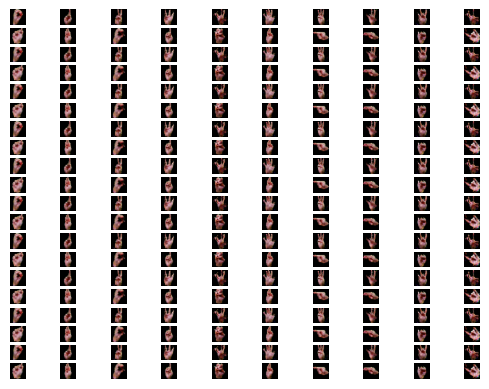

In [24]:
examples = (X + 1) / 2.0
examples = (examples*255).astype(np.uint8)
for i in range(200):    
    plt.subplot(20, 10, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, :])
    name=label.inverse_transform([labels[i]])[0]
    cv2.imwrite(f'/kaggle/working/Images/{name}_{i}.jpg',examples[i,:,:,:])
plt.show()
